In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
import math

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period_2000_2021/"
np.random.seed(12001)



# Define the model that generates pair simulations.
yuima = importr("yuima")
n_jumpou_NIG_sim_string = """
n_jumpou_NIG = function(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length){
  
  set.seed(random_seed)
  
  drift = c("mu11*t-mu12*X1", "mu21*t-mu22*X2")
  diffusion = matrix(c("exp(sigma11)", "exp(sigma12)", "exp(sigma21)", "exp(sigma22)"), 2, 2, byrow=TRUE)
  jumpcoef = matrix(c("j11", "j12", "j21", "j22"), 2, 2, byrow=TRUE) 
  
  
  beta = c(beta1, beta2)
  delta0 = delta0
  mu = c(mu1, mu2)
  lambda11 = sum(lambda11)
  alpha = beta1^2*lambda11 + beta2^2/lambda11 + 1
  Lambda = matrix(c(lambda11, 0, 0, 1/lambda11), 2, 2, byrow=TRUE)
  
  ou_model = setModel(drift=drift, diffusion=diffusion, jump.coeff=jumpcoef, 
                      measure.type="code",
                      measure=list(df="rNIG(z, alpha, beta, delta0, mu, Lambda)"), 
                      time.variable = "t",
                      state.var=c("X1","X2"), solve.variable=c("X1","X2"))
  newsamp = setSampling(Initial=T0, Terminal=T, n=length)
  
  n_sim_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    jumpou_sim = simulate(ou_model, 
                          true.par=list(
                            mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22, 
                            sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22,
                            j11=j11, j12=j12, j21=j21, j22=j22,
                            alpha=alpha, beta=beta, delta0=delta0, mu=mu, Lambda=Lambda), 
                          xinit=xinit_vec[[i]], sampling=newsamp)
    original_data = jumpou_sim@data@original.data
    one_sim_jumpou = data.frame(original_data[,1], original_data[,2])
    colnames(one_sim_jumpou) = c('series1', 'series2')
    n_sim_data[, (2*i-1):(2*i)] = one_sim_jumpou
  }
  return(n_sim_data)
}
"""

n_jumpou_NIG_sim = SignatureTranslatedAnonymousPackage(n_jumpou_NIG_sim_string, "n_jumpou_NIG_sim")
def n_jumpou_simulation(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length):

    n_sim_data = pd.DataFrame(
        n_jumpou_NIG_sim.n_jumpou_NIG(random_seed, num_sim,
                                      mu11, mu12, mu21, mu22, 
                                      sigma11, sigma12, sigma21, sigma22,
                                      j11, j12, j21, j22,
                                      alpha, beta1, beta2, delta0, mu1, mu2, 
                                      lambda11, lambda12, lambda21, lambda22,
                                      xinit_vec, T0, T, length)).transpose()
    return n_sim_data


def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return


def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef

def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    price_series1 = n_price.iloc[:, ::2]
    price_series2 = n_price.iloc[:, 1::2]
    sq_return_series1 = return_series1**2
    sq_return_series2 = return_series2**2

    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series2.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values #8(8)
    
    
    
    # Autocorrelation of the 2 return series with 3 lags respectively
    autocorr1_lag_1 = return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr1_lag_2 = return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr1_lag_3 = return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr2_lag_1 = return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr2_lag_2 = return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr2_lag_3 = return_series2.apply(lambda x: x.autocorr(lag=3)) #6(14)
    
    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_ts1_lag_0.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(21)
    
    
    
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#6(27)
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2, #8(8)
                               
                               autocorr1_lag_1, autocorr1_lag_2, autocorr1_lag_3,
                               autocorr2_lag_1, autocorr2_lag_2, autocorr2_lag_3,#6(14)
                               
                               corr_ts1_lag_0, 
                               corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
                               corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
                               
                               autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
                               autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)
                               
                               corr_sqts1_lag_0,
                               corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
                               corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3])#7(34)
    stats_data = stats_data.transpose()
#     stats_data.columns = [
#         'return_mean1', 'return_mean2',
#         'return_sd1', 'return_sd2',
#         'return_skew1', 'return_skew2',
#         'return_kurtosis1', 'return_kurtosis2',
        
#         'return_autocorrelation_ts1_lag1', 'return_autocorrelation_ts1_lag2', 'return_autocorrelation_ts1_lag3',
#         'return_autocorrelation_ts2_lag1', 'return_autocorrelation_ts2_lag2', 'return_autocorrelation_ts2_lag3',
        
#         'return_correlation_ts1_lag_0',
#         'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
#         'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        
#         'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
#         'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
#         'sqreturn_correlation_ts1_lag_0',
#         'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
#         'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3']
    
    return stats_data


losses_vec = []
params_vec = []
def loss_function(params):

    params = FloatVector(params)
    print(params)
    
    params_vec.append(params)
    
    moment_loss = pd.DataFrame().reindex_like(real_stats)
    
    n_sim_log_price = n_jumpou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        
        alpha=2*params[12]*params[13]+0.5, 
        beta1=params[12], beta2=params[13], 
        delta0=params[14], 
        mu1=0, mu2=0, 
        lambda11=params[15], lambda12=0, 
        lambda21=0, lambda22=1/params[15],

        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    
    n_sim_price = log_price_to_price(n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_sim_return, n_sim_price)

    moment_loss = np.abs(n_real_stats - n_sim_stats)
    sum_loss = np.sum(moment_loss)

    sum_loss[6] = sum_loss[6]/10 
    sum_loss[7] = sum_loss[7]/10 
    
    loss = np.sum(sum_loss)
    
    losses_vec.append(loss)

    print(sum_loss)
    print(loss)
    print('----------')

    return loss


real_price = pd.read_csv(real_data_folder + "pair_prices_cal.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_returns_cal.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 2, real_price.shape[0]
n_real_stats = real_stats


initial0 = [1, 1, 1, 1,
            -1, -1, -1, -1,
            0.1, 0.1, 0.1, 0.1,
            
            1, 1, 
            1, 
            1]

begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='powell',
               tol=1e-6, 
               options={'disp': True},
               bounds=[                       
                   (0, 1), (0, 1), (0, None), (0, None),
                   (None, None), (None, None), (None, None), (None, None),
                   (None, None), (None, None), (None, None), (None, None),
                   
                   (0, None), (0, None), 
                   (0, None), 
                   (0, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)


 [1]  1.0  1.0  1.0  1.0 -1.0 -1.0 -1.0 -1.0  0.1  0.1  0.1  0.1  1.0  1.0  1.0
[16]  1.0

0      99.149489
1      94.521319
2     394.755443
3     385.794574
4     154.834798
5     163.218876
6     158.326960
7     172.268017
8      16.643071
9      14.317947
10     14.534486
11     16.315758
12     14.993743
13     14.815749
14    166.464366
15     14.409662
16     14.488282
17     15.067079
18     15.683452
19     12.285349
20     14.657313
21     28.383133
22     24.557755
23     22.627831
24     30.698633
25     26.386365
26     22.848061
27    166.464366
28     14.409662
29     14.488282
30     15.067079
31     15.683452
32     12.285349
33     14.657313
dtype: float64
2376.103013374277
----------
 [1]  0.381966  1.000000  1.000000  1.000000 -1.000000 -1.000000 -1.000000
 [8] -1.000000  0.100000  0.100000  0.100000  0.100000  1.000000  1.000000
[15]  1.000000  1.000000

0     135.598237
1      95.794950
2     388.013922
3     381.140030
4     157.935561
5     166.210888
6     154

0     112.989999
1      94.525997
2     397.425706
3     389.647699
4     158.947158
5     172.729441
6     164.516607
7     181.645554
8      16.716128
9      14.252637
10     13.895018
11     16.532804
12     14.783274
13     14.740174
14    166.462290
15     14.020224
16     13.922432
17     14.397029
18     16.408369
19     12.865661
20     14.458051
21     26.136169
22     24.685793
23     22.455123
24     28.521696
25     27.180200
26     21.512238
27    166.462290
28     14.020224
29     13.922432
30     14.397029
31     16.408369
32     12.865661
33     14.458051
dtype: float64
2418.9075302573256
----------
 [1]  0.7636499  1.0000000  1.0000000  1.0000000 -1.0000000 -1.0000000
 [7] -1.0000000 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000

0     110.594125
1      92.301651
2     394.125856
3     387.042998
4     153.606705
5     168.026818
6     152.821092
7     170.944544
8      15.832540
9      15.168926
10     14.08122

0      30.311221
1      93.835326
2     385.217220
3     383.794911
4     155.517221
5     162.189398
6     151.528769
7     170.130613
8      15.387522
9      13.578289
10     14.248096
11     16.664339
12     16.254019
13     15.613362
14    165.816206
15     14.446814
16     13.599742
17     14.367768
18     14.325306
19     12.975442
20     14.248643
21     27.221859
22     25.101062
23     22.563245
24     29.368003
25     27.286550
26     21.886899
27    165.816206
28     14.446814
29     13.599742
30     14.367768
31     14.325306
32     12.975442
33     14.248643
dtype: float64
2277.257769045572
----------
 [1]  0.763932  0.145898  1.000000  1.000000 -1.000000 -1.000000 -1.000000
 [8] -1.000000  0.100000  0.100000  0.100000  0.100000  1.000000  1.000000
[15]  1.000000  1.000000

0      34.981464
1      94.122601
2     391.324251
3     387.834522
4     152.776151
5     160.639190
6     154.389798
7     169.676815
8      16.148804
9      13.943510
10     13.294327
11     16.80721

0      34.661026
1      95.911486
2     391.227636
3     387.332179
4     156.912766
5     168.134028
6     158.448628
7     173.644147
8      15.887519
9      14.009365
10     14.301474
11     16.266382
12     15.189984
13     13.873037
14    165.824744
15     13.918261
16     13.462976
17     14.051017
18     14.363339
19     12.406704
20     14.466525
21     28.064704
22     24.801859
23     21.049809
24     29.681634
25     26.615458
26     21.676946
27    165.824744
28     13.918261
29     13.462976
30     14.051017
31     14.363339
32     12.406704
33     14.466525
dtype: float64
2304.6772004298437
----------
 [1]  0.7639320  0.2443524  1.0000000  1.0000000 -1.0000000 -1.0000000
 [7] -1.0000000 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000

0      32.289348
1      96.713572
2     389.139018
3     384.699500
4     158.856741
5     174.024473
6     158.350499
7     177.521660
8      14.497379
9      13.884370
10     14.15912

0      34.052797
1      94.350650
2     386.853372
3     384.789350
4     149.476245
5     165.651608
6     152.157219
7     168.980626
8      15.940025
9      13.826484
10     13.401052
11     15.849155
12     14.981605
13     14.621784
14    165.801460
15     14.514637
16     13.453788
17     14.008941
18     15.045706
19     12.902599
20     13.878652
21     27.341536
22     25.350597
23     21.461463
24     29.116024
25     27.092587
26     21.093267
27    165.801460
28     14.514637
29     13.453788
30     14.008941
31     15.045706
32     12.902599
33     13.878652
dtype: float64
2275.5990150424363
----------
 [1]  0.7639320  0.2443098  1.1150922  1.0000000 -1.0000000 -1.0000000
 [7] -1.0000000 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000

0      31.503636
1      86.906587
2     388.364605
3     385.767269
4     149.826717
5     162.730892
6     150.482557
7     168.267486
8      16.263086
9      15.011355
10     13.61088

0      33.998637
1      43.553804
2     389.571470
3     389.993055
4     145.000440
5     158.343710
6     151.476538
7     169.263993
8      15.370800
9      13.710682
10     13.765720
11     17.234650
12     16.434661
13     15.672083
14    165.062574
15     13.917899
16     14.475728
17     14.352319
18     14.989511
19     13.249118
20     12.959055
21     26.793162
22     25.671004
23     21.601824
24     28.938183
25     26.746797
26     21.871302
27    165.062574
28     13.917899
29     14.475728
30     14.352319
31     14.989511
32     13.249118
33     12.959055
dtype: float64
2223.024921764911
----------
 [1]  0.7639320  0.2443098  2.2134239  1.0000000 -1.0000000 -1.0000000
 [7] -1.0000000 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000

0      29.926727
1      41.540194
2     391.024167
3     390.859872
4     147.280076
5     162.798926
6     149.968041
7     171.453882
8      15.357513
9      14.342303
10     15.228481

0      34.383125
1      42.133687
2     388.366138
3     388.050165
4     150.973590
5     160.779492
6     153.449494
7     168.557268
8      15.523624
9      14.272769
10     13.610244
11     18.373898
12     16.345657
13     14.380960
14    165.082030
15     15.208548
16     14.355770
17     13.888565
18     15.537113
19     13.661751
20     14.025443
21     28.138400
22     26.413863
23     22.408636
24     30.350732
25     28.008393
26     20.966869
27    165.082030
28     15.208548
29     14.355770
30     13.888565
31     15.537113
32     13.661751
33     14.025443
dtype: float64
2239.0054432000506
----------
 [1]  0.7639320  0.2443098  2.2177726  1.0000000 -1.0000000 -1.0000000
 [7] -1.0000000 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000

0      32.165876
1      41.007568
2     391.596708
3     391.347998
4     157.428248
5     164.913499
6     155.805914
7     169.487363
8      15.539349
9      14.005126
10     14.07213

0      33.117094
1      33.957635
2     390.730572
3     387.913051
4     150.371548
5     161.061945
6     152.951585
7     169.268911
8      15.771643
9      13.477487
10     14.054733
11     17.420582
12     15.246513
13     14.930241
14    165.519097
15     13.503260
16     14.103001
17     14.428086
18     15.741504
19     12.713058
20     13.535104
21     27.354179
22     24.835121
23     22.333384
24     30.178300
25     26.926215
26     22.366274
27    165.519097
28     13.503260
29     14.103001
30     14.428086
31     15.741504
32     12.713058
33     13.535104
dtype: float64
2223.3532337929105
----------
 [1]  0.7639320  0.2443098  2.2177462  0.5272218 -1.0000000 -1.0000000
 [7] -1.0000000 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000

0      33.778104
1      50.098811
2     388.337302
3     386.979413
4     155.341363
5     163.306900
6     153.004442
7     172.446172
8      16.081374
9      13.867644
10     15.04387

0      31.991144
1      35.044729
2     389.812554
3     390.423493
4     154.344352
5     163.892968
6     151.077588
7     168.955145
8      15.425324
9      14.259856
10     12.938121
11     18.036056
12     15.490851
13     14.303704
14    165.528577
15     14.460577
16     13.922680
17     13.474758
18     14.736626
19     13.220466
20     13.544646
21     26.606928
22     24.646046
23     21.095373
24     29.333669
25     27.209957
26     21.080433
27    165.528577
28     14.460577
29     13.922680
30     13.474758
31     14.736626
32     13.220466
33     13.544646
dtype: float64
2223.744948898188
----------
 [1]  0.7639320  0.2443098  2.2177462  0.7796967 -1.0000000 -1.0000000
 [7] -1.0000000 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000

0      31.500063
1      34.999250
2     386.286744
3     386.406966
4     152.257223
5     159.269685
6     153.288425
7     172.608916
8      14.812212
9      14.020742
10     14.826460

0      32.127791
1      34.658895
2     388.267255
3     388.502793
4     156.259481
5     166.636134
6     150.117105
7     169.437123
8      16.905725
9      14.423484
10     14.400023
11     17.055683
12     16.052302
13     15.462677
14    165.490257
15     15.040936
16     14.510400
17     14.696804
18     15.323184
19     13.255018
20     14.527631
21     26.271490
22     24.557149
23     21.968983
24     28.515422
25     25.989641
26     21.425726
27    165.490257
28     15.040936
29     14.510400
30     14.696804
31     15.323184
32     13.255018
33     14.527631
dtype: float64
2234.72333805664
----------
 [1]  0.7639320  0.2443098  2.2177462  0.7798891 -1.0000000 -1.0000000
 [7] -1.0000000 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000

0      30.639721
1      34.755116
2     390.248457
3     387.331554
4     151.652851
5     164.613352
6     150.659992
7     166.695347
8      14.868313
9      14.781153
10     13.629103


0      27.197480
1      33.099964
2     214.697274
3     386.398919
4     178.358520
5     168.162675
6     166.799708
7     170.885793
8      16.229236
9      14.371099
10     14.080556
11     17.180706
12     15.696891
13     14.280633
14    103.305449
15     14.985696
16     13.768827
17     14.912412
18     15.888682
19     13.304002
20     14.550078
21     26.797105
22     26.290661
23     21.233377
24     29.052613
25     27.688111
26     20.449826
27    103.305449
28     14.985696
29     13.768827
30     14.912412
31     15.888682
32     13.304002
33     14.550078
dtype: float64
1970.381436027404
----------
 [1]  0.7639320  0.2443098  2.2177462  0.7798876 -4.8541020 -1.0000000
 [7] -1.0000000 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000

0      26.814604
1      34.716507
2     216.889364
3     388.099950
4     166.562479
5     164.130068
6     147.284031
7     169.501469
8      15.090191
9      14.183489
10     14.985913

0      27.399667
1      34.408873
2     214.566228
3     388.018466
4     178.682471
5     162.138825
6     163.609977
7     169.914933
8      15.578750
9      15.222000
10     13.983430
11     16.981027
12     15.475594
13     15.232504
14    101.512941
15     13.624561
16     15.028834
17     15.278364
18     16.028988
19     13.604905
20     14.158517
21     26.393413
22     26.168979
23     21.736351
24     29.271260
25     27.566029
26     21.392606
27    101.512941
28     13.624561
29     15.028834
30     15.278364
31     16.028988
32     13.604905
33     14.158517
dtype: float64
1962.2156030532565
----------
 [1]  0.7639320  0.2443098  2.2177462  0.7798876 -4.8590755 -1.0000000
 [7] -1.0000000 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000

0      28.785098
1      34.381125
2     214.683211
3     386.910044
4     163.031030
5     165.127681
6     150.615763
7     168.535474
8      15.161294
9      14.131958
10     15.01807

0      25.916230
1      33.197314
2     171.812073
3     389.661234
4     196.749315
5     164.520944
6     182.069374
7     169.679087
8      15.684953
9      14.435777
10     13.968785
11     16.866156
12     15.759462
13     13.784214
14    101.770275
15     13.888251
16     14.637935
17     13.773749
18     16.180721
19     13.218253
20     13.623703
21     26.369113
22     24.391623
23     21.179369
24     29.861910
25     26.383044
26     20.645734
27    101.770275
28     13.888251
29     14.637935
30     13.773749
31     16.180721
32     13.218253
33     13.623703
dtype: float64
1947.1214824670137
----------
 [1]  0.7639320  0.2443098  2.2177462  0.7798876 -4.8586896 -1.4097527
 [7] -1.0000000 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000

0      24.498193
1      33.003070
2     166.595601
3     384.877467
4     235.982520
5     164.810564
6     209.993148
7     170.901408
8      15.785123
9      13.900309
10     14.32387

0      24.712685
1      33.724928
2     165.834232
3     382.971244
4     203.220930
5     161.611031
6     169.786883
7     168.507916
8      15.977496
9      15.182362
10     13.863464
11     17.971835
12     16.197569
13     16.047063
14    100.951937
15     15.735148
16     15.464252
17     14.527297
18     15.806174
19     13.295645
20     14.937287
21     26.258014
22     24.643437
23     21.984974
24     27.844391
25     27.268740
26     22.587235
27    100.951937
28     15.735148
29     15.464252
30     14.527297
31     15.806174
32     13.295645
33     14.937287
dtype: float64
1937.6319099804175
----------
 [1]  0.7639320  0.2443098  2.2177462  0.7798876 -4.8586896 -1.2833681
 [7] -1.0000000 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000

0      25.308462
1      34.367240
2     169.028924
3     388.008108
4     221.866085
5     165.666957
6     187.859839
7     167.096834
8      16.120461
9      14.264952
10     15.07255

0      23.385589
1      33.337134
2     170.047220
3     257.713438
4     236.909957
5     186.487778
6     213.080450
7     179.550730
8      15.193388
9      13.968544
10     14.671630
11     17.862327
12     17.150543
13     15.808743
14    148.898278
15     13.809835
16     14.638157
17     13.919783
18     14.464078
19     13.743915
20     14.114241
21     26.607687
22     24.532959
23     20.798168
24     29.552980
25     26.133544
26     21.731734
27    148.898278
28     13.809835
29     14.638157
30     13.919783
31     14.464078
32     13.743915
33     14.114241
dtype: float64
2011.7011178112177
----------
 [1]  0.7639320  0.2443098  2.2177462  0.7798876 -4.8586896 -1.2837679
 [7] -1.0000000 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000

0      24.697529
1      35.128176
2     168.719076
3     389.978350
4     223.508163
5     166.835713
6     194.355845
7     166.258672
8      16.917422
9      14.078410
10     14.67427

0      26.270716
1      33.440660
2     167.524446
3     292.356655
4     198.395637
5     170.839491
6     167.695664
7     168.970298
8      16.028297
9      13.650401
10     14.597297
11     17.769338
12     16.459817
13     16.424181
14    131.118071
15     14.648751
16     14.068929
17     14.699451
18     15.117356
19     13.299517
20     14.391952
21     27.396284
22     24.757605
23     21.218664
24     28.487438
25     26.420929
26     21.545753
27    131.118071
28     14.648751
29     14.068929
30     14.699451
31     15.117356
32     13.299517
33     14.391952
dtype: float64
1904.9376268740214
----------
 [1]  0.7639320  0.2443098  2.2177462  0.7798876 -4.8586896 -1.2837679
 [7] -1.4293170 -1.0000000  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000

0      24.943115
1      33.395816
2     168.701248
3     294.760502
4     209.437210
5     177.127981
6     181.659310
7     170.950533
8      16.182251
9      14.930063
10     14.68557

0      25.006431
1      31.160686
2     168.216493
3     180.826793
4     205.178344
5     229.218306
6     167.498810
7     200.045167
8      16.265079
9      13.721342
10     14.863009
11     24.741944
12     24.547420
13     22.495196
14     35.045849
15     15.829320
16     15.322172
17     15.225003
18     16.116455
19     13.042503
20     14.446360
21     26.676255
22     25.027596
23     22.713285
24     28.456371
25     26.111368
26     21.382005
27     35.045849
28     15.829320
29     15.322172
30     15.225003
31     16.116455
32     13.042503
33     14.446360
dtype: float64
1724.207222518811
----------
 [1]  0.7639320  0.2443098  2.2177462  0.7798876 -4.8586896 -1.2837679
 [7] -1.4307088 -2.0081368  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000

0      24.373444
1      30.870844
2     166.994239
3     185.821767
4     195.959049
5     212.293672
6     172.187000
7     177.628804
8      14.886454
9      14.349431
10     15.555770

0      24.822160
1      32.745428
2     169.576522
3     185.099814
4     211.466297
5     241.696467
6     172.592370
7     210.224131
8      17.790918
9      13.601724
10     13.843620
11     24.669838
12     23.767428
13     22.204706
14     33.342209
15     15.007639
16     14.630782
17     15.416799
18     17.128987
19     14.057580
20     15.065247
21     26.656496
22     25.504790
23     22.232099
24     28.403619
25     26.437950
26     20.291997
27     33.342209
28     15.007639
29     14.630782
30     15.416799
31     17.128987
32     14.057580
33     15.065247
dtype: float64
1762.9268580986718
----------
 [1]  0.7639320  0.2443098  2.2177462  0.7798876 -4.8586896 -1.2837679
 [7] -1.4307088 -3.0839031  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000

0      23.959830
1      32.664966
2     167.189092
3     181.364976
4     199.156389
5     229.794236
6     172.051378
7     179.730715
8      15.369896
9      15.537805
10     14.99027

0       69.851431
1       33.140274
2     1041.897729
3      182.352293
4     1280.709227
5      246.515366
6     2006.064661
7      204.706558
8       15.760419
9       12.789277
10      13.235137
11      26.486917
12      24.613148
13      23.158221
14     118.987099
15      14.093453
16      14.237487
17      14.873350
18      15.340799
19      12.511532
20      13.414379
21      26.794626
22      23.135639
23      20.565498
24      29.045071
25      25.576844
26      20.326699
27     118.987099
28      14.093453
29      14.237487
30      14.873350
31      15.340799
32      12.511532
33      13.414379
dtype: float64
5733.641233808078
----------
 [1]  0.7639320  0.2443098  2.2177462  0.7798876 -4.8586896 -1.2837679
 [7] -1.4307088 -3.0841115  0.1000000  0.1000000  0.1000000  0.1000000
[13]  1.0000000  1.0000000  1.0000000  1.0000000

0      25.591771
1      30.657375
2     168.245121
3     183.842003
4     229.048111
5     254.947843
6     196.317001
7     227.186212
8      15.700714

0      25.321006
1      32.191433
2     167.000559
3     182.288610
4     160.610766
5     245.366604
6     153.107262
7     202.325092
8      15.955423
9      14.439699
10     14.291458
11     25.882443
12     24.597435
13     23.067884
14     36.588613
15     15.574532
16     15.418285
17     15.383109
18     16.352213
19     14.886888
20     14.506637
21     27.124942
22     25.870846
23     21.694526
24     28.594355
25     26.432442
26     21.102291
27     36.588613
28     15.574532
29     15.418285
30     15.383109
31     16.352213
32     14.886888
33     14.506637
dtype: float64
1694.6856302289123
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02540959  0.10000000  0.10000000  0.10000000
[13]  1.00000000  1.00000000  1.00000000  1.00000000

0      26.815286
1      32.283539
2     166.997388
3     185.278972
4     159.265302
5     224.450941
6     153.842805
7     198.852794
8      15.432622
9      15.123703

0      26.238696
1      31.791782
2     165.336071
3     183.162665
4     156.446204
5     238.870924
6     152.945575
7     195.897090
8      16.253080
9      16.155262
10     14.628948
11     24.438860
12     25.093408
13     22.153783
14     34.103422
15     14.914415
16     15.895766
17     15.894517
18     16.383236
19     15.268062
20     14.440608
21     26.751384
22     24.325295
23     22.550444
24     28.429870
25     25.916608
26     21.302984
27     34.103422
28     14.914415
29     15.895766
30     15.894517
31     16.383236
32     15.268062
33     14.440608
dtype: float64
1672.48898584653
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.10000000  0.10000000  0.10000000
[13]  1.00000000  1.00000000  1.00000000  1.00000000

0      24.538607
1      31.876425
2     164.457551
3     184.865606
4     164.222102
5     244.088461
6     155.918237
7     199.790683
8      15.935806
9      13.898003
1

0      26.807547
1      30.688860
2     163.079908
3     183.083794
4     153.978548
5     209.342355
6     151.776148
7     187.353687
8      15.588868
9      14.133125
10     14.863602
11     25.466473
12     24.487649
13     22.946528
14     36.846588
15     16.708566
16     15.742854
17     15.280501
18     16.257808
19     14.470468
20     15.390232
21     27.201513
22     24.441716
23     21.317934
24     27.659966
25     25.312496
26     20.986864
27     36.846588
28     16.708566
29     15.742854
30     15.280501
31     16.257808
32     14.470468
33     15.390232
dtype: float64
1631.911613229565
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08868638  0.10000000  0.10000000
[13]  1.00000000  1.00000000  1.00000000  1.00000000

0      26.479010
1      31.027388
2     164.837514
3     181.607791
4     147.777927
5     219.585384
6     151.182034
7     183.678287
8      17.294730
9      14.474828


0      25.867192
1      31.019005
2     164.412850
3     179.397751
4     153.896656
5     237.280250
6     152.762393
7     189.956214
8      14.756112
9      14.530344
10     13.777356
11     25.507963
12     24.002684
13     23.594469
14     34.406790
15     15.126614
16     15.095328
17     14.964663
18     16.733583
19     14.914142
20     14.785486
21     26.916929
22     25.532452
23     22.419035
24     28.180272
25     27.156179
26     20.706672
27     34.406790
28     15.126614
29     15.095328
30     14.964663
31     16.733583
32     14.914142
33     14.785486
dtype: float64
1653.7259928029134
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08928173  0.10000000  0.10000000
[13]  1.00000000  1.00000000  1.00000000  1.00000000

0      25.083264
1      31.312845
2     165.825421
3     183.638438
4     148.616905
5     232.061309
6     153.383503
7     197.681924
8      16.286596
9      14.308007

0       24.954214
1       42.114975
2      165.720885
3      675.815185
4      153.508560
5     1248.145084
6      152.873416
7     1820.240619
8       16.496665
9       15.012423
10      14.215780
11      16.438528
12      14.543674
13      14.513914
14      66.496810
15      15.078415
16      13.884397
17      13.174090
18      15.691657
19      12.628722
20      14.185611
21      26.854614
22      24.681550
23      21.874156
24      28.277677
25      25.630087
26      20.679491
27      66.496810
28      15.078415
29      13.884397
30      13.174090
31      15.691657
32      12.628722
33      14.185611
dtype: float64
4824.870903008714
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -1.51803400  0.10000000
[13]  1.00000000  1.00000000  1.00000000  1.00000000

0       25.595978
1       50.517566
2      165.459370
3     1090.367598
4      160.719902
5     1334.351748
6      156.691611
7     2215

0      25.079332
1      30.834345
2     164.827783
3     181.369991
4     154.155914
5     173.208091
6     153.277480
7     173.781862
8      16.134587
9      15.389040
10     14.812737
11     25.429110
12     25.639447
13     24.655672
14     33.991328
15     16.047541
16     15.611451
17     16.480896
18     17.357619
19     14.506307
20     15.747858
21     27.279979
22     25.108923
23     22.171173
24     29.386389
25     26.142541
26     20.403871
27     33.991328
28     16.047541
29     15.611451
30     16.480896
31     17.357619
32     14.506307
33     15.747858
dtype: float64
1588.57426535849
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01559465  0.10000000
[13]  1.00000000  1.00000000  1.00000000  1.00000000

0      26.487046
1      31.266991
2     165.972918
3     181.146442
4     147.469619
5     166.669171
6     150.967721
7     169.041952
8      15.800964
9      14.824309
1

0      25.544047
1      31.986434
2     165.901346
3     180.745116
4     149.843288
5     176.909044
6     147.435134
7     169.547959
8      15.606426
9      15.459328
10     14.022896
11     26.476517
12     24.400537
13     23.772885
14     33.771198
15     15.418795
16     15.361857
17     15.404511
18     16.508803
19     14.412216
20     14.740246
21     27.038825
22     25.902027
23     21.934190
24     29.154852
25     26.432993
26     21.171911
27     33.771198
28     15.418795
29     15.361857
30     15.404511
31     16.508803
32     14.412216
33     14.740246
dtype: float64
1570.5210058204996
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000000
[13]  1.00000000  1.00000000  1.00000000  1.00000000

0      26.330217
1      32.015032
2     167.107389
3     181.771292
4     155.761168
5     174.710255
6     152.305975
7     175.166843
8      15.609200
9      14.420020

0      25.851108
1      31.005488
2     166.978405
3     185.749303
4     158.409743
5     248.001456
6     154.624946
7     216.754134
8      15.717751
9      15.157115
10     14.627519
11     24.961890
12     24.666114
13     23.025078
14     33.201143
15     15.772334
16     14.679753
17     15.397195
18     16.086289
19     14.858869
20     14.403939
21     27.523100
22     25.321068
23     21.707935
24     28.345851
25     25.521383
26     22.615459
27     33.201143
28     15.772334
29     14.679753
30     15.397195
31     16.086289
32     14.858869
33     14.403939
dtype: float64
1705.3638918424908
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.12128623
[13]  1.00000000  1.00000000  1.00000000  1.00000000

0      25.492552
1      31.314005
2     166.084086
3     184.302233
4     150.562002
5     177.961893
6     152.124916
7     167.411694
8      16.199002
9      14.721361

0      26.054264
1      32.540133
2     166.125159
3     182.644778
4     150.866963
5     172.710409
6     149.892814
7     168.001249
8      16.386070
9      14.950796
10     14.351856
11     26.594329
12     26.881554
13     24.181125
14     33.631941
15     16.279908
16     15.879716
17     14.977910
18     16.204470
19     14.766355
20     15.739378
21     28.060165
22     25.439918
23     21.636505
24     28.275464
25     27.043099
26     21.128238
27     33.631941
28     16.279908
29     15.879716
30     14.977910
31     16.204470
32     14.766355
33     15.739378
dtype: float64
1578.7242446215994
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10017307
[13]  1.00000000  1.00000000  1.00000000  1.00000000

0      26.294220
1      31.436194
2     165.626490
3     184.321091
4     155.896193
5     183.300945
6     160.307164
7     185.274326
8      16.041581
9      14.834823

0      24.909917
1      31.486708
2     165.276071
3     181.044878
4     149.893312
5     168.247493
6     152.017361
7     169.566928
8      16.409627
9      13.780919
10     14.506062
11     26.434750
12     26.245831
13     23.346977
14     33.545376
15     15.681637
16     16.646579
17     15.392085
18     16.454267
19     15.021330
20     15.110410
21     26.306236
22     25.319205
23     21.880511
24     28.937050
25     26.501379
26     20.497270
27     33.545376
28     15.681637
29     16.646579
30     15.392085
31     16.454267
32     15.021330
33     15.110410
dtype: float64
1568.3118512145982
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000141
[13]  1.00000000  1.00000000  1.00000000  1.00000000

0      26.149062
1      31.253934
2     162.582272
3     181.335307
4     151.255834
5     172.118151
6     151.613300
7     167.497820
8      15.440463
9      14.029842

0      26.581150
1      31.412591
2     167.391417
3     180.738775
4     160.457851
5     178.339014
6     160.523737
7     177.372645
8      15.338702
9      14.295748
10     14.188811
11     27.302123
12     25.783515
13     22.897411
14     34.331279
15     15.647276
16     14.768896
17     15.771186
18     16.154430
19     14.566291
20     14.375479
21     27.495644
22     26.378221
23     21.014625
24     28.247281
25     26.725872
26     21.172540
27     34.331279
28     15.647276
29     14.768896
30     15.771186
31     16.154430
32     14.566291
33     14.375479
dtype: float64
1604.8873479497431
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.00000000  1.00000000  1.00000000  1.00000000

0      27.525775
1      30.925078
2     164.001342
3     182.112349
4     145.416717
5     168.287972
6     150.618436
7     168.127311
8      16.349906
9      15.365847

0      25.880018
1      31.028120
2     163.583638
3     180.613022
4     146.326722
5     168.821119
6     152.528158
7     172.279264
8      15.544199
9      14.616067
10     14.505446
11     27.212011
12     26.309051
13     24.654570
14     33.596937
15     16.093483
16     15.592270
17     14.803986
18     16.006781
19     14.097138
20     15.782255
21     26.048168
22     25.466766
23     21.772150
24     29.148432
25     26.050646
26     21.388051
27     33.596937
28     16.093483
29     15.592270
30     14.803986
31     16.006781
32     14.097138
33     15.782255
dtype: float64
1565.7213181598806
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.00000000  1.00000000  1.00000000  1.00000000

0      26.540447
1      31.828194
2     166.243301
3     180.748655
4     163.411017
5     184.611084
6     165.147570
7     190.976851
8      16.230640
9      15.187151

0      26.153351
1      31.870042
2     165.329731
3     182.243079
4     145.423737
5     162.846778
6     153.099242
7     169.162803
8      15.567280
9      14.911130
10     13.408180
11     26.845190
12     25.895330
13     23.536992
14     34.255371
15     14.802611
16     16.046674
17     15.809077
18     17.314298
19     14.719864
20     15.482044
21     27.489054
22     25.482876
23     23.329543
24     28.712908
25     26.638872
26     22.146550
27     34.255371
28     14.802611
29     16.046674
30     15.809077
31     17.314298
32     14.719864
33     15.482044
dtype: float64
1566.952544884571
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.24833476  1.00000000  1.00000000  1.00000000

0      26.456639
1      31.864919
2     165.446236
3     181.423835
4     145.323987
5     160.210969
6     153.963709
7     169.304594
8      15.445864
9      14.297758


0      25.147527
1      32.276765
2     165.588125
3     180.467178
4     147.550232
5     164.217245
6     152.722945
7     166.071857
8      16.095098
9      14.189809
10     15.486163
11     27.130509
12     27.892275
13     24.952551
14     33.093051
15     14.066666
16     15.356695
17     15.639240
18     15.952447
19     14.510553
20     14.899608
21     25.836697
22     25.548027
23     21.660549
24     27.837054
25     27.387710
26     21.443580
27     33.093051
28     14.066666
29     15.356695
30     15.639240
31     15.952447
32     14.510553
33     14.899608
dtype: float64
1556.5384133305306
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454576  1.00000000  1.00000000  1.00000000

0      26.178638
1      32.637621
2     166.700316
3     181.376945
4     145.868520
5     160.082955
6     153.713537
7     165.870398
8      15.665670
9      15.084422

0      26.458820
1      30.986506
2     162.809830
3     181.268014
4     145.213326
5     151.789306
6     156.010793
7     173.053366
8      17.397631
9      14.008814
10     14.687518
11     28.625624
12     27.262594
13     24.736642
14     34.789381
15     16.110257
16     15.320610
17     15.798762
18     17.103079
19     14.570106
20     15.111932
21     27.377922
22     24.778666
23     21.597687
24     28.532683
25     26.290844
26     21.245272
27     34.789381
28     16.110257
29     15.320610
30     15.798762
31     17.103079
32     14.570106
33     15.111932
dtype: float64
1561.7401125340289
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.61317753  1.00000000  1.00000000

0      24.604645
1      32.096920
2     165.021659
3     181.008712
4     145.706144
5     154.889780
6     156.572035
7     173.583816
8      16.970581
9      14.943756

0      25.682306
1      32.070985
2     166.322679
3     181.513441
4     142.820163
5     155.273609
6     155.989723
7     173.163457
8      16.305264
9      15.054023
10     15.437935
11     28.831987
12     26.744913
13     24.066909
14     35.139710
15     15.800884
16     15.360607
17     14.886174
18     16.836484
19     14.940015
20     15.069407
21     26.687045
22     26.558836
23     21.304581
24     28.736334
25     26.725757
26     21.353354
27     35.139710
28     15.800884
29     15.360607
30     14.886174
31     16.836484
32     14.940015
33     15.069407
dtype: float64
1566.7098604585128
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60866262  1.00000000  1.00000000

0      25.788119
1      30.068698
2     164.026444
3     181.389377
4     144.559933
5     155.374196
6     156.073032
7     173.802054
8      16.547073
9      14.558340

0      25.849055
1      30.903523
2     164.946874
3     181.697932
4     144.593802
5     155.021459
6     155.984944
7     173.175420
8      15.415351
9      14.733805
10     14.264857
11     27.682771
12     26.637058
13     24.103617
14     35.391600
15     15.760666
16     15.481317
17     13.904137
18     16.755817
19     15.044228
20     13.948131
21     26.623387
22     26.298952
23     22.935737
24     29.515328
25     25.564188
26     21.539618
27     35.391600
28     15.760666
29     15.481317
30     13.904137
31     16.755817
32     15.044228
33     13.948131
dtype: float64
1560.0594769811883
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.18115393  1.00000000

0      26.372552
1      31.770411
2     163.659689
3     180.613087
4     144.628062
5     155.130876
6     155.509622
7     172.584689
8      14.727250
9      14.079655

0      25.822724
1      31.225873
2     166.003907
3     180.972273
4     142.998267
5     153.554292
6     155.750860
7     173.032552
8      16.549944
9      14.998107
10     13.697725
11     26.433145
12     26.401676
13     24.147285
14     34.519779
15     15.969842
16     15.873992
17     15.363373
18     17.131429
19     14.380030
20     15.336014
21     27.948389
22     26.338787
23     22.173567
24     28.483735
25     26.325130
26     20.164433
27     34.519779
28     15.969842
29     15.873992
30     15.363373
31     17.131429
32     14.380030
33     15.336014
dtype: float64
1560.1715931768304
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22303547  1.00000000

0      25.669034
1      31.346013
2     165.473317
3     181.159561
4     145.189742
5     153.668999
6     155.882205
7     173.859616
8      16.640048
9      14.042262

0      26.260487
1      31.429830
2     165.517203
3     181.938675
4     147.435664
5     152.745427
6     156.204304
7     173.298890
8      16.779485
9      13.681759
10     14.235412
11     27.827249
12     27.052878
13     25.232974
14     35.821642
15     15.786071
16     14.543501
17     16.016239
18     17.275355
19     14.279717
20     15.337687
21     27.193604
22     25.534894
23     21.589024
24     28.459015
25     26.568533
26     21.661917
27     35.821642
28     15.786071
29     14.543501
30     16.016239
31     17.275355
32     14.279717
33     15.337687
dtype: float64
1568.7676501697642
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272882  1.00000000

0      25.776271
1      31.069869
2     163.127515
3     182.098261
4     142.593309
5     152.273569
6     155.851139
7     173.191530
8      15.452949
9      15.036895

0      26.269262
1      31.792020
2     164.922930
3     180.899665
4     145.390369
5     151.416005
6     156.419566
7     173.859548
8      15.079173
9      13.980855
10     14.317879
11     27.801103
12     27.090587
13     25.150770
14     34.941399
15     14.987462
16     17.014393
17     15.030646
18     15.717516
19     13.951777
20     14.673200
21     26.412331
22     25.780363
23     22.649070
24     28.162850
25     26.147931
26     21.240587
27     34.941399
28     14.987462
29     17.014393
30     15.030646
31     15.717516
32     13.951777
33     14.673200
dtype: float64
1557.415649911987
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.33088142

0      25.017885
1      31.221783
2     162.933859
3     180.337480
4     146.866902
5     155.115313
6     155.636346
7     174.526159
8      16.039829
9      14.542686


0      25.888320
1      31.287539
2     164.647456
3     181.668483
4     143.347634
5     152.846136
6     156.139418
7     173.806620
8      15.964102
9      15.448718
10     14.297993
11     28.419437
12     27.552564
13     24.668844
14     35.148694
15     16.056981
16     15.764545
17     15.627920
18     18.112900
19     14.758855
20     15.239172
21     28.341812
22     24.734411
23     21.630265
24     29.505078
25     26.358937
26     21.910559
27     35.148694
28     16.056981
29     15.764545
30     15.627920
31     18.112900
32     14.758855
33     15.239172
dtype: float64
1569.8824596419402
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45615455

0      26.643452
1      31.581821
2     165.866797
3     181.934026
4     143.132547
5     153.784716
6     155.359037
7     173.383041
8      16.028352
9      14.873859

0      24.875636
1      31.757339
2     164.611899
3     180.779564
4     143.057046
5     154.906582
6     156.400321
7     174.262199
8      16.993335
9      15.622597
10     14.659175
11     28.096800
12     26.569077
13     24.337294
14     35.775812
15     16.338614
16     16.046986
17     15.627782
18     16.895886
19     15.138744
20     14.585503
21     27.342961
22     24.571781
23     22.202244
24     27.921903
25     25.424343
26     19.705186
27     35.775812
28     16.338614
29     16.046986
30     15.627782
31     16.895886
32     15.138744
33     14.585503
dtype: float64
1564.9159355468823
----------
 [1]  0.76393202  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45683728

0      24.476112
1      30.959087
2     164.219341
3     182.584636
4     144.341968
5     153.610340
6     156.439595
7     174.049542
8      15.556965
9      14.205691

0      25.523653
1      31.472051
2     165.711631
3     180.913640
4     144.096925
5     157.590629
6     156.664398
7     173.455692
8      15.578290
9      15.260253
10     14.220602
11     28.295971
12     27.604050
13     25.526197
14     34.363838
15     16.443409
16     17.279636
17     16.178583
18     17.098581
19     14.990144
20     15.047370
21     27.912741
22     25.265355
23     21.743803
24     28.156246
25     25.964506
26     21.433842
27     34.363838
28     16.443409
29     17.279636
30     16.178583
31     17.098581
32     14.990144
33     15.047370
dtype: float64
1575.193597847305
----------
 [1]  0.72036278  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      26.220688
1      31.943205
2     164.365873
3     182.827372
4     144.064658
5     153.045613
6     156.536928
7     173.715003
8      15.745017
9      14.018650


0      26.095634
1      32.233355
2     165.922992
3     179.488739
4     144.620937
5     153.839921
6     156.134633
7     174.439934
8      16.975059
9      14.337073
10     14.049756
11     27.291950
12     26.561671
13     24.553465
14     36.343479
15     15.048347
16     15.227353
17     15.717031
18     18.003705
19     15.840798
20     14.572233
21     26.307403
22     25.069829
23     21.834717
24     26.954003
25     26.385580
26     20.919800
27     36.343479
28     15.048347
29     15.227353
30     15.717031
31     18.003705
32     15.840798
33     14.572233
dtype: float64
1565.5223434611964
----------
 [1]  0.76787185  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      25.535809
1      30.529946
2     163.858388
3     182.362030
4     145.026786
5     152.921865
6     156.327891
7     173.765143
8      15.866471
9      14.317784

0      26.001074
1      31.528668
2     163.618012
3     181.021121
4     143.372995
5     150.895538
6     156.498428
7     173.857508
8      16.199772
9      13.960036
10     15.467175
11     28.663073
12     27.591092
13     24.869374
14     34.789695
15     16.482932
16     15.894456
17     16.408542
18     17.122077
19     14.428113
20     14.845336
21     25.954670
22     25.605318
23     21.179489
24     27.476544
25     26.656514
26     21.218928
27     34.789695
28     16.482932
29     15.894456
30     16.408542
31     17.122077
32     14.428113
33     14.845336
dtype: float64
1561.577629765576
----------
 [1]  0.76763539  0.24430979  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      25.612363
1      32.092169
2     164.045047
3     181.410218
4     143.463396
5     152.666195
6     156.676526
7     173.653329
8      15.717555
9      14.749359


0      23.417098
1      32.217245
2     164.716789
3     180.955564
4     148.280622
5     152.490434
6     156.567207
7     174.191212
8      16.125379
9      14.066783
10     13.462862
11     27.909844
12     27.710556
13     25.612658
14     35.044706
15     15.188224
16     15.354126
17     15.860549
18     17.090366
19     14.860202
20     14.376568
21     26.844529
22     25.594560
23     21.635486
24     27.898030
25     27.424350
26     21.304043
27     35.044706
28     15.188224
29     15.354126
30     15.860549
31     17.090366
32     14.860202
33     14.376568
dtype: float64
1563.9747316725513
----------
 [1]  0.76763446  0.22577678  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      24.371249
1      31.335325
2     164.016314
3     182.503275
4     144.890623
5     151.521875
6     156.153868
7     173.697106
8      16.609863
9      15.377915

0      23.720725
1      31.954736
2     164.324560
3     182.249536
4     145.868024
5     152.365670
6     155.878735
7     174.065881
8      16.403514
9      13.825409
10     13.781884
11     26.995996
12     26.661134
13     24.756905
14     35.210043
15     16.051436
16     15.999025
17     15.944432
18     16.741505
19     14.228135
20     15.323296
21     27.639121
22     24.873299
23     23.155082
24     28.811698
25     25.479602
26     20.773345
27     35.210043
28     16.051436
29     15.999025
30     15.944432
31     16.741505
32     14.228135
33     15.323296
dtype: float64
1562.5806011025804
----------
 [1]  0.76763446  0.21971920  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      23.693848
1      30.515133
2     163.917670
3     180.214765
4     144.747788
5     154.866696
6     156.166489
7     174.111719
8      15.631786
9      13.909991

0      23.496911
1      31.270177
2     164.696973
3     181.232903
4     144.127772
5     152.515782
6     155.345247
7     174.147487
8      15.176165
9      14.925559
10     15.244917
11     27.788299
12     25.623578
13     24.080705
14     35.713474
15     16.468087
16     16.174695
17     15.421966
18     16.236740
19     14.339225
20     14.025865
21     26.831414
22     26.007803
23     22.078208
24     28.124381
25     27.283569
26     21.845836
27     35.713474
28     16.468087
29     16.174695
30     15.421966
31     16.236740
32     14.339225
33     14.025865
dtype: float64
1558.6037932481645
----------
 [1]  0.76763446  0.21976379  2.21774622  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      25.930901
1      30.863077
2     165.984564
3     179.933216
4     140.844603
5     155.076615
6     156.302871
7     174.177769
8      15.785454
9      14.615637

0      25.257406
1      32.190310
2     165.750262
3     181.749696
4     144.572787
5     155.679585
6     155.568760
7     174.343830
8      15.895382
9      13.834433
10     13.758909
11     26.264295
12     26.666327
13     24.176282
14     34.740032
15     15.264027
16     15.733702
17     14.848634
18     15.867723
19     14.296487
20     15.413855
21     27.074699
22     26.079125
23     20.810994
24     27.583775
25     26.525616
26     20.705029
27     34.740032
28     15.264027
29     15.733702
30     14.848634
31     15.867723
32     14.296487
33     15.413855
dtype: float64
1556.8164191669362
----------
 [1]  0.76763446  0.21976337  2.05883791  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      25.308276
1      32.031027
2     164.677388
3     181.294080
4     145.546533
5     152.800022
6     155.889808
7     173.914015
8      15.714082
9      14.758241

0      24.116135
1      34.222261
2     165.284047
3     181.276107
4     143.999381
5     152.517237
6     155.884668
7     174.681256
8      16.707351
9      13.955299
10     14.155506
11     28.358349
12     26.536726
13     23.403017
14     36.012592
15     15.592681
16     15.220442
17     15.755496
18     17.743504
19     15.038118
20     15.958694
21     26.582957
22     24.812059
23     20.822780
24     28.931956
25     25.978929
26     21.229379
27     36.012592
28     15.592681
29     15.220442
30     15.755496
31     17.743504
32     15.038118
33     15.958694
dtype: float64
1566.0984542286926
----------
 [1]  0.76763446  0.21976337  2.06716799  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      24.225822
1      33.283505
2     166.536445
3     181.706221
4     141.005626
5     153.886985
6     156.122505
7     173.851950
8      15.774269
9      13.987970

0      23.795950
1      33.024040
2     164.671777
3     180.902539
4     144.703551
5     156.321695
6     156.005594
7     174.406952
8      16.337303
9      14.104422
10     13.779254
11     27.175218
12     25.790995
13     23.734937
14     35.882941
15     16.056396
16     14.733571
17     14.657631
18     16.241639
19     15.113882
20     16.541397
21     27.646894
22     25.592921
23     22.623405
24     27.606933
25     25.400210
26     20.841010
27     35.882941
28     16.056396
29     14.733571
30     14.657631
31     16.241639
32     15.113882
33     16.541397
dtype: float64
1562.9205110096607
----------
 [1]  0.76763446  0.21976337  2.06723564  0.77988760 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      23.902099
1      33.215068
2     165.275567
3     181.807403
4     140.780668
5     154.601261
6     156.849217
7     173.539079
8      15.656065
9      15.284661

0      25.411152
1      35.331759
2     164.939813
3     180.007162
4     145.078953
5     157.057198
6     156.442362
7     174.323279
8      16.129703
9      15.315940
10     13.689039
11     25.184234
12     22.221932
13     20.967462
14     35.921715
15     15.812388
16     16.067348
17     15.690900
18     16.796274
19     14.026664
20     14.515795
21     26.221093
22     25.924083
23     21.990766
24     30.085268
25     26.665257
26     21.566205
27     35.921715
28     15.812388
29     16.067348
30     15.690900
31     16.796274
32     14.026664
33     14.515795
dtype: float64
1562.214825345202
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631360 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      24.736667
1      34.601285
2     164.739639
3     180.080097
4     146.265589
5     154.890630
6     155.596032
7     174.419422
8      15.567317
9      13.337450


0      23.611255
1      33.695295
2     165.642420
3     180.873140
4     143.537202
5     155.946996
6     156.007848
7     174.173470
8      16.495809
9      14.348069
10     13.445513
11     24.795149
12     22.491703
13     22.714024
14     36.017799
15     16.241532
16     15.172423
17     15.904707
18     16.733455
19     14.007858
20     14.759024
21     27.765608
22     25.585240
23     22.033796
24     29.204767
25     26.770204
26     21.242413
27     36.017799
28     16.241532
29     15.172423
30     15.904707
31     16.733455
32     14.007858
33     14.759024
dtype: float64
1558.0535177644203
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631288 -4.85868959 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      23.642542
1      33.745210
2     166.174812
3     182.016047
4     143.209315
5     154.740939
6     156.035665
7     173.571135
8      16.760186
9      14.635572

0      26.067129
1      33.438218
2     164.940909
3     181.754434
4     145.841861
5     153.620049
6     156.948463
7     172.837857
8      15.922598
9      14.604500
10     13.957011
11     26.114709
12     23.711278
13     20.241710
14     32.561852
15     16.007520
16     15.914840
17     14.692978
18     17.059532
19     14.220561
20     14.829590
21     27.201410
22     25.157414
23     22.791448
24     28.806453
25     26.884534
26     21.806412
27     32.561852
28     16.007520
29     15.914840
30     14.692978
31     17.059532
32     14.220561
33     14.829590
dtype: float64
1553.2221426115925
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.18492753 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      24.649689
1      33.536143
2     167.532435
3     183.163907
4     143.378185
5     152.468504
6     156.102752
7     173.059529
8      15.210629
9      14.871926

0      23.986967
1      34.082643
2     165.041133
3     181.017678
4     145.693582
5     153.431980
6     156.885700
7     173.457225
8      16.804689
9      15.043549
10     13.945895
11     24.287615
12     24.026865
13     21.691134
14     31.424757
15     14.534184
16     15.833744
17     16.017795
18     17.097313
19     14.374480
20     15.793829
21     27.765737
22     26.164197
23     22.543885
24     29.553845
25     26.535806
26     21.633032
27     31.424757
28     14.534184
29     15.833744
30     16.017795
31     17.097313
32     14.374480
33     15.793829
dtype: float64
1553.7453605318672
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25646466 -1.28376790
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      23.846871
1      34.015168
2     164.598550
3     180.124675
4     142.326403
5     155.254516
6     156.377256
7     173.905378
8      16.506871
9      14.058498

0      23.457208
1      32.824613
2     164.926164
3     181.851340
4     146.756710
5     152.471273
6     156.028217
7     173.925720
8      16.984716
9      14.998581
10     13.947633
11     25.026421
12     24.666747
13     22.143011
14     31.023093
15     15.682757
16     15.504150
17     16.409122
18     17.000367
19     14.379878
20     15.678291
21     27.526506
22     25.195432
23     22.140389
24     28.501671
25     27.015159
26     21.611351
27     31.023093
28     15.682757
29     15.504150
30     16.409122
31     17.000367
32     14.379878
33     15.678291
dtype: float64
1553.3541751771247
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.26781678
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      24.047987
1      33.426810
2     165.988437
3     180.607645
4     145.806633
5     158.254543
6     156.871176
7     173.948139
8      14.993133
9      14.214399

0      23.703260
1      33.410209
2     163.593987
3     181.733105
4     144.908797
5     153.267472
6     155.956410
7     174.247435
8      15.339848
9      14.337656
10     14.761656
11     23.313966
12     22.951228
13     20.876594
14     31.082048
15     14.568384
16     15.143953
17     15.882639
18     15.660551
19     12.854005
20     14.605918
21     27.418700
22     26.108847
23     22.615426
24     29.372929
25     27.002830
26     20.612748
27     31.082048
28     14.568384
29     15.143953
30     15.882639
31     15.660551
32     12.854005
33     14.605918
dtype: float64
1535.1280978733535
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28956015
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      24.233013
1      33.585955
2     165.698508
3     180.388971
4     144.228568
5     154.613201
6     156.373094
7     174.613753
8      15.321401
9      14.348671

0      24.844665
1      34.030207
2     166.261858
3     181.597166
4     144.935846
5     158.173587
6     156.225092
7     174.172522
8      15.577436
9      14.165630
10     14.663073
11     23.848165
12     23.789613
13     21.283327
14     32.489299
15     16.078521
16     16.290892
17     15.612540
18     16.498084
19     13.994266
20     15.378036
21     26.762987
22     25.587967
23     21.837645
24     29.294385
25     26.532015
26     21.985809
27     32.489299
28     16.078521
29     16.290892
30     15.612540
31     16.498084
32     13.994266
33     15.378036
dtype: float64
1558.2522684320181
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966376
 [7] -1.43070877 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      25.479639
1      33.906849
2     163.893029
3     181.806540
4     143.406884
5     156.157254
6     156.370012
7     173.646981
8      16.276255
9      15.228560

0      23.313598
1      33.081001
2     165.061645
3     181.692743
4     142.567422
5     152.063350
6     155.884301
7     173.939043
8      15.715897
9      13.502966
10     14.198232
11     21.929249
12     20.227340
13     19.048469
14     31.376643
15     15.012436
16     14.672841
17     16.130641
18     16.226208
19     13.225832
20     15.057807
21     26.698113
22     24.744686
23     22.823136
24     28.907303
25     27.230074
26     22.573755
27     31.376643
28     15.012436
29     14.672841
30     16.130641
31     16.226208
32     13.225832
33     15.057807
dtype: float64
1528.6071440501087
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.20438655 -3.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      24.670288
1      33.843478
2     164.595110
3     189.900650
4     143.425709
5     154.067414
6     155.785698
7     173.450125
8      15.481361
9      14.725799

0      23.380064
1      34.559292
2     163.963178
3     182.255380
4     146.102210
5     154.400260
6     155.651724
7     173.193193
8      16.314933
9      14.579973
10     14.858918
11     21.916268
12     20.967994
13     19.216682
14     31.727104
15     15.863672
16     15.981236
17     15.704148
18     16.635918
19     13.830607
20     14.717441
21     27.957976
22     25.909744
23     22.319738
24     29.207992
25     26.902634
26     22.874352
27     31.727104
28     15.863672
29     15.981236
30     15.704148
31     16.635918
32     13.830607
33     14.717441
dtype: float64
1545.4527576190885
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -2.08411150 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      25.083609
1      34.711092
2     166.015153
3     188.258456
4     143.965398
5     153.945001
6     156.161462
7     173.247885
8      15.891225
9      14.781710

0      24.878495
1      34.514348
2     165.192654
3     182.974607
4     144.614512
5     152.276070
6     156.580225
7     173.262174
8      15.826382
9      13.221065
10     14.046143
11     21.654562
12     20.872634
13     18.153127
14     33.823275
15     15.196648
16     14.652119
17     15.438212
18     17.532046
19     13.522968
20     14.499191
21     25.968282
22     24.550041
23     22.181326
24     30.021341
25     26.421168
26     21.392454
27     33.823275
28     15.196648
29     14.652119
30     15.438212
31     17.532046
32     13.522968
33     14.499191
dtype: float64
1537.9305273837015
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.72343171 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      23.712865
1      34.459609
2     165.225625
3     185.146074
4     146.048185
5     152.116666
6     155.263226
7     173.851188
8      16.044880
9      13.628418

0      24.381610
1      35.120730
2     164.714095
3     182.638854
4     145.635006
5     152.636126
6     157.106149
7     174.023615
8      16.309771
9      14.904684
10     15.097802
11     22.946371
12     21.347476
13     19.644431
14     34.591518
15     16.239449
16     15.289212
17     14.851199
18     16.093582
19     13.391396
20     15.688284
21     26.558608
22     24.849293
23     21.779127
24     29.358193
25     26.056664
26     21.538797
27     34.591518
28     16.239449
29     15.289212
30     14.851199
31     16.093582
32     13.391396
33     15.688284
dtype: float64
1548.9366782217394
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70231855 -0.02313548  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      24.717357
1      33.987772
2     164.695686
3     182.866876
4     144.477915
5     156.702710
6     156.529769
7     173.621210
8      15.951655
9      13.740466

0      25.133051
1      33.776383
2     166.010985
3     180.360816
4     145.121926
5     153.771245
6     156.114134
7     173.644169
8      16.688448
9      15.311081
10     14.333630
11     22.021726
12     20.936993
13     19.177386
14     33.473416
15     16.026791
16     14.847578
17     14.670913
18     16.190998
19     14.446208
20     13.603394
21     28.117832
22     25.118468
23     21.746887
24     28.317244
25     25.934438
26     21.123871
27     33.473416
28     16.026791
29     14.847578
30     14.670913
31     16.190998
32     14.446208
33     13.603394
dtype: float64
1539.279308875658
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404  0.09146967  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      21.549539
1      33.891736
2     166.207075
3     182.212805
4     153.242928
5     154.289741
6     151.711302
7     174.739758
8      16.055493
9      14.271161


0      24.183225
1      33.795191
2     163.809374
3     180.322838
4     143.562941
5     155.049109
6     156.168946
7     174.151315
8      15.707326
9      15.196659
10     15.121555
11     21.709232
12     21.662719
13     19.429157
14     35.191451
15     15.208566
16     16.530080
17     14.845489
18     15.540775
19     13.329514
20     14.967811
21     26.917706
22     24.921536
23     21.149041
24     30.227529
25     26.038075
26     21.224743
27     35.191451
28     15.208566
29     16.530080
30     14.845489
31     15.540775
32     13.329514
33     14.967811
dtype: float64
1541.5755889117684
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01476683  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      24.247052
1      34.281326
2     164.281957
3     181.797796
4     140.434804
5     152.388176
6     155.503868
7     174.002083
8      16.569128
9      13.567859

0      23.462299
1      33.994858
2     163.933279
3     180.653305
4     141.737542
5     151.613115
6     155.646317
7     173.724446
8      15.755472
9      13.916055
10     14.173364
11     22.015042
12     20.889507
13     18.793116
14     36.281123
15     15.937297
16     14.762018
17     14.300399
18     16.971157
19     13.822320
20     14.218488
21     25.987122
22     24.891438
23     21.074847
24     29.301433
25     26.950169
26     21.082110
27     36.281123
28     15.937297
29     14.762018
30     14.300399
31     16.971157
32     13.822320
33     14.218488
dtype: float64
1532.180442781395
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496763  0.08931687 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      23.441043
1      34.776188
2     165.409850
3     183.029001
4     146.025432
5     153.639121
6     155.502445
7     173.852359
8      15.934595
9      14.492760


0      21.745194
1      35.096938
2     166.343606
3     181.854928
4     148.871373
5     154.171590
6     151.696399
7     173.715121
8      16.629227
9      15.128617
10     13.916026
11     22.604248
12     21.399117
13     18.456576
14     34.188529
15     15.007884
16     15.269113
17     15.927411
18     16.419539
19     14.291818
20     13.266335
21     26.934002
22     25.812884
23     22.729564
24     28.902988
25     25.802201
26     22.160008
27     34.188529
28     15.007884
29     15.269113
30     15.927411
31     16.419539
32     14.291818
33     13.266335
dtype: float64
1542.7118636474295
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.17208467 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      23.556226
1      34.282529
2     165.181962
3     181.964181
4     144.970424
5     155.079156
6     155.457938
7     174.224695
8      16.326015
9      14.486106

0      24.617921
1      32.953189
2     165.722193
3     181.805699
4     146.718517
5     154.339404
6     154.203579
7     173.447542
8      15.741033
9      14.290431
10     14.312404
11     22.300234
12     21.080703
13     19.646725
14     34.364597
15     15.087475
16     15.412510
17     15.348611
18     16.580348
19     14.716963
20     15.381186
21     27.091040
22     24.998975
23     22.014603
24     29.245744
25     26.606891
26     22.260581
27     34.364597
28     15.087475
29     15.412510
30     15.348611
31     16.580348
32     14.716963
33     15.381186
dtype: float64
1547.1807870677385
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16015862 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      24.082204
1      33.440956
2     165.373148
3     182.439146
4     146.466434
5     155.773825
6     155.842775
7     173.927724
8      17.042210
9      14.329166

0       23.342782
1       49.998609
2      167.703356
3     1299.716863
4      143.408206
5      813.556280
6      155.142715
7     1116.010141
8       17.102173
9       15.733405
10      14.237966
11      15.566071
12      15.409931
13      14.759940
14      60.412032
15      14.731622
16      14.714551
17      14.155038
18      15.257746
19      14.102868
20      13.300941
21      27.344489
22      25.802531
23      22.098709
24      29.161107
25      25.887076
26      21.324160
27      60.412032
28      14.731622
29      14.714551
30      14.155038
31      15.257746
32      14.102868
33      13.300941
dtype: float64
4306.656108826137
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.01423839  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      25.216803
1      34.167591
2     166.386818
3     182.099992
4     142.913147
5     156.890378
6     154.884883
7     174.253738


0      25.627759
1      34.558709
2     165.255049
3     181.306076
4     141.663551
5     152.492607
6     155.148360
7     172.483712
8      15.954041
9      14.407001
10     14.132724
11     21.359424
12     20.538737
13     18.400113
14     33.362110
15     15.834384
16     14.788417
17     14.906287
18     16.309273
19     14.041345
20     13.988806
21     27.034846
22     26.521967
23     21.847233
24     28.596402
25     26.527721
26     22.382915
27     33.362110
28     15.834384
29     14.788417
30     14.906287
31     16.309273
32     14.041345
33     13.988806
dtype: float64
1532.7001877265502
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.10000001
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      23.430967
1      33.570264
2     164.058757
3     181.430667
4     144.511518
5     154.789364
6     154.904201
7     172.759061
8      16.042371
9      14.986412

0      25.738854
1      38.545808
2     164.292850
3     255.429074
4     146.341724
5     464.562708
6     155.521435
7     402.631280
8      16.593734
9      14.576401
10     13.699956
11     16.993724
12     16.263648
13     15.912980
14     33.240648
15     14.210160
16     14.957967
17     14.892448
18     15.598768
19     12.562391
20     13.457721
21     26.907547
22     25.913419
23     22.299300
24     28.127739
25     26.895278
26     20.988178
27     33.240648
28     14.210160
29     14.957967
30     14.892448
31     15.598768
32     12.562391
33     13.457721
dtype: float64
2136.0758420018833
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095 -1.51803399
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      24.689931
1      34.304653
2     164.654451
3     353.553539
4     142.016048
5     486.245333
6     154.625563
7     564.887136
8      17.297711
9      15.053544

0      24.177838
1      35.369510
2     165.624991
3     182.380698
4     143.475636
5     159.015110
6     154.088436
7     170.212361
8      15.724086
9      14.119022
10     14.159411
11     22.124335
12     20.218763
13     18.020344
14     34.370853
15     15.389610
16     14.660815
17     14.833605
18     16.695543
19     13.421997
20     14.884613
21     25.697844
22     25.226746
23     21.333538
24     28.506453
25     27.202977
26     20.848457
27     34.370853
28     15.389610
29     14.660815
30     14.833605
31     16.695543
32     13.421997
33     14.884613
dtype: float64
1536.0406269178288
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.22510142
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      23.884396
1      35.198643
2     165.772173
3     184.123658
4     143.184594
5     154.517781
6     155.087878
7     170.955496
8      16.283874
9      14.231997

0      24.989354
1      34.412664
2     164.622205
3     182.724019
4     143.061408
5     157.867655
6     155.874841
7     169.529633
8      16.597194
9      13.323587
10     14.649006
11     21.147293
12     20.349603
13     18.903897
14     33.465451
15     15.576437
16     15.255234
17     15.531061
18     16.957960
19     13.894401
20     15.298166
21     27.641790
22     25.074290
23     22.168970
24     28.875303
25     26.063885
26     22.047756
27     33.465451
28     15.576437
29     15.255234
30     15.531061
31     16.957960
32     13.894401
33     15.298166
dtype: float64
1541.8817746179327
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21950335
[13]  1.20454760  2.60865496  1.22272631  2.45682841

0      24.305134
1      34.440031
2     165.512736
3     183.305743
4     146.860689
5     155.446610
6     156.095540
7     170.625311
8      16.603312
9      14.829163

0      24.186016
1      34.178206
2     165.136308
3     183.357435
4     143.553528
5     153.559161
6     155.031599
7     169.093585
8      16.257827
9      15.175774
10     14.060996
11     20.937210
12     20.602646
13     18.970859
14     33.393678
15     14.924127
16     15.283822
17     14.613929
18     16.402920
19     13.921500
20     14.735832
21     26.766418
22     24.609250
23     22.633925
24     29.470491
25     26.786300
26     21.590095
27     33.393678
28     14.924127
29     15.283822
30     14.613929
31     16.402920
32     13.921500
33     14.735832
dtype: float64
1532.509246457057
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.17761069  2.60865496  1.22272631  2.45682841

0      24.523261
1      32.918087
2     164.725134
3     185.027905
4     144.504899
5     159.188236
6     154.760347
7     170.068886
8      16.374628
9      14.688499


0      24.656912
1      34.791749
2     164.029141
3     183.630590
4     146.174414
5     155.782008
6     155.227878
7     169.200344
8      14.966739
9      13.317649
10     14.491709
11     21.839759
12     19.766601
13     17.851008
14     33.641501
15     16.010470
16     15.074633
17     14.151983
18     16.521961
19     13.636304
20     14.723637
21     26.363827
22     25.227552
23     22.636380
24     28.943435
25     26.956809
26     22.824403
27     33.641501
28     16.010470
29     15.074633
30     14.151983
31     16.521961
32     13.636304
33     14.723637
dtype: float64
1536.1998859235348
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14490850  2.60865496  1.22272631  2.45682841

0      24.475247
1      33.611739
2     163.978975
3     183.189560
4     145.651022
5     159.251335
6     155.075700
7     168.642471
8      17.951283
9      15.288051

0      23.822785
1      34.341391
2     164.419228
3     182.401542
4     142.609660
5     157.016290
6     154.674260
7     168.917346
8      15.460057
9      14.006034
10     13.335187
11     21.807318
12     19.612578
13     18.161976
14     33.075350
15     14.078145
16     14.391469
17     15.209890
18     16.190827
19     13.376338
20     14.501122
21     27.625933
22     24.938317
23     21.820250
24     29.879125
25     26.111097
26     21.939084
27     33.075350
28     14.078145
29     14.391469
30     15.209890
31     16.190827
32     13.376338
33     14.501122
dtype: float64
1524.5457413250174
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14534285  2.60865496  1.22272631  2.45682841

0      24.268197
1      34.848808
2     163.934737
3     182.312493
4     143.343480
5     158.673369
6     154.848507
7     170.438485
8      15.613116
9      14.549388

0      24.191680
1      34.516274
2     165.409785
3     183.164664
4     144.032895
5     157.275736
6     155.809827
7     170.736677
8      16.482933
9      14.618128
10     14.099899
11     22.417307
12     20.683266
13     19.573601
14     33.491286
15     14.489683
16     15.471036
17     15.020083
18     16.219625
19     14.825090
20     14.810759
21     26.256767
22     25.938497
23     23.375873
24     29.265126
25     27.191838
26     20.390001
27     33.491286
28     14.489683
29     15.471036
30     15.020083
31     16.219625
32     14.825090
33     14.810759
dtype: float64
1544.0858966518574
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  3.39330825  1.22272631  2.45682841

0      23.018083
1      34.196078
2     163.675293
3     183.713295
4     143.367531
5     157.485592
6     155.237671
7     171.469839
8      15.715131
9      14.891287

0      23.336048
1      35.741390
2     165.942699
3     183.339491
4     143.422794
5     159.036455
6     154.995944
7     170.094452
8      14.135078
9      13.664386
10     14.377931
11     21.518540
12     20.480900
13     19.948335
14     34.081318
15     15.437866
16     15.344960
17     15.428883
18     16.260065
19     13.473147
20     15.981111
21     27.784847
22     24.826842
23     22.245861
24     29.467408
25     26.669788
26     21.438170
27     34.081318
28     15.437866
29     15.344960
30     15.428883
31     16.260065
32     13.473147
33     15.981111
dtype: float64
1544.4820621023011
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99771704  1.22272631  2.45682841

0      23.424024
1      34.015621
2     164.106524
3     184.283791
4     142.878862
5     157.087811
6     155.763541
7     170.732279
8      15.639839
9      13.960539

0      23.417563
1      34.692429
2     165.566154
3     184.077033
4     146.807140
5     155.703848
6     155.162624
7     170.077167
8      15.484734
9      15.023379
10     13.475189
11     21.041765
12     20.929953
13     20.177080
14     33.453408
15     15.321892
16     14.410757
17     15.317188
18     16.388278
19     14.368695
20     15.268337
21     26.837600
22     25.987202
23     21.313085
24     29.176203
25     26.931117
26     21.691556
27     33.453408
28     15.321892
29     14.410757
30     15.317188
31     16.388278
32     14.368695
33     15.268337
dtype: float64
1542.6299261051274
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99556733  1.22272631  2.45682841

0      24.037626
1      34.731534
2     165.488157
3     183.265088
4     143.330571
5     156.572398
6     155.139706
7     170.161001
8      15.927409
9      14.700985

0      24.120449
1      34.752813
2     164.356072
3     182.406124
4     146.885550
5     154.263168
6     155.925724
7     171.817189
8      15.949012
9      15.484207
10     14.637621
11     20.859820
12     20.139636
13     18.791564
14     33.593428
15     15.773745
16     15.290986
17     16.211909
18     15.025584
19     13.722064
20     14.717448
21     26.868185
22     24.988770
23     22.565616
24     28.275257
25     26.417707
26     22.405294
27     33.593428
28     15.773745
29     15.290986
30     16.211909
31     15.025584
32     13.722064
33     14.717448
dtype: float64
1540.5801063430815
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  1.95592748  2.45682841

0      23.146508
1      35.847176
2     166.923158
3     184.416866
4     142.745031
5     160.353012
6     154.633402
7     167.952840
8      16.070233
9      13.799828

0      24.000872
1      35.346041
2     164.575915
3     185.921396
4     142.784119
5     153.952660
6     153.520950
7     166.806430
8      16.096696
9      15.808027
10     14.449689
11     20.593091
12     20.523038
13     17.971264
14     31.897171
15     14.996227
16     15.384575
17     14.893664
18     16.767374
19     14.349765
20     14.231881
21     26.888820
22     25.636351
23     22.650917
24     30.878935
25     27.584983
26     21.508641
27     31.897171
28     14.996227
29     15.384575
30     14.893664
31     16.767374
32     14.349765
33     14.231881
dtype: float64
1532.5401492685376
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.75602670  2.45682841

0      22.474452
1      36.059956
2     165.299233
3     183.533156
4     144.040463
5     161.678110
6     154.596725
7     166.312561
8      16.050514
9      13.935869

0      22.749660
1      36.196402
2     164.556937
3     185.450738
4     142.612934
5     161.104020
6     152.857992
7     165.014867
8      16.880306
9      14.727646
10     13.985953
11     20.752838
12     20.306387
13     18.509251
14     32.639779
15     15.062460
16     14.627370
17     14.219595
18     16.500950
19     14.255300
20     15.013827
21     26.501735
22     25.972777
23     22.695773
24     28.997176
25     26.101202
26     21.924240
27     32.639779
28     15.062460
29     14.627370
30     14.219595
31     16.500950
32     14.255300
33     15.013827
dtype: float64
1532.5373977192874
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74977407  2.45682841

0      24.974777
1      36.776299
2     164.224068
3     185.368772
4     144.917122
5     159.519766
6     154.307199
7     166.269063
8      15.417424
9      14.450039

0      24.525010
1      35.266066
2     164.841791
3     184.084152
4     144.817046
5     154.879979
6     153.894066
7     165.709803
8      15.891020
9      15.943358
10     13.758736
11     21.023701
12     20.707016
13     17.895383
14     32.300887
15     15.089291
16     15.010362
17     14.266734
18     15.809313
19     14.849687
20     13.543935
21     27.474970
22     24.854797
23     22.498098
24     29.494770
25     27.108183
26     22.634498
27     32.300887
28     15.089291
29     15.010362
30     14.266734
31     15.809313
32     14.849687
33     13.543935
dtype: float64
1529.0428615722392
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  3.02735256

0      22.719374
1      35.590349
2     163.821605
3     184.208910
4     146.162760
5     155.864586
6     154.416072
7     168.065024
8      16.213279
9      14.901863

0      23.215072
1      35.276921
2     164.825823
3     185.264141
4     146.357368
5     159.315908
6     154.045930
7     166.788082
8      16.732458
9      13.897206
10     12.997262
11     20.994219
12     20.008771
13     19.007847
14     32.075168
15     14.850525
16     15.592435
17     14.135556
18     16.164596
19     13.918755
20     13.682568
21     26.415663
22     24.781678
23     22.430247
24     28.825891
25     27.162098
26     21.943955
27     32.075168
28     14.850525
29     15.592435
30     14.135556
31     16.164596
32     13.918755
33     13.682568
dtype: float64
1531.1257441514642
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54761417

0      24.151831
1      35.267078
2     165.805335
3     185.862575
4     148.902421
5     159.030494
6     153.731781
7     167.134554
8      15.679378
9      14.848749

0      23.032345
1      35.520717
2     166.705753
3     186.789477
4     144.166224
5     161.055257
6     154.260164
7     166.641073
8      16.366008
9      13.764616
10     13.768818
11     21.078045
12     20.170273
13     17.226602
14     31.544696
15     15.478187
16     15.451667
17     14.988460
18     16.034311
19     13.459373
20     13.678265
21     26.439855
22     24.696478
23     23.130314
24     27.454909
25     26.911291
26     20.790266
27     31.544696
28     15.478187
29     15.451667
30     14.988460
31     16.034311
32     13.459373
33     13.678265
dtype: float64
1531.238401407665
----------
 [1]  0.76763446  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54813284

0      22.066181
1      36.404179
2     164.732981
3     184.846714
4     144.617765
5     157.645526
6     154.133592
7     166.878579
8      15.648600
9      15.551538


0      26.564490
1      35.458054
2     166.335192
3     184.777871
4     145.869455
5     159.296230
6     153.517985
7     164.851837
8      15.484932
9      14.405263
10     14.639831
11     19.521438
12     19.491974
13     17.794623
14     32.133343
15     15.382638
16     14.894735
17     14.099461
18     14.855495
19     14.660652
20     14.142779
21     27.278467
22     25.254009
23     21.710572
24     29.994862
25     25.687077
26     22.139739
27     32.133343
28     15.382638
29     14.894735
30     14.099461
31     14.855495
32     14.660652
33     14.142779
dtype: float64
1530.4121052429034
----------
 [1]  0.76393202  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      25.148975
1      36.915236
2     165.914483
3     184.271117
4     141.691440
5     162.055479
6     154.040626
7     166.643865
8      15.950504
9      13.182670

0      25.691508
1      35.036046
2     166.881582
3     185.285521
4     146.361080
5     161.600590
6     154.040285
7     167.156038
8      15.170994
9      13.323186
10     13.444269
11     21.769585
12     19.675323
13     19.957358
14     32.449528
15     15.023996
16     15.988141
17     14.189733
18     16.475139
19     13.589445
20     14.274186
21     27.422229
22     24.677813
23     22.943412
24     30.021875
25     26.869796
26     21.675007
27     32.449528
28     15.023996
29     15.988141
30     14.189733
31     16.475139
32     13.589445
33     14.274186
dtype: float64
1542.9838349219337
----------
 [1]  0.65688690  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      25.409319
1      35.388058
2     164.260525
3     183.867080
4     143.876280
5     161.986783
6     153.378661
7     166.189044
8      17.016177
9      14.311211

0      26.861298
1      35.832746
2     164.991692
3     183.069492
4     144.301241
5     158.650319
6     154.487284
7     166.868678
8      16.776184
9      13.790986
10     13.755488
11     21.286572
12     19.808889
13     19.008186
14     31.489786
15     15.899773
16     15.772460
17     15.125420
18     15.900094
19     13.858775
20     13.994207
21     26.786650
22     25.672393
23     21.943499
24     28.183106
25     26.686825
26     20.636864
27     31.489786
28     15.899773
29     15.772460
30     15.125420
31     15.900094
32     13.858775
33     13.994207
dtype: float64
1533.479421211076
----------
 [1]  0.65560380  0.21976337  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      26.316394
1      35.318129
2     165.606476
3     184.977796
4     148.645298
5     156.941972
6     155.712585
7     166.932545
8      15.790536
9      14.648617


0      84.576128
1      34.459960
2     165.485653
3     183.374528
4     145.630972
5     158.135024
6     154.056012
7     167.571008
8      17.344429
9      15.504477
10     16.253576
11     21.367604
12     20.053699
13     17.807512
14     32.825459
15     16.173022
16     17.189393
17     15.685832
18     17.463916
19     14.479744
20     14.792541
21     27.156715
22     25.710411
23     21.794188
24     28.842280
25     26.766175
26     21.693816
27     32.825459
28     16.173022
29     17.189393
30     15.685832
31     17.463916
32     14.479744
33     14.792541
dtype: float64
1610.8039827654934
----------
 [1]  0.65559329  0.23606798  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      29.186546
1      35.779196
2     164.648542
3     184.825394
4     145.108439
5     158.319278
6     154.202799
7     166.434514
8      16.393912
9      14.264076

0      25.588729
1      35.360911
2     165.338116
3     185.943938
4     145.349204
5     160.039942
6     154.727740
7     167.519407
8      16.550512
9      14.300484
10     14.105540
11     21.016081
12     20.318866
13     18.286566
14     32.670032
15     15.780454
16     15.553886
17     16.238620
18     16.380796
19     12.966285
20     14.814568
21     26.253231
22     24.530979
23     20.915068
24     29.580900
25     27.204561
26     22.620606
27     32.670032
28     15.780454
29     15.553886
30     16.238620
31     16.380796
32     12.966285
33     14.814568
dtype: float64
1544.360663368722
----------
 [1]  0.65559329  0.21362671  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      23.887232
1      35.901765
2     164.613625
3     185.075795
4     147.565233
5     159.662722
6     154.272921
7     166.149555
8      15.670752
9      14.137551


0      25.569464
1      36.508792
2     166.467719
3     184.934586
4     145.459131
5     164.051216
6     153.885873
7     166.357742
8      16.597391
9      15.389895
10     12.930387
11     21.364340
12     19.570941
13     18.614025
14     33.700099
15     14.265608
16     13.936861
17     15.043906
18     16.190104
19     13.781405
20     14.100410
21     28.136305
22     25.735967
23     22.522881
24     28.507705
25     26.838759
26     20.955234
27     33.700099
28     14.265608
29     13.936861
30     15.043906
31     16.190104
32     13.781405
33     14.100410
dtype: float64
1542.4351393403049
----------
 [1]  0.65559329  0.21405207  2.06723619  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      25.435089
1      34.669485
2     164.455182
3     183.884121
4     145.092791
5     157.918352
6     154.598572
7     167.230437
8      14.705169
9      15.476902

0      24.464625
1      30.527890
2     165.082524
3     184.432988
4     143.569466
5     155.526025
6     154.512567
7     166.458466
8      15.202407
9      15.289431
10     14.539586
11     19.994013
12     18.661899
13     16.913544
14     31.952081
15     14.901100
16     14.484411
17     14.508152
18     16.118739
19     13.347495
20     13.770087
21     26.900066
22     25.490144
23     22.707643
24     29.590056
25     26.583579
26     21.599133
27     31.952081
28     14.901100
29     14.484411
30     14.508152
31     16.118739
32     13.347495
33     13.770087
dtype: float64
1516.2101790772192
----------
 [1]  0.65559329  0.21404903  1.76507307  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      25.754663
1      28.560087
2     164.670548
3     185.055136
4     149.870357
5     160.420123
6     153.055571
7     166.001513
8      15.964034
9      14.291534

0      24.953679
1      31.156820
2     166.449222
3     185.919278
4     148.232844
5     158.516384
6     153.985216
7     166.152369
8      15.751401
9      15.106760
10     14.050778
11     18.875299
12     18.070053
13     15.391404
14     31.489999
15     15.339997
16     14.607219
17     13.899858
18     15.699327
19     13.893222
20     13.642238
21     27.120114
22     25.590208
23     23.012692
24     29.212149
25     26.366065
26     20.126350
27     31.489999
28     15.339997
29     14.607219
30     13.899858
31     15.699327
32     13.893222
33     13.642238
dtype: float64
1521.1828050164686
----------
 [1]  0.65559329  0.21404903  1.55089532  0.57631324 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      27.311080
1      32.545449
2     165.535743
3     183.840974
4     145.831857
5     160.699428
6     153.150455
7     166.642858
8      16.237875
9      13.433047

0      26.996364
1      37.797764
2     166.429516
3     181.825944
4     145.432925
5     162.712097
6     154.027863
7     166.010898
8      15.629473
9      14.689420
10     14.523658
11     18.425782
12     17.529145
13     16.290550
14     33.582850
15     13.752229
16     14.300946
17     15.011460
18     15.981680
19     14.053045
20     15.135487
21     26.742343
22     24.883243
23     22.067848
24     29.175612
25     28.447010
26     22.087135
27     33.582850
28     13.752229
29     14.300946
30     15.011460
31     15.981680
32     14.053045
33     15.135487
dtype: float64
1535.3599801483626
----------
 [1]  0.65559329  0.21404903  1.55089575  0.55201642 -3.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      25.074870
1      31.238375
2     164.782725
3     184.854662
4     144.167302
5     157.602681
6     154.150611
7     167.184271
8      15.714825
9      13.585521

0      24.688545
1      27.205612
2     166.741080
3     186.826956
4     147.948455
5     162.624383
6     154.606129
7     166.503435
8      16.101301
9      14.819199
10     14.292423
11     18.437137
12     17.405314
13     17.616330
14     32.276571
15     14.143067
16     14.902806
17     14.910543
18     15.955170
19     14.217917
20     15.132772
21     26.170592
22     25.184206
23     21.895349
24     28.984476
25     26.159093
26     22.330067
27     32.276571
28     14.143067
29     14.902806
30     14.910543
31     15.955170
32     14.217917
33     15.132772
dtype: float64
1529.6177732432084
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -2.25662487 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      25.866852
1      28.309075
2     168.349876
3     185.220499
4     145.671524
5     157.044833
6     155.576416
7     166.646394
8      16.206973
9      14.108916

0      24.990719
1      29.438852
2     164.895939
3     185.405373
4     145.122730
5     157.335551
6     154.475408
7     165.625115
8      16.264227
9      16.136840
10     14.718217
11     18.523000
12     17.019955
13     14.994004
14     35.879566
15     15.042864
16     14.993349
17     14.132172
18     16.148584
19     13.992967
20     14.512037
21     26.171483
22     24.925631
23     20.895447
24     29.650650
25     26.432798
26     22.357503
27     35.879566
28     15.042864
29     14.993349
30     14.132172
31     16.148584
32     13.992967
33     14.512037
dtype: float64
1524.7825156942904
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80074076 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      24.292586
1      28.349559
2     165.906513
3     182.504615
4     145.326046
5     162.940912
6     153.922245
7     165.795810
8      17.128555
9      14.467124

0      26.055806
1      28.962681
2     165.611274
3     185.852744
4     146.537856
5     156.460041
6     154.344861
7     167.681895
8      15.230001
9      14.747535
10     14.775136
11     19.223528
12     17.714675
13     16.424109
14     36.156525
15     13.970549
16     14.271950
17     14.731272
18     14.014133
19     13.238188
20     14.162115
21     26.909566
22     25.555829
23     22.137211
24     29.735120
25     26.883226
26     22.814339
27     36.156525
28     13.970549
29     14.271950
30     14.731272
31     14.014133
32     13.238188
33     14.162115
dtype: float64
1524.7468940538809
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80741320 -1.28966461
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      23.416276
1      27.802324
2     164.781627
3     185.315656
4     144.909824
5     163.079378
6     154.605854
7     166.463040
8      14.821020
9      13.620126

0      24.375912
1      27.862822
2     165.554307
3     183.633701
4     145.643707
5     154.616102
6     154.125560
7     167.128965
8      15.337746
9      14.125946
10     14.534116
11     17.910995
12     18.301836
13     17.209469
14     34.335137
15     14.509059
16     15.157645
17     14.406773
18     16.268223
19     13.599762
20     13.917989
21     27.021358
22     26.513032
23     22.516267
24     29.186377
25     27.786329
26     22.031829
27     34.335137
28     14.509059
29     15.157645
30     14.406773
31     16.268223
32     13.599762
33     13.917989
dtype: float64
1519.805550291576
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.39895577
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      24.873522
1      28.980350
2     166.459410
3     184.562010
4     147.557734
5     162.378647
6     153.579336
7     165.261735
8      15.626167
9      14.916828


0      24.709576
1      28.211463
2     166.852526
3     185.083264
4     149.098481
5     158.214815
6     153.485477
7     166.883453
8      15.806330
9      14.503801
10     14.662214
11     19.566231
12     17.735565
13     15.747499
14     34.267376
15     15.094597
16     14.544851
17     14.834461
18     15.688789
19     12.827778
20     13.892586
21     26.611116
22     25.392969
23     22.175098
24     28.377343
25     26.815791
26     21.315557
27     34.267376
28     15.094597
29     14.544851
30     14.834461
31     15.688789
32     12.827778
33     13.892586
dtype: float64
1523.5494431586378
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40089695
 [7] -1.30057969 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      25.027345
1      28.516900
2     166.068566
3     182.105954
4     145.772315
5     160.315147
6     153.200916
7     167.530986
8      15.234189
9      14.240169

0      24.657896
1      30.740957
2     166.114166
3     253.188788
4     145.989075
5     154.550913
6     152.928107
7     173.191004
8      16.815707
9      14.551764
10     14.233065
11     16.822608
12     14.922509
13     15.362479
14     39.407461
15     14.280880
16     14.664423
17     14.794866
18     15.153850
19     12.937552
20     14.388573
21     27.024979
22     25.002195
23     21.926214
24     29.758726
25     27.924053
26     21.165995
27     39.407461
28     14.280880
29     14.664423
30     14.794866
31     15.153850
32     12.937552
33     14.388573
dtype: float64
1598.1264112997746
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40079106 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      23.787535
1      26.844542
2     168.019584
3     179.424444
4     144.008799
5     162.844743
6     153.058271
7     163.507228
8      17.213462
9      14.519642

0      24.971330
1      27.785795
2     166.781514
3     181.664431
4     145.902423
5     158.235647
6     152.738549
7     165.035062
8      16.292430
9      13.898339
10     14.006110
11     18.777228
12     17.446739
13     17.388846
14     33.245464
15     15.224625
16     15.092084
17     15.301867
18     16.052742
19     13.030973
20     13.556724
21     26.848743
22     24.965354
23     21.154214
24     29.734027
25     26.584762
26     22.690607
27     33.245464
28     15.224625
29     15.092084
30     15.301867
31     16.052742
32     13.030973
33     13.556724
dtype: float64
1515.911109844687
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40156363 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      24.935682
1      27.767142
2     166.178363
3     180.932542
4     143.210732
5     161.250448
6     153.700438
7     162.872751
8      15.929687
9      14.832187


0      23.394310
1      28.277485
2     166.593855
3     180.386544
4     148.129567
5     158.596369
6     153.009231
7     164.961440
8      15.979158
9      14.890541
10     13.823911
11     19.104456
12     17.958955
13     17.345890
14     33.289090
15     14.588067
16     15.134703
17     14.953510
18     15.839323
19     13.643327
20     13.596664
21     28.046591
22     26.226760
23     21.818620
24     29.310554
25     27.643086
26     23.287590
27     33.289090
28     14.588067
29     15.134703
30     14.953510
31     15.839323
32     13.643327
33     13.596664
dtype: float64
1520.8742823418288
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      23.389185
1      27.091606
2     165.473609
3     180.744237
4     145.807099
5     157.243732
6     154.201762
7     162.211473
8      16.948555
9      14.658104

0      24.178924
1      27.349226
2     166.526367
3     181.034457
4     147.888746
5     165.455190
6     153.504101
7     164.377708
8      16.682878
9      13.804111
10     14.385583
11     18.187906
12     17.783879
13     16.419148
14     32.668228
15     14.988248
16     15.167719
17     14.463179
18     16.573376
19     14.205550
20     15.546233
21     27.159715
22     25.353812
23     21.722846
24     29.898990
25     27.787123
26     22.860111
27     32.668228
28     14.988248
29     15.167719
30     14.463179
31     16.573376
32     14.205550
33     15.546233
dtype: float64
1529.5858851059097
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.68690176 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      25.198620
1      28.051837
2     166.479745
3     181.828088
4     146.716393
5     163.849486
6     153.312672
7     164.626708
8      15.683147
9      13.759340

0      23.946466
1      27.447683
2     167.853583
3     180.515716
4     148.429396
5     160.607330
6     153.853996
7     165.059416
8      16.543730
9      14.656749
10     14.201243
11     19.009297
12     18.271706
13     16.599166
14     33.034553
15     13.883684
16     15.686109
17     15.698576
18     15.922191
19     13.204353
20     15.073595
21     26.925180
22     25.971904
23     21.542256
24     29.289315
25     27.600012
26     22.180508
27     33.034553
28     13.883684
29     15.686109
30     15.698576
31     15.922191
32     13.204353
33     15.073595
dtype: float64
1525.510771720057
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70192092 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      25.403488
1      29.095792
2     165.862714
3     180.398672
4     146.155496
5     164.975286
6     153.910903
7     164.275472
8      17.274778
9      14.284132


0      24.519161
1      27.926422
2     166.492305
3     180.418823
4     144.558414
5     158.427816
6     153.782177
7     165.202453
8      16.006006
9      14.774594
10     15.093047
11     19.036444
12     17.685949
13     16.203175
14     34.963824
15     14.719926
16     15.728444
17     15.400207
18     16.017331
19     13.490136
20     15.685347
21     26.871875
22     25.463355
23     21.941075
24     28.865670
25     26.358168
26     19.946470
27     34.963824
28     14.719926
29     15.728444
30     15.400207
31     16.017331
32     13.490136
33     15.685347
dtype: float64
1521.5838281587455
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204304 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      23.890434
1      26.910826
2     165.869919
3     181.955405
4     149.008971
5     163.652038
6     151.964071
7     163.570934
8      15.839559
9      13.686004

0      24.575887
1      28.198795
2     167.420464
3     180.969297
4     145.973001
5     159.257569
6     154.014110
7     165.091700
8      16.346460
9      14.967265
10     14.750681
11     19.549384
12     19.100036
13     18.309044
14     33.550096
15     15.762790
16     15.280095
17     15.683791
18     15.665035
19     13.913402
20     13.598450
21     27.776831
22     25.084922
23     22.086248
24     29.224268
25     26.941605
26     21.342980
27     33.550096
28     15.762790
29     15.280095
30     15.683791
31     15.665035
32     13.913402
33     13.598450
dtype: float64
1527.887863702188
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204403 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      23.948403
1      28.890266
2     166.859367
3     180.797541
4     145.759857
5     157.012044
6     153.922454
7     164.752156
8      15.427262
9      14.071460


0      25.684031
1      28.182333
2     168.136206
3     180.437020
4     146.420407
5     163.402093
6     152.306445
7     163.303040
8      15.612748
9      14.778254
10     13.677760
11     19.062158
12     17.837673
13     16.741194
14     33.733249
15     14.255500
16     14.698933
17     14.404627
18     15.798707
19     14.048485
20     13.953601
21     26.186869
22     25.231961
23     22.621322
24     29.017443
25     26.776035
26     21.786704
27     33.733249
28     14.255500
29     14.698933
30     14.404627
31     15.798707
32     14.048485
33     13.953601
dtype: float64
1518.9879004618056
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.01496603  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      24.079159
1      29.002470
2     166.395956
3     178.428620
4     148.381069
5     161.621146
6     152.878872
7     161.723866
8      15.919507
9      15.394975

0      25.360651
1      27.972935
2     165.894387
3     181.373914
4     142.490785
5     160.235598
6     153.449003
7     162.515896
8      15.671246
9      14.667386
10     15.320956
11     18.261476
12     17.825192
13     16.834172
14     33.946154
15     14.442597
16     16.146262
17     16.040824
18     14.950375
19     12.935401
20     14.383410
21     27.211355
22     25.030819
23     22.151023
24     29.625509
25     26.827143
26     21.553522
27     33.946154
28     14.442597
29     16.146262
30     16.040824
31     14.950375
32     12.935401
33     14.383410
dtype: float64
1515.9630126842326
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.63300000  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      70.272625
1      27.465274
2     597.813219
3     181.200599
4     514.958606
5     163.904818
6     496.801663
7     164.623492
8      16.238032
9      14.586657

0      26.793708
1      28.099148
2     164.651000
3     180.367428
4     143.226576
5     163.521176
6     151.086392
7     163.656555
8      17.012191
9      15.133326
10     13.682771
11     18.927089
12     17.833363
13     17.091271
14     32.145228
15     14.416474
16     14.996885
17     14.184380
18     16.283394
19     13.846168
20     13.819912
21     27.757871
22     26.400888
23     22.598444
24     29.558749
25     27.140738
26     21.348710
27     32.145228
28     14.416474
29     14.996885
30     14.184380
31     16.283394
32     13.846168
33     13.819912
dtype: float64
1515.2722784712298
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.16027752 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      26.378066
1      29.469555
2     164.217659
3     181.876269
4     141.152032
5     157.720910
6     151.194796
7     163.864762
8      15.610096
9      13.943739

0      34.985198
1      29.250251
2     369.952494
3     180.432232
4     416.638836
5     161.956500
6     361.046530
7     166.434981
8      15.666006
9      13.999792
10     12.719421
11     19.298497
12     17.729618
13     17.697652
14     34.866975
15     13.998839
16     14.155880
17     14.442120
18     15.150642
19     13.806782
20     14.253737
21     26.741208
22     24.360416
23     20.958086
24     29.301297
25     27.660897
26     21.269179
27     34.866975
28     13.998839
29     14.155880
30     14.442120
31     15.150642
32     13.806782
33     14.253737
dtype: float64
2209.449039104825
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763 -1.45775648 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      71.290154
1      27.496659
2     531.088679
3     180.820858
4     506.728034
5     161.963826
6     479.537661
7     164.991022
8      15.132128
9      13.885779


0      25.990082
1      28.922643
2     165.003002
3     180.952227
4     145.701868
5     165.848383
6     153.922547
7     165.169514
8      14.972795
9      14.273465
10     13.582762
11     19.682727
12     17.797424
13     17.482315
14     33.623050
15     14.428169
16     14.410935
17     15.438808
18     15.659507
19     13.200302
20     14.354523
21     27.360971
22     24.637621
23     22.796690
24     29.299696
25     27.495806
26     21.668838
27     33.623050
28     14.428169
29     14.410935
30     15.438808
31     15.659507
32     13.200302
33     14.354523
dtype: float64
1524.791963999915
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11245813 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      25.747298
1      29.024441
2     167.350573
3     180.934447
4     148.889025
5     165.080767
6     154.135480
7     165.326611
8      16.206101
9      14.972085


0      25.901786
1      28.231326
2     165.139330
3     182.236287
4     142.984268
5     162.373697
6     153.267095
7     166.392057
8      16.239677
9      13.492894
10     14.021964
11     20.125151
12     18.616717
13     16.618693
14     34.015422
15     15.831077
16     15.030907
17     14.256071
18     17.910749
19     14.016392
20     14.224250
21     26.205709
22     25.200047
23     23.049576
24     29.347370
25     27.279417
26     21.360270
27     34.015422
28     15.831077
29     15.030907
30     14.256071
31     17.910749
32     14.016392
33     14.224250
dtype: float64
1528.6530673492687
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.04269095  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      26.191315
1      26.389023
2     165.967391
3     180.027842
4     144.627316
5     160.997583
6     153.578631
7     164.158311
8      16.356530
9      13.458863

0      26.966895
1      26.685000
2     165.841344
3     182.859622
4     145.507854
5     166.829499
6     154.391691
7     149.132971
8      16.008536
9      14.418068
10     12.902105
11     18.161485
12     17.271274
13     16.139456
14     31.950239
15     14.524040
16     14.772512
17     14.523396
18     15.569182
19     12.896204
20     14.822357
21     27.312230
22     25.164946
23     23.175245
24     28.064148
25     27.419195
26     20.862571
27     31.950239
28     14.524040
29     14.772512
30     14.523396
31     15.569182
32     12.896204
33     14.822357
dtype: float64
1503.2299995480753
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.10966513  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      25.285247
1      28.684185
2     166.365615
3     182.073984
4     144.816104
5     165.464060
6     153.305124
7     149.374310
8      16.174407
9      15.174007

0      26.234483
1      27.863581
2     167.053330
3     183.412767
4     144.223912
5     173.301536
6     153.775484
7     151.550803
8      16.911847
9      14.596907
10     13.688648
11     18.924117
12     17.330532
13     15.877236
14     32.441806
15     14.930984
16     14.420934
17     14.914629
18     16.460850
19     14.501946
20     13.160202
21     27.368715
22     25.497378
23     22.875152
24     28.668071
25     26.528138
26     21.859986
27     32.441806
28     14.930984
29     14.420934
30     14.914629
31     16.460850
32     14.501946
33     13.160202
dtype: float64
1519.205326689364
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11411453  0.21945747
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      26.534196
1      28.141577
2     166.235927
3     185.382697
4     142.404657
5     170.671665
6     153.587628
7     146.962561
8      16.438072
9      14.220116


0      27.230282
1      28.224793
2     166.997607
3     182.906688
4     145.781527
5     161.741935
6     153.802495
7     162.464052
8      15.995181
9      13.955021
10     14.790669
11     19.375797
12     18.731928
13     18.335426
14     34.426454
15     15.413236
16     14.834686
17     14.005742
18     15.130622
19     14.630923
20     15.302945
21     25.562611
22     25.383001
23     21.848643
24     29.883885
25     26.740022
26     21.743862
27     34.426454
28     15.413236
29     14.834686
30     14.005742
31     15.130622
32     14.630923
33     15.302945
dtype: float64
1528.9846411007816
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.12325581
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      25.953543
1      30.087552
2     166.359891
3     182.936728
4     143.745189
5     172.857108
6     153.127602
7     156.900371
8      16.516256
9      14.767559

0      26.860149
1      28.672294
2     166.357708
3     180.410550
4     145.246289
5     158.629089
6     153.852882
7     155.295884
8      16.466777
9      14.006168
10     13.696270
11     20.624982
12     17.750969
13     17.792984
14     35.031314
15     15.296795
16     14.767389
17     14.934046
18     16.590492
19     14.338487
20     13.699335
21     25.796458
22     25.603177
23     23.680692
24     29.658659
25     27.140991
26     20.850512
27     35.031314
28     15.296795
29     14.767389
30     14.934046
31     16.590492
32     14.338487
33     13.699335
dtype: float64
1517.7091988146944
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01862920
[13]  1.14533939  2.99558137  2.74972297  2.54812610

0      26.752539
1      27.547305
2     167.187904
3     180.660734
4     147.416155
5     162.547315
6     152.868513
7     156.246241
8      16.532206
9      13.832189

0      28.722080
1      29.767831
2     166.591577
3     181.861918
4     141.791703
5     153.071704
6     156.298093
7     169.536932
8      15.250918
9      14.549945
10     14.468601
11     19.311323
12     19.013243
13     18.105936
14     35.811888
15     14.527530
16     16.007991
17     14.975789
18     15.452009
19     13.463774
20     14.041932
21     26.681176
22     24.932798
23     22.882072
24     29.731090
25     26.454263
26     20.762813
27     35.811888
28     14.527530
29     16.007991
30     14.975789
31     15.452009
32     13.463774
33     14.041932
dtype: float64
1528.347840096498
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.85686357  2.99558137  2.74972297  2.54812610

0      25.806408
1      27.809379
2     166.556548
3     181.559128
4     147.144447
5     161.562721
6     151.150980
7     148.686985
8      15.668772
9      14.051566


0      27.012213
1      27.856060
2     166.816268
3     181.375338
4     146.080726
5     175.967227
6     150.807694
7     152.344656
8      15.935110
9      14.908526
10     14.670981
11     19.357917
12     17.742576
13     16.169008
14     34.598545
15     14.307509
16     14.897864
17     14.732029
18     14.921767
19     12.412048
20     14.424274
21     27.729075
22     26.037234
23     21.507134
24     29.238564
25     26.575856
26     21.432875
27     34.598545
28     14.307509
29     14.897864
30     14.732029
31     14.921767
32     12.412048
33     14.424274
dtype: float64
1520.1531109417094
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76068521  2.99558137  2.74972297  2.54812610

0      25.599016
1      26.767792
2     166.108550
3     182.833219
4     145.652967
5     165.983944
6     151.125645
7     152.095784
8      15.791470
9      14.801700

0      25.926229
1      29.442561
2     166.714152
3     181.402210
4     149.075910
5     171.283012
6     150.591251
7     152.553022
8      15.426766
9      13.483281
10     14.259996
11     18.547644
12     17.198870
13     16.003665
14     33.708340
15     14.573878
16     14.217588
17     14.655465
18     16.461041
19     13.505585
20     14.321343
21     27.223865
22     24.553197
23     21.858143
24     29.618106
25     26.256606
26     22.409571
27     33.708340
28     14.573878
29     14.217588
30     14.655465
31     16.461041
32     13.505585
33     14.321343
dtype: float64
1516.7145341492615
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76395547  2.99558137  2.74972297  2.54812610

0      26.041084
1      28.399978
2     165.168183
3     181.550346
4     150.556804
5     173.468738
6     150.044759
7     153.714222
8      15.669209
9      14.948258

0      25.289843
1      29.473139
2     166.536075
3     181.899059
4     146.747227
5     168.771259
6     150.382783
7     154.442292
8      16.533282
9      14.657056
10     14.254196
11     18.460428
12     17.990107
13     16.272735
14     34.808032
15     15.746539
16     15.888758
17     13.875560
18     15.810418
19     13.081601
20     14.064337
21     26.641061
22     24.762358
23     22.607351
24     28.627276
25     27.276487
26     21.364980
27     34.808032
28     15.746539
29     15.888758
30     13.875560
31     15.810418
32     13.081601
33     14.064337
dtype: float64
1519.5394819186995
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  2.82218581  2.74972297  2.54812610

0      26.188045
1      27.892946
2     165.524382
3     180.436974
4     152.641741
5     180.476227
6     150.339872
7     155.750645
8      15.885711
9      15.529319

0      25.456032
1      26.847671
2     165.841178
3     181.287139
4     144.609683
5     157.429828
6     153.862944
7     159.175746
8      16.059270
9      15.166914
10     13.615806
11     19.117221
12     18.476298
13     16.580116
14     36.175497
15     15.358848
16     14.832040
17     14.189054
18     15.543462
19     13.424111
20     15.318169
21     28.133040
22     24.352376
23     22.351489
24     29.276048
25     27.021147
26     22.164984
27     36.175497
28     15.358848
29     14.832040
30     14.189054
31     15.543462
32     13.424111
33     15.318169
dtype: float64
1516.5072933939416
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.55858912  2.74972297  2.54812610

0      24.883612
1      27.767424
2     165.984641
3     180.930723
4     148.272558
5     160.460691
6     153.403514
7     162.737102
8      16.395055
9      14.527355

0      26.298796
1      27.464773
2     166.481135
3     179.737300
4     148.783731
5     165.229413
6     152.541198
7     160.349100
8      16.487579
9      15.531005
10     15.317751
11     19.786849
12     17.571809
13     16.450198
14     35.251858
15     15.561065
16     14.885283
17     14.935142
18     16.512045
19     13.442040
20     14.898487
21     27.124868
22     25.068210
23     21.612875
24     29.183080
25     25.683380
26     21.972180
27     35.251858
28     15.561065
29     14.885283
30     14.935142
31     16.512045
32     13.442040
33     14.898487
dtype: float64
1529.6470725300635
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357277  2.74972297  2.54812610

0      24.146142
1      27.396504
2     165.710311
3     181.948452
4     147.952834
5     157.346389
6     153.763637
7     159.575660
8      16.529399
9      14.604588

0      24.048542
1      27.368283
2     166.286675
3     181.353692
4     144.102579
5     159.675264
6     150.188442
7     153.197695
8      17.367298
9      14.882048
10     15.006529
11     17.578951
12     17.139963
13     16.779503
14     33.644127
15     15.301045
16     14.452775
17     15.158176
18     16.688088
19     13.612399
20     15.276930
21     26.815225
22     26.505483
23     23.054236
24     29.920407
25     27.225284
26     21.587846
27     33.644127
28     15.301045
29     14.452775
30     15.158176
31     16.688088
32     13.612399
33     15.276930
dtype: float64
1508.3510258011645
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.07137684  2.54812610

0      25.504617
1      28.996339
2     165.711292
3     183.441582
4     143.860878
5     160.071008
6     151.408976
7     151.253500
8      16.297653
9      14.946032

0      24.783153
1      28.581820
2     165.406081
3     183.284299
4     146.401891
5     166.379920
6     152.609982
7     153.478786
8      15.142114
9      14.260979
10     14.644472
11     17.832402
12     16.819987
13     16.864287
14     33.287367
15     14.593988
16     14.155454
17     14.952388
18     16.535354
19     13.105057
20     14.653059
21     26.815776
22     25.515042
23     21.971540
24     29.563327
25     26.575000
26     21.423730
27     33.287367
28     14.593988
29     14.155454
30     14.952388
31     16.535354
32     13.105057
33     14.653059
dtype: float64
1510.9199200129785
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04035453  2.54812610

0      25.150095
1      28.466529
2     165.834302
3     184.019845
4     147.039327
5     155.480241
6     152.181943
7     148.140702
8      15.940757
9      13.739638

0      24.018606
1      28.185106
2     165.868745
3     183.549175
4     144.960198
5     165.062909
6     152.321038
7     157.736637
8      15.717232
9      13.874996
10     13.657269
11     18.573767
12     17.771096
13     16.434476
14     34.085037
15     15.578244
16     15.250146
17     14.820108
18     15.665824
19     13.539209
20     13.633723
21     26.453435
22     25.046132
23     22.932529
24     29.882612
25     27.003461
26     21.946468
27     34.085037
28     15.578244
29     15.250146
30     14.820108
31     15.665824
32     13.539209
33     13.633723
dtype: float64
1516.1404705912112
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010608  2.54812610

0      26.167327
1      27.168326
2     165.144754
3     184.127743
4     150.656271
5     161.598445
6     151.726870
7     154.910033
8      15.874562
9      14.431775

0      25.036522
1      28.025557
2     166.663991
3     182.549266
4     146.613257
5     159.758584
6     152.263344
7     156.033338
8      16.772766
9      13.249391
10     15.008218
11     18.249155
12     17.867076
13     16.106547
14     34.175958
15     14.583954
16     14.492739
17     15.164695
18     15.562183
19     14.235519
20     14.965742
21     26.156756
22     24.980111
23     21.628665
24     27.973886
25     27.642054
26     20.237266
27     34.175958
28     14.583954
29     14.492739
30     15.164695
31     15.562183
32     14.235519
33     14.965742
dtype: float64
1509.1773295656055
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.39369595

0      25.133750
1      29.225571
2     166.078906
3     182.726635
4     147.588313
5     163.394001
6     152.618748
7     153.966824
8      15.905389
9      14.188795

0      25.576850
1      27.772047
2     166.133568
3     182.644600
4     143.911725
5     157.445384
6     153.431154
7     155.275467
8      15.910978
9      14.250050
10     14.101233
11     18.549832
12     17.729810
13     16.270202
14     34.107153
15     15.084508
16     14.735382
17     14.002648
18     15.861692
19     14.567538
20     14.350038
21     27.639817
22     27.032833
23     22.332262
24     28.872250
25     26.851584
26     21.236663
27     34.107153
28     15.084508
29     14.735382
30     14.002648
31     15.861692
32     14.567538
33     14.350038
dtype: float64
1508.3862285930363
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      24.250358
1      26.817628
2     165.347403
3     182.121215
4     144.668560
5     154.404858
6     151.209933
7     155.863018
8      16.244596
9      14.278384

0      24.251433
1      27.449228
2     166.033876
3     182.092442
4     147.248636
5     161.311813
6     151.630262
7     150.463340
8      16.073940
9      13.757474
10     13.438214
11     18.866798
12     18.114065
13     16.826022
14     34.158975
15     14.723100
16     14.310153
17     14.835333
18     16.089603
19     14.243696
20     13.992615
21     27.914667
22     24.043573
23     23.116406
24     29.597630
25     26.834252
26     21.788506
27     34.158975
28     14.723100
29     14.310153
30     14.835333
31     16.089603
32     14.243696
33     13.992615
dtype: float64
1505.5595275839685
----------
 [1]  0.65559329  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757103

0      24.518773
1      28.534931
2     166.442844
3     182.935797
4     146.587115
5     166.452915
6     151.844805
7     152.911411
8      16.560305
9      15.186274

0      22.809206
1      28.289237
2     165.229188
3     184.117782
4     143.153304
5     162.912313
6     152.547028
7     157.111269
8      16.049689
9      14.599728
10     14.317227
11     18.813973
12     17.867495
13     17.200045
14     33.578273
15     14.988440
16     14.919313
17     15.877478
18     16.882228
19     13.666629
20     15.293230
21     25.573010
22     25.809482
23     21.480541
24     29.171099
25     26.932565
26     22.333479
27     33.578273
28     14.988440
29     14.919313
30     15.877478
31     16.882228
32     13.666629
33     15.293230
dtype: float64
1516.7288415155504
----------
 [1]  0.80650450  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      23.769343
1      27.707421
2     165.892020
3     183.005307
4     145.128939
5     157.119978
6     152.348856
7     154.048130
8      16.179097
9      14.334888

0      22.544665
1      28.618154
2     163.701000
3     181.266244
4     145.958942
5     158.721975
6     151.760307
7     153.160405
8      16.187952
9      15.978791
10     13.706653
11     18.821808
12     18.223682
13     16.257487
14     35.058886
15     14.352744
16     14.788783
17     14.900330
18     15.685467
19     13.504558
20     14.524397
21     27.270917
22     24.711367
23     22.823197
24     29.596265
25     26.883291
26     22.346403
27     35.058886
28     14.352744
29     14.788783
30     14.900330
31     15.685467
32     13.504558
33     14.524397
dtype: float64
1504.16983359033
----------
 [1]  0.80650531  0.21404903  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      22.973545
1      27.970651
2     165.177997
3     184.680653
4     144.873856
5     152.802185
6     151.210112
7     154.194915
8      16.264129
9      15.425657
1

0      26.222025
1      28.341543
2     164.921523
3     182.534685
4     146.233291
5     162.125909
6     152.523856
7     155.623010
8      16.565186
9      14.351880
10     15.076111
11     19.409964
12     19.498008
13     16.796274
14     34.633568
15     14.710020
16     14.388831
17     15.291178
18     16.678419
19     14.080846
20     14.439936
21     26.732157
22     25.240082
23     22.304843
24     29.563371
25     26.560166
26     22.069128
27     34.633568
28     14.710020
29     14.388831
30     15.291178
31     16.678419
32     14.080846
33     14.439936
dtype: float64
1521.138609569287
----------
 [1]  0.80650531  0.24658516  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      24.606029
1      27.478010
2     167.163070
3     182.984811
4     146.382166
5     159.543033
6     150.641872
7     152.909240
8      16.440707
9      14.487873


0      22.658554
1      27.938367
2     166.085174
3     183.288281
4     144.597257
5     159.190076
6     151.984888
7     153.740942
8      15.835178
9      14.621891
10     14.389676
11     19.429514
12     17.732197
13     17.840265
14     33.852818
15     14.144728
16     14.568019
17     14.848968
18     15.801028
19     13.738447
20     14.995424
21     26.374856
22     25.809875
23     22.712299
24     28.537320
25     26.307341
26     21.580099
27     33.852818
28     14.144728
29     14.568019
30     14.848968
31     15.801028
32     13.738447
33     14.995424
dtype: float64
1504.5529130805567
----------
 [1]  0.80650531  0.23540898  1.55089575  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      22.818049
1      27.936169
2     166.718111
3     182.767222
4     142.683207
5     159.964885
6     150.852848
7     155.535017
8      16.808229
9      14.187749

0      24.599918
1      28.377815
2     166.360800
3     182.101809
4     147.999958
5     165.656943
6     151.951826
7     154.392591
8      15.990590
9      15.534729
10     14.285594
11     18.815931
12     17.725503
13     17.219119
14     34.308619
15     15.670630
16     14.809578
17     15.610838
18     15.315547
19     13.375251
20     14.366471
21     26.685416
22     24.891218
23     22.088285
24     29.397988
25     26.340753
26     22.006756
27     34.308619
28     15.670630
29     14.809578
30     15.610838
31     15.315547
32     13.375251
33     14.366471
dtype: float64
1519.3374109691458
----------
 [1]  0.80650531  0.23540898  1.53402935  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      22.389842
1      29.082867
2     166.229646
3     183.606547
4     147.216721
5     166.352286
6     153.081674
7     156.139528
8      16.241942
9      15.417848

0      23.050862
1      42.075943
2     165.135068
3     182.800025
4     142.703940
5     157.766074
6     152.155544
7     153.681149
8      17.294122
9      15.671476
10     14.518615
11     17.881627
12     15.418753
13     15.993568
14     33.974557
15     14.401244
16     15.015256
17     14.387456
18     16.390531
19     13.907092
20     12.720892
21     26.986270
22     25.362889
23     22.543862
24     29.747206
25     27.452452
26     22.306316
27     33.974557
28     14.401244
29     15.015256
30     14.387456
31     16.390531
32     13.907092
33     12.720892
dtype: float64
1512.139813206907
----------
 [1]  0.80650531  0.23540898  1.14516909  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      22.173211
1      40.674597
2     167.008272
3     182.903640
4     145.265634
5     157.176985
6     151.685248
7     155.489002
8      15.795522
9      14.814117


0      24.026504
1      40.550305
2     166.173215
3     182.656195
4     145.120372
5     167.800006
6     151.353832
7     155.820694
8      16.142268
9      15.902315
10     13.819119
11     16.917436
12     16.745266
13     15.156918
14     34.693363
15     14.317839
16     14.576232
17     14.238972
18     15.884193
19     12.485230
20     14.905947
21     26.410072
22     26.317907
23     22.104466
24     28.270581
25     26.879941
26     22.008289
27     34.693363
28     14.317839
29     14.576232
30     14.238972
31     15.884193
32     12.485230
33     14.905947
dtype: float64
1522.3792508317101
----------
 [1]  0.80650531  0.23540898  1.14693904  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      22.845338
1      41.339711
2     165.890191
3     183.814101
4     146.876523
5     158.481555
6     152.162693
7     153.629793
8      16.558436
9      15.338076

0      23.136101
1      39.707769
2     166.343588
3     183.460192
4     145.258337
5     161.065488
6     153.015297
7     155.334245
8      17.355158
9      15.652489
10     14.431226
11     17.664827
12     16.058771
13     16.072772
14     33.801941
15     15.434419
16     15.499850
17     15.370171
18     17.289474
19     13.208040
20     14.562470
21     27.479915
22     24.904494
23     23.357909
24     28.410573
25     26.997231
26     22.191987
27     33.801941
28     15.434419
29     15.499850
30     15.370171
31     17.289474
32     13.208040
33     14.562470
dtype: float64
1528.2311007437559
----------
 [1]  0.80650531  0.23540898  1.14683563  0.46750408 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      24.036202
1      41.276790
2     165.880568
3     183.163975
4     143.806876
5     161.593393
6     152.767898
7     155.303492
8      16.748673
9      14.932440

0      23.193603
1      23.862634
2     165.571067
3     182.757995
4     143.148635
5     158.953849
6     152.200016
7     153.549977
8      17.096125
9      14.775284
10     13.921500
11     16.797106
12     15.290823
13     15.242858
14     33.936658
15     14.361704
16     15.508553
17     14.976518
18     15.376098
19     13.427826
20     13.983080
21     27.180626
22     25.746097
23     22.150836
24     29.143736
25     26.529382
26     22.271282
27     33.936658
28     14.361704
29     15.508553
30     14.976518
31     15.376098
32     13.427826
33     13.983080
dtype: float64
1492.5243030724027
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28736667 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      24.171716
1      23.438023
2     167.370982
3     181.936677
4     145.074779
5     162.856696
6     152.286570
7     152.701695
8      16.676084
9      14.532141

0      23.579988
1      24.131778
2     165.140176
3     183.847255
4     147.515856
5     162.046901
6     152.009583
7     157.099085
8      16.498686
9      13.700566
10     14.353216
11     16.322137
12     15.723877
13     15.385728
14     32.903920
15     14.908845
16     14.268279
17     15.734605
18     15.105937
19     14.060307
20     13.739799
21     26.308017
22     25.480055
23     22.266330
24     29.880101
25     27.503464
26     21.845206
27     32.903920
28     14.908845
29     14.268279
30     15.734605
31     15.105937
32     14.060307
33     13.739799
dtype: float64
1502.0813911547223
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28157946 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      24.926845
1      24.607057
2     164.576816
3     182.127767
4     148.955599
5     166.467190
6     151.307885
7     153.154398
8      16.878432
9      15.061460

0      24.920989
1      25.020947
2     165.158379
3     181.591941
4     150.934348
5     164.534292
6     151.761651
7     155.642648
8      16.533282
9      15.133515
10     15.656197
11     16.188215
12     15.301107
13     15.300867
14     33.810518
15     15.168688
16     15.174272
17     15.167444
18     15.581972
19     13.528982
20     14.534314
21     25.892208
22     25.566997
23     21.857503
24     29.440458
25     25.993702
26     22.018419
27     33.810518
28     15.168688
29     15.174272
30     15.167444
31     15.581972
32     13.528982
33     14.534314
dtype: float64
1510.380045146615
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153236 -3.80752336 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      24.246837
1      25.345758
2     168.093081
3     183.117278
4     145.396755
5     158.239140
6     152.341540
7     153.578130
8      17.694873
9      14.369347


0      23.449889
1      25.411585
2     165.607906
3     181.841822
4     146.997153
5     160.456304
6     152.006629
7     153.436402
8      15.747837
9      13.859286
10     15.258914
11     16.618951
12     15.142447
13     15.799853
14     31.790245
15     14.462675
16     13.753473
17     14.567840
18     15.126457
19     13.497715
20     15.676530
21     26.908830
22     25.844751
23     21.954022
24     29.527054
25     26.907653
26     21.791917
27     31.790245
28     14.462675
29     13.753473
30     14.567840
31     15.126457
32     13.497715
33     15.676530
dtype: float64
1492.3190715619874
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      22.730327
1      23.244308
2     164.334942
3     182.619841
4     146.561541
5     159.583465
6     152.898693
7     155.284296
8      15.237910
9      13.660564

0      24.381534
1      25.485558
2     166.164229
3     180.679548
4     149.227892
5     163.543694
6     152.094622
7     153.575824
8      16.673045
9      15.155053
10     14.458538
11     17.537509
12     15.338486
13     14.684130
14     31.695256
15     14.803088
16     14.014512
17     15.019751
18     15.645482
19     12.698532
20     14.751061
21     27.107760
22     24.848891
23     22.202101
24     30.769666
25     26.893991
26     21.644740
27     31.695256
28     14.803088
29     14.014512
30     15.019751
31     15.645482
32     12.698532
33     14.751061
dtype: float64
1499.7221767236845
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95415454 -1.40095259
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      23.277669
1      24.630426
2     165.833412
3     180.929384
4     144.389184
5     164.573532
6     153.495953
7     153.197704
8      17.362686
9      14.350300

0      22.794048
1      23.488218
2     165.196280
3     181.646566
4     147.601696
5     165.446992
6     151.900356
7     154.439766
8      16.210266
9      15.315415
10     13.606645
11     17.212461
12     15.061443
13     14.945022
14     31.661234
15     14.748877
16     14.497989
17     14.740714
18     14.947099
19     12.643317
20     14.928624
21     25.937951
22     23.330981
23     21.073356
24     29.416825
25     26.562922
26     21.511682
27     31.661234
28     14.748877
29     14.497989
30     14.740714
31     14.947099
32     12.643317
33     14.928624
dtype: float64
1489.0345981280489
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -2.01898656
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      22.088231
1      24.278770
2     237.584890
3     180.791999
4     155.131569
5     150.388661
6     139.154672
7     152.230543
8      18.541379
9      15.138050

0      22.688289
1      25.712252
2     165.617145
3     184.178739
4     148.100093
5     157.582724
6     151.623654
7     152.645042
8      15.705796
9      15.155304
10     14.511712
11     18.038308
12     16.409664
13     15.074441
14     32.477545
15     13.969153
16     14.013386
17     14.966655
18     15.751911
19     14.421114
20     13.225349
21     28.117615
22     25.172183
23     22.755932
24     29.765805
25     27.994710
26     21.526287
27     32.477545
28     13.969153
29     14.013386
30     14.966655
31     15.751911
32     14.421114
33     13.225349
dtype: float64
1496.0259154182093
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40370081
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      24.274307
1      24.231116
2     164.534067
3     182.270313
4     147.581254
5     160.309287
6     152.098046
7     155.972062
8      16.171475
9      14.954139

0      24.594985
1      25.472132
2     165.135002
3     181.533572
4     146.920557
5     165.208802
6     151.470973
7     155.156085
8      17.127698
9      14.161027
10     14.384613
11     18.139902
12     15.471799
13     16.383178
14     31.476623
15     15.926818
16     14.927422
17     14.818844
18     15.992662
19     14.160325
20     14.697723
21     27.981951
22     24.272356
23     21.887723
24     29.494465
25     27.035012
26     22.856868
27     31.476623
28     15.926818
29     14.927422
30     14.818844
31     15.992662
32     14.160325
33     14.697723
dtype: float64
1508.6895336084765
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40282076
 [7] -1.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      23.749063
1      25.877172
2     166.060197
3     183.723115
4     144.140087
5     158.967731
6     152.611241
7     154.102036
8      17.349008
9      15.083746

0      23.182040
1      24.813792
2     164.405640
3     184.553749
4     149.712513
5     159.548653
6     151.538105
7     154.459014
8      16.183819
9      15.579349
10     14.322366
11     17.608780
12     15.100169
13     16.262424
14     31.368832
15     14.874220
16     15.495470
17     12.745858
18     15.691432
19     13.309711
20     15.336518
21     25.896944
22     24.596966
23     21.594998
24     29.245184
25     26.348779
26     21.833382
27     31.368832
28     14.874220
29     15.495470
30     12.745858
31     15.691432
32     13.309711
33     15.336518
dtype: float64
1494.4307473281951
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -0.40080750 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      23.428530
1      35.891950
2     164.701287
3     598.495264
4     144.132683
5     153.649986
6     152.695336
7     173.261053
8      15.651814
9      15.013789

0      24.995981
1      24.290606
2     165.027205
3     181.708630
4     146.088990
5     172.278179
6     152.523024
7     159.009500
8      16.442496
9      14.974960
10     14.660420
11     17.793983
12     15.904344
13     14.863995
14     33.573188
15     14.089833
16     15.175146
17     14.464694
18     15.557560
19     13.430708
20     14.128581
21     26.679266
22     24.657229
23     22.582610
24     28.829913
25     27.576487
26     21.710687
27     33.573188
28     14.089833
29     15.175146
30     14.464694
31     15.557560
32     13.430708
33     14.128581
dtype: float64
1513.4379223977894
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.52482128 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      24.596048
1      24.405856
2     164.847872
3     181.753663
4     146.340031
5     169.262220
6     151.143398
7     153.708609
8      17.066884
9      13.819620

0      23.053486
1      24.718722
2     164.420226
3     182.052250
4     145.901270
5     167.411042
6     150.237900
7     149.627019
8      16.059830
9      13.373249
10     13.635903
11     17.080585
12     16.396187
13     16.365763
14     32.597081
15     14.789807
16     13.838925
17     15.492140
18     15.204177
19     13.192861
20     13.875811
21     26.745825
22     25.534037
23     21.942458
24     28.496985
25     26.560640
26     21.625077
27     32.597081
28     14.789807
29     13.838925
30     15.492140
31     15.204177
32     13.192861
33     13.875811
dtype: float64
1489.2200610055447
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49775952 -3.70204404 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      23.430867
1      23.864872
2     164.161398
3     180.866453
4     149.132001
5     170.908288
6     152.351185
7     153.321384
8      16.404441
9      15.338382

0      23.448791
1      24.439165
2     167.834462
3     182.689354
4     144.111490
5     160.928821
6     153.180646
7     149.103490
8      16.885673
9      14.468577
10     14.982659
11     16.939436
12     15.542595
13     15.883622
14     48.524438
15     14.973816
16     14.505378
17     15.338969
18     15.765704
19     14.305181
20     14.284394
21     27.765780
22     25.898841
23     21.647704
24     28.942513
25     26.718970
26     21.874982
27     48.524438
28     14.973816
29     14.505378
30     15.338969
31     15.765704
32     14.305181
33     14.284394
dtype: float64
1528.68332839288
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -5.32007804 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      25.036761
1      24.126521
2     164.808659
3     181.922650
4     146.211150
5     170.365046
6     152.125629
7     150.086246
8      15.675679
9      14.595630
1

0      23.905438
1      24.020616
2     166.825523
3     181.590293
4     145.450134
5     165.395820
6     151.284358
7     152.296281
8      16.566928
9      14.694634
10     14.013463
11     18.572234
12     16.112398
13     15.234627
14     33.660298
15     15.173507
16     15.228712
17     14.898787
18     15.492875
19     13.227325
20     13.479060
21     27.269058
22     24.552149
23     21.735631
24     29.431408
25     26.766347
26     21.542361
27     33.660298
28     15.173507
29     15.228712
30     14.898787
31     15.492875
32     13.227325
33     13.479060
dtype: float64
1499.5808257258411
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.86950784 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      23.415156
1      23.625944
2     165.886626
3     181.232919
4     146.946600
5     164.973503
6     151.665092
7     149.772840
8      17.124429
9      14.525549

0      24.349142
1      23.758100
2     165.133836
3     179.579463
4     147.250345
5     170.806560
6     152.752227
7     152.054040
8      15.395187
9      15.158281
10     13.307385
11     16.895325
12     16.776865
13     15.580504
14     32.747899
15     14.438790
16     15.049583
17     14.184415
18     15.516108
19     13.679086
20     13.619794
21     27.075214
22     24.818910
23     21.814179
24     28.739889
25     26.426276
26     21.590558
27     32.747899
28     14.438790
29     15.049583
30     14.184415
31     15.516108
32     13.679086
33     13.619794
dtype: float64
1497.7336387625512
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88250015 -0.04765763  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      23.317294
1      25.431453
2     165.715042
3     180.279582
4     148.571925
5     161.763331
6     151.531737
7     151.365292
8      15.398039
9      14.244617

0      24.243559
1      24.772937
2     166.561227
3     179.335167
4     145.947280
5     171.620336
6     143.272563
7     150.315160
8      16.047549
9      15.012226
10     14.661215
11     16.631093
12     16.891005
13     15.603926
14     36.627200
15     15.018367
16     13.990421
17     15.871532
18     14.836600
19     12.930560
20     15.068416
21     27.417884
22     25.043648
23     22.461402
24     29.314554
25     27.330847
26     21.429242
27     36.627200
28     15.018367
29     13.990421
30     15.871532
31     14.836600
32     12.930560
33     15.068416
dtype: float64
1502.5990119648757
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.31814693  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      35.505445
1      22.751698
2     292.386614
3     180.074573
4     280.750073
5     166.713450
6     217.658851
7     153.777589
8      16.175431
9      15.098862

0      25.106635
1      24.118918
2     164.489925
3     180.709187
4     157.479182
5     169.273817
6     136.694258
7     154.611753
8      16.118820
9      14.587197
10     14.147573
11     16.698036
12     17.065787
13     15.438288
14     39.867207
15     14.682989
16     14.014293
17     15.547915
18     16.271145
19     14.163454
20     14.357160
21     26.776966
22     25.605370
23     21.472568
24     29.244504
25     27.672672
26     21.906143
27     39.867207
28     14.682989
29     14.014293
30     15.547915
31     16.271145
32     14.163454
33     14.357160
dtype: float64
1517.0259244708368
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10551121  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      25.216369
1      23.475479
2     164.760132
3     179.388580
4     157.535042
5     166.084182
6     138.923346
7     152.406614
8      15.458212
9      14.531211

0      26.216816
1      25.300890
2     167.707079
3     180.210653
4     155.670261
5     173.947852
6     137.207808
7     152.868386
8      16.013846
9      15.045823
10     14.293498
11     16.225371
12     15.738037
13     15.272007
14     39.999250
15     14.263725
16     14.601014
17     14.730426
18     16.001227
19     13.672169
20     13.933773
21     27.011303
22     25.816987
23     21.625247
24     29.041023
25     27.402175
26     21.973032
27     39.999250
28     14.263725
29     14.601014
30     14.730426
31     16.001227
32     13.672169
33     13.933773
dtype: float64
1518.9912636645045
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.11116311 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      26.537140
1      24.881454
2     166.074953
3     182.041233
4     159.763491
5     165.614832
6     136.736713
7     152.407806
8      16.115316
9      15.299270

0      24.773083
1      25.822300
2     168.427169
3     180.998950
4     158.796835
5     166.294544
6     139.157143
7     151.302950
8      15.852376
9      14.694183
10     14.367279
11     17.764161
12     15.847034
13     15.418322
14     38.885503
15     14.401007
16     14.779999
17     14.784823
18     15.722768
19     13.007356
20     14.119116
21     26.759248
22     25.491992
23     21.611049
24     29.716520
25     26.719727
26     22.104746
27     38.885503
28     14.401007
29     14.779999
30     14.784823
31     15.722768
32     13.007356
33     14.119116
dtype: float64
1513.3207548592977
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20759838 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      24.895270
1      26.372162
2     165.534192
3     181.089116
4     158.641358
5     160.591867
6     127.420133
7     149.196378
8      15.794080
9      14.681991

0      22.597914
1      23.628225
2     166.752605
3     181.783454
4     159.964420
5     159.612962
6     135.833367
7     152.086275
8      16.547564
9      14.459640
10     14.680269
11     16.814077
12     16.505042
13     15.206033
14     36.751777
15     15.166793
16     13.911053
17     14.227514
18     15.522260
19     13.515702
20     14.772993
21     25.775352
22     24.698850
23     22.017776
24     29.679720
25     26.355297
26     21.760816
27     36.751777
28     15.166793
29     13.911053
30     14.227514
31     15.522260
32     13.515702
33     14.772993
dtype: float64
1494.4958391734133
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20875213 -0.11408157 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      25.802458
1      24.316120
2     167.766675
3     180.511294
4     168.427128
5     168.172019
6     131.228228
7     151.518070
8      15.674380
9      14.253881

0       24.886371
1       90.616166
2      169.385079
3     1182.463679
4      169.542130
5      468.893569
6      131.733966
7      420.165080
8       15.797715
9       14.291623
10      14.162792
11      15.358536
12      13.972222
13      13.096910
14     164.638129
15      15.011448
16      14.367028
17      14.655596
18      14.858695
19      12.744290
20      13.210065
21      27.316183
22      25.075234
23      21.848861
24      29.111564
25      26.950642
26      20.206227
27     164.638129
28      15.011448
29      14.367028
30      14.655596
31      14.858695
32      12.744290
33      13.210065
dtype: float64
3393.845053559501
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -1.73211557 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0       24.458373
1      141.304085
2      167.124301
3     2678.667704
4      171.721638
5      393.753970
6      128.923730
7      406

0      22.737125
1      24.786661
2     171.658134
3     182.217444
4     175.383326
5     157.464288
6     135.892400
7     152.394421
8      15.287635
9      13.619491
10     14.637388
11     17.733434
12     16.641093
13     15.059467
14     35.616933
15     15.046178
16     14.440850
17     15.302679
18     15.867257
19     13.551380
20     14.113022
21     27.319567
22     25.547969
23     22.227391
24     28.003071
25     27.261537
26     22.025455
27     35.616933
28     15.046178
29     14.440850
30     15.302679
31     15.867257
32     13.551380
33     14.113022
dtype: float64
1515.7738960792608
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11212018 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      23.622511
1      24.305011
2     166.999019
3     183.677814
4     157.877864
5     163.739748
6     131.096115
7     152.650178
8      16.626651
9      14.987774

0      25.293155
1      23.303204
2     169.326448
3     180.849856
4     170.354875
5     167.273352
6     131.907682
7     151.928979
8      16.560375
9      14.870690
10     14.746372
11     18.526931
12     16.763489
13     15.126471
14     37.025898
15     15.830571
16     15.606747
17     14.854307
18     15.642752
19     13.820293
20     13.877674
21     26.712908
22     24.639733
23     22.055539
24     29.972669
25     27.357992
26     21.964463
27     37.025898
28     15.830571
29     15.606747
30     14.854307
31     15.642752
32     13.820293
33     13.877674
dtype: float64
1522.8516680094372
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11378555 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      24.981239
1      24.087003
2     167.847071
3     181.686920
4     160.768039
5     157.643249
6     132.689915
7     148.966722
8      16.358164
9      14.773250

0      23.637157
1      23.517866
2     170.191335
3     180.664789
4     163.094659
5     164.443276
6     135.237033
7     155.102080
8      15.666422
9      14.420919
10     13.769565
11     17.017891
12     16.200769
13     15.597207
14     36.638109
15     14.591884
16     15.076930
17     14.514269
18     15.748321
19     14.093405
20     14.146268
21     26.772464
22     25.658050
23     22.310206
24     29.275595
25     27.044945
26     21.299016
27     36.638109
28     14.591884
29     15.076930
30     14.514269
31     15.748321
32     14.093405
33     14.146268
dtype: float64
1510.5396176658403
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379533 -0.01817095
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      25.778070
1      23.850827
2     168.312174
3     182.241575
4     166.140856
5     155.258340
6     131.092512
7     147.203604
8      16.168130
9      14.537183

0      23.280951
1      23.600637
2     166.662274
3     180.913443
4     163.977876
5     164.609620
6     132.056953
7     151.673904
8      16.898416
9      13.868276
10     13.819467
11     16.670276
12     16.098211
13     15.126298
14     38.927016
15     13.851361
16     13.885020
17     14.191508
18     14.624269
19     13.503273
20     13.869132
21     27.011417
22     25.226487
23     21.740377
24     29.452552
25     27.731949
26     21.659251
27     38.927016
28     13.851361
29     13.885020
30     14.191508
31     14.624269
32     13.503273
33     13.869132
dtype: float64
1497.7817927962933
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.02389691
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      26.058027
1      24.560424
2     167.489120
3     179.436632
4     161.520916
5     168.033261
6     133.120048
7     154.675894
8      15.493080
9      15.129394

0      26.152816
1      24.734626
2     167.330705
3     179.916215
4     168.929342
5     175.306036
6     132.925293
7     151.040564
8      15.203666
9      13.935282
10     15.386584
11     18.720753
12     16.284479
13     14.805911
14     40.245362
15     14.065978
16     15.312719
17     14.142598
18     15.086367
19     14.015330
20     14.405585
21     26.433505
22     25.069498
23     22.083631
24     29.993240
25     27.028725
26     22.219017
27     40.245362
28     14.065978
29     15.312719
30     14.142598
31     15.086367
32     14.015330
33     14.405585
dtype: float64
1528.0477659910814
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01270688
[13]  0.76398225  3.56357511  4.04010404  2.40757140

0      23.375697
1      24.542008
2     167.639335
3     181.529198
4     175.169611
5     164.015047
6     134.105463
7     152.559935
8      15.856201
9      14.406782

0      25.224684
1      23.198792
2     166.581959
3     179.711697
4     166.956537
5     161.125407
6     138.011022
7     152.767173
8      15.962979
9      14.412113
10     13.327520
11     16.505365
12     16.675913
13     14.950577
14     38.664821
15     14.365827
16     14.056038
17     14.063742
18     14.783466
19     12.993153
20     13.988170
21     26.689616
22     25.530651
23     21.821676
24     28.817108
25     26.483631
26     22.316608
27     38.664821
28     14.365827
29     14.056038
30     14.063742
31     14.783466
32     12.993153
33     13.988170
dtype: float64
1502.9014634928308
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64391113  3.56357511  4.04010404  2.40757140

0      26.060989
1      24.625194
2     164.538465
3     183.265293
4     142.813917
5     156.074820
6     145.322294
7     163.676421
8      14.617989
9      14.684487

0      24.919598
1      22.590762
2     164.327953
3     181.620013
4     148.776435
5     154.399004
6     145.794399
7     164.694924
8      16.106151
9      15.798673
10     14.225489
11     18.780129
12     16.946029
13     15.652566
14     34.038418
15     15.076269
16     14.417899
17     14.569233
18     16.320896
19     13.958319
20     13.835644
21     26.169666
22     25.797901
23     22.560209
24     29.062567
25     26.280343
26     21.843892
27     34.038418
28     15.076269
29     14.417899
30     14.569233
31     16.320896
32     13.958319
33     13.835644
dtype: float64
1500.7800569018698
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.63838187  3.56357511  4.04010404  2.40757140

0      25.476123
1      24.998630
2     166.395066
3     182.114491
4     145.593592
5     150.049866
6     146.818091
7     164.018994
8      16.560652
9      15.168134

0      25.980735
1      24.924036
2     165.755317
3     181.752039
4     147.287509
5     153.348322
6     145.509375
7     163.745494
8      17.103199
9      14.279711
10     13.503043
11     17.860782
12     17.105066
13     14.815750
14     34.175200
15     14.582711
16     15.057915
17     14.961839
18     15.503960
19     14.377049
20     14.449042
21     27.290331
22     24.512306
23     22.556680
24     28.565336
25     26.703984
26     21.776238
27     34.175200
28     14.582711
29     15.057915
30     14.961839
31     15.503960
32     14.377049
33     14.449042
dtype: float64
1500.5906888542784
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64431734  3.56357511  4.04010404  2.40757140

0      25.273105
1      24.447523
2     164.529100
3     181.908932
4     144.244122
5     155.097564
6     145.880258
7     165.295625
8      16.692274
9      14.292859

0      23.803777
1      22.607685
2     163.532827
3     180.364555
4     147.499375
5     151.602198
6     144.844740
7     161.893708
8      16.521900
9      15.040970
10     13.650131
11     18.597589
12     17.166113
13     16.388384
14     35.103994
15     15.566555
16     14.867199
17     14.731938
18     15.833946
19     13.578995
20     14.684088
21     26.511554
22     24.814941
23     22.469430
24     29.361075
25     28.430062
26     21.754010
27     35.103994
28     15.566555
29     14.867199
30     14.731938
31     15.833946
32     13.578995
33     14.684088
dtype: float64
1495.5884534542781
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  4.07824343  4.04010404  2.40757140

0      25.695676
1      23.348270
2     164.788876
3     183.390251
4     145.479811
5     155.688721
6     149.802822
7     167.498477
8      15.409432
9      15.268987

0      25.813367
1      24.421258
2     165.770020
3     182.109737
4     148.276794
5     153.806336
6     143.625781
7     160.438487
8      15.856970
9      14.107695
10     14.642539
11     17.547941
12     16.755153
13     15.333059
14     35.643734
15     15.393897
16     15.282425
17     14.582968
18     16.252586
19     14.136837
20     14.023513
21     26.658347
22     25.587362
23     22.719248
24     29.597198
25     27.220891
26     20.955717
27     35.643734
28     15.393897
29     15.282425
30     14.582968
31     16.252586
32     14.136837
33     14.023513
dtype: float64
1501.8758193798847
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14808645  4.04010404  2.40757140

0      25.141234
1      22.389283
2     164.637956
3     182.278742
4     149.178696
5     153.939366
6     143.725233
7     162.448303
8      16.131376
9      15.319559

0      25.506683
1      23.984774
2     165.940988
3     181.248673
4     145.816943
5     151.792557
6     144.473519
7     163.389685
8      17.092998
9      14.018406
10     14.506448
11     17.275178
12     16.293379
13     15.761079
14     35.255138
15     15.003675
16     14.288159
17     13.866594
18     14.881705
19     13.063150
20     14.435334
21     26.794395
22     25.237079
23     22.660530
24     28.912125
25     27.289402
26     21.555232
27     35.255138
28     15.003675
29     14.288159
30     13.866594
31     14.881705
32     13.063150
33     14.435334
dtype: float64
1491.1375835044607
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  4.04010404  2.40757140

0      26.403694
1      23.158396
2     165.490961
3     180.878985
4     148.990136
5     147.857848
6     143.547782
7     161.760533
8      16.039894
9      15.141100

0      25.625699
1      22.870933
2     165.484558
3     181.864546
4     149.467932
5     157.735554
6     144.481082
7     163.276897
8      15.615716
9      13.774016
10     13.637783
11     18.471138
12     16.795733
13     14.286403
14     34.922662
15     14.504619
16     13.975573
17     14.596476
18     16.405853
19     13.969824
20     14.265950
21     26.948497
22     25.014732
23     22.227982
24     29.999576
25     26.987879
26     22.148308
27     34.922662
28     14.504619
29     13.975573
30     14.596476
31     16.405853
32     13.969824
33     14.265950
dtype: float64
1501.9968760126264
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81558783  2.40757140

0      24.981154
1      23.590188
2     164.907324
3     181.841189
4     143.187005
5     150.469759
6     143.767861
7     162.313452
8      15.452326
9      14.760890

0      24.679168
1      22.604826
2     163.154093
3     180.856746
4     145.949069
5     154.524170
6     143.949149
7     163.894781
8      16.616938
9      14.293551
10     13.825883
11     17.541245
12     16.117989
13     14.478016
14     34.960207
15     14.254845
16     14.260399
17     13.658849
18     16.641243
19     14.209021
20     13.601637
21     27.530687
22     24.120347
23     20.329237
24     29.091101
25     26.040989
26     22.051518
27     34.960207
28     14.254845
29     14.260399
30     13.658849
31     16.641243
32     14.209021
33     13.601637
dtype: float64
1484.8219033183561
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81727173  2.40757140

0      25.763706
1      24.677583
2     167.036514
3     182.765761
4     151.016114
5     154.589340
6     143.799367
7     161.052050
8      16.115910
9      14.397237

0      25.132143
1      23.523289
2     165.047863
3     180.700291
4     148.458011
5     154.735924
6     143.000282
7     162.719077
8      16.036556
9      14.303722
10     13.530683
11     17.815631
12     16.758166
13     16.317648
14     34.782138
15     13.638517
16     15.060785
17     14.042518
18     16.579289
19     14.012034
20     13.801469
21     26.253408
22     24.991485
23     22.189110
24     29.715159
25     27.924118
26     22.050275
27     34.782138
28     13.638517
29     15.060785
30     14.042518
31     16.579289
32     14.012034
33     13.801469
dtype: float64
1495.0363374036438
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81652516  2.40757140

0      25.885362
1      24.793193
2     165.275500
3     182.604558
4     147.325152
5     156.197015
6     144.992402
7     161.739400
8      15.761387
9      14.831095

0      27.124927
1      23.508078
2     164.848483
3     180.644425
4     147.534508
5     153.930797
6     146.582794
7     158.961195
8      16.409444
9      14.524633
10     14.407266
11     17.918105
12     14.890706
13     15.648059
14     39.348181
15     15.026490
16     13.421847
17     15.242463
18     15.867970
19     13.640082
20     14.782251
21     26.512087
22     24.983437
23     21.278094
24     28.651475
25     27.649718
26     21.398755
27     39.348181
28     15.026490
29     13.421847
30     15.242463
31     15.867970
32     13.640082
33     14.782251
dtype: float64
1502.0655495753902
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  2.75344243

0      26.088991
1      23.492365
2     165.674532
3     181.475548
4     148.127730
5     158.260686
6     142.965262
7     161.581301
8      16.177989
9      14.972424

0      25.915472
1      22.876385
2     164.726153
3     181.307349
4     144.110918
5     154.608987
6     144.020420
7     158.597706
8      17.231123
9      14.397448
10     14.330611
11     17.116221
12     16.360642
13     14.926370
14     36.211942
15     13.938303
16     14.885126
17     14.314804
18     15.215957
19     13.673664
20     13.577870
21     26.273827
22     24.451051
23     22.185151
24     29.955670
25     26.307740
26     22.744620
27     36.211942
28     13.938303
29     14.885126
30     14.314804
31     15.215957
32     13.673664
33     13.577870
dtype: float64
1486.079196368342
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06447851

0      27.012683
1      24.475305
2     165.417244
3     180.486155
4     146.653393
5     159.845519
6     143.131504
7     159.283259
8      17.016766
9      14.981056


0      25.811092
1      24.043919
2     164.677037
3     181.760700
4     145.630916
5     163.180109
6     144.141771
7     159.693847
8      17.023695
9      15.546113
10     14.725827
11     17.602139
12     16.050507
13     15.676871
14     36.762881
15     14.488289
16     14.412635
17     14.394431
18     15.687323
19     13.204620
20     15.367698
21     26.817769
22     24.505606
23     21.383420
24     29.533607
25     27.642760
26     22.048234
27     36.762881
28     14.488289
29     14.412635
30     14.394431
31     15.687323
32     13.204620
33     15.367698
dtype: float64
1506.1316934980528
----------
 [1]  0.80650531  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06364478

0      26.853619
1      25.388342
2     165.803779
3     181.476071
4     146.227516
5     153.951481
6     143.480720
7     160.189364
8      16.195091
9      14.085502

0      37.498390
1      23.764886
2     165.967098
3     181.027252
4     149.304645
5     154.166676
6     144.343769
7     162.517506
8      15.937358
9      14.665866
10     14.476087
11     16.824707
12     15.700612
13     15.292688
14     35.645434
15     14.146209
16     14.103950
17     14.568935
18     15.174124
19     15.087872
20     13.733534
21     26.459988
22     24.671973
23     22.096623
24     27.974002
25     26.439438
26     21.157392
27     35.645434
28     14.146209
29     14.103950
30     14.568935
31     15.174124
32     15.087872
33     13.733534
dtype: float64
1505.2070732324826
----------
 [1]  0.76393202  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      28.151091
1      25.067707
2     166.605369
3     179.726533
4     150.068478
5     158.585205
6     144.988296
7     158.796170
8      15.592927
9      14.073887

0      30.676082
1      24.544909
2     164.820533
3     181.922724
4     149.434697
5     157.686044
6     145.516391
7     157.609882
8      16.467202
9      14.478059
10     14.438152
11     17.398906
12     15.307545
13     16.150499
14     37.532617
15     14.355025
16     14.585306
17     15.109933
18     16.200607
19     13.607995
20     14.939503
21     27.286545
22     26.037584
23     21.097038
24     29.844282
25     27.171289
26     22.220247
27     37.532617
28     14.355025
29     14.585306
30     15.109933
31     16.200607
32     13.607995
33     14.939503
dtype: float64
1512.7705817256551
----------
 [1]  0.73939250  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      29.113897
1      22.678066
2     163.186520
3     179.676360
4     147.852398
5     151.666676
6     144.946524
7     159.495833
8      15.772932
9      14.320828

0      31.076937
1      24.097124
2     164.944479
3     181.627284
4     148.108332
5     155.800364
6     144.303727
7     157.654926
8      15.971618
9      13.873779
10     13.774787
11     16.837248
12     15.946872
13     16.165724
14     36.349763
15     15.227254
16     15.221423
17     14.276801
18     15.714794
19     13.485388
20     14.194312
21     26.907873
22     24.898853
23     22.936585
24     29.520980
25     26.717665
26     21.828234
27     36.349763
28     15.227254
29     15.221423
30     14.276801
31     15.714794
32     13.485388
33     14.194312
dtype: float64
1501.9328610125822
----------
 [1]  0.73858523  0.23540898  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      30.457814
1      25.251814
2     164.065344
3     181.793266
4     146.978897
5     151.114383
6     145.992112
7     159.733658
8      16.512870
9      13.864327

0      29.174183
1      23.721165
2     166.006958
3     181.374322
4     143.010290
5     159.324541
6     145.695739
7     161.322909
8      16.662543
9      14.594703
10     15.010406
11     17.301258
12     16.787652
13     15.666927
14     37.392330
15     14.918874
16     14.345594
17     15.424364
18     16.284841
19     12.858533
20     15.217113
21     26.576751
22     25.476689
23     21.763016
24     29.037714
25     26.625280
26     20.756942
27     37.392330
28     14.918874
29     14.345594
30     15.424364
31     16.284841
32     12.858533
33     15.217113
dtype: float64
1508.7732886748072
----------
 [1]  0.73859018  0.14589803  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      22.303583
1      24.914833
2     165.817829
3     181.308108
4     154.110699
5     157.137504
6     147.958478
7     162.954238
8      16.173620
9      13.898532

0      24.913765
1      23.686833
2     165.102754
3     181.582693
4     147.143235
5     161.328230
6     143.313114
7     163.312092
8      15.935211
9      14.804130
10     13.891315
11     17.733380
12     17.094698
13     15.874307
14     36.797630
15     15.123686
16     14.649861
17     14.802845
18     15.902766
19     14.374611
20     13.573584
21     26.571861
22     24.281751
23     21.220776
24     30.443928
25     27.135055
26     21.593609
27     36.797630
28     15.123686
29     14.649861
30     14.802845
31     15.902766
32     14.374611
33     13.573584
dtype: float64
1507.4127028269252
----------
 [1]  0.73859018  0.19982698  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      25.339561
1      24.270215
2     165.513916
3     180.437366
4     151.210743
5     152.524998
6     142.464307
7     157.584829
8      15.874472
9      13.600888

0      25.368003
1      23.205025
2     165.689770
3     182.906139
4     149.631469
5     155.851023
6     144.113474
7     162.847054
8      16.401278
9      15.158764
10     14.290323
11     16.824297
12     16.487894
13     15.977929
14     37.052419
15     14.406179
16     14.596109
17     14.710480
18     15.171629
19     14.155599
20     14.390370
21     26.987264
22     25.915732
23     22.346527
24     30.628274
25     26.860307
26     22.687437
27     37.052419
28     14.406179
29     14.596109
30     14.710480
31     15.171629
32     14.155599
33     14.390370
dtype: float64
1509.1435509222288
----------
 [1]  0.73859018  0.20029919  1.14683515  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      25.364508
1      24.818422
2     164.612500
3     181.139361
4     145.119580
5     154.414607
6     144.551279
7     159.933062
8      15.913116
9      14.728453

0      25.364109
1      23.031277
2     164.291038
3     180.281868
4     147.430482
5     154.149904
6     145.239717
7     160.559485
8      16.147117
9      14.449719
10     14.786913
11     16.809809
12     16.594765
13     15.920702
14     36.715806
15     13.873323
16     14.709080
17     14.785127
18     15.165591
19     13.256500
20     14.182943
21     27.229895
22     25.585694
23     21.157506
24     28.963713
25     27.324529
26     21.279507
27     36.715806
28     13.873323
29     14.709080
30     14.785127
31     15.165591
32     13.256500
33     14.182943
dtype: float64
1491.9744876227758
----------
 [1]  0.73859018  0.20030249  1.07461042  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      25.141582
1      24.189079
2     165.671580
3     181.661143
4     143.827014
5     153.682356
6     145.154793
7     159.998483
8      17.204579
9      12.893081

0      25.715092
1      24.687314
2     164.880035
3     180.120707
4     148.467110
5     161.747847
6     145.958157
7     162.410679
8      16.072294
9      13.377271
10     13.444379
11     18.080888
12     17.027308
13     15.876003
14     37.321877
15     14.485218
16     14.432608
17     14.554124
18     15.595920
19     12.986889
20     13.503912
21     27.464216
22     25.449910
23     21.437033
24     28.258534
25     26.087555
26     21.525250
27     37.321877
28     14.485218
29     14.432608
30     14.554124
31     15.595920
32     12.986889
33     13.503912
dtype: float64
1503.8486778556476
----------
 [1]  0.73859018  0.20030249  1.11528128  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      27.601306
1      25.143793
2     166.979893
3     181.626093
4     153.858407
5     153.360846
6     144.712800
7     158.578170
8      15.464780
9      14.001315

0      26.512342
1      24.135269
2     164.461279
3     181.978503
4     147.816768
5     160.362604
6     143.024850
7     160.837814
8      17.107603
9      14.403520
10     13.686712
11     17.331372
12     16.766050
13     14.747061
14     37.116268
15     15.094039
16     14.511926
17     14.232765
18     15.864622
19     13.468251
20     13.675773
21     26.511880
22     25.006976
23     22.392038
24     29.712185
25     26.662120
26     22.325849
27     37.116268
28     15.094039
29     14.511926
30     14.232765
31     15.864622
32     13.468251
33     13.675773
dtype: float64
1503.7100818124823
----------
 [1]  0.73859018  0.20030249  1.11514387  0.28153198 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      26.322818
1      24.766208
2     165.792318
3     180.725861
4     151.977894
5     157.595430
6     142.189454
7     158.470732
8      16.267525
9      14.193821

0      25.706905
1      25.507350
2     165.094062
3     181.189291
4     150.606018
5     152.828501
6     144.053030
7     159.858943
8      15.790948
9      15.759917
10     14.052232
11     17.631078
12     17.020793
13     16.039931
14     36.913781
15     14.218683
16     14.519791
17     15.598696
18     16.491799
19     13.520394
20     14.179939
21     27.193011
22     25.253290
23     21.861495
24     29.370104
25     26.351055
26     21.475239
27     36.913781
28     14.218683
29     14.519791
30     15.598696
31     16.491799
32     13.520394
33     14.179939
dtype: float64
1503.5293597976663
----------
 [1]  0.73859018  0.20030249  1.11514516  0.21317872 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      25.653081
1      23.942662
2     166.375876
3     181.080330
4     143.846472
5     154.578260
6     145.098988
7     160.423226
8      15.802186
9      14.816814

0      25.489960
1      24.029162
2     164.126519
3     179.986923
4     147.313759
5     152.687696
6     148.423441
7     160.014916
8      15.547671
9      14.082079
10     13.655828
11     16.823530
12     16.268495
13     14.372946
14     36.736776
15     14.372861
16     14.244584
17     14.257404
18     15.081552
19     13.404222
20     14.721116
21     27.343981
22     25.502142
23     21.676498
24     29.627608
25     25.815449
26     21.171559
27     36.736776
28     14.372861
29     14.244584
30     14.257404
31     15.081552
32     13.404222
33     14.721116
dtype: float64
1489.5971887879343
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23755909 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      26.811655
1      24.013252
2     165.251682
3     181.591109
4     149.979400
5     157.554548
6     144.677947
7     157.962270
8      16.291232
9      14.413472

0      25.157757
1      22.492304
2     165.979172
3     181.566380
4     149.795901
5     155.894954
6     142.920723
7     159.395527
8      15.377933
9      15.650401
10     16.168613
11     17.066980
12     15.359102
13     16.056407
14     36.199334
15     13.407596
16     14.749237
17     15.921782
18     15.260385
19     13.439570
20     14.813019
21     26.667121
22     25.877917
23     23.689315
24     28.933062
25     27.091727
26     21.870756
27     36.199334
28     13.407596
29     14.749237
30     15.921782
31     15.260385
32     13.439570
33     14.813019
dtype: float64
1500.5938980917815
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733446 -2.95342140 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      24.782417
1      23.686300
2     164.571866
3     182.401360
4     147.699692
5     153.491664
6     148.781503
7     159.810256
8      16.111483
9      14.330147

0      25.288775
1      24.114093
2     165.738220
3     179.596443
4     149.814612
5     157.600267
6     143.932659
7     158.222294
8      16.530638
9      14.090536
10     14.445594
11     16.781129
12     16.367503
13     14.914803
14     33.937574
15     15.286899
16     14.454736
17     15.149715
18     15.904319
19     13.142111
20     13.838257
21     26.974982
22     24.752040
23     21.852329
24     29.057078
25     27.017933
26     21.874109
27     33.937574
28     15.286899
29     14.454736
30     15.149715
31     15.904319
32     13.142111
33     13.838257
dtype: float64
1492.3932584795382
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -4.57145540 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      26.608764
1      25.249586
2     165.093606
3     180.765985
4     146.827751
5     155.283598
6     143.766539
7     161.943455
8      16.948741
9      15.025815

0      26.016689
1      23.327705
2     166.539537
3     182.863518
4     152.041464
5     152.432216
6     144.581240
7     160.112620
8      15.970476
9      15.090371
10     14.646403
11     17.760815
12     15.798666
13     15.621974
14     34.301680
15     14.078130
16     14.320036
17     14.430505
18     15.630998
19     13.546235
20     14.520433
21     26.594777
22     26.255625
23     20.989689
24     30.257971
25     27.286785
26     22.558997
27     34.301680
28     14.078130
29     14.320036
30     14.430505
31     15.630998
32     13.546235
33     14.520433
dtype: float64
1498.4035759027458
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.28366767 -1.40283040
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      24.904699
1      23.744883
2     163.586618
3     181.326985
4     151.356089
5     150.112905
6     144.957472
7     158.621176
8      15.715609
9      14.707504

0      39.278845
1      25.046053
2     602.237016
3     181.347251
4     142.618394
5     151.547697
6     156.159251
7     158.039210
8      15.937752
9      14.606064
10     13.818226
11     17.466719
12     15.091327
13     15.899514
14     44.534597
15     13.460070
16     14.444797
17     14.490664
18     16.013248
19     12.825215
20     13.917304
21     26.959412
22     25.439799
23     22.347352
24     28.512615
25     27.121275
26     21.510855
27     44.534597
28     13.460070
29     14.444797
30     14.490664
31     16.013248
32     12.825215
33     13.917304
dtype: float64
1960.3564116157195
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -3.02086440
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      23.000225
1      23.938361
2     280.629543
3     182.401212
4     251.267076
5     152.151135
6     182.378192
7     160.273044
8      19.694428
9      18.157132

0      25.491034
1      22.235147
2     165.136750
3     181.332321
4     155.170997
5     154.829678
6     141.872789
7     159.725428
8      16.182780
9      15.189526
10     14.296458
11     17.903247
12     15.572258
13     14.584292
14     32.511139
15     14.770326
16     15.248488
17     14.483761
18     15.359666
19     14.450289
20     14.376776
21     27.519744
22     24.784589
23     22.952426
24     29.453169
25     26.183936
26     21.385182
27     32.511139
28     14.770326
29     15.248488
30     14.483761
31     15.359666
32     14.450289
33     14.376776
dtype: float64
1494.2026433624533
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49786890
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      24.612285
1      22.850700
2     165.464114
3     182.484969
4     147.544109
5     156.251527
6     141.416177
7     159.645271
8      16.738221
9      14.539374

0      25.213980
1      23.551179
2     165.451300
3     181.193206
4     157.670512
5     157.707689
6     143.875026
7     162.336683
8      16.322793
9      15.070836
10     14.927998
11     17.912335
12     16.035939
13     16.162480
14     32.199038
15     14.959458
16     15.233138
17     16.181049
18     15.165211
19     12.652378
20     15.279280
21     27.056060
22     24.548475
23     21.960238
24     29.392244
25     27.635807
26     21.799016
27     32.199038
28     14.959458
29     15.233138
30     16.181049
31     15.165211
32     12.652378
33     15.279280
dtype: float64
1509.1629007231197
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49238797
 [7] -1.49799754 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      24.152997
1      24.662088
2     165.836463
3     180.438713
4     145.466227
5     160.665468
6     139.497399
7     161.006515
8      16.799942
9      14.894861

0      25.641270
1      27.028292
2     165.503672
3     205.246699
4     152.899918
5     154.281727
6     140.770910
7     169.606202
8      16.798546
9      15.377040
10     14.102679
11     16.689968
12     16.112728
13     14.550281
14     38.597385
15     13.997056
16     13.812268
17     14.603207
18     15.673310
19     13.366460
20     14.943283
21     27.567353
22     25.224852
23     22.538716
24     30.156439
25     27.168810
26     21.656107
27     38.597385
28     13.997056
29     13.812268
30     14.603207
31     15.673310
32     13.366460
33     14.943283
dtype: float64
1538.9081473067322
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.51929202 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      27.338364
1      23.001483
2     165.761131
3     181.800895
4     149.079029
5     155.749068
6     140.543335
7     158.334789
8      16.694183
9      15.156226

0      23.092964
1      23.114484
2     164.596316
3     182.587203
4     156.921837
5     148.890009
6     145.304061
7     156.375241
8      15.252886
9      13.410900
10     13.620149
11     17.004127
12     15.128742
13     15.594829
14     32.257095
15     14.797366
16     14.005287
17     14.801229
18     14.389646
19     13.512141
20     14.366211
21     27.256227
22     24.432126
23     22.161375
24     29.455764
25     27.943878
26     22.084239
27     32.257095
28     14.797366
29     14.005287
30     14.801229
31     14.389646
32     13.512141
33     14.366211
dtype: float64
1480.4853086050687
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52185778 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      24.212309
1      23.774452
2     167.194643
3     182.965170
4     148.949974
5     158.982800
6     142.471813
7     158.333511
8      16.284554
9      14.578921

0      24.248467
1      23.969143
2     166.383663
3     180.312177
4     144.247118
5     156.459158
6     139.030111
7     157.917086
8      16.516770
9      14.396335
10     15.240312
11     18.297781
12     17.311745
13     15.475224
14     32.040036
15     14.653084
16     14.280126
17     14.355360
18     15.824543
19     14.027009
20     14.044729
21     26.775000
22     25.569555
23     23.292512
24     29.447171
25     26.386798
26     21.126943
27     32.040036
28     14.653084
29     14.280126
30     14.355360
31     15.824543
32     14.027009
33     14.044729
dtype: float64
1480.8528422798868
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170837 -3.88251819 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      25.872447
1      22.658772
2     166.174403
3     182.303516
4     153.575485
5     155.212225
6     140.732946
7     160.026010
8      15.978447
9      14.386326

0      24.756294
1      24.172419
2     165.979943
3     183.786432
4     146.590495
5     160.683522
6     140.721983
7     156.309001
8      17.380285
9      14.755993
10     13.853226
11     16.704070
12     15.817136
13     15.403756
14     32.374070
15     14.163734
16     14.145149
17     14.360484
18     14.811306
19     13.238319
20     13.988762
21     26.334860
22     26.019917
23     21.343120
24     29.950662
25     27.540162
26     21.952744
27     32.374070
28     14.163734
29     14.145149
30     14.360484
31     14.811306
32     13.238319
33     13.988762
dtype: float64
1484.2196706670593
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.82679011 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      24.605805
1      24.858996
2     165.981971
3     181.248035
4     151.177412
5     159.734391
6     138.897812
7     158.552338
8      16.437570
9      14.292072

0      26.326857
1      23.130834
2     165.794188
3     182.886220
4     151.011448
5     155.470270
6     142.562878
7     156.318907
8      16.578654
9      14.140374
10     13.540011
11     17.028568
12     16.437315
13     15.526866
14     32.270635
15     15.067769
16     14.262123
17     14.478633
18     17.141011
19     13.201966
20     13.630215
21     26.801590
22     25.321627
23     21.543606
24     28.824502
25     26.070368
26     20.911586
27     32.270635
28     15.067769
29     14.262123
30     14.478633
31     17.141011
32     13.201966
33     13.630215
dtype: float64
1486.3313751941944
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86126013 -0.10509893  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      24.305219
1      22.707315
2     166.819740
3     181.558826
4     154.057756
5     155.849585
6     139.506285
7     157.822030
8      16.365032
9      14.037738

0      25.666547
1      23.819113
2     165.585715
3     182.828156
4     155.984838
5     158.419794
6     136.035829
7     157.456902
8      15.273807
9      14.545312
10     13.935465
11     16.934168
12     16.266195
13     15.393853
14     32.294476
15     14.022403
16     14.688552
17     14.623065
18     14.660502
19     13.962605
20     14.257804
21     26.162915
22     25.707816
23     21.943640
24     29.297231
25     27.258999
26     21.430829
27     32.294476
28     14.022403
29     14.688552
30     14.623065
31     14.660502
32     13.962605
33     14.257804
dtype: float64
1486.9659406654027
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.08404430  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      24.156558
1      24.531588
2     167.985371
3     181.270907
4     149.670400
5     154.584961
6     146.201129
7     158.390551
8      16.410797
9      13.859728

0      25.026092
1      24.968163
2     165.284071
3     182.436581
4     148.801867
5     154.656659
6     138.372347
7     159.307309
8      15.443353
9      14.402122
10     14.350482
11     19.027881
12     16.274546
13     15.925109
14     32.791677
15     13.887038
16     14.406688
17     14.671828
18     16.304856
19     13.949461
20     13.809168
21     27.184477
22     24.275950
23     21.282211
24     29.718202
25     27.066214
26     21.380658
27     32.791677
28     13.887038
29     14.406688
30     14.671828
31     16.304856
32     13.949461
33     13.809168
dtype: float64
1484.8257244741749
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10381980  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      24.998377
1      22.846598
2     165.460440
3     179.152197
4     155.978581
5     152.438575
6     141.262487
7     159.757060
8      17.178380
9      14.898481

0      25.081712
1      23.918435
2     166.830429
3     180.142093
4     150.804586
5     161.446482
6     142.331132
7     160.187661
8      16.472969
9      15.368995
10     14.485225
11     16.699936
12     16.335301
13     14.145027
14     31.121092
15     14.361935
16     15.386845
17     14.458847
18     15.364694
19     14.517517
20     14.894205
21     26.440259
22     25.394325
23     22.225292
24     29.342625
25     25.924469
26     21.921488
27     31.121092
28     14.361935
29     15.386845
30     14.458847
31     15.364694
32     14.517517
33     14.894205
dtype: float64
1495.7087076206394
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.20853178 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      25.267188
1      25.771034
2     167.693757
3     182.393351
4     145.805177
5     153.285752
6     142.302919
7     156.790268
8      16.149513
9      14.516448

0      34.146819
1      24.641085
2     166.917750
3     181.030531
4     172.231551
5     149.948787
6     127.823225
7     159.172665
8      16.224683
9      15.147084
10     13.994738
11     17.818680
12     16.770619
13     15.729550
14     33.607816
15     13.800329
16     14.460016
17     15.566824
18     15.263478
19     12.859205
20     14.537268
21     26.588384
22     25.780821
23     21.130388
24     30.276993
25     26.844099
26     21.110019
27     33.607816
28     13.800329
29     14.460016
30     15.566824
31     15.263478
32     12.859205
33     14.537268
dtype: float64
1503.5183458443853
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.59049778 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      24.527352
1      23.615786
2     173.648630
3     181.822031
4     178.700864
5     151.015141
6     127.121730
7     155.971381
8      15.241656
9      14.322496

0      23.242603
1      23.641929
2     165.281622
3     180.684294
4     154.103909
5     150.777082
6     134.804239
7     159.858215
8      15.743174
9      15.280326
10     14.613543
11     16.419837
12     16.311180
13     15.481030
14     33.455272
15     14.107927
16     14.499731
17     14.546534
18     15.359906
19     13.555837
20     14.868999
21     26.478351
22     24.655980
23     21.754710
24     29.583844
25     26.683404
26     22.279856
27     33.455272
28     14.107927
29     14.499731
30     14.546534
31     15.359906
32     13.555837
33     14.868999
dtype: float64
1478.4675391277349
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34273150 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      24.747657
1      23.294320
2     166.215892
3     181.270570
4     151.945504
5     163.612332
6     131.221934
7     158.437971
8      16.716980
9      14.725923

0       24.150543
1      204.772654
2      166.393163
3     2254.949864
4      154.140815
5      372.498983
6      132.748433
7      280.938104
8       15.624256
9       15.525700
10      14.926157
11      15.259927
12      13.823843
13      15.105821
14      33.615270
15      12.886214
16      14.199421
17      14.051439
18      14.186546
19      13.332477
20      14.572389
21      26.966028
22      24.776959
23      22.280150
24      29.155931
25      26.415461
26      21.075938
27      33.615270
28      12.886214
29      14.199421
30      14.051439
31      14.186546
32      13.332477
33      14.572389
dtype: float64
4065.2162407174023
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.11379541  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      21.293719
1      22.092183
2     166.668574
3     180.940131
4     157.036741
5     155.363527
6     137.087282
7     158.558981

0      23.520283
1      22.932239
2     166.612509
3     182.083866
4     169.528477
5     177.034581
6     135.266996
7     154.620509
8      16.155575
9      15.843493
10     14.508822
11     16.765289
12     15.620665
13     15.493724
14     32.330974
15     15.045126
16     14.488647
17     15.150327
18     15.112697
19     13.541326
20     15.023438
21     26.159455
22     25.013391
23     21.101130
24     28.561034
25     26.448828
26     21.299461
27     32.330974
28     15.045126
29     14.488647
30     15.150327
31     15.112697
32     13.541326
33     15.023438
dtype: float64
1515.9553992481983
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14569569  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      23.933835
1      25.218610
2     165.302107
3     179.830682
4     153.068750
5     165.195730
6     133.795161
7     148.775533
8      15.500632
9      14.789197

0      23.488960
1      23.562933
2     165.874029
3     181.497758
4     155.576434
5     162.161539
6     136.216679
7     147.803218
8      16.965917
9      14.758777
10     13.920586
11     16.551729
12     16.531275
13     16.092192
14     31.947236
15     15.204720
16     15.170657
17     14.680709
18     15.564432
19     12.957945
20     14.593073
21     26.860596
22     24.059014
23     22.575832
24     28.695646
25     27.450790
26     21.396323
27     31.947236
28     15.204720
29     15.170657
30     14.680709
31     15.564432
32     12.957945
33     14.593073
dtype: float64
1482.2777695669736
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14427915  0.01282578
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      24.354880
1      24.222025
2     165.529150
3     182.404670
4     162.495817
5     161.127954
6     134.383799
7     152.524742
8      16.626507
9      13.608878

0      23.685489
1      23.856516
2     164.253549
3     181.851401
4     162.029524
5     181.503602
6     134.509654
7     150.376884
8      16.625313
9      13.748170
10     14.116025
11     16.132819
12     15.704623
13     14.279959
14     44.106614
15     14.337505
16     14.645821
17     14.080448
18     15.995045
19     13.502823
20     15.067878
21     26.986453
22     25.245515
23     21.419395
24     28.406572
25     27.205313
26     21.493121
27     44.106614
28     14.337505
29     14.645821
30     14.080448
31     15.995045
32     13.502823
33     15.067878
dtype: float64
1526.9021632494928
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410 -0.07734416
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      23.385435
1      23.737956
2     164.937942
3     181.020801
4     162.160343
5     165.332636
6     133.634622
7     151.469639
8      14.965764
9      14.306250

0      23.316774
1      23.728795
2     164.989435
3     180.964251
4     147.822814
5     160.110444
6     131.326078
7     148.275226
8      16.508931
9      14.321738
10     14.218238
11     16.226187
12     15.708548
13     14.676752
14     32.556157
15     15.395765
16     14.121603
17     14.709927
18     15.644812
19     13.733879
20     13.379461
21     26.625851
22     24.781374
23     22.035020
24     30.793172
25     26.077930
26     22.147550
27     32.556157
28     15.395765
29     14.121603
30     14.709927
31     15.644812
32     13.733879
33     13.379461
dtype: float64
1463.7383147432406
----------
 [1]  0.7385902  0.2003025  1.1151452  0.2373326 -5.2913679 -1.4923533
 [7] -1.5217051 -3.8612320 -0.1039247  0.3452948 -0.1442841  0.0126194
[13]  1.6443470  3.1440387  3.8165190  3.0636379

0      25.090285
1      24.728670
2     163.708397
3     181.858688
4     152.809414
5     162.225114
6     133.506314
7     151.151465
8      16.507414
9      15.029189
10     14.52842

0      23.151292
1      24.156405
2     164.506437
3     179.046573
4     150.059237
5     165.762633
6     133.584123
7     152.742289
8      15.702362
9      14.305629
10     14.224224
11     16.811500
12     15.820968
13     15.427425
14     32.054043
15     15.096234
16     15.050485
17     14.889792
18     15.317047
19     13.932369
20     13.857633
21     26.981657
22     25.451236
23     21.342015
24     29.138364
25     26.777376
26     22.430573
27     32.054043
28     15.096234
29     15.050485
30     14.889792
31     15.317047
32     13.932369
33     13.857633
dtype: float64
1477.817520509248
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269759
[13]  1.64434698  3.14403868  3.81651904  3.06363795

0      23.861890
1      23.447626
2     164.148150
3     180.303570
4     161.392012
5     162.564494
6     133.027062
7     152.051026
8      16.357230
9      14.548174


0      24.736176
1      23.292021
2     164.779036
3     179.320188
4     153.859540
5     165.475403
6     133.190068
7     152.039826
8      17.113672
9      14.180266
10     14.298286
11     16.544927
12     15.585138
13     16.102963
14     31.154776
15     14.676687
16     13.639295
17     14.718265
18     15.875686
19     13.845846
20     15.045121
21     27.074413
22     25.528201
23     21.690847
24     29.426704
25     26.920925
26     21.681617
27     31.154776
28     14.676687
29     13.639295
30     14.718265
31     15.875686
32     13.845846
33     15.045121
dtype: float64
1480.7515691969052
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  2.29882350  3.14403868  3.81651904  3.06363795

0      24.068881
1      22.488091
2     166.960804
3     183.156589
4     146.678398
5     154.425300
6     148.537562
7     165.389027
8      18.246238
9      14.280642

0      24.067752
1      23.316508
2     164.171647
3     180.705542
4     151.110343
5     162.116978
6     133.507423
7     157.011571
8      15.934783
9      14.956640
10     14.295258
11     17.544766
12     15.833497
13     15.581145
14     32.498514
15     14.753699
16     13.635751
17     14.805849
18     16.129006
19     12.131991
20     14.868416
21     27.356377
22     24.897766
23     21.955869
24     29.940269
25     27.411387
26     22.085511
27     32.498514
28     14.753699
29     13.635751
30     14.805849
31     16.129006
32     12.131991
33     14.868416
dtype: float64
1481.4474888334748
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81117282  3.14403868  3.81651904  3.06363795

0      23.698682
1      24.024654
2     166.454160
3     182.200513
4     152.506959
5     155.809428
6     137.380776
7     153.102490
8      16.745135
9      13.810550

0      22.960033
1      22.449839
2     165.904303
3     182.695402
4     149.415852
5     160.304259
6     136.160112
7     154.184524
8      15.661477
9      14.848334
10     13.852898
11     17.610477
12     15.750386
13     15.149229
14     32.289924
15     15.389228
16     14.263156
17     14.069831
18     15.536899
19     13.683040
20     14.448439
21     26.333083
22     25.672265
23     22.214040
24     28.936580
25     26.286481
26     21.693776
27     32.289924
28     15.389228
29     14.263156
30     14.069831
31     15.536899
32     13.683040
33     14.448439
dtype: float64
1477.4443823325087
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080522  3.14403868  3.81651904  3.06363795

0      23.617455
1      23.312614
2     164.952430
3     180.952638
4     157.627073
5     153.252336
6     136.751529
7     156.247849
8      16.319024
9      14.723540

0      24.543849
1      22.684626
2     164.318994
3     182.025957
4     159.421297
5     164.764945
6     133.507823
7     152.416518
8      16.294543
9      15.360680
10     13.834467
11     17.694097
12     15.708482
13     15.488260
14     31.106776
15     13.418707
16     14.834653
17     14.974486
18     16.051129
19     12.647993
20     14.425280
21     27.877399
22     25.948182
23     22.484236
24     29.192452
25     26.701238
26     22.247790
27     31.106776
28     13.418707
29     14.834653
30     14.974486
31     16.051129
32     12.647993
33     14.425280
dtype: float64
1487.433883363051
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.55327453  3.81651904  3.06363795

0      25.421425
1      24.585286
2     164.751412
3     181.277587
4     155.579923
5     164.862969
6     136.768534
7     151.159983
8      15.036404
9      14.879249


0      25.972473
1      24.819143
2     165.750931
3     180.146466
4     157.336500
5     165.220526
6     133.190533
7     152.565200
8      15.600533
9      13.858164
10     13.855865
11     17.459956
12     15.929193
13     15.684101
14     34.248955
15     14.248481
16     13.472405
17     13.954844
18     15.447536
19     13.668602
20     14.553862
21     27.026729
22     24.464903
23     21.293127
24     28.575818
25     25.972366
26     22.203904
27     34.248955
28     14.248481
29     13.472405
30     13.954844
31     15.447536
32     13.668602
33     14.553862
dtype: float64
1486.115801020308
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.46994765  3.81651904  3.06363795

0      24.671773
1      24.510587
2     164.226751
3     179.246917
4     156.077829
5     171.870884
6     133.403190
7     154.896192
8      16.403192
9      13.834922


0      25.204029
1      22.718994
2     165.388062
3     179.966020
4     151.442722
5     164.194614
6     134.176529
7     155.689968
8      16.547328
9      13.712326
10     13.684811
11     17.686733
12     16.286053
13     15.213176
14     33.340896
15     13.293182
16     14.678120
17     14.972853
18     15.177489
19     12.347176
20     13.961830
21     26.004721
22     25.598441
23     22.551647
24     28.945388
25     27.285545
26     21.041492
27     33.340896
28     13.293182
29     14.678120
30     14.972853
31     15.177489
32     12.347176
33     13.961830
dtype: float64
1478.8816885148265
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109515  3.81651904  3.06363795

0      23.276474
1      22.360174
2     162.760058
3     180.569955
4     158.605516
5     155.492263
6     134.255217
7     152.166974
8      16.501707
9      14.701609

0      24.889989
1      22.711410
2     166.262389
3     179.926469
4     159.397399
5     158.117932
6     136.003286
7     153.681408
8      15.397066
9      13.726293
10     14.471612
11     17.656606
12     16.778220
13     15.819788
14     32.706491
15     15.112050
16     14.642399
17     15.521385
18     15.106344
19     13.504894
20     14.510396
21     26.883947
22     25.540477
23     22.232171
24     28.601555
25     28.321752
26     22.054462
27     32.706491
28     15.112050
29     14.642399
30     15.521385
31     15.106344
32     13.504894
33     14.510396
dtype: float64
1490.6821494418225
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.72693284  3.06363795

0      25.252738
1      24.301907
2     163.704719
3     180.020813
4     154.066651
5     166.318783
6     129.999563
7     149.414004
8      16.817438
9      15.470525

0      24.915149
1      22.990293
2     165.113772
3     182.425091
4     158.700387
5     165.770590
6     132.391269
7     151.744771
8      16.663872
9      14.879693
10     14.356653
11     17.780411
12     17.532250
13     15.907858
14     32.718097
15     13.536794
16     14.784710
17     14.917463
18     15.264123
19     13.652352
20     15.422714
21     27.073007
22     25.302143
23     22.500237
24     28.762456
25     27.742410
26     21.396810
27     32.718097
28     13.536794
29     14.784710
30     14.917463
31     15.264123
32     13.652352
33     15.422714
dtype: float64
1494.541622968365
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64854261  3.06363795

0      24.734864
1      23.262192
2     167.133020
3     178.716328
4     163.564483
5     165.294394
6     136.317621
7     155.266584
8      16.307029
9      15.885428


0      23.829097
1      24.186591
2     165.019390
3     180.757778
4     149.229051
5     161.355112
6     135.614409
7     154.161880
8      15.249369
9      14.455294
10     13.796355
11     17.288180
12     15.742810
13     15.444915
14     34.495275
15     14.533433
16     14.249801
17     14.300741
18     15.470347
19     13.526730
20     14.362271
21     27.567463
22     25.524439
23     21.625694
24     29.047718
25     26.374678
26     21.482841
27     34.495275
28     14.533433
29     14.249801
30     14.300741
31     15.470347
32     13.526730
33     14.362271
dtype: float64
1479.6302579510916
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64956312  3.06363795

0      24.979132
1      22.705911
2     163.568294
3     179.403950
4     153.062223
5     161.988626
6     133.962891
7     152.570838
8      15.846553
9      14.573026

0      27.477161
1      23.424519
2     166.321291
3     180.708803
4     155.147657
5     165.504460
6     137.277128
7     151.166188
8      16.013696
9      14.505926
10     16.147445
11     18.236017
12     15.247836
13     16.194934
14     31.368420
15     14.917969
16     15.033841
17     14.190417
18     15.584168
19     14.208049
20     14.585910
21     26.987945
22     25.686500
23     22.399098
24     29.453879
25     26.981057
26     20.565307
27     31.368420
28     14.917969
29     15.033841
30     14.190417
31     15.584168
32     14.208049
33     14.585910
dtype: float64
1495.2243952215383
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.39677032

0      24.882214
1      24.003478
2     162.974241
3     182.494328
4     165.025105
5     161.194463
6     131.451112
7     152.836416
8      16.860309
9      14.385685

0      25.358133
1      23.100740
2     166.021586
3     180.826955
4     159.745504
5     160.904338
6     132.461174
7     156.367912
8      16.637483
9      14.659586
10     13.840740
11     17.519167
12     16.392010
13     15.547360
14     33.101091
15     14.856314
16     14.865444
17     15.290961
18     16.230948
19     13.274013
20     13.828230
21     27.077209
22     25.483737
23     22.463957
24     29.575058
25     26.229638
26     22.165550
27     33.101091
28     14.856314
29     14.865444
30     15.290961
31     16.230948
32     13.274013
33     13.828230
dtype: float64
1495.2718352245463
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78638406

0      23.856018
1      22.832415
2     164.374648
3     181.582868
4     159.018367
5     151.964776
6     135.525304
7     148.596060
8      15.515928
9      15.109681

0      25.657039
1      22.352604
2     163.803962
3     179.691986
4     149.992435
5     164.205454
6     133.370686
7     151.834527
8      15.557199
9      13.932012
10     14.154849
11     17.713930
12     17.903476
13     14.766046
14     34.159983
15     14.845829
16     15.486210
17     13.677750
18     15.859110
19     13.606206
20     14.578534
21     26.816309
22     25.609063
23     21.808862
24     28.944199
25     27.336485
26     21.566462
27     34.159983
28     14.845829
29     15.486210
30     13.677750
31     15.859110
32     13.606206
33     14.578534
dtype: float64
1481.4448302413466
----------
 [1]  0.73859018  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607208

0      24.101832
1      23.560531
2     167.095316
3     181.729680
4     160.515151
5     169.311177
6     134.787801
7     153.149702
8      16.212987
9      14.844493

0      45.554512
1      21.639794
2     164.594100
3     180.158513
4     152.884710
5     161.356686
6     130.924121
7     149.828187
8      15.593279
9      14.453113
10     15.133080
11     17.307746
12     15.709564
13     15.886345
14     32.944805
15     13.912883
16     13.961375
17     14.090361
18     15.231621
19     13.246865
20     14.417453
21     26.189036
22     24.098312
23     21.301196
24     29.273347
25     27.036224
26     21.309041
27     32.944805
28     13.912883
29     13.961375
30     14.090361
31     15.231621
32     13.246865
33     14.417453
dtype: float64
1485.8416337636315
----------
 [1]  0.29179607  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      50.899085
1      24.265124
2     163.898764
3     180.264786
4     152.577951
5     160.678155
6     130.513728
7     152.949177
8      14.802870
9      14.334242

0      47.654404
1      23.396334
2     165.341709
3     181.041537
4     160.371787
5     166.041577
6     132.510390
7     155.442880
8      16.663882
9      13.769804
10     13.452760
11     17.437404
12     16.595642
13     15.819894
14     33.627924
15     14.805210
16     14.018114
17     14.806495
18     15.166666
19     13.794697
20     13.375348
21     26.359782
22     25.367342
23     21.299174
24     30.588342
25     25.980811
26     21.928338
27     33.627924
28     14.805210
29     14.018114
30     14.806495
31     15.166666
32     13.794697
33     13.375348
dtype: float64
1516.2527012400008
----------
 [1]  0.32595789  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      47.995514
1      23.507845
2     164.294282
3     181.315020
4     156.232940
5     159.742820
6     133.567195
7     148.857867
8      15.573547
9      13.961508

0      45.082878
1      22.772195
2     165.785992
3     181.201563
4     149.464520
5     164.586861
6     133.201633
7     152.843695
8      16.274600
9      14.699584
10     13.514604
11     17.372997
12     15.650423
13     14.462803
14     33.152560
15     15.135385
16     13.964680
17     13.581183
18     15.192460
19     11.836455
20     13.528505
21     27.498432
22     24.975521
23     22.085063
24     29.210327
25     26.444658
26     22.484112
27     33.152560
28     15.135385
29     13.964680
30     13.581183
31     15.192460
32     11.836455
33     13.528505
dtype: float64
1492.3949142159884
----------
 [1]  0.32623564  0.20030249  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      46.977981
1      23.808558
2     165.560787
3     180.369967
4     156.688527
5     161.844708
6     129.043062
7     150.338329
8      16.064058
9      14.794249

0      41.941920
1      23.044333
2     164.726675
3     180.504289
4     157.522466
5     161.191423
6     134.280731
7     150.137048
8      16.001673
9      14.504146
10     14.027926
11     16.639965
12     14.858130
13     15.285578
14     35.462884
15     13.943937
16     14.042829
17     15.076425
18     14.799224
19     12.177208
20     15.175389
21     26.987783
22     25.701643
23     22.685556
24     28.603514
25     27.076256
26     20.955709
27     35.462884
28     13.943937
29     14.042829
30     15.076425
31     14.799224
32     12.177208
33     15.175389
dtype: float64
1498.0325527557125
----------
 [1]  0.32623792  0.09016994  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      27.846526
1      24.052390
2     164.796360
3     182.054539
4     158.599545
5     163.777945
6     133.850449
7     152.307960
8      15.042475
9      14.602676

0      21.868482
1      23.746867
2     163.560704
3     179.412349
4     157.371292
5     160.003569
6     133.237270
7     156.053481
8      15.731647
9      12.628866
10     14.070698
11     17.017231
12     16.948011
13     15.763375
14     33.992817
15     14.820989
16     14.588252
17     14.426853
18     15.117536
19     12.685159
20     14.531016
21     25.741789
22     25.137192
23     22.038893
24     29.651297
25     26.397825
26     22.042314
27     33.992817
28     14.820989
29     14.588252
30     14.426853
31     15.117536
32     12.685159
33     14.531016
dtype: float64
1478.7483943340958
----------
 [1]  0.32623792  0.05441094  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      22.720424
1      22.543215
2     164.357159
3     181.422582
4     153.580208
5     158.432521
6     131.427760
7     155.121926
8      14.027403
9      13.742771

0      22.450096
1      23.413635
2     165.930764
3     180.025007
4     157.370384
5     164.811340
6     131.946651
7     152.618829
8      15.419696
9      13.557276
10     14.870696
11     17.655936
12     16.664997
13     15.252586
14     33.096790
15     14.407720
16     13.587647
17     15.008193
18     15.816852
19     12.573120
20     13.150197
21     27.499047
22     25.201229
23     22.238155
24     29.323220
25     27.574014
26     21.016580
27     33.096790
28     14.407720
29     13.587647
30     15.008193
31     15.816852
32     12.573120
33     13.150197
dtype: float64
1480.1211752343775
----------
 [1]  0.32623792  0.05466123  1.11514516  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      21.868319
1      22.820445
2     164.514242
3     182.354250
4     152.726695
5     166.646594
6     133.036369
7     148.738677
8      14.535282
9      13.685405

0      22.221273
1      24.661338
2     166.302326
3     183.355684
4     158.708280
5     164.679983
6     136.369434
7     153.963938
8      16.582860
9      13.935878
10     14.487327
11     16.861562
12     15.274191
13     14.755448
14     32.629448
15     14.307041
16     13.062672
17     14.398820
18     15.762062
19     13.697423
20     13.719254
21     27.829217
22     25.123475
23     22.434005
24     29.218669
25     25.964782
26     22.124771
27     32.629448
28     14.307041
29     13.062672
30     14.398820
31     15.762062
32     13.697423
33     13.719254
dtype: float64
1490.0078816909959
----------
 [1]  0.32623792  0.05466045  1.03427103  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      21.603335
1      23.543786
2     164.306597
3     180.043721
4     160.819885
5     162.840499
6     134.552949
7     151.488447
8      15.472613
9      14.135614

0      22.638906
1      23.104435
2     165.706057
3     181.008754
4     155.090474
5     159.264146
6     132.066770
7     151.279412
8      15.912020
9      14.052441
10     14.984753
11     16.515526
12     15.536282
13     15.420024
14     32.092952
15     14.257229
16     14.243854
17     13.111000
18     15.641412
19     12.422225
20     14.333874
21     26.339488
22     25.304023
23     21.983378
24     28.923125
25     26.488000
26     21.878011
27     32.092952
28     14.257229
29     14.243854
30     13.111000
31     15.641412
32     12.422225
33     14.333874
dtype: float64
1465.7011167761918
----------
 [1]  0.32623792  0.05466045  1.02630784  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      22.823364
1      23.672041
2     163.891508
3     182.808306
4     152.569512
5     162.204158
6     134.430224
7     151.748621
8      15.615232
9      14.851645

0      22.897014
1      23.574130
2     164.885019
3     179.384465
4     153.722208
5     165.269106
6     132.534701
7     155.793688
8      15.981248
9      14.489897
10     14.446681
11     17.440341
12     15.423767
13     14.490208
14     34.390135
15     15.180376
16     14.069491
17     14.196805
18     14.963455
19     12.816483
20     13.935244
21     25.424316
22     25.477875
23     21.972786
24     29.169732
25     27.043478
26     20.947535
27     34.390135
28     15.180376
29     14.069491
30     14.196805
31     14.963455
32     12.816483
33     13.935244
dtype: float64
1479.4721714227196
----------
 [1]  0.32623792  0.05466045  1.02623657  0.23733262 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      22.024048
1      23.960023
2     164.081808
3     181.978995
4     159.308015
5     163.168225
6     133.721123
7     150.793788
8      15.415447
9      14.100493

0      22.742452
1      22.284236
2     165.580970
3     180.110946
4     155.310947
5     159.452174
6     135.174071
7     151.046124
8      14.839305
9      14.389467
10     13.758835
11     16.169810
12     16.220651
13     14.223528
14     34.079815
15     13.918901
16     14.291996
17     14.168920
18     14.525412
19     12.889603
20     14.687743
21     26.960492
22     25.290164
23     21.088908
24     28.947380
25     26.677491
26     21.649965
27     34.079815
28     13.918901
29     14.291996
30     14.168920
31     14.525412
32     12.889603
33     14.687743
dtype: float64
1469.042692404218
----------
 [1]  0.32623792  0.05466045  1.02623598  0.19156169 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      22.572711
1      24.517689
2     166.112153
3     180.112927
4     154.050607
5     163.595102
6     133.115833
7     151.809676
8      15.802301
9      15.486639


0      22.515168
1      22.385670
2     163.748807
3     180.319278
4     165.735140
5     165.669739
6     136.195771
7     152.316704
8      14.508399
9      13.901210
10     14.128657
11     17.901764
12     16.055156
13     15.758669
14     34.303631
15     14.572857
16     14.059711
17     14.182815
18     14.848977
19     13.372639
20     14.953016
21     26.539019
22     25.183794
23     22.603580
24     30.045418
25     27.889293
26     21.789398
27     34.303631
28     14.572857
29     14.059711
30     14.182815
31     14.848977
32     13.372639
33     14.953016
dtype: float64
1495.7779275857297
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21300587 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      23.250620
1      22.951064
2     165.718297
3     180.381195
4     154.584911
5     156.708196
6     133.144604
7     150.324936
8      16.010722
9      13.794298

0      20.690034
1      22.075375
2     164.095263
3     181.588685
4     155.524595
5     167.056783
6     130.177681
7     150.055716
8      14.819195
9      14.081261
10     13.690598
11     16.793276
12     15.616247
13     15.752108
14     33.113715
15     13.587247
16     14.325949
17     14.669332
18     14.429801
19     13.111577
20     13.102423
21     27.177158
22     25.294067
23     21.209229
24     29.440530
25     26.333282
26     22.065905
27     33.113715
28     13.587247
29     14.325949
30     14.669332
31     14.429801
32     13.111577
33     13.102423
dtype: float64
1466.217074821298
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295209 -5.29136789 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      22.677848
1      21.526979
2     165.424910
3     179.349192
4     153.487035
5     161.796530
6     134.828291
7     153.701032
8      16.272910
9      14.022942


0      22.014284
1      23.694983
2     165.130769
3     182.617965
4     158.782601
5     173.541416
6     136.028790
7     156.746723
8      16.219453
9      13.858776
10     14.020945
11     17.694434
12     15.746540
13     14.829280
14     31.904701
15     13.849529
16     14.533783
17     13.903763
18     14.985300
19     12.572012
20     14.485601
21     27.077175
22     24.901533
23     22.730542
24     27.936443
25     27.315535
26     21.740201
27     31.904701
28     13.849529
29     14.533783
30     13.903763
31     14.985300
32     12.572012
33     14.485601
dtype: float64
1495.0977644017887
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.20119796 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      24.103888
1      22.448034
2     165.634951
3     181.752255
4     157.515439
5     164.215912
6     135.139278
7     152.660976
8      14.629914
9      14.030467

0      24.046024
1      22.848721
2     165.969183
3     180.000007
4     160.196708
5     164.925075
6     133.349774
7     153.095858
8      16.476572
9      13.363920
10     14.837554
11     17.204132
12     15.469726
13     14.900731
14     32.126563
15     15.166024
16     13.708939
17     13.578995
18     15.217401
19     13.408949
20     13.340980
21     26.925903
22     26.342174
23     22.384932
24     30.176068
25     27.344057
26     22.492603
27     32.126563
28     15.166024
29     13.708939
30     13.578995
31     15.217401
32     13.408949
33     13.340980
dtype: float64
1485.445424647874
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.49235335
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      21.202280
1      21.342470
2     165.299373
3     180.435216
4     157.874350
5     153.031097
6     134.933810
7     148.349896
8      16.451143
9      14.615242


0      26.665338
1      22.283515
2     197.734317
3     180.465147
4     150.477282
5     156.969683
6     145.554341
7     153.475658
8      15.375495
9      14.183539
10     14.324915
11     18.511111
12     16.514018
13     15.312101
14     34.624031
15     14.535262
16     13.582089
17     14.545133
18     14.587120
19     12.975434
20     13.903212
21     28.049703
22     25.483717
23     21.963283
24     29.987651
25     26.934450
26     21.178881
27     34.624031
28     14.535262
29     13.582089
30     14.545133
31     14.587120
32     12.975434
33     13.903212
dtype: float64
1518.9487067173936
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.53292427
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      22.546524
1      22.942090
2     165.576595
3     180.995808
4     166.620213
5     162.242901
6     132.807413
7     153.114743
8      14.870102
9      13.358855

0      21.806461
1      23.711256
2     166.571890
3     180.918126
4     157.188981
5     164.792639
6     129.528143
7     155.761002
8      15.399764
9      13.582829
10     14.274306
11     17.784620
12     16.810776
13     15.287833
14     30.978989
15     14.260345
16     14.084199
17     14.649776
18     15.477606
19     12.416471
20     13.337344
21     26.467692
22     25.567800
23     22.632923
24     28.771496
25     26.938335
26     22.033727
27     30.978989
28     14.260345
29     14.084199
30     14.649776
31     15.477606
32     12.416471
33     13.337344
dtype: float64
1476.2400591023816
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55336853
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      21.083813
1      22.778880
2     166.587413
3     183.147149
4     158.134600
5     161.136567
6     131.048446
7     149.383016
8      15.588372
9      13.846849

0      21.943897
1      22.691529
2     165.807546
3     180.138988
4     158.990743
5     164.572098
6     132.998010
7     153.442153
8      15.727898
9      13.606376
10     14.526229
11     16.365811
12     15.084258
13     14.243702
14     32.220577
15     13.622594
16     14.473753
17     13.713859
18     14.887133
19     12.569266
20     14.723037
21     27.070556
22     25.150612
23     22.869165
24     29.200174
25     27.322389
26     21.908826
27     32.220577
28     13.622594
29     14.473753
30     13.713859
31     14.887133
32     12.569266
33     14.723037
dtype: float64
1476.0813982285827
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.52170512 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      22.237561
1      21.835145
2     167.473981
3     181.267604
4     154.607941
5     163.889713
6     126.619173
7     151.024106
8      15.068542
9      14.617166

0      21.564627
1      22.191105
2     165.951567
3     180.976240
4     156.045268
5     167.824495
6     128.952711
7     149.510222
8      15.322939
9      15.204597
10     14.253811
11     16.686765
12     16.291490
13     15.428719
14     32.980175
15     14.675171
16     14.142759
17     15.052630
18     14.848479
19     13.933678
20     13.072353
21     27.129679
22     25.198303
23     22.012157
24     28.658411
25     26.804019
26     22.067658
27     32.980175
28     14.675171
29     14.142759
30     15.052630
31     14.848479
32     13.933678
33     13.072353
dtype: float64
1475.4852695570357
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55700345 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      21.610985
1      23.272275
2     163.465250
3     180.198016
4     165.998797
5     162.334235
6     129.651703
7     148.479328
8      15.376786
9      14.257985

0      21.621767
1      22.655031
2     166.234517
3     179.372763
4     156.595966
5     172.007814
6     132.243853
7     149.503158
8      16.187712
9      13.269812
10     13.411883
11     17.897961
12     15.509408
13     15.661063
14     32.468512
15     13.946474
16     13.672733
17     14.461961
18     15.322991
19     11.595183
20     15.053376
21     27.211961
22     25.057270
23     22.637571
24     30.185458
25     27.123806
26     21.658910
27     32.468512
28     13.946474
29     13.672733
30     14.461961
31     15.322991
32     11.595183
33     15.053376
dtype: float64
1479.090147442335
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55123699 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      20.901465
1      23.035280
2     166.186763
3     181.152952
4     151.473863
5     156.926042
6     135.423878
7     149.228918
8      15.857044
9      13.902014


0      21.820382
1      22.981398
2     168.725917
3     180.394136
4     159.847707
5     163.701477
6     132.906382
7     152.268095
8      15.289590
9      14.502959
10     13.607641
11     15.869240
12     15.372192
13     14.131182
14     32.462830
15     14.108271
16     14.299135
17     13.955417
18     15.195360
19     13.732216
20     14.137326
21     27.771407
22     26.432042
23     21.269590
24     28.748660
25     27.977942
26     22.185259
27     32.462830
28     14.108271
29     14.299135
30     13.955417
31     15.195360
32     13.732216
33     14.137326
dtype: float64
1481.58430581443
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.86123194 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      22.821041
1      23.210201
2     167.274700
3     179.751926
4     157.343312
5     157.334178
6     131.488049
7     148.662647
8      15.797347
9      14.015180
1

0      20.733722
1      21.806680
2     164.513480
3     181.403651
4     151.418139
5     155.950994
6     129.400487
7     154.049925
8      15.738743
9      13.915468
10     14.149907
11     17.648306
12     16.940145
13     15.493043
14     33.108638
15     14.076256
16     14.531434
17     14.218517
18     16.174763
19     12.644830
20     13.719983
21     26.437749
22     25.030318
23     22.890777
24     29.861906
25     26.960370
26     21.786185
27     33.108638
28     14.076256
29     14.531434
30     14.218517
31     16.174763
32     12.644830
33     13.719983
dtype: float64
1463.0788375413551
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.70720330 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      22.359491
1      23.301442
2     164.408123
3     182.547307
4     156.772884
5     166.834283
6     130.327548
7     148.883843
8      15.100081
9      14.004877

0     142.398005
1      23.220305
2     908.002404
3     181.007110
4     431.360387
5     160.105850
6     274.929107
7     149.350245
8      15.636585
9      13.901129
10     13.162793
11     17.105550
12     16.311384
13     14.756367
14    202.396626
15     13.770868
16     13.564999
17     15.096772
18     14.438748
19     12.718926
20     14.176959
21     27.088334
22     24.754224
23     21.912002
24     29.120294
25     26.955431
26     22.070383
27    202.396626
28     13.770868
29     13.564999
30     15.096772
31     14.438748
32     12.718926
33     14.176959
dtype: float64
3085.4756864496135
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -1.72195874  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      232.907898
1       23.910425
2     2092.818157
3      182.607102
4      373.025523
5      160.239045
6      282.692581
7      149.931306
8       15.463754
9      

0      22.017497
1      23.799869
2     166.285602
3     179.117354
4     160.522356
5     162.431858
6     134.134948
7     148.800185
8      15.454232
9      14.051464
10     14.266357
11     17.462767
12     16.578435
13     15.051010
14     33.359973
15     13.124411
16     14.281339
17     14.104023
18     14.789020
19     13.026617
20     14.148893
21     26.973028
22     24.324202
23     22.498391
24     29.022499
25     27.076438
26     22.021703
27     33.359973
28     13.124411
29     14.281339
30     14.104023
31     14.789020
32     13.026617
33     14.148893
dtype: float64
1475.5587458220116
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -0.10632149  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      22.254318
1      22.724794
2     165.011625
3     180.377959
4     158.252562
5     171.333673
6     131.488368
7     149.927425
8      15.115478
9      13.572011

0      23.927265
1      22.164414
2     166.837690
3     181.106657
4     162.423216
5     168.248126
6     135.101257
7     149.672979
8      15.687460
9      15.027085
10     13.052655
11     17.090191
12     15.507804
13     15.767129
14     33.701593
15     14.523028
16     13.686439
17     14.192405
18     15.186422
19     12.971555
20     13.394422
21     26.062876
22     24.988396
23     21.581405
24     28.969132
25     26.979580
26     22.186764
27     33.701593
28     14.523028
29     13.686439
30     14.192405
31     15.186422
32     12.971555
33     13.394422
dtype: float64
1487.6938063277537
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -0.10485226  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      21.889456
1      22.957980
2     167.393440
3     181.441787
4     157.506787
5     169.096385
6     132.300940
7     151.955503
8      15.989155
9      12.788923

0      22.292350
1      23.389415
2     165.815891
3     180.477176
4     156.771504
5     160.364570
6     132.029707
7     153.474868
8      14.880607
9      13.393704
10     14.847982
11     17.481207
12     15.083586
13     15.759239
14     32.595668
15     14.423715
16     14.371663
17     15.093572
18     14.578848
19     12.970048
20     13.516872
21     26.512324
22     26.477300
23     21.912555
24     29.649054
25     27.027056
26     21.755395
27     32.595668
28     14.423715
29     14.371663
30     15.093572
31     14.578848
32     12.970048
33     13.516872
dtype: float64
1474.4962640626682
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -0.10484032  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      22.678873
1      23.085059
2     166.036586
3     180.389116
4     157.479884
5     162.940432
6     132.874299
7     153.036748
8      15.556758
9      14.147205

0      21.832643
1      23.433266
2     173.484119
3     182.758980
4     148.897245
5     167.412985
6     143.327613
7     156.430447
8      15.366741
9      13.726167
10     15.277720
11     17.756250
12     16.820322
13     16.114191
14     32.480790
15     14.731777
16     13.628918
17     14.023244
18     15.777498
19     13.288761
20     13.727951
21     27.163842
22     25.319662
23     22.066762
24     29.733124
25     27.582048
26     21.582104
27     32.480790
28     14.731777
29     13.628918
30     14.023244
31     15.777498
32     13.288761
33     13.727951
dtype: float64
1501.4041096155981
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -0.10484022  0.14164921 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      23.039957
1      22.709724
2     171.951926
3     182.382038
4     150.868070
5     166.946451
6     141.522263
7     149.837394
8      16.298697
9      14.387568

0      23.872198
1      21.516504
2     172.512733
3     183.262947
4     159.416887
5     160.274642
6     143.003270
7     146.784276
8      15.235514
9      13.305298
10     13.499872
11     17.115025
12     15.862390
13     15.327712
14     31.466660
15     14.390104
16     13.826121
17     15.127882
18     15.167493
19     13.001311
20     13.646317
21     26.095702
22     26.627942
23     21.993994
24     30.585532
25     26.371749
26     22.184848
27     31.466660
28     14.390104
29     13.826121
30     15.127882
31     15.167493
32     13.001311
33     13.646317
dtype: float64
1488.100809265988
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -0.10484022  0.14489413 -0.76231807  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      22.037322
1      81.303738
2     174.034841
3     706.894969
4     147.451925
5     374.304242
6     140.594018
7     273.082803
8      15.423083
9      13.517741


0      23.029116
1      22.151098
2     172.028902
3     180.817149
4     154.981540
5     159.639428
6     141.144118
7     154.488113
8      15.626888
9      13.798065
10     13.959383
11     17.440441
12     15.033999
13     15.416667
14     31.722932
15     13.718786
16     13.937770
17     14.295940
18     14.024322
19     12.290045
20     13.224851
21     27.680569
22     25.159754
23     21.615665
24     29.118900
25     27.242904
26     22.291954
27     31.722932
28     13.718786
29     13.937770
30     14.295940
31     14.024322
32     12.290045
33     13.224851
dtype: float64
1479.093946362634
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -0.10484022  0.14489413 -0.13419868  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      21.876393
1      21.951390
2     173.793982
3     180.785859
4     148.550699
5     160.068092
6     143.181340
7     155.244378
8      15.700403
9      14.959238


0      24.980596
1      35.657996
2     174.250274
3     258.413924
4     144.786237
5     247.919510
6     139.962541
7     184.874293
8      15.520121
9      14.396109
10     13.852050
11     15.930666
12     14.721681
13     14.645373
14     32.800327
15     14.008390
16     13.911347
17     13.963174
18     15.478180
19     13.693455
20     13.474722
21     27.519722
22     25.424821
23     21.610567
24     28.890537
25     27.484453
26     20.941530
27     32.800327
28     14.008390
29     13.911347
30     13.963174
31     15.478180
32     13.693455
33     13.474722
dtype: float64
1686.4421927089659
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -0.10484022  0.14489413 -0.13356743 -1.60533577
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      23.321499
1      41.962860
2     172.937178
3     467.005876
4     153.413724
5     307.337661
6     141.184695
7     234.704193
8      16.037542
9      13.933574

0      21.346931
1      24.497878
2     171.876862
3     180.214534
4     152.196357
5     172.243538
6     141.109049
7     150.338260
8      15.699482
9      13.361203
10     14.343992
11     16.430809
12     15.743465
13     15.183113
14     32.125834
15     13.928536
16     14.139049
17     13.777210
18     15.088301
19     13.113180
20     14.103728
21     27.536546
22     24.485291
23     22.365924
24     28.861785
25     28.076303
26     22.245804
27     32.125834
28     13.928536
29     14.139049
30     13.777210
31     15.088301
32     13.113180
33     14.103728
dtype: float64
1490.7088038979668
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -0.10484022  0.14489413 -0.13356743  0.17985056
[13]  1.81080655  2.47109146  3.64957148  2.78607304

0      23.586531
1      22.248059
2     172.146761
3     180.457576
4     150.604326
5     158.024701
6     138.551725
7     146.382808
8      15.833229
9      14.242472

0      23.705474
1      23.209638
2     174.260970
3     181.842396
4     146.059446
5     147.544980
6     145.702798
7     154.045977
8      15.813262
9      13.354074
10     14.362467
11     18.160278
12     16.747296
13     15.130679
14     30.600807
15     14.497626
16     14.107628
17     13.849548
18     14.768702
19     13.951133
20     15.124800
21     25.548494
22     24.699256
23     23.579748
24     28.373896
25     26.924480
26     23.432658
27     30.600807
28     14.497626
29     14.107628
30     13.849548
31     14.768702
32     13.951133
33     15.124800
dtype: float64
1476.2987552003385
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -0.10484022  0.14489413 -0.13356743  0.17839348
[13]  1.98542896  2.47109146  3.64957148  2.78607304

0      24.107454
1      22.398133
2     173.406476
3     181.301462
4     145.897544
5     163.511516
6     144.933281
7     153.470785
8      15.523658
9      14.695568

0      22.204756
1      24.823723
2     174.618441
3     181.560126
4     145.671605
5     159.454915
6     143.834555
7     153.296216
8      16.211636
9      14.501588
10     14.504510
11     17.288686
12     17.100561
13     15.067857
14     33.317983
15     14.764640
16     14.022696
17     14.555340
18     14.725986
19     13.692406
20     13.583573
21     27.882021
22     25.358052
23     22.048488
24     29.140167
25     26.487099
26     22.230838
27     33.317983
28     14.764640
29     14.022696
30     14.555340
31     14.725986
32     13.692406
33     13.583573
dtype: float64
1490.6110877302547
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -0.10484022  0.14489413 -0.13356743  0.17839348
[13]  1.95434510  2.47109146  3.64957148  2.78607304

0      21.985830
1      22.654141
2     174.546832
3     180.264492
4     147.931894
5     159.516588
6     143.795831
7     152.849576
8      15.241168
9      13.694059

0      22.861775
1      23.225022
2     174.292952
3     182.767418
4     145.851872
5     163.057925
6     145.080079
7     154.218569
8      16.078475
9      14.699955
10     14.920270
11     17.315018
12     16.335143
13     14.613966
14     32.255865
15     14.240064
16     14.619916
17     14.557440
18     15.195713
19     12.953615
20     14.517552
21     26.968277
22     25.191719
23     21.806948
24     29.950093
25     26.818194
26     22.085611
27     32.255865
28     14.240064
29     14.619916
30     14.557440
31     15.195713
32     12.953615
33     14.517552
dtype: float64
1494.8196118768026
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -0.10484022  0.14489413 -0.13356743  0.17839348
[13]  1.95482436  2.47109146  3.64957148  2.78607304

0      24.012301
1      23.027238
2     174.011955
3     181.729879
4     146.957781
5     164.797339
6     145.449876
7     152.206869
8      16.394588
9      13.173370

0      21.596252
1      22.504507
2     175.551323
3     181.186970
4     148.584655
5     159.861450
6     146.185995
7     156.355493
8      14.685047
9      13.525943
10     14.352560
11     17.393628
12     15.658316
13     16.037496
14     32.253328
15     14.330774
16     13.687001
17     14.316753
18     15.536361
19     12.612911
20     14.395479
21     26.229239
22     24.522600
23     21.951190
24     28.547756
25     26.296868
26     21.050561
27     32.253328
28     14.330774
29     13.687001
30     14.316753
31     15.536361
32     12.612911
33     14.395479
dtype: float64
1486.343058768942
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -0.10484022  0.14489413 -0.13356743  0.17839348
[13]  1.95482864  2.90339345  3.64957148  2.78607304

0      22.524813
1      22.373864
2     174.808688
3     182.235018
4     145.923918
5     159.945551
6     144.679987
7     157.110036
8      14.761122
9      13.859284


0      22.127839
1      23.966844
2     174.766011
3     182.293450
4     149.069445
5     154.319324
6     146.271205
7     156.634300
8      16.580476
9      14.394753
10     13.997540
11     16.870177
12     15.685662
13     14.877291
14     30.645612
15     14.081382
16     14.242594
17     13.927868
18     14.597236
19     13.224918
20     12.967662
21     26.942464
22     25.135437
23     22.189185
24     30.258203
25     27.206904
26     21.689659
27     30.645612
28     14.081382
29     14.242594
30     13.927868
31     14.597236
32     13.224918
33     12.967662
dtype: float64
1482.6507120676094
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -0.10484022  0.14489413 -0.13356743  0.17839348
[13]  1.95482864  2.90533467  3.64957148  2.78607304

0      21.246767
1      23.797570
2     175.731111
3     182.885591
4     143.595442
5     154.032138
6     147.047880
7     155.213433
8      15.446370
9      15.188066

0      22.232945
1      24.368732
2     175.323422
3     182.084985
4     145.780231
5     162.554798
6     146.938521
7     157.031947
8      16.163421
9      14.645335
10     14.412298
11     17.330737
12     16.907606
13     15.764360
14     33.171417
15     15.137078
16     14.289715
17     14.837443
18     14.131249
19     13.896332
20     14.460956
21     27.261651
22     25.037127
23     21.020637
24     29.524571
25     26.283903
26     22.583789
27     33.171417
28     15.137078
29     14.289715
30     14.837443
31     14.131249
32     13.896332
33     14.460956
dtype: float64
1503.0993959657883
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -0.10484022  0.14489413 -0.13356743  0.17839348
[13]  1.95482864  2.90535125  3.26664900  2.78607304

0      20.078367
1      22.829276
2     175.411164
3     181.916059
4     149.857444
5     153.201919
6     147.213546
7     153.516039
8      14.978357
9      14.066409

0      19.815401
1      24.269414
2     175.006761
3     181.602226
4     149.417673
5     158.272888
6     149.261282
7     157.646852
8      15.637361
9      14.549171
10     14.889545
11     17.071552
12     16.631977
13     14.871607
14     31.859080
15     13.922866
16     13.387295
17     14.540151
18     14.972707
19     12.908117
20     13.729759
21     26.543687
22     25.661850
23     22.862582
24     28.770713
25     26.115442
26     22.115721
27     31.859080
28     13.922866
29     13.387295
30     14.540151
31     14.972707
32     12.908117
33     13.729759
dtype: float64
1491.6536538891219
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -0.10484022  0.14489413 -0.13356743  0.17839348
[13]  1.95482864  2.90535125  3.26906317  2.78607304

0      21.996431
1      23.802881
2     175.367821
3     182.707514
4     154.762286
5     165.391409
6     147.065099
7     158.045313
8      14.258781
9      12.813890

0      23.215390
1      24.546106
2     175.518644
3     183.398699
4     145.651939
5     152.602465
6     147.129607
7     155.332870
8      15.864403
9      13.739482
10     15.389063
11     17.961943
12     16.236410
13     15.505608
14     32.854505
15     14.886289
16     14.585509
17     14.803120
18     15.243540
19     12.230978
20     14.312957
21     26.865938
22     25.213869
23     22.831542
24     29.559571
25     27.723321
26     21.222011
27     32.854505
28     14.886289
29     14.585509
30     14.803120
31     15.243540
32     12.230978
33     14.312957
dtype: float64
1493.3426776001722
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -0.10484022  0.14489413 -0.13356743  0.17839348
[13]  1.95482864  2.90535125  3.27054117  2.78607304

0      23.039257
1      24.722691
2     175.743748
3     180.941161
4     147.486675
5     164.798011
6     146.107590
7     155.930598
8      16.101884
9      14.470641

0      22.424796
1      22.613974
2     176.159026
3     181.380729
4     149.545364
5     154.843672
6     146.894503
7     157.173237
8      15.819366
9      13.613158
10     13.868997
11     16.354383
12     16.273327
13     15.730118
14     32.024852
15     15.227098
16     12.678981
17     14.023581
18     15.228101
19     13.063110
20     13.677298
21     26.900583
22     25.898140
23     22.233228
24     30.565740
25     27.483766
26     21.314403
27     32.024852
28     15.227098
29     12.678981
30     14.023581
31     15.228101
32     13.063110
33     13.677298
dtype: float64
1488.9365555241468
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -0.10484022  0.14489413 -0.13356743  0.17839348
[13]  1.95482864  2.90535125  3.27055328  4.07381699

0      23.221813
1      22.335554
2     176.306561
3     183.884507
4     146.387872
5     159.628195
6     148.089491
7     158.870530
8      16.445441
9      14.172673

0      21.871181
1      22.430568
2     174.750636
3     183.127609
4     148.171544
5     156.580395
6     147.170446
7     158.379668
8      16.756331
9      14.589842
10     14.490466
11     17.089820
12     16.693974
13     15.055588
14     32.793319
15     14.662567
16     14.067131
17     14.618794
18     14.581684
19     12.844412
20     14.103646
21     27.263913
22     25.139441
23     21.877429
24     29.894560
25     27.403786
26     21.831069
27     32.793319
28     14.662567
29     14.067131
30     14.618794
31     14.581684
32     12.844412
33     14.103646
dtype: float64
1495.9113721576525
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -0.10484022  0.14489413 -0.13356743  0.17839348
[13]  1.95482864  2.90535125  3.27055328  3.41957739

0      23.168546
1      21.784038
2     175.219063
3     181.058414
4     152.855009
5     157.894114
6     146.924422
7     156.750346
8      15.717996
9      14.149366

0      22.402665
1      23.303922
2     174.989394
3     182.304912
4     147.950830
5     160.833838
6     148.469484
7     155.714243
8      15.051210
9      13.817085
10     14.083572
11     16.663704
12     15.885104
13     14.801576
14     32.351522
15     13.753138
16     14.583127
17     15.207468
18     15.112999
19     12.366511
20     13.962527
21     26.734808
22     24.680871
23     21.977385
24     29.046892
25     26.800058
26     22.411607
27     32.351522
28     13.753138
29     14.583127
30     15.207468
31     15.112999
32     12.366511
33     13.962527
dtype: float64
1492.5977450108476
----------
 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -0.10484022  0.14489413 -0.13356743  0.17839348
[13]  1.95482864  2.90535125  3.27055328  3.42192892

0      21.947516
1      22.090899
2     175.929749
3     183.239523
4     150.235010
5     159.030610
6     146.490865
7     157.805631
8      15.606897
9      14.363108

In [4]:
params = ( 0.32623792,  0.05466045,  1.02623598,  0.21295165, 
          -4.25647294, -1.55299541, -1.55119802, -4.71058895, 
          -0.10484022,  0.14489413, -0.13356743,  0.17839348,
          1.95482864,  2.90535125,  3.27055328,  3.42192823)
print(params)
print(len(params_vec))
print(len(losses_vec))
original_params = params
print(original_params)

(0.32623792, 0.05466045, 1.02623598, 0.21295165, -4.25647294, -1.55299541, -1.55119802, -4.71058895, -0.10484022, 0.14489413, -0.13356743, 0.17839348, 1.95482864, 2.90535125, 3.27055328, 3.42192823)
0
0
(0.32623792, 0.05466045, 1.02623598, 0.21295165, -4.25647294, -1.55299541, -1.55119802, -4.71058895, -0.10484022, 0.14489413, -0.13356743, 0.17839348, 1.95482864, 2.90535125, 3.27055328, 3.42192823)


In [21]:
# # print(np.where(losses_vec==np.min(losses_vec))[0][0])
# # print(losses_vec[np.where(losses_vec==np.min(losses_vec))[0][0]])

# # print(params_vec[np.where(losses_vec==np.min(losses_vec))[0][0]])

# # print(loss_function((
# #      0.32623792,  0.05466045,  1.02623598,  0.21295165, 
# #     -4.25647294, -1.55299541, -1.55119802, -3.86123196, 
# #     -0.10392474,  0.34529483, -0.14428410,  0.01269823,
# #      1.81080655,  2.47109146,  3.64957148,  2.78607304)))
# params = params_vec[np.where(losses_vec==np.min(losses_vec))[0][0]]
# print(params)


 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -3.86123196 -0.10392474  0.34529483 -0.14428410  0.01269823
[13]  1.81080655  2.47109146  3.64957148  2.78607304



In [6]:
real_price = pd.read_csv(real_data_folder + "pair_prices_classify.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_returns_classify.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)

# params = FloatVector(res.x)
print(params)

(0.32623792, 0.05466045, 1.02623598, 0.21295165, -4.25647294, -1.55299541, -1.55119802, -4.71058895, -0.10484022, 0.14489413, -0.13356743, 0.17839348, 1.95482864, 2.90535125, 3.27055328, 3.42192823)


In [8]:
print('mu1')
print(params[0]/params[1])
print('kappa1')
print(params[1])
print('mu2')
print(params[2]/params[3])
print('kappa2')
print(params[3])
print('sigma11')
print(np.exp(params[4]))
print('sigma12')
print(np.exp(params[5]))
print('sigma21')
print(np.exp(params[6]))
print('sigma22')
print(np.exp(params[7]))
print('j11')
print(params[8])
print('j12')
print(params[9])
print('j21')
print(params[10])
print('j22')
print(params[11])


print('alpha')
print(2*params[12]*params[13]+0.5)
print('beta1')
print(params[12])
print('beta2')
print(params[13])
print('delta0')
print(params[14])
print('lambda11')
print(params[15])
print('lambda22')
print(1/params[15])

mu1
5.96844555798571
kappa1
0.05466045
mu2
4.819103209578325
kappa2
0.21295165
sigma11
0.014172200563264313
sigma12
0.21161315536889905
sigma21
0.21199384876298805
sigma22
0.008999475780080882
j11
-0.10484022
j12
0.14489413
j21
-0.13356743
j22
0.17839348
alpha
11.858927665519598
beta1
1.95482864
beta2
2.90535125
delta0
3.27055328
lambda11
3.42192823
lambda22
0.2922328970061421


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    
    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    
    autocorrelation_return1_lag1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return1_lag2 = return_df_series1.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return1_lag3 = return_df_series1.apply(lambda x: x.autocorr(lag=3))    
    #rolling_window = rolling_window
    #rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    
    autocorrelation_return2_lag1 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return2_lag2 = return_df_series2.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return2_lag3 = return_df_series2.apply(lambda x: x.autocorr(lag=3))
    #rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#21

    
    

    sq_return_series1 = return_df_series1**2
    sq_return_series2 = return_df_series2**2
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#27
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)#36


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2, #8
        
        autocorrelation_return1_lag1, autocorrelation_return1_lag2, autocorrelation_return1_lag3,
        autocorrelation_return2_lag1, autocorrelation_return2_lag2, autocorrelation_return2_lag3, #6(14)

        #autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
        
        autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
        autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)    

        corr_sqts1_lag_0,
        corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
        corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3,#34

        price2_granger_cause_price1, price1_granger_cause_price2 #2 (36)
        ])
    
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_1_lag1', 'return_autocorrelation_1_lag2', 'return_autocorrelation_1_lag3',
        'return_autocorrelation_2_lag1', 'return_autocorrelation_2_lag2', 'return_autocorrelation_2_lag3',
        
        #'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
    
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3',
        
        'price2_granger_cause_price1', 'price1_granger_cause_price2']#36
    
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics

In [10]:
np.random.seed(1234)
num_iter = 15
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_returns_classify.csv", 
    price_csv_location=real_data_folder + "pair_prices_classify.csv")
    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_jumpou_log_prices = n_jumpou_simulation(
        random_seed=random_seed, num_sim=248,

        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        
        alpha=2*params[12]*params[13]+0.5, 
        beta1=params[12], beta2=params[13], 
        delta0=params[14], 
        mu1=0, mu2=0, 
        lambda11=params[15], lambda12=0, 
        lambda21=0, lambda22=1/params[15],

        xinit_vec=xinit_vec, T0=T0, T=T, length=length)

    n_sim_jumpou_pair_prices = log_price_to_price(n_log_price=n_sim_jumpou_log_prices)
    n_sim_jumpou_pair_returns = price_to_return(n_price=n_sim_jumpou_pair_prices)

    n_sim_jumpou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/cal_jumpou/n_sim_jumpou_pair_prices.csv")
    n_sim_jumpou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/cal_jumpou/n_sim_jumpou_pair_returns.csv")
    
    
    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/cal_jumpou/n_sim_jumpou_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/cal_jumpou/n_sim_jumpou_pair_prices.csv")


    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:36]
    y = dataset.iloc[:, 36]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5909  , p=0.2048  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=3.2140  , p=0.2005  , df=2
likelihood ratio test: chi2=3.2037  , p=0.2015  , df=2
parameter F test:         F=1.5909  , p=0.2048  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.5049  , p=0.0016  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=13.1418 , p=0.0014  , df=2
likelihood ratio test: chi2=12.9713 , p=0.0015  , df=2
parameter F test:         F=6.5049  , p=0.0016  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6032  , p=0.4377  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.6068  , p=0.4360  , df=1
likelihood ratio test: chi2=0.6065  , p=0.4361  , df=1
parameter F test:         F=0.6032  , p=0.4377  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.8732 , p=0.0006  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4071  , p=0.2399  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=4.2815  , p=0.2326  , df=3
likelihood ratio test: chi2=4.2632  , p=0.2344  , df=3
parameter F test:         F=1.4071  , p=0.2399  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6382  , p=0.1796  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=4.9850  , p=0.1729  , df=3
likelihood ratio test: chi2=4.9601  , p=0.1747  , df=3
parameter F test:         F=1.6382  , p=0.1796  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7299  , p=0.4825  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.4746  , p=0.4784  , df=2
likelihood ratio test: chi2=1.4724  , p=0.4789  , df=2
parameter F test:         F=0.7299  , p=0.4825  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6513  , p=0.5218  

ssr based F test:         F=0.7701  , p=0.3806  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.7748  , p=0.3787  , df=1
likelihood ratio test: chi2=0.7742  , p=0.3789  , df=1
parameter F test:         F=0.7701  , p=0.3806  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3677  , p=0.8317  , df_denom=487, df_num=4
ssr based chi2 test:   chi2=1.4978  , p=0.8270  , df=4
likelihood ratio test: chi2=1.4956  , p=0.8274  , df=4
parameter F test:         F=0.3677  , p=0.8317  , df_denom=487, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8695  , p=0.1146  , df_denom=487, df_num=4
ssr based chi2 test:   chi2=7.6160  , p=0.1067  , df=4
likelihood ratio test: chi2=7.5582  , p=0.1092  , df=4
parameter F test:         F=1.8695  , p=0.1146  , df_denom=487, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5427  , p=0.4617  , df_denom=496, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2376  , p=0.7886  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=0.4799  , p=0.7867  , df=2
likelihood ratio test: chi2=0.4797  , p=0.7867  , df=2
parameter F test:         F=0.2376  , p=0.7886  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9098  , p=0.1492  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=3.8583  , p=0.1453  , df=2
likelihood ratio test: chi2=3.8434  , p=0.1464  , df=2
parameter F test:         F=1.9098  , p=0.1492  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0202  , p=0.8871  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0203  , p=0.8867  , df=1
likelihood ratio test: chi2=0.0203  , p=0.8867  , df=1
parameter F test:         F=0.0202  , p=0.8871  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2000  , p=0.6549  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.0699 , p=0.0016  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=10.1308 , p=0.0015  , df=1
likelihood ratio test: chi2=10.0293 , p=0.0015  , df=1
parameter F test:         F=10.0699 , p=0.0016  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1132  , p=0.7366  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.1139  , p=0.7357  , df=1
likelihood ratio test: chi2=0.1139  , p=0.7357  , df=1
parameter F test:         F=0.1132  , p=0.7366  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.3763  , p=0.0131  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=8.8414  , p=0.0120  , df=2
likelihood ratio test: chi2=8.7639  , p=0.0125  , df=2
parameter F test:         F=4.3763  , p=0.0131  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6758  , p=0.0260  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2633  , p=0.0042  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=8.3133  , p=0.0039  , df=1
likelihood ratio test: chi2=8.2448  , p=0.0041  , df=1
parameter F test:         F=8.2633  , p=0.0042  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0700  , p=0.7915  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0704  , p=0.7908  , df=1
likelihood ratio test: chi2=0.0704  , p=0.7908  , df=1
parameter F test:         F=0.0700  , p=0.7915  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3316  , p=0.0365  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=6.7308  , p=0.0345  , df=2
likelihood ratio test: chi2=6.6857  , p=0.0353  , df=2
parameter F test:         F=3.3316  , p=0.0365  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8246  , p=0.4390  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.8367  , p=0.1041  , df_denom=484, df_num=5
ssr based chi2 test:   chi2=9.3925  , p=0.0944  , df=5
likelihood ratio test: chi2=9.3045  , p=0.0975  , df=5
parameter F test:         F=1.8367  , p=0.1041  , df_denom=484, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.2117  , p=0.0520  , df_denom=484, df_num=5
ssr based chi2 test:   chi2=11.3098 , p=0.0456  , df=5
likelihood ratio test: chi2=11.1826 , p=0.0479  , df=5
parameter F test:         F=2.2117  , p=0.0520  , df_denom=484, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0606  , p=0.9412  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=0.1225  , p=0.9406  , df=2
likelihood ratio test: chi2=0.1225  , p=0.9406  , df=2
parameter F test:         F=0.0606  , p=0.9412  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4025  , p=0.6689  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.3746  , p=0.0131  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=8.8379  , p=0.0120  , df=2
likelihood ratio test: chi2=8.7604  , p=0.0125  , df=2
parameter F test:         F=4.3746  , p=0.0131  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1620  , p=0.0432  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=6.3880  , p=0.0410  , df=2
likelihood ratio test: chi2=6.3474  , p=0.0418  , df=2
parameter F test:         F=3.1620  , p=0.0432  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.1464  , p=0.0470  , df_denom=481, df_num=6
ssr based chi2 test:   chi2=13.2266 , p=0.0396  , df=6
likelihood ratio test: chi2=13.0526 , p=0.0422  , df=6
parameter F test:         F=2.1464  , p=0.0470  , df_denom=481, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.5075  , p=0.1737  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9758  , p=0.3237  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.9817  , p=0.3218  , df=1
likelihood ratio test: chi2=0.9808  , p=0.3220  , df=1
parameter F test:         F=0.9758  , p=0.3237  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5980  , p=0.0584  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=3.6198  , p=0.0571  , df=1
likelihood ratio test: chi2=3.6067  , p=0.0575  , df=1
parameter F test:         F=3.5980  , p=0.0584  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1586  , p=0.1424  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=2.1716  , p=0.1406  , df=1
likelihood ratio test: chi2=2.1669  , p=0.1410  , df=1
parameter F test:         F=2.1586  , p=0.1424  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1707  , p=0.6797  

ssr based F test:         F=3.7080  , p=0.0013  , df_denom=481, df_num=6
ssr based chi2 test:   chi2=22.8492 , p=0.0008  , df=6
likelihood ratio test: chi2=22.3365 , p=0.0011  , df=6
parameter F test:         F=3.7080  , p=0.0013  , df_denom=481, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.6098  , p=0.1424  , df_denom=481, df_num=6
ssr based chi2 test:   chi2=9.9200  , p=0.1281  , df=6
likelihood ratio test: chi2=9.8217  , p=0.1324  , df=6
parameter F test:         F=1.6098  , p=0.1424  , df_denom=481, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.4662  , p=0.0023  , df_denom=481, df_num=6
ssr based chi2 test:   chi2=21.3595 , p=0.0016  , df=6
likelihood ratio test: chi2=20.9106 , p=0.0019  , df=6
parameter F test:         F=3.4662  , p=0.0023  , df_denom=481, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1378  , p=0.7107  , df_denom=496, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8188  , p=0.0938  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=2.8358  , p=0.0922  , df=1
likelihood ratio test: chi2=2.8278  , p=0.0926  , df=1
parameter F test:         F=2.8188  , p=0.0938  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8058  , p=0.3698  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.8107  , p=0.3679  , df=1
likelihood ratio test: chi2=0.8100  , p=0.3681  , df=1
parameter F test:         F=0.8058  , p=0.3698  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1473  , p=0.0767  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=3.1663  , p=0.0752  , df=1
likelihood ratio test: chi2=3.1563  , p=0.0756  , df=1
parameter F test:         F=3.1473  , p=0.0767  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6280  , p=0.4285  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0185  , p=0.8919  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0186  , p=0.8915  , df=1
likelihood ratio test: chi2=0.0186  , p=0.8915  , df=1
parameter F test:         F=0.0185  , p=0.8919  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2115  , p=0.6458  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.2128  , p=0.6446  , df=1
likelihood ratio test: chi2=0.2128  , p=0.6446  , df=1
parameter F test:         F=0.2115  , p=0.6458  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0659  , p=0.7975  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0663  , p=0.7968  , df=1
likelihood ratio test: chi2=0.0663  , p=0.7968  , df=1
parameter F test:         F=0.0659  , p=0.7975  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1062  , p=0.1473  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.8128  , p=0.0047  , df_denom=475, df_num=8
ssr based chi2 test:   chi2=23.3079 , p=0.0030  , df=8
likelihood ratio test: chi2=22.7726 , p=0.0037  , df=8
parameter F test:         F=2.8128  , p=0.0047  , df_denom=475, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.4603  , p=0.1693  , df_denom=475, df_num=8
ssr based chi2 test:   chi2=12.1008 , p=0.1468  , df=8
likelihood ratio test: chi2=11.9544 , p=0.1532  , df=8
parameter F test:         F=1.4603  , p=0.1693  , df_denom=475, df_num=8

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.7998  , p=0.1113  , df_denom=484, df_num=5
ssr based chi2 test:   chi2=9.2038  , p=0.1012  , df=5
likelihood ratio test: chi2=9.1192  , p=0.1044  , df=5
parameter F test:         F=1.7998  , p=0.1113  , df_denom=484, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.3562  , p=0.0054  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4626  , p=0.4967  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.4654  , p=0.4951  , df=1
likelihood ratio test: chi2=0.4652  , p=0.4952  , df=1
parameter F test:         F=0.4626  , p=0.4967  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4577  , p=0.4990  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.4605  , p=0.4974  , df=1
likelihood ratio test: chi2=0.4603  , p=0.4975  , df=1
parameter F test:         F=0.4577  , p=0.4990  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6836  , p=0.0121  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=11.2087 , p=0.0106  , df=3
likelihood ratio test: chi2=11.0841 , p=0.0113  , df=3
parameter F test:         F=3.6836  , p=0.0121  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6631  , p=0.5751  

ssr based F test:         F=0.1027  , p=0.9025  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=0.2074  , p=0.9015  , df=2
likelihood ratio test: chi2=0.2074  , p=0.9015  , df=2
parameter F test:         F=0.1027  , p=0.9025  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1329  , p=0.1196  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=4.3090  , p=0.1160  , df=2
likelihood ratio test: chi2=4.2905  , p=0.1170  , df=2
parameter F test:         F=2.1329  , p=0.1196  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2259  , p=0.0406  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=6.5172  , p=0.0384  , df=2
likelihood ratio test: chi2=6.4749  , p=0.0393  , df=2
parameter F test:         F=3.2259  , p=0.0406  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7844  , p=0.0958  , df_denom=496, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2929  , p=0.0388  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=4.3188  , p=0.0377  , df=1
likelihood ratio test: chi2=4.3002  , p=0.0381  , df=1
parameter F test:         F=4.2929  , p=0.0388  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6759  , p=0.1961  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.6860  , p=0.1941  , df=1
likelihood ratio test: chi2=1.6831  , p=0.1945  , df=1
parameter F test:         F=1.6759  , p=0.1961  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6025  , p=0.4380  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.6061  , p=0.4362  , df=1
likelihood ratio test: chi2=0.6058  , p=0.4364  , df=1
parameter F test:         F=0.6025  , p=0.4380  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3063  , p=0.1295  

parameter F test:         F=0.6368  , p=0.4253  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8876  , p=0.3466  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.8929  , p=0.3447  , df=1
likelihood ratio test: chi2=0.8921  , p=0.3449  , df=1
parameter F test:         F=0.8876  , p=0.3466  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0238  , p=0.3121  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.0300  , p=0.3102  , df=1
likelihood ratio test: chi2=1.0289  , p=0.3104  , df=1
parameter F test:         F=1.0238  , p=0.3121  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4684  , p=0.0113  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=6.5075  , p=0.0107  , df=1
likelihood ratio test: chi2=6.4654  , p=0.0110  , df=1
parameter F test:         F=6.4684  , p=0.0113  , df_denom=496, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9995  , p=0.0839  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.0176  , p=0.0824  , df=1
likelihood ratio test: chi2=3.0086  , p=0.0828  , df=1
parameter F test:         F=2.9995  , p=0.0839  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3695  , p=0.2425  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3778  , p=0.2405  , df=1
likelihood ratio test: chi2=1.3759  , p=0.2408  , df=1
parameter F test:         F=1.3695  , p=0.2425  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1958  , p=0.2747  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2030  , p=0.2727  , df=1
likelihood ratio test: chi2=1.2015  , p=0.2730  , df=1
parameter F test:         F=1.1958  , p=0.2747  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6771  , p=0.0310  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5974  , p=0.2035  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.2272  , p=0.1992  , df=2
likelihood ratio test: chi2=3.2168  , p=0.2002  , df=2
parameter F test:         F=1.5974  , p=0.2035  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=13.9409 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=28.1641 , p=0.0000  , df=2
likelihood ratio test: chi2=27.3980 , p=0.0000  , df=2
parameter F test:         F=13.9409 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7314  , p=0.5336  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.2256  , p=0.5269  , df=3
likelihood ratio test: chi2=2.2206  , p=0.5279  , df=3
parameter F test:         F=0.7314  , p=0.5336  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2996  , p=0.8257  

ssr based F test:         F=2.6269  , p=0.1057  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6427  , p=0.1040  , df=1
likelihood ratio test: chi2=2.6358  , p=0.1045  , df=1
parameter F test:         F=2.6269  , p=0.1057  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.2772 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=22.7828 , p=0.0000  , df=2
likelihood ratio test: chi2=22.2780 , p=0.0000  , df=2
parameter F test:         F=11.2772 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9695  , p=0.0073  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=10.0397 , p=0.0066  , df=2
likelihood ratio test: chi2=9.9400  , p=0.0069  , df=2
parameter F test:         F=4.9695  , p=0.0073  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0152  , p=0.9019  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6607  , p=0.1911  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.3549  , p=0.1868  , df=2
likelihood ratio test: chi2=3.3437  , p=0.1879  , df=2
parameter F test:         F=1.6607  , p=0.1911  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.2557  , p=0.0001  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=18.6988 , p=0.0001  , df=2
likelihood ratio test: chi2=18.3570 , p=0.0001  , df=2
parameter F test:         F=9.2557  , p=0.0001  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.1842  , p=0.0001  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=18.5543 , p=0.0001  , df=2
likelihood ratio test: chi2=18.2177 , p=0.0001  , df=2
parameter F test:         F=9.1842  , p=0.0001  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6015  , p=0.5484  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2119  , p=0.2715  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2192  , p=0.2695  , df=1
likelihood ratio test: chi2=1.2177  , p=0.2698  , df=1
parameter F test:         F=1.2119  , p=0.2715  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3725  , p=0.0209  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.4049  , p=0.0201  , df=1
likelihood ratio test: chi2=5.3759  , p=0.0204  , df=1
parameter F test:         F=5.3725  , p=0.0209  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9563  , p=0.1000  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=7.9695  , p=0.0927  , df=4
likelihood ratio test: chi2=7.9063  , p=0.0951  , df=4
parameter F test:         F=1.9563  , p=0.1000  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6230  , p=0.6463  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2339  , p=0.0129  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.2716  , p=0.0123  , df=1
likelihood ratio test: chi2=6.2326  , p=0.0125  , df=1
parameter F test:         F=6.2339  , p=0.0129  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9357 , p=0.0010  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.0017 , p=0.0009  , df=1
likelihood ratio test: chi2=10.8824 , p=0.0010  , df=1
parameter F test:         F=10.9357 , p=0.0010  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0425  , p=0.8368  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0427  , p=0.8363  , df=1
likelihood ratio test: chi2=0.0427  , p=0.8363  , df=1
parameter F test:         F=0.0425  , p=0.8368  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3671  , p=0.0371  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3205  , p=0.0123  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.3586  , p=0.0117  , df=1
likelihood ratio test: chi2=6.3185  , p=0.0119  , df=1
parameter F test:         F=6.3205  , p=0.0123  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5988  , p=0.4394  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6025  , p=0.4376  , df=1
likelihood ratio test: chi2=0.6021  , p=0.4378  , df=1
parameter F test:         F=0.5988  , p=0.4394  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3305  , p=0.2259  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=11.0241 , p=0.2003  , df=8
likelihood ratio test: chi2=10.9026 , p=0.2073  , df=8
parameter F test:         F=1.3305  , p=0.2259  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.6840  , p=0.0068  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4752  , p=0.2251  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4841  , p=0.2231  , df=1
likelihood ratio test: chi2=1.4820  , p=0.2235  , df=1
parameter F test:         F=1.4752  , p=0.2251  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5264  , p=0.0037  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.5778  , p=0.0034  , df=1
likelihood ratio test: chi2=8.5051  , p=0.0035  , df=1
parameter F test:         F=8.5264  , p=0.0037  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4925  , p=0.4831  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4955  , p=0.4815  , df=1
likelihood ratio test: chi2=0.4952  , p=0.4816  , df=1
parameter F test:         F=0.4925  , p=0.4831  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6526  , p=0.4196  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0986  , p=0.3342  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.2194  , p=0.3297  , df=2
likelihood ratio test: chi2=2.2145  , p=0.3305  , df=2
parameter F test:         F=1.0986  , p=0.3342  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4142  , p=0.6611  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.8369  , p=0.6581  , df=2
likelihood ratio test: chi2=0.8362  , p=0.6583  , df=2
parameter F test:         F=0.4142  , p=0.6611  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9830  , p=0.1597  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9949  , p=0.1578  , df=1
likelihood ratio test: chi2=1.9910  , p=0.1582  , df=1
parameter F test:         F=1.9830  , p=0.1597  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8807  , p=0.0903  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3774  , p=0.0691  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.2340  , p=0.0648  , df=3
likelihood ratio test: chi2=7.1819  , p=0.0663  , df=3
parameter F test:         F=2.3774  , p=0.0691  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.9792  , p=0.0021  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=15.1507 , p=0.0017  , df=3
likelihood ratio test: chi2=14.9248 , p=0.0019  , df=3
parameter F test:         F=4.9792  , p=0.0021  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8690  , p=0.0094  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=11.7726 , p=0.0082  , df=3
likelihood ratio test: chi2=11.6356 , p=0.0087  , df=3
parameter F test:         F=3.8690  , p=0.0094  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7896  , p=0.0104  

ssr based chi2 test:   chi2=16.6692 , p=0.0000  , df=1
likelihood ratio test: chi2=16.3973 , p=0.0001  , df=1
parameter F test:         F=16.5691 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3009  , p=0.5836  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3027  , p=0.5822  , df=1
likelihood ratio test: chi2=0.3026  , p=0.5823  , df=1
parameter F test:         F=0.3009  , p=0.5836  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2607  , p=0.6099  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2622  , p=0.6086  , df=1
likelihood ratio test: chi2=0.2622  , p=0.6086  , df=1
parameter F test:         F=0.2607  , p=0.6099  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6015  , p=0.0035  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.6535  , p=0.0033  , df=1
likelihood ratio test: chi2=8.5794  , p


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8216  , p=0.3652  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8265  , p=0.3633  , df=1
likelihood ratio test: chi2=0.8258  , p=0.3635  , df=1
parameter F test:         F=0.8216  , p=0.3652  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7918  , p=0.0954  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8086  , p=0.0938  , df=1
likelihood ratio test: chi2=2.8008  , p=0.0942  , df=1
parameter F test:         F=2.7918  , p=0.0954  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0683  , p=0.0474  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.1987  , p=0.0451  , df=2
likelihood ratio test: chi2=6.1605  , p=0.0459  , df=2
parameter F test:         F=3.0683  , p=0.0474  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7771  , p=0.1702  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1769  , p=0.6742  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1780  , p=0.6731  , df=1
likelihood ratio test: chi2=0.1780  , p=0.6731  , df=1
parameter F test:         F=0.1769  , p=0.6742  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0299  , p=0.8627  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0301  , p=0.8622  , df=1
likelihood ratio test: chi2=0.0301  , p=0.8622  , df=1
parameter F test:         F=0.0299  , p=0.8627  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2034  , p=0.2732  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2107  , p=0.2712  , df=1
likelihood ratio test: chi2=1.2092  , p=0.2715  , df=1
parameter F test:         F=1.2034  , p=0.2732  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2825  , p=0.0125  

ssr based F test:         F=0.3786  , p=0.5386  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3809  , p=0.5371  , df=1
likelihood ratio test: chi2=0.3808  , p=0.5372  , df=1
parameter F test:         F=0.3786  , p=0.5386  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.2040  , p=0.0528  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=11.2701 , p=0.0463  , df=5
likelihood ratio test: chi2=11.1440 , p=0.0486  , df=5
parameter F test:         F=2.2040  , p=0.0528  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.8733  , p=0.4988  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=4.4657  , p=0.4845  , df=5
likelihood ratio test: chi2=4.4457  , p=0.4872  , df=5
parameter F test:         F=0.8733  , p=0.4988  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1969  , p=0.6575  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6985  , p=0.0099  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.7390  , p=0.0094  , df=1
likelihood ratio test: chi2=6.6939  , p=0.0097  , df=1
parameter F test:         F=6.6985  , p=0.0099  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8877  , p=0.3466  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8930  , p=0.3447  , df=1
likelihood ratio test: chi2=0.8922  , p=0.3449  , df=1
parameter F test:         F=0.8877  , p=0.3466  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.3474  , p=0.0040  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.3978  , p=0.0038  , df=1
likelihood ratio test: chi2=8.3280  , p=0.0039  , df=1
parameter F test:         F=8.3474  , p=0.0040  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4076  , p=0.5235  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8740  , p=0.3503  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8793  , p=0.3484  , df=1
likelihood ratio test: chi2=0.8785  , p=0.3486  , df=1
parameter F test:         F=0.8740  , p=0.3503  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2748  , p=0.6003  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2765  , p=0.5990  , df=1
likelihood ratio test: chi2=0.2764  , p=0.5991  , df=1
parameter F test:         F=0.2748  , p=0.6003  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0025  , p=0.9975  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.0050  , p=0.9975  , df=2
likelihood ratio test: chi2=0.0050  , p=0.9975  , df=2
parameter F test:         F=0.0025  , p=0.9975  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.3389 , p=0.0000  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 0.3 seconds
2_DecisionTree accuracy 0.885057 trained in 9.51 seconds
3_Linear accuracy 0.942529 trained in 3.49 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.954023 trained in 3.56 seconds
5_Default_NeuralNetwork accuracy 0.931034 trained in 1.55 seconds
6_Default_RandomForest accuracy 0.954023 trained in 6.64 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 35.51 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.933

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0027  , p=0.9589  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0027  , p=0.9587  , df=1
likelihood ratio test: chi2=0.0027  , p=0.9587  , df=1
parameter F test:         F=0.0027  , p=0.9589  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5645  , p=0.1099  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5800  , p=0.1082  , df=1
likelihood ratio test: chi2=2.5734  , p=0.1087  , df=1
parameter F test:         F=2.5645  , p=0.1099  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7458  , p=0.3882  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7503  , p=0.3864  , df=1
likelihood ratio test: chi2=0.7498  , p=0.3865  , df=1
parameter F test:         F=0.7458  , p=0.3882  , df_denom=497, df_num=1

Gr


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.7559 , p=0.0011  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.8208 , p=0.0010  , df=1
likelihood ratio test: chi2=10.7054 , p=0.0011  , df=1
parameter F test:         F=10.7559 , p=0.0011  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3305  , p=0.5656  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3325  , p=0.5642  , df=1
likelihood ratio test: chi2=0.3324  , p=0.5643  , df=1
parameter F test:         F=0.3305  , p=0.5656  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7940  , p=0.4526  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.6040  , p=0.4484  , df=2
likelihood ratio test: chi2=1.6014  , p=0.4490  , df=2
parameter F test:         F=0.7940  , p=0.4526  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0395  , p=0.9613  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0365  , p=0.8485  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0368  , p=0.8480  , df=1
likelihood ratio test: chi2=0.0367  , p=0.8480  , df=1
parameter F test:         F=0.0365  , p=0.8485  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=24.2942 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=24.4408 , p=0.0000  , df=1
likelihood ratio test: chi2=23.8622 , p=0.0000  , df=1
parameter F test:         F=24.2942 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7757  , p=0.0166  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.8106  , p=0.0159  , df=1
likelihood ratio test: chi2=5.7771  , p=0.0162  , df=1
parameter F test:         F=5.7757  , p=0.0166  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0005  , p=0.9826  

ssr based F test:         F=0.8991  , p=0.5339  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=9.3924  , p=0.4953  , df=10
likelihood ratio test: chi2=9.3037  , p=0.5035  , df=10
parameter F test:         F=0.8991  , p=0.5339  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1153  , p=0.9511  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=0.3509  , p=0.9502  , df=3
likelihood ratio test: chi2=0.3507  , p=0.9502  , df=3
parameter F test:         F=0.1153  , p=0.9511  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1311  , p=0.0254  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=9.5273  , p=0.0230  , df=3
likelihood ratio test: chi2=9.4373  , p=0.0240  , df=3
parameter F test:         F=3.1311  , p=0.0254  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7275  , p=0.0541  , df_denom=497, df_num=1
ssr based chi2 te


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2519  , p=0.6160  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2534  , p=0.6147  , df=1
likelihood ratio test: chi2=0.2533  , p=0.6148  , df=1
parameter F test:         F=0.2519  , p=0.6160  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.4546 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=19.5720 , p=0.0000  , df=1
likelihood ratio test: chi2=19.1986 , p=0.0000  , df=1
parameter F test:         F=19.4546 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7559  , p=0.3850  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7605  , p=0.3832  , df=1
likelihood ratio test: chi2=0.7599  , p=0.3834  , df=1
parameter F test:         F=0.7559  , p=0.3850  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7807  , p=0.0166  

ssr based F test:         F=5.7870  , p=0.0000  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=29.5910 , p=0.0000  , df=5
likelihood ratio test: chi2=28.7420 , p=0.0000  , df=5
parameter F test:         F=5.7870  , p=0.0000  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0662  , p=0.0683  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=10.5654 , p=0.0607  , df=5
likelihood ratio test: chi2=10.4544 , p=0.0633  , df=5
parameter F test:         F=2.0662  , p=0.0683  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8132  , p=0.0093  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.8543  , p=0.0088  , df=1
likelihood ratio test: chi2=6.8078  , p=0.0091  , df=1
parameter F test:         F=6.8132  , p=0.0093  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4914  , p=0.0623  , df_denom=497, df_num=1
ssr based chi2 test: 

number of lags (no zero) 1
ssr based F test:         F=0.9868  , p=0.3210  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9927  , p=0.3191  , df=1
likelihood ratio test: chi2=0.9918  , p=0.3193  , df=1
parameter F test:         F=0.9868  , p=0.3210  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.2699 , p=0.0001  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=16.3682 , p=0.0001  , df=1
likelihood ratio test: chi2=16.1059 , p=0.0001  , df=1
parameter F test:         F=16.2699 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6905  , p=0.0306  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=10.9606 , p=0.0270  , df=4
likelihood ratio test: chi2=10.8415 , p=0.0284  , df=4
parameter F test:         F=2.6905  , p=0.0306  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.8459  , p=0.0001  , df_denom=488, df_


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.9314  , p=0.4817  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=6.7241  , p=0.4582  , df=7
likelihood ratio test: chi2=6.6787  , p=0.4631  , df=7
parameter F test:         F=0.9314  , p=0.4817  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.2826  , p=0.0020  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=23.6975 , p=0.0013  , df=7
likelihood ratio test: chi2=23.1467 , p=0.0016  , df=7
parameter F test:         F=3.2826  , p=0.0020  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0629  , p=0.8020  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0633  , p=0.8013  , df=1
likelihood ratio test: chi2=0.0633  , p=0.8013  , df=1
parameter F test:         F=0.0629  , p=0.8020  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.7017 , p=0.0007  

ssr based F test:         F=10.7470 , p=0.0011  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.8119 , p=0.0010  , df=1
likelihood ratio test: chi2=10.6966 , p=0.0011  , df=1
parameter F test:         F=10.7470 , p=0.0011  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3293  , p=0.5663  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3313  , p=0.5649  , df=1
likelihood ratio test: chi2=0.3312  , p=0.5650  , df=1
parameter F test:         F=0.3293  , p=0.5663  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.5508 , p=0.0004  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.6266 , p=0.0004  , df=1
likelihood ratio test: chi2=12.4698 , p=0.0004  , df=1
parameter F test:         F=12.5508 , p=0.0004  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4884  , p=0.4849  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.8830  , p=0.5306  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=7.3160  , p=0.5030  , df=8
likelihood ratio test: chi2=7.2623  , p=0.5086  , df=8
parameter F test:         F=0.8830  , p=0.5306  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.2458  , p=0.0013  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=26.8939 , p=0.0007  , df=8
likelihood ratio test: chi2=26.1860 , p=0.0010  , df=8
parameter F test:         F=3.2458  , p=0.0013  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1057  , p=0.7452  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1063  , p=0.7444  , df=1
likelihood ratio test: chi2=0.1063  , p=0.7444  , df=1
parameter F test:         F=0.1057  , p=0.7452  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=24.4690 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4050  , p=0.5248  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4075  , p=0.5233  , df=1
likelihood ratio test: chi2=0.4073  , p=0.5233  , df=1
parameter F test:         F=0.4050  , p=0.5248  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0062  , p=0.9375  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0062  , p=0.9373  , df=1
likelihood ratio test: chi2=0.0062  , p=0.9373  , df=1
parameter F test:         F=0.0062  , p=0.9375  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5607  , p=0.0597  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.5822  , p=0.0584  , df=1
likelihood ratio test: chi2=3.5694  , p=0.0589  , df=1
parameter F test:         F=3.5607  , p=0.0597  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9070  , p=0.3414  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0056  , p=0.9405  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0056  , p=0.9403  , df=1
likelihood ratio test: chi2=0.0056  , p=0.9403  , df=1
parameter F test:         F=0.0056  , p=0.9405  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3847  , p=0.0068  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.4293  , p=0.0064  , df=1
likelihood ratio test: chi2=7.3747  , p=0.0066  , df=1
parameter F test:         F=7.3847  , p=0.0068  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1785  , p=0.6728  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1796  , p=0.6717  , df=1
likelihood ratio test: chi2=0.1795  , p=0.6718  , df=1
parameter F test:         F=0.1785  , p=0.6728  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3567  , p=0.0675  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3504  , p=0.7889  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.0661  , p=0.7853  , df=3
likelihood ratio test: chi2=1.0649  , p=0.7855  , df=3
parameter F test:         F=0.3504  , p=0.7889  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.8982  , p=0.0001  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=20.9896 , p=0.0001  , df=3
likelihood ratio test: chi2=20.5593 , p=0.0001  , df=3
parameter F test:         F=6.8982  , p=0.0001  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.4903 , p=0.0003  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=13.5718 , p=0.0002  , df=1
likelihood ratio test: chi2=13.3908 , p=0.0003  , df=1
parameter F test:         F=13.4903 , p=0.0003  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.1618  , p=0.0045  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9763  , p=0.0467  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.0003  , p=0.0455  , df=1
likelihood ratio test: chi2=3.9844  , p=0.0459  , df=1
parameter F test:         F=3.9763  , p=0.0467  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.5525 , p=0.0001  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=15.6463 , p=0.0001  , df=1
likelihood ratio test: chi2=15.4065 , p=0.0001  , df=1
parameter F test:         F=15.5525 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=5.9393  , p=0.0000  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=30.3699 , p=0.0000  , df=5
likelihood ratio test: chi2=29.4765 , p=0.0000  , df=5
parameter F test:         F=5.9393  , p=0.0000  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.7581  , p=0.1199  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5680  , p=0.0374  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=10.4613 , p=0.0333  , df=4
likelihood ratio test: chi2=10.3527 , p=0.0349  , df=4
parameter F test:         F=2.5680  , p=0.0374  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0856  , p=0.3629  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=4.4227  , p=0.3518  , df=4
likelihood ratio test: chi2=4.4031  , p=0.3542  , df=4
parameter F test:         F=1.0856  , p=0.3629  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6218  , p=0.0501  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.9776  , p=0.0465  , df=3
likelihood ratio test: chi2=7.9143  , p=0.0478  , df=3
parameter F test:         F=2.6218  , p=0.0501  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1300  , p=0.0066  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6373  , p=0.0103  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.6774  , p=0.0098  , df=1
likelihood ratio test: chi2=6.6332  , p=0.0100  , df=1
parameter F test:         F=6.6373  , p=0.0103  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0098  , p=0.9210  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0099  , p=0.9208  , df=1
likelihood ratio test: chi2=0.0099  , p=0.9208  , df=1
parameter F test:         F=0.0098  , p=0.9210  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0432  , p=0.0486  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.1479  , p=0.0462  , df=2
likelihood ratio test: chi2=6.1104  , p=0.0471  , df=2
parameter F test:         F=3.0432  , p=0.0486  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4539  , p=0.0121  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0121  , p=0.9125  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0122  , p=0.9122  , df=1
likelihood ratio test: chi2=0.0122  , p=0.9122  , df=1
parameter F test:         F=0.0121  , p=0.9125  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5308  , p=0.4666  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5340  , p=0.4649  , df=1
likelihood ratio test: chi2=0.5337  , p=0.4651  , df=1
parameter F test:         F=0.5308  , p=0.4666  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7003  , p=0.0682  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.4552  , p=0.0654  , df=2
likelihood ratio test: chi2=5.4256  , p=0.0663  , df=2
parameter F test:         F=2.7003  , p=0.0682  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.7873  , p=0.0033  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 0.46 seconds
2_DecisionTree accuracy 0.965517 trained in 4.66 seconds
3_Linear accuracy 0.885057 trained in 4.18 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.954023 trained in 4.17 seconds
5_Default_NeuralNetwork accuracy 0.977011 trained in 2.14 seconds
6_Default_RandomForest accuracy 0.954023 trained in 7.27 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.33 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 33.37 seconds
AutoML best model: 5_Default_NeuralNetwork
Accuracy of predictions:  0.980

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.5612  , p=0.8290  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=5.2537  , p=0.8117  , df=9
likelihood ratio test: chi2=5.2258  , p=0.8142  , df=9
parameter F test:         F=0.5612  , p=0.8290  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.0770  , p=0.3782  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=10.0825 , p=0.3438  , df=9
likelihood ratio test: chi2=9.9806  , p=0.3521  , df=9
parameter F test:         F=1.0770  , p=0.3782  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3634  , p=0.8347  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=1.4804  , p=0.8301  , df=4
likelihood ratio test: chi2=1.4782  , p=0.8305  , df=4
parameter F test:         F=0.3634  , p=0.8347  , df_denom=48

number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9970  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=0.9970  , df=1
likelihood ratio test: chi2=0.0000  , p=0.9970  , df=1
parameter F test:         F=0.0000  , p=0.9970  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9308  , p=0.0268  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.9605  , p=0.0259  , df=1
likelihood ratio test: chi2=4.9361  , p=0.0263  , df=1
parameter F test:         F=4.9308  , p=0.0268  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.3975  , p=0.2237  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=7.1458  , p=0.2100  , df=5
likelihood ratio test: chi2=7.0948  , p=0.2137  , df=5
parameter F test:         F=1.3975  , p=0.2237  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.1224  , p=0.0615  , df_denom=485, df_

ssr based F test:         F=0.6118  , p=0.5428  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.2360  , p=0.5390  , df=2
likelihood ratio test: chi2=1.2345  , p=0.5394  , df=2
parameter F test:         F=0.6118  , p=0.5428  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.8652  , p=0.0030  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=11.8492 , p=0.0027  , df=2
likelihood ratio test: chi2=11.7107 , p=0.0029  , df=2
parameter F test:         F=5.8652  , p=0.0030  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9696  , p=0.4068  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.9504  , p=0.3993  , df=3
likelihood ratio test: chi2=2.9417  , p=0.4007  , df=3
parameter F test:         F=0.9696  , p=0.4068  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.0100  , p=0.0077  , df_denom=491, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0602  , p=0.9416  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.1217  , p=0.9410  , df=2
likelihood ratio test: chi2=0.1217  , p=0.9410  , df=2
parameter F test:         F=0.0602  , p=0.9416  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7799  , p=0.4590  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.5756  , p=0.4548  , df=2
likelihood ratio test: chi2=1.5731  , p=0.4554  , df=2
parameter F test:         F=0.7799  , p=0.4590  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.2776  , p=0.0166  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=21.3216 , p=0.0113  , df=9
likelihood ratio test: chi2=20.8726 , p=0.0132  , df=9
parameter F test:         F=2.2776  , p=0.0166  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.6099  , p=0.0060  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0307  , p=0.8611  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0309  , p=0.8606  , df=1
likelihood ratio test: chi2=0.0309  , p=0.8606  , df=1
parameter F test:         F=0.0307  , p=0.8611  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.7456  , p=0.0019  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.8044  , p=0.0017  , df=1
likelihood ratio test: chi2=9.7095  , p=0.0018  , df=1
parameter F test:         F=9.7456  , p=0.0019  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2830  , p=0.0042  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.3330  , p=0.0039  , df=1
likelihood ratio test: chi2=8.2643  , p=0.0040  , df=1
parameter F test:         F=8.2830  , p=0.0042  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8931  , p=0.1695  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3983  , p=0.5283  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4007  , p=0.5267  , df=1
likelihood ratio test: chi2=0.4005  , p=0.5268  , df=1
parameter F test:         F=0.3983  , p=0.5283  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=26.5545 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=26.7148 , p=0.0000  , df=1
likelihood ratio test: chi2=26.0255 , p=0.0000  , df=1
parameter F test:         F=26.5545 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2329  , p=0.6296  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2343  , p=0.6284  , df=1
likelihood ratio test: chi2=0.2342  , p=0.6284  , df=1
parameter F test:         F=0.2329  , p=0.6296  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6247  , p=0.0181  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2304  , p=0.2688  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=12.8538 , p=0.2320  , df=10
likelihood ratio test: chi2=12.6884 , p=0.2416  , df=10
parameter F test:         F=1.2304  , p=0.2688  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.9273  , p=0.0014  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=30.5810 , p=0.0007  , df=10
likelihood ratio test: chi2=29.6664 , p=0.0010  , df=10
parameter F test:         F=2.9273  , p=0.0014  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3206  , p=0.5715  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3225  , p=0.5701  , df=1
likelihood ratio test: chi2=0.3224  , p=0.5702  , df=1
parameter F test:         F=0.3206  , p=0.5715  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1378  , 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2655  , p=0.1049  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.5769  , p=0.1014  , df=2
likelihood ratio test: chi2=4.5561  , p=0.1025  , df=2
parameter F test:         F=2.2655  , p=0.1049  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7370  , p=0.0657  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.5294  , p=0.0630  , df=2
likelihood ratio test: chi2=5.4990  , p=0.0640  , df=2
parameter F test:         F=2.7370  , p=0.0657  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1157  , p=0.2914  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1225  , p=0.2894  , df=1
likelihood ratio test: chi2=1.1212  , p=0.2897  , df=1
parameter F test:         F=1.1157  , p=0.2914  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8398  , p=0.0506  

ssr based F test:         F=1.2949  , p=0.2303  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=13.5278 , p=0.1956  , df=10
likelihood ratio test: chi2=13.3448 , p=0.2050  , df=10
parameter F test:         F=1.2949  , p=0.2303  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2078  , p=0.6487  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2090  , p=0.6475  , df=1
likelihood ratio test: chi2=0.2090  , p=0.6476  , df=1
parameter F test:         F=0.2078  , p=0.6487  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7359  , p=0.0300  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.7645  , p=0.0291  , df=1
likelihood ratio test: chi2=4.7419  , p=0.0294  , df=1
parameter F test:         F=4.7359  , p=0.0300  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5099  , p=0.0110  , df_denom=497, df_num=1
ssr based chi2 te

ssr based F test:         F=0.4380  , p=0.5084  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4406  , p=0.5068  , df=1
likelihood ratio test: chi2=0.4404  , p=0.5069  , df=1
parameter F test:         F=0.4380  , p=0.5084  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7007  , p=0.1928  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7110  , p=0.1909  , df=1
likelihood ratio test: chi2=1.7081  , p=0.1912  , df=1
parameter F test:         F=1.7007  , p=0.1928  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.4112  , p=0.0049  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=17.4428 , p=0.0037  , df=5
likelihood ratio test: chi2=17.1431 , p=0.0042  , df=5
parameter F test:         F=3.4112  , p=0.0049  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.1803  , p=0.0552  , df_denom=485, df_num=5
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6321  , p=0.1810  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.9661  , p=0.1743  , df=3
likelihood ratio test: chi2=4.9415  , p=0.1761  , df=3
parameter F test:         F=1.6321  , p=0.1810  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0023  , p=0.1128  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=6.0925  , p=0.1072  , df=3
likelihood ratio test: chi2=6.0555  , p=0.1089  , df=3
parameter F test:         F=2.0023  , p=0.1128  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.8326  , p=0.1049  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=9.3706  , p=0.0952  , df=5
likelihood ratio test: chi2=9.2832  , p=0.0983  , df=5
parameter F test:         F=1.8326  , p=0.1049  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.2983  , p=0.2633  

ssr based F test:         F=2.1534  , p=0.0927  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=6.5524  , p=0.0876  , df=3
likelihood ratio test: chi2=6.5096  , p=0.0893  , df=3
parameter F test:         F=2.1534  , p=0.0927  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8833  , p=0.1315  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=5.7303  , p=0.1255  , df=3
likelihood ratio test: chi2=5.6976  , p=0.1273  , df=3
parameter F test:         F=1.8833  , p=0.1315  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.9379  , p=0.0014  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=30.6921 , p=0.0007  , df=10
likelihood ratio test: chi2=29.7710 , p=0.0009  , df=10
parameter F test:         F=2.9379  , p=0.0014  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9173  , p=0.5168  , df_denom=470, df_num=10
ssr based chi2


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.7812  , p=0.0032  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.8342  , p=0.0030  , df=1
likelihood ratio test: chi2=8.7570  , p=0.0031  , df=1
parameter F test:         F=8.7812  , p=0.0032  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2727  , p=0.6017  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2744  , p=0.6004  , df=1
likelihood ratio test: chi2=0.2743  , p=0.6005  , df=1
parameter F test:         F=0.2727  , p=0.6017  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6521  , p=0.1993  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.6621  , p=0.1973  , df=1
likelihood ratio test: chi2=1.6593  , p=0.1977  , df=1
parameter F test:         F=1.6521  , p=0.1993  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0739  , p=0.0247  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.6844  , p=0.6853  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=4.9410  , p=0.6672  , df=7
likelihood ratio test: chi2=4.9164  , p=0.6702  , df=7
parameter F test:         F=0.6844  , p=0.6853  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.5877  , p=0.0009  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=25.9003 , p=0.0005  , df=7
likelihood ratio test: chi2=25.2441 , p=0.0007  , df=7
parameter F test:         F=3.5877  , p=0.0009  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8363  , p=0.0507  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.8595  , p=0.0495  , df=1
likelihood ratio test: chi2=3.8447  , p=0.0499  , df=1
parameter F test:         F=3.8363  , p=0.0507  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.5877  , p=0.0021  

parameter F test:         F=1.0954  , p=0.3352  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7323  , p=0.3926  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7367  , p=0.3907  , df=1
likelihood ratio test: chi2=0.7362  , p=0.3909  , df=1
parameter F test:         F=0.7323  , p=0.3926  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.4578 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=17.5631 , p=0.0000  , df=1
likelihood ratio test: chi2=17.2617 , p=0.0000  , df=1
parameter F test:         F=17.4578 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8351  , p=0.1761  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8462  , p=0.1742  , df=1
likelihood ratio test: chi2=1.8428  , p=0.1746  , df=1
parameter F test:         F=1.8351  , p=0.1761  , df_denom=497, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1369  , p=0.7115  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1377  , p=0.7105  , df=1
likelihood ratio test: chi2=0.1377  , p=0.7106  , df=1
parameter F test:         F=0.1369  , p=0.7115  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0668  , p=0.3022  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0732  , p=0.3002  , df=1
likelihood ratio test: chi2=1.0721  , p=0.3005  , df=1
parameter F test:         F=1.0668  , p=0.3022  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0727  , p=0.3602  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=3.2640  , p=0.3527  , df=3
likelihood ratio test: chi2=3.2533  , p=0.3542  , df=3
parameter F test:         F=1.0727  , p=0.3602  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1640  , p=0.9206  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9886  , p=0.3206  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9945  , p=0.3186  , df=1
likelihood ratio test: chi2=0.9935  , p=0.3189  , df=1
parameter F test:         F=0.9886  , p=0.3206  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1773  , p=0.2784  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1844  , p=0.2765  , df=1
likelihood ratio test: chi2=1.1830  , p=0.2768  , df=1
parameter F test:         F=1.1773  , p=0.2784  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8568  , p=0.0053  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.9042  , p=0.0049  , df=1
likelihood ratio test: chi2=7.8424  , p=0.0051  , df=1
parameter F test:         F=7.8568  , p=0.0053  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9005  , p=0.3431  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 1.04 seconds
2_DecisionTree accuracy 0.954023 trained in 5.35 seconds
3_Linear accuracy 0.931034 trained in 3.87 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.965517 trained in 4.24 seconds
5_Default_NeuralNetwork accuracy 0.977011 trained in 2.26 seconds
6_Default_RandomForest accuracy 0.965517 trained in 7.84 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.35 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 35.03 seconds
AutoML best model: 5_Default_NeuralNetwork
Accuracy of predictions:  0.973

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9204  , p=0.1664  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9320  , p=0.1645  , df=1
likelihood ratio test: chi2=1.9283  , p=0.1649  , df=1
parameter F test:         F=1.9204  , p=0.1664  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7539  , p=0.0168  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.7886  , p=0.0161  , df=1
likelihood ratio test: chi2=5.7554  , p=0.0164  , df=1
parameter F test:         F=5.7539  , p=0.0168  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2902  , p=0.2566  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2980  , p=0.2546  , df=1
likelihood ratio test: chi2=1.2963  , p=0.2549  , df=1
parameter F test:         F=1.2902  , p=0.2566  , df_denom=49


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.7803  , p=0.5642  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=3.9899  , p=0.5509  , df=5
likelihood ratio test: chi2=3.9739  , p=0.5532  , df=5
parameter F test:         F=0.7803  , p=0.5642  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=5.2196  , p=0.0001  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=26.6898 , p=0.0001  , df=5
likelihood ratio test: chi2=25.9964 , p=0.0001  , df=5
parameter F test:         F=5.2196  , p=0.0001  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2031  , p=0.2732  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2103  , p=0.2713  , df=1
likelihood ratio test: chi2=1.2089  , p=0.2716  , df=1
parameter F test:         F=1.2031  , p=0.2732  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7045  , p=0.0173  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6607  , p=0.1035  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6768  , p=0.1018  , df=1
likelihood ratio test: chi2=2.6696  , p=0.1023  , df=1
parameter F test:         F=2.6607  , p=0.1035  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5222  , p=0.0037  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.5736  , p=0.0034  , df=1
likelihood ratio test: chi2=8.5009  , p=0.0035  , df=1
parameter F test:         F=8.5222  , p=0.0037  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1230  , p=0.1208  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.2889  , p=0.1171  , df=2
likelihood ratio test: chi2=4.2706  , p=0.1182  , df=2
parameter F test:         F=2.1230  , p=0.1208  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5625  , p=0.0781  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7453  , p=0.0298  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.7739  , p=0.0289  , df=1
likelihood ratio test: chi2=4.7513  , p=0.0293  , df=1
parameter F test:         F=4.7453  , p=0.0298  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8466  , p=0.0282  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.8758  , p=0.0272  , df=1
likelihood ratio test: chi2=4.8522  , p=0.0276  , df=1
parameter F test:         F=4.8466  , p=0.0282  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3394  , p=0.0121  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.3776  , p=0.0116  , df=1
likelihood ratio test: chi2=6.3373  , p=0.0118  , df=1
parameter F test:         F=6.3394  , p=0.0121  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4646  , p=0.4958  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8010  , p=0.3712  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8058  , p=0.3694  , df=1
likelihood ratio test: chi2=0.8052  , p=0.3695  , df=1
parameter F test:         F=0.8010  , p=0.3712  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2593  , p=0.0073  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.3032  , p=0.0069  , df=1
likelihood ratio test: chi2=7.2503  , p=0.0071  , df=1
parameter F test:         F=7.2593  , p=0.0073  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.4511  , p=0.0003  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=19.6292 , p=0.0002  , df=3
likelihood ratio test: chi2=19.2522 , p=0.0002  , df=3
parameter F test:         F=6.4511  , p=0.0003  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.6822  , p=0.0031  

ssr based F test:         F=17.8186 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=17.9261 , p=0.0000  , df=1
likelihood ratio test: chi2=17.6123 , p=0.0000  , df=1
parameter F test:         F=17.8186 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9098  , p=0.4033  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.8380  , p=0.3989  , df=2
likelihood ratio test: chi2=1.8346  , p=0.3996  , df=2
parameter F test:         F=0.9098  , p=0.4033  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1094  , p=0.0455  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.2817  , p=0.0432  , df=2
likelihood ratio test: chi2=6.2425  , p=0.0441  , df=2
parameter F test:         F=3.1094  , p=0.0455  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.6707  , p=0.1263  , df_denom=482, df_num=6
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.8490  , p=0.0000  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=35.0062 , p=0.0000  , df=7
likelihood ratio test: chi2=33.8215 , p=0.0000  , df=7
parameter F test:         F=4.8490  , p=0.0000  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.6823  , p=0.1111  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=12.1449 , p=0.0959  , df=7
likelihood ratio test: chi2=11.9980 , p=0.1006  , df=7
parameter F test:         F=1.6823  , p=0.1111  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3451  , p=0.5572  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3472  , p=0.5557  , df=1
likelihood ratio test: chi2=0.3471  , p=0.5558  , df=1
parameter F test:         F=0.3451  , p=0.5572  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2785  , p=0.0220  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8267  , p=0.0161  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.8619  , p=0.0155  , df=1
likelihood ratio test: chi2=5.8278  , p=0.0158  , df=1
parameter F test:         F=5.8267  , p=0.0161  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0201  , p=0.8872  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0203  , p=0.8868  , df=1
likelihood ratio test: chi2=0.0203  , p=0.8868  , df=1
parameter F test:         F=0.0201  , p=0.8872  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.4696 , p=0.0005  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.5449 , p=0.0004  , df=1
likelihood ratio test: chi2=12.3901 , p=0.0004  , df=1
parameter F test:         F=12.4696 , p=0.0005  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9789  , p=0.1601  

ssr based F test:         F=17.5419 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=17.6478 , p=0.0000  , df=1
likelihood ratio test: chi2=17.3435 , p=0.0000  , df=1
parameter F test:         F=17.5419 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2394  , p=0.0148  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=23.3949 , p=0.0094  , df=10
likelihood ratio test: chi2=22.8546 , p=0.0113  , df=10
parameter F test:         F=2.2394  , p=0.0148  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4351  , p=0.1616  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=14.9919 , p=0.1324  , df=10
likelihood ratio test: chi2=14.7675 , p=0.1408  , df=10
parameter F test:         F=1.4351  , p=0.1616  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3993  , p=0.7536  , df_denom=491, df_num=3
ssr based c


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.0039  , p=0.4220  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=6.1859  , p=0.4027  , df=6
likelihood ratio test: chi2=6.1476  , p=0.4069  , df=6
parameter F test:         F=1.0039  , p=0.4220  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=4.4248  , p=0.0002  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=27.2650 , p=0.0001  , df=6
likelihood ratio test: chi2=26.5405 , p=0.0002  , df=6
parameter F test:         F=4.4248  , p=0.0002  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7522  , p=0.0168  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.7869  , p=0.0161  , df=1
likelihood ratio test: chi2=5.7537  , p=0.0165  , df=1
parameter F test:         F=5.7522  , p=0.0168  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3239  , p=0.0122  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6176  , p=0.0104  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.6575  , p=0.0099  , df=1
likelihood ratio test: chi2=6.6136  , p=0.0101  , df=1
parameter F test:         F=6.6176  , p=0.0104  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5005  , p=0.4796  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5035  , p=0.4780  , df=1
likelihood ratio test: chi2=0.5032  , p=0.4781  , df=1
parameter F test:         F=0.5005  , p=0.4796  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1892  , p=0.1396  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2024  , p=0.1378  , df=1
likelihood ratio test: chi2=2.1976  , p=0.1382  , df=1
parameter F test:         F=2.1892  , p=0.1396  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.7233 , p=0.0011  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7350  , p=0.0170  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.7696  , p=0.0163  , df=1
likelihood ratio test: chi2=5.7366  , p=0.0166  , df=1
parameter F test:         F=5.7350  , p=0.0170  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3225  , p=0.1281  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3366  , p=0.1264  , df=1
likelihood ratio test: chi2=2.3311  , p=0.1268  , df=1
parameter F test:         F=2.3225  , p=0.1281  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.0968 , p=0.0002  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=14.1819 , p=0.0002  , df=1
likelihood ratio test: chi2=13.9845 , p=0.0002  , df=1
parameter F test:         F=14.0968 , p=0.0002  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1637  , p=0.2812  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0007  , p=0.9791  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0007  , p=0.9790  , df=1
likelihood ratio test: chi2=0.0007  , p=0.9790  , df=1
parameter F test:         F=0.0007  , p=0.9791  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0621  , p=0.8033  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0625  , p=0.8026  , df=1
likelihood ratio test: chi2=0.0625  , p=0.8026  , df=1
parameter F test:         F=0.0621  , p=0.8033  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2066  , p=0.2725  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2139  , p=0.2706  , df=1
likelihood ratio test: chi2=1.2124  , p=0.2709  , df=1
parameter F test:         F=1.2066  , p=0.2725  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3666  , p=0.0671  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.0732  , p=0.0450  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=14.9672 , p=0.0364  , df=7
likelihood ratio test: chi2=14.7449 , p=0.0394  , df=7
parameter F test:         F=2.0732  , p=0.0450  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.4653  , p=0.1774  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=10.5786 , p=0.1581  , df=7
likelihood ratio test: chi2=10.4669 , p=0.1636  , df=7
parameter F test:         F=1.4653  , p=0.1774  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0083  , p=0.9273  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0084  , p=0.9270  , df=1
likelihood ratio test: chi2=0.0084  , p=0.9270  , df=1
parameter F test:         F=0.0083  , p=0.9273  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7640  , p=0.3825  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6165  , p=0.6046  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.8758  , p=0.5986  , df=3
likelihood ratio test: chi2=1.8723  , p=0.5993  , df=3
parameter F test:         F=0.6165  , p=0.6046  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7502  , p=0.0422  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=8.3683  , p=0.0390  , df=3
likelihood ratio test: chi2=8.2987  , p=0.0402  , df=3
parameter F test:         F=2.7502  , p=0.0422  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2298  , p=0.2680  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2372  , p=0.2660  , df=1
likelihood ratio test: chi2=1.2357  , p=0.2663  , df=1
parameter F test:         F=1.2298  , p=0.2680  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2205  , p=0.2698  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3453  , p=0.2467  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3534  , p=0.2447  , df=1
likelihood ratio test: chi2=1.3516  , p=0.2450  , df=1
parameter F test:         F=1.3453  , p=0.2467  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4027  , p=0.0657  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.4232  , p=0.0643  , df=1
likelihood ratio test: chi2=3.4115  , p=0.0647  , df=1
parameter F test:         F=3.4027  , p=0.0657  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.1508  , p=0.0061  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=10.4058 , p=0.0055  , df=2
likelihood ratio test: chi2=10.2988 , p=0.0058  , df=2
parameter F test:         F=5.1508  , p=0.0061  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0388  , p=0.0488  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 1.74 seconds
2_DecisionTree accuracy 0.873563 trained in 6.03 seconds
3_Linear accuracy 0.942529 trained in 4.27 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.931034 trained in 5.28 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 3.08 seconds
6_Default_RandomForest accuracy 0.896552 trained in 8.58 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 39.3 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.993

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2875  , p=0.0125  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.3254  , p=0.0119  , df=1
likelihood ratio test: chi2=6.2858  , p=0.0122  , df=1
parameter F test:         F=6.2875  , p=0.0125  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0720  , p=0.3010  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0784  , p=0.2990  , df=1
likelihood ratio test: chi2=1.0773  , p=0.2993  , df=1
parameter F test:         F=1.0720  , p=0.3010  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6604  , p=0.1981  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.6704  , p=0.1962  , df=1
likelihood ratio test: chi2=1.6676  , p=0.1966  , df=1
parameter F test:         F=1.6604  , p=0.1981  , df_denom=497, df_num=1

Gra


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4668  , p=0.6273  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.9431  , p=0.6240  , df=2
likelihood ratio test: chi2=0.9422  , p=0.6243  , df=2
parameter F test:         F=0.4668  , p=0.6273  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.0453  , p=0.0004  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=16.2535 , p=0.0003  , df=2
likelihood ratio test: chi2=15.9944 , p=0.0003  , df=2
parameter F test:         F=8.0453  , p=0.0004  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4106  , p=0.5220  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4131  , p=0.5204  , df=1
likelihood ratio test: chi2=0.4129  , p=0.5205  , df=1
parameter F test:         F=0.4106  , p=0.5220  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.0007 , p=0.0006  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.1793  , p=0.0010  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=29.7631 , p=0.0005  , df=9
likelihood ratio test: chi2=28.8976 , p=0.0007  , df=9
parameter F test:         F=3.1793  , p=0.0010  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.6524  , p=0.7520  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=6.1071  , p=0.7292  , df=9
likelihood ratio test: chi2=6.0695  , p=0.7329  , df=9
parameter F test:         F=0.6524  , p=0.7520  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8291  , p=0.0600  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.7155  , p=0.0574  , df=2
likelihood ratio test: chi2=5.6830  , p=0.0583  , df=2
parameter F test:         F=2.8291  , p=0.0600  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.4117  , p=0.0001  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7259  , p=0.3946  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7303  , p=0.3928  , df=1
likelihood ratio test: chi2=0.7298  , p=0.3930  , df=1
parameter F test:         F=0.7259  , p=0.3946  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6850  , p=0.0175  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.7193  , p=0.0168  , df=1
likelihood ratio test: chi2=5.6868  , p=0.0171  , df=1
parameter F test:         F=5.6850  , p=0.0175  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0302  , p=0.4165  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=10.7628 , p=0.3763  , df=10
likelihood ratio test: chi2=10.6465 , p=0.3857  , df=10
parameter F test:         F=1.0302  , p=0.4165  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3111  , p=0.


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4216  , p=0.2356  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.3257  , p=0.2284  , df=3
likelihood ratio test: chi2=4.3070  , p=0.2302  , df=3
parameter F test:         F=1.4216  , p=0.2356  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1940  , p=0.0060  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=12.7615 , p=0.0052  , df=3
likelihood ratio test: chi2=12.6007 , p=0.0056  , df=3
parameter F test:         F=4.1940  , p=0.0060  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7267  , p=0.3944  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7310  , p=0.3925  , df=1
likelihood ratio test: chi2=0.7305  , p=0.3927  , df=1
parameter F test:         F=0.7267  , p=0.3944  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4857  , p=0.0347  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4192  , p=0.7393  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.2755  , p=0.7350  , df=3
likelihood ratio test: chi2=1.2738  , p=0.7354  , df=3
parameter F test:         F=0.4192  , p=0.7393  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.2669  , p=0.0000  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=25.1542 , p=0.0000  , df=3
likelihood ratio test: chi2=24.5396 , p=0.0000  , df=3
parameter F test:         F=8.2669  , p=0.0000  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.1398  , p=0.0596  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=10.9418 , p=0.0525  , df=5
likelihood ratio test: chi2=10.8229 , p=0.0550  , df=5
parameter F test:         F=2.1398  , p=0.0596  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.4112  , p=0.0355  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4233  , p=0.2419  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.8754  , p=0.2375  , df=2
likelihood ratio test: chi2=2.8671  , p=0.2385  , df=2
parameter F test:         F=1.4233  , p=0.2419  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.1930 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=20.5924 , p=0.0000  , df=2
likelihood ratio test: chi2=20.1789 , p=0.0000  , df=2
parameter F test:         F=10.1930 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5597  , p=0.0188  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.5933  , p=0.0180  , df=1
likelihood ratio test: chi2=5.5622  , p=0.0184  , df=1
parameter F test:         F=5.5597  , p=0.0188  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7200  , p=0.0171  

likelihood ratio test: chi2=2.4284  , p=0.7872  , df=5
parameter F test:         F=0.4761  , p=0.7942  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0509  , p=0.8217  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0512  , p=0.8210  , df=1
likelihood ratio test: chi2=0.0512  , p=0.8210  , df=1
parameter F test:         F=0.0509  , p=0.8217  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.8323 , p=0.0006  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.9037 , p=0.0006  , df=1
likelihood ratio test: chi2=11.7642 , p=0.0006  , df=1
parameter F test:         F=11.8323 , p=0.0006  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.3728  , p=0.0012  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=16.3481 , p=0.0010  , df=3
likelihood ratio test: chi2=16.0855 , p=0.0011  , df=3
parameter F test:         F=5.3728  , p


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.2063  , p=0.3050  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=6.1685  , p=0.2902  , df=5
likelihood ratio test: chi2=6.1305  , p=0.2937  , df=5
parameter F test:         F=1.2063  , p=0.3050  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.7309  , p=0.6005  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=3.7373  , p=0.5878  , df=5
likelihood ratio test: chi2=3.7233  , p=0.5899  , df=5
parameter F test:         F=0.7309  , p=0.6005  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1065  , p=0.7443  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1071  , p=0.7435  , df=1
likelihood ratio test: chi2=0.1071  , p=0.7435  , df=1
parameter F test:         F=0.1065  , p=0.7443  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6026  , p=0.2061  

ssr based F test:         F=2.7789  , p=0.0961  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7957  , p=0.0945  , df=1
likelihood ratio test: chi2=2.7879  , p=0.0950  , df=1
parameter F test:         F=2.7789  , p=0.0961  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6290  , p=0.1657  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=6.6362  , p=0.1564  , df=4
likelihood ratio test: chi2=6.5923  , p=0.1591  , df=4
parameter F test:         F=1.6290  , p=0.1657  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.3075  , p=0.0001  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=25.6954 , p=0.0000  , df=4
likelihood ratio test: chi2=25.0532 , p=0.0000  , df=4
parameter F test:         F=6.3075  , p=0.0001  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1477  , p=0.2846  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3316  , p=0.5650  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3336  , p=0.5635  , df=1
likelihood ratio test: chi2=0.3335  , p=0.5636  , df=1
parameter F test:         F=0.3316  , p=0.5650  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5637  , p=0.0187  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.5973  , p=0.0180  , df=1
likelihood ratio test: chi2=5.5662  , p=0.0183  , df=1
parameter F test:         F=5.5637  , p=0.0187  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4396  , p=0.2308  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4483  , p=0.2288  , df=1
likelihood ratio test: chi2=1.4462  , p=0.2291  , df=1
parameter F test:         F=1.4396  , p=0.2308  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1733  , p=0.0234  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5046  , p=0.1529  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=12.4671 , p=0.1315  , df=8
likelihood ratio test: chi2=12.3121 , p=0.1378  , df=8
parameter F test:         F=1.5046  , p=0.1529  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.3206  , p=0.0189  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=19.2276 , p=0.0137  , df=8
likelihood ratio test: chi2=18.8621 , p=0.0156  , df=8
parameter F test:         F=2.3206  , p=0.0189  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8945  , p=0.0490  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.9180  , p=0.0478  , df=1
likelihood ratio test: chi2=3.9028  , p=0.0482  , df=1
parameter F test:         F=3.8945  , p=0.0490  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0912  , p=0.7628  

ssr based F test:         F=24.5135 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=24.6615 , p=0.0000  , df=1
likelihood ratio test: chi2=24.0726 , p=0.0000  , df=1
parameter F test:         F=24.5135 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.0879  , p=0.0046  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.1367  , p=0.0043  , df=1
likelihood ratio test: chi2=8.0712  , p=0.0045  , df=1
parameter F test:         F=8.0879  , p=0.0046  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4300  , p=0.5123  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4326  , p=0.5107  , df=1
likelihood ratio test: chi2=0.4325  , p=0.5108  , df=1
parameter F test:         F=0.4300  , p=0.5123  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3791  , p=0.5384  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1322  , p=0.0426  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.1571  , p=0.0415  , df=1
likelihood ratio test: chi2=4.1400  , p=0.0419  , df=1
parameter F test:         F=4.1322  , p=0.0426  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.2335 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=20.3556 , p=0.0000  , df=1
likelihood ratio test: chi2=19.9522 , p=0.0000  , df=1
parameter F test:         F=20.2335 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.2786  , p=0.2589  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=9.2306  , p=0.2365  , df=7
likelihood ratio test: chi2=9.1455  , p=0.2424  , df=7
parameter F test:         F=1.2786  , p=0.2589  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.9016  , p=0.0674  

ssr based F test:         F=0.0863  , p=0.7691  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0868  , p=0.7683  , df=1
likelihood ratio test: chi2=0.0868  , p=0.7683  , df=1
parameter F test:         F=0.0863  , p=0.7691  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4451  , p=0.1185  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.4599  , p=0.1168  , df=1
likelihood ratio test: chi2=2.4539  , p=0.1172  , df=1
parameter F test:         F=2.4451  , p=0.1185  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7641  , p=0.0167  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.7989  , p=0.0160  , df=1
likelihood ratio test: chi2=5.7655  , p=0.0163  , df=1
parameter F test:         F=5.7641  , p=0.0167  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5599  , p=0.4546  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6400  , p=0.2009  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.6499  , p=0.1990  , df=1
likelihood ratio test: chi2=1.6471  , p=0.1993  , df=1
parameter F test:         F=1.6400  , p=0.2009  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2014  , p=0.2736  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2087  , p=0.2716  , df=1
likelihood ratio test: chi2=1.2072  , p=0.2719  , df=1
parameter F test:         F=1.2014  , p=0.2736  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1015  , p=0.9035  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.2050  , p=0.9026  , df=2
likelihood ratio test: chi2=0.2049  , p=0.9026  , df=2
parameter F test:         F=0.1015  , p=0.9035  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.0031  , p=0.0027  

likelihood ratio test: chi2=17.3006 , p=0.0082  , df=6
parameter F test:         F=2.8573  , p=0.0096  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9138  , p=0.1069  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=7.7963  , p=0.0993  , df=4
likelihood ratio test: chi2=7.7358  , p=0.1018  , df=4
parameter F test:         F=1.9138  , p=0.1069  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0275  , p=0.3925  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=4.1857  , p=0.3815  , df=4
likelihood ratio test: chi2=4.1682  , p=0.3837  , df=4
parameter F test:         F=1.0275  , p=0.3925  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1491  , p=0.0438  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.3620  , p=0.0415  , df=2
likelihood ratio test: chi2=6.3217  , p=0.0424  , df=2
parameter F test:         F=3.1491  , p

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.494253 trained in 2.94 seconds
2_DecisionTree accuracy 0.931034 trained in 7.02 seconds
3_Linear accuracy 0.896552 trained in 6.69 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.942529 trained in 4.69 seconds
5_Default_NeuralNetwork accuracy 0.896552 trained in 4.19 seconds
6_Default_RandomForest accuracy 0.942529 trained in 10.48 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.942529 trained in 0.16 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 45.68 seconds
AutoML best model: 4_Default_Xgboost
Accuracy of predictions:  0.966

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8842  , p=0.0901  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.9017  , p=0.0885  , df=1
likelihood ratio test: chi2=2.8933  , p=0.0890  , df=1
parameter F test:         F=2.8842  , p=0.0901  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2329  , p=0.0728  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.2524  , p=0.0713  , df=1
likelihood ratio test: chi2=3.2419  , p=0.0718  , df=1
parameter F test:         F=3.2329  , p=0.0728  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8457  , p=0.3582  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8508  , p=0.3563  , df=1
likelihood ratio test: chi2=0.8500  , p=0.3565  , df=1
parameter F test:         F=0.8457  , p=0.3582  , df_denom=497, df_


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.6894  , p=0.0002  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=20.3542 , p=0.0001  , df=3
likelihood ratio test: chi2=19.9492 , p=0.0002  , df=3
parameter F test:         F=6.6894  , p=0.0002  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.5479  , p=0.0037  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=13.8383 , p=0.0031  , df=3
likelihood ratio test: chi2=13.6495 , p=0.0034  , df=3
parameter F test:         F=4.5479  , p=0.0037  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4979  , p=0.2143  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.5576  , p=0.2072  , df=3
likelihood ratio test: chi2=4.5369  , p=0.2090  , df=3
parameter F test:         F=1.4979  , p=0.2143  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9279  , p=0.1241  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9411  , p=0.4398  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=3.8339  , p=0.4290  , df=4
likelihood ratio test: chi2=3.8192  , p=0.4310  , df=4
parameter F test:         F=0.9411  , p=0.4398  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.6756  , p=0.0058  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=14.9736 , p=0.0048  , df=4
likelihood ratio test: chi2=14.7525 , p=0.0052  , df=4
parameter F test:         F=3.6756  , p=0.0058  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4889  , p=0.4847  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4919  , p=0.4831  , df=1
likelihood ratio test: chi2=0.4916  , p=0.4832  , df=1
parameter F test:         F=0.4889  , p=0.4847  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5101  , p=0.1138  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0003  , p=0.9866  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0003  , p=0.9865  , df=1
likelihood ratio test: chi2=0.0003  , p=0.9865  , df=1
parameter F test:         F=0.0003  , p=0.9866  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.2776 , p=0.0005  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.3517 , p=0.0004  , df=1
likelihood ratio test: chi2=12.2016 , p=0.0005  , df=1
parameter F test:         F=12.2776 , p=0.0005  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5033  , p=0.0618  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.5245  , p=0.0605  , df=1
likelihood ratio test: chi2=3.5121  , p=0.0609  , df=1
parameter F test:         F=3.5033  , p=0.0618  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8494  , p=0.3572  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0784  , p=0.3578  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=3.2814  , p=0.3502  , df=3
likelihood ratio test: chi2=3.2707  , p=0.3517  , df=3
parameter F test:         F=1.0784  , p=0.3578  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6709  , p=0.0123  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=11.1696 , p=0.0108  , df=3
likelihood ratio test: chi2=11.0462 , p=0.0115  , df=3
parameter F test:         F=3.6709  , p=0.0123  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1279  , p=0.2887  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1347  , p=0.2868  , df=1
likelihood ratio test: chi2=1.1334  , p=0.2871  , df=1
parameter F test:         F=1.1279  , p=0.2887  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0118  , p=0.9134  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0179  , p=0.0830  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.0361  , p=0.0814  , df=1
likelihood ratio test: chi2=3.0269  , p=0.0819  , df=1
parameter F test:         F=3.0179  , p=0.0830  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4047  , p=0.2365  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4132  , p=0.2345  , df=1
likelihood ratio test: chi2=1.4112  , p=0.2349  , df=1
parameter F test:         F=1.4047  , p=0.2365  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.0907  , p=0.3679  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=7.8738  , p=0.3439  , df=7
likelihood ratio test: chi2=7.8117  , p=0.3495  , df=7
parameter F test:         F=1.0907  , p=0.3679  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.1927  , p=0.0337  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6625  , p=0.1034  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6785  , p=0.1017  , df=1
likelihood ratio test: chi2=2.6714  , p=0.1022  , df=1
parameter F test:         F=2.6625  , p=0.1034  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5047  , p=0.0618  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.5259  , p=0.0604  , df=1
likelihood ratio test: chi2=3.5135  , p=0.0609  , df=1
parameter F test:         F=3.5047  , p=0.0618  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.9507 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=22.1230 , p=0.0000  , df=2
likelihood ratio test: chi2=21.6466 , p=0.0000  , df=2
parameter F test:         F=10.9507 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.7048  , p=0.0002  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3475  , p=0.2023  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=14.0772 , p=0.1695  , df=10
likelihood ratio test: chi2=13.8792 , p=0.1786  , df=10
parameter F test:         F=1.3475  , p=0.2023  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2611  , p=0.2499  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=13.1745 , p=0.2141  , df=10
likelihood ratio test: chi2=13.0009 , p=0.2236  , df=10
parameter F test:         F=1.2611  , p=0.2499  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7152  , p=0.0545  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.7376  , p=0.0532  , df=1
likelihood ratio test: chi2=3.7237  , p=0.0536  , df=1
parameter F test:         F=3.7152  , p=0.0545  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0955  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5516  , p=0.4580  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5550  , p=0.4563  , df=1
likelihood ratio test: chi2=0.5546  , p=0.4564  , df=1
parameter F test:         F=0.5516  , p=0.4580  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3844  , p=0.0207  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.4169  , p=0.0199  , df=1
likelihood ratio test: chi2=5.3877  , p=0.0203  , df=1
parameter F test:         F=5.3844  , p=0.0207  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.2629  , p=0.0365  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=13.9438 , p=0.0303  , df=6
likelihood ratio test: chi2=13.7510 , p=0.0325  , df=6
parameter F test:         F=2.2629  , p=0.0365  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=5.2662  , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3609  , p=0.0373  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.3873  , p=0.0362  , df=1
likelihood ratio test: chi2=4.3681  , p=0.0366  , df=1
parameter F test:         F=4.3609  , p=0.0373  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.8231  , p=0.0031  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.8763  , p=0.0029  , df=1
likelihood ratio test: chi2=8.7984  , p=0.0030  , df=1
parameter F test:         F=8.8231  , p=0.0031  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8118  , p=0.3680  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8167  , p=0.3661  , df=1
likelihood ratio test: chi2=0.8160  , p=0.3663  , df=1
parameter F test:         F=0.8118  , p=0.3680  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9122  , p=0.1673  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0150  , p=0.9025  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0151  , p=0.9021  , df=1
likelihood ratio test: chi2=0.0151  , p=0.9021  , df=1
parameter F test:         F=0.0150  , p=0.9025  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.8598 , p=0.0002  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=13.9435 , p=0.0002  , df=1
likelihood ratio test: chi2=13.7526 , p=0.0002  , df=1
parameter F test:         F=13.8598 , p=0.0002  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0238  , p=0.8775  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0239  , p=0.8771  , df=1
likelihood ratio test: chi2=0.0239  , p=0.8771  , df=1
parameter F test:         F=0.0238  , p=0.8775  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6987  , p=0.1931  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1451  , p=0.7034  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1460  , p=0.7024  , df=1
likelihood ratio test: chi2=0.1460  , p=0.7024  , df=1
parameter F test:         F=0.1451  , p=0.7034  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0220  , p=0.8821  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0221  , p=0.8817  , df=1
likelihood ratio test: chi2=0.0221  , p=0.8817  , df=1
parameter F test:         F=0.0220  , p=0.8821  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5023  , p=0.0194  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.5355  , p=0.0186  , df=1
likelihood ratio test: chi2=5.5051  , p=0.0190  , df=1
parameter F test:         F=5.5023  , p=0.0194  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.7485 , p=0.0011  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8077  , p=0.0516  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.8307  , p=0.0503  , df=1
likelihood ratio test: chi2=3.8161  , p=0.0508  , df=1
parameter F test:         F=3.8077  , p=0.0516  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3723  , p=0.5420  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3745  , p=0.5405  , df=1
likelihood ratio test: chi2=0.3744  , p=0.5406  , df=1
parameter F test:         F=0.3723  , p=0.5420  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.0548  , p=0.0037  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=22.0533 , p=0.0025  , df=7
likelihood ratio test: chi2=21.5753 , p=0.0030  , df=7
parameter F test:         F=3.0548  , p=0.0037  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.3585  , p=0.0224  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9980  , p=0.3183  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0040  , p=0.3163  , df=1
likelihood ratio test: chi2=1.0030  , p=0.3166  , df=1
parameter F test:         F=0.9980  , p=0.3183  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6749  , p=0.0311  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.7031  , p=0.0301  , df=1
likelihood ratio test: chi2=4.6811  , p=0.0305  , df=1
parameter F test:         F=4.6749  , p=0.0311  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7543  , p=0.4709  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.5239  , p=0.4668  , df=2
likelihood ratio test: chi2=1.5216  , p=0.4673  , df=2
parameter F test:         F=0.7543  , p=0.4709  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.3678  , p=0.0019  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2504  , p=0.0127  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.2881  , p=0.0122  , df=1
likelihood ratio test: chi2=6.2489  , p=0.0124  , df=1
parameter F test:         F=6.2504  , p=0.0127  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0550  , p=0.8146  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0554  , p=0.8140  , df=1
likelihood ratio test: chi2=0.0554  , p=0.8140  , df=1
parameter F test:         F=0.0550  , p=0.8146  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6092  , p=0.4355  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6129  , p=0.4337  , df=1
likelihood ratio test: chi2=0.6125  , p=0.4339  , df=1
parameter F test:         F=0.6092  , p=0.4355  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4242  , p=0.0067  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7215  , p=0.0098  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.7620  , p=0.0093  , df=1
likelihood ratio test: chi2=6.7167  , p=0.0096  , df=1
parameter F test:         F=6.7215  , p=0.0098  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4034  , p=0.0067  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.4481  , p=0.0064  , df=1
likelihood ratio test: chi2=7.3932  , p=0.0065  , df=1
parameter F test:         F=7.4034  , p=0.0067  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.9470  , p=0.0852  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=9.9556  , p=0.0765  , df=5
likelihood ratio test: chi2=9.8570  , p=0.0794  , df=5
parameter F test:         F=1.9470  , p=0.0852  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.9644  , p=0.0016  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 2.63 seconds
2_DecisionTree accuracy 0.965517 trained in 7.88 seconds
3_Linear accuracy 0.954023 trained in 5.59 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 6.47 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 6.08 seconds
6_Default_RandomForest accuracy 0.977011 trained in 9.64 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.16 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 47.88 seconds
AutoML best model: 4_Default_Xgboost
Accuracy of predictions:  0.946

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.5175  , p=0.0010  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=16.7884 , p=0.0008  , df=3
likelihood ratio test: chi2=16.5116 , p=0.0009  , df=3
parameter F test:         F=5.5175  , p=0.0010  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4486  , p=0.7184  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.3651  , p=0.7137  , df=3
likelihood ratio test: chi2=1.3632  , p=0.7142  , df=3
parameter F test:         F=0.4486  , p=0.7184  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9832  , p=0.0334  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=20.7180 , p=0.0231  , df=10
likelihood ratio test: chi2=20.2928 , p=0.0266  , df=10
parameter F test:         F=1.9832  , p=0.0334  , df_denom=470,


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.0189  , p=0.4058  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=5.2098  , p=0.3908  , df=5
likelihood ratio test: chi2=5.1827  , p=0.3940  , df=5
parameter F test:         F=1.0189  , p=0.4058  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.2714  , p=0.0065  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=16.7277 , p=0.0050  , df=5
likelihood ratio test: chi2=16.4518 , p=0.0057  , df=5
parameter F test:         F=3.2714  , p=0.0065  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0021  , p=0.1577  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.0142  , p=0.1558  , df=1
likelihood ratio test: chi2=2.0102  , p=0.1562  , df=1
parameter F test:         F=2.0021  , p=0.1577  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7599  , p=0.3838  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0574  , p=0.8107  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0578  , p=0.8100  , df=1
likelihood ratio test: chi2=0.0578  , p=0.8101  , df=1
parameter F test:         F=0.0574  , p=0.8107  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.4531 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=19.5705 , p=0.0000  , df=1
likelihood ratio test: chi2=19.1972 , p=0.0000  , df=1
parameter F test:         F=19.4531 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9065  , p=0.0207  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=7.8922  , p=0.0193  , df=2
likelihood ratio test: chi2=7.8304  , p=0.0199  , df=2
parameter F test:         F=3.9065  , p=0.0207  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7498  , p=0.0649  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.3476 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=19.4644 , p=0.0000  , df=1
likelihood ratio test: chi2=19.0951 , p=0.0000  , df=1
parameter F test:         F=19.3476 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6499  , p=0.0178  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.6840  , p=0.0171  , df=1
likelihood ratio test: chi2=5.6520  , p=0.0174  , df=1
parameter F test:         F=5.6499  , p=0.0178  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2385  , p=0.6255  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2400  , p=0.6242  , df=1
likelihood ratio test: chi2=0.2399  , p=0.6243  , df=1
parameter F test:         F=0.2385  , p=0.6255  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.9934  , p=0.0049  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1873  , p=0.2764  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1945  , p=0.2744  , df=1
likelihood ratio test: chi2=1.1931  , p=0.2747  , df=1
parameter F test:         F=1.1873  , p=0.2764  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6146  , p=0.0182  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.6485  , p=0.0175  , df=1
likelihood ratio test: chi2=5.6168  , p=0.0178  , df=1
parameter F test:         F=5.6146  , p=0.0182  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7947  , p=0.0952  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8116  , p=0.0936  , df=1
likelihood ratio test: chi2=2.8037  , p=0.0940  , df=1
parameter F test:         F=2.7947  , p=0.0952  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0605  , p=0.0808  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5364  , p=0.2042  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.6748  , p=0.1972  , df=3
likelihood ratio test: chi2=4.6530  , p=0.1990  , df=3
parameter F test:         F=1.5364  , p=0.2042  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4670  , p=0.0162  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=10.5492 , p=0.0144  , df=3
likelihood ratio test: chi2=10.4390 , p=0.0152  , df=3
parameter F test:         F=3.4670  , p=0.0162  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.4787  , p=0.0038  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.5299  , p=0.0035  , df=1
likelihood ratio test: chi2=8.4579  , p=0.0036  , df=1
parameter F test:         F=8.4787  , p=0.0038  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4939  , p=0.0064  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.2171 , p=0.0002  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=14.3029 , p=0.0002  , df=1
likelihood ratio test: chi2=14.1022 , p=0.0002  , df=1
parameter F test:         F=14.2171 , p=0.0002  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4665  , p=0.1169  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.4814  , p=0.1152  , df=1
likelihood ratio test: chi2=2.4752  , p=0.1157  , df=1
parameter F test:         F=2.4665  , p=0.1169  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6330  , p=0.0493  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=8.0117  , p=0.0458  , df=3
likelihood ratio test: chi2=7.9479  , p=0.0471  , df=3
parameter F test:         F=2.6330  , p=0.0493  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1581  , p=0.3252  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.0571  , p=0.3921  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=8.7592  , p=0.3630  , df=8
likelihood ratio test: chi2=8.6823  , p=0.3698  , df=8
parameter F test:         F=1.0571  , p=0.3921  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.6361  , p=0.7475  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=5.2703  , p=0.7283  , df=8
likelihood ratio test: chi2=5.2423  , p=0.7314  , df=8
parameter F test:         F=0.6361  , p=0.7475  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0904  , p=0.0794  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.1090  , p=0.0779  , df=1
likelihood ratio test: chi2=3.0994  , p=0.0783  , df=1
parameter F test:         F=3.0904  , p=0.0794  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5765  , p=0.4481  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1706  , p=0.1152  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.3850  , p=0.1116  , df=2
likelihood ratio test: chi2=4.3659  , p=0.1127  , df=2
parameter F test:         F=2.1706  , p=0.1152  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6988  , p=0.4977  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.4117  , p=0.4937  , df=2
likelihood ratio test: chi2=1.4097  , p=0.4942  , df=2
parameter F test:         F=0.6988  , p=0.4977  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6075  , p=0.0747  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.2677  , p=0.0718  , df=2
likelihood ratio test: chi2=5.2401  , p=0.0728  , df=2
parameter F test:         F=2.6075  , p=0.0747  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9378  , p=0.0004  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9665  , p=0.0984  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=8.0112  , p=0.0912  , df=4
likelihood ratio test: chi2=7.9473  , p=0.0935  , df=4
parameter F test:         F=1.9665  , p=0.0984  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=13.6539 , p=0.0000  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=55.6230 , p=0.0000  , df=4
likelihood ratio test: chi2=52.7247 , p=0.0000  , df=4
parameter F test:         F=13.6539 , p=0.0000  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7544  , p=0.1859  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7650  , p=0.1840  , df=1
likelihood ratio test: chi2=1.7619  , p=0.1844  , df=1
parameter F test:         F=1.7544  , p=0.1859  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3001  , p=0.5841  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0362  , p=0.8492  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0364  , p=0.8487  , df=1
likelihood ratio test: chi2=0.0364  , p=0.8487  , df=1
parameter F test:         F=0.0362  , p=0.8492  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0946  , p=0.2960  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1012  , p=0.2940  , df=1
likelihood ratio test: chi2=1.1000  , p=0.2943  , df=1
parameter F test:         F=1.0946  , p=0.2960  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9281  , p=0.0544  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.9156  , p=0.0519  , df=2
likelihood ratio test: chi2=5.8808  , p=0.0528  , df=2
parameter F test:         F=2.9281  , p=0.0544  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1611  , p=0.3140  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0854  , p=0.3548  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=3.3026  , p=0.3473  , df=3
likelihood ratio test: chi2=3.2917  , p=0.3488  , df=3
parameter F test:         F=1.0854  , p=0.3548  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.9984  , p=0.0079  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=12.1663 , p=0.0068  , df=3
likelihood ratio test: chi2=12.0201 , p=0.0073  , df=3
parameter F test:         F=3.9984  , p=0.0079  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4737  , p=0.4916  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4765  , p=0.4900  , df=1
likelihood ratio test: chi2=0.4763  , p=0.4901  , df=1
parameter F test:         F=0.4737  , p=0.4916  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0243  , p=0.8762  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4262  , p=0.0171  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=10.4251 , p=0.0153  , df=3
likelihood ratio test: chi2=10.3175 , p=0.0161  , df=3
parameter F test:         F=3.4262  , p=0.0171  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2416  , p=0.0826  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=6.8206  , p=0.0778  , df=3
likelihood ratio test: chi2=6.7743  , p=0.0795  , df=3
parameter F test:         F=2.2416  , p=0.0826  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8167  , p=0.0939  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8337  , p=0.0923  , df=1
likelihood ratio test: chi2=2.8257  , p=0.0928  , df=1
parameter F test:         F=2.8167  , p=0.0939  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0077  , p=0.9300  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0609  , p=0.1518  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.0733  , p=0.1499  , df=1
likelihood ratio test: chi2=2.0690  , p=0.1503  , df=1
parameter F test:         F=2.0609  , p=0.1518  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0012  , p=0.9720  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0012  , p=0.9719  , df=1
likelihood ratio test: chi2=0.0012  , p=0.9719  , df=1
parameter F test:         F=0.0012  , p=0.9720  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0018  , p=0.9663  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0018  , p=0.9662  , df=1
likelihood ratio test: chi2=0.0018  , p=0.9662  , df=1
parameter F test:         F=0.0018  , p=0.9663  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1893  , p=0.0132  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6744  , p=0.1963  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.6845  , p=0.1943  , df=1
likelihood ratio test: chi2=1.6816  , p=0.1947  , df=1
parameter F test:         F=1.6744  , p=0.1963  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.5607 , p=0.0007  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.6305 , p=0.0006  , df=1
likelihood ratio test: chi2=11.4973 , p=0.0007  , df=1
parameter F test:         F=11.5607 , p=0.0007  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.6387  , p=0.0062  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=14.8233 , p=0.0051  , df=4
likelihood ratio test: chi2=14.6065 , p=0.0056  , df=4
parameter F test:         F=3.6387  , p=0.0062  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=8.0879  , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1147  , p=0.7350  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1154  , p=0.7341  , df=1
likelihood ratio test: chi2=0.1154  , p=0.7341  , df=1
parameter F test:         F=0.1147  , p=0.7350  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8766  , p=0.0090  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.9181  , p=0.0085  , df=1
likelihood ratio test: chi2=6.8707  , p=0.0088  , df=1
parameter F test:         F=6.8766  , p=0.0090  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.2597  , p=0.0055  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=10.6259 , p=0.0049  , df=2
likelihood ratio test: chi2=10.5144 , p=0.0052  , df=2
parameter F test:         F=5.2597  , p=0.0055  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3219  , p=0.0369  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 5.43 seconds
2_DecisionTree accuracy 0.965517 trained in 9.32 seconds
3_Linear accuracy 0.954023 trained in 8.34 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.954023 trained in 8.58 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 6.97 seconds
6_Default_RandomForest accuracy 0.977011 trained in 13.75 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.33 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 62.12 seconds
AutoML best model: 5_Default_NeuralNetwork
Accuracy of predictions:  0.987

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6916  , p=0.4060  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6957  , p=0.4042  , df=1
likelihood ratio test: chi2=0.6953  , p=0.4044  , df=1
parameter F test:         F=0.6916  , p=0.4060  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0121  , p=0.9123  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0122  , p=0.9120  , df=1
likelihood ratio test: chi2=0.0122  , p=0.9120  , df=1
parameter F test:         F=0.0121  , p=0.9123  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0241  , p=0.8767  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0243  , p=0.8762  , df=1
likelihood ratio test: chi2=0.0243  , p=0.8762  , df=1
parameter F test:         F=0.0241  , p=0.8767  , df_denom=49


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2410  , p=0.0724  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.2606  , p=0.0710  , df=1
likelihood ratio test: chi2=3.2500  , p=0.0714  , df=1
parameter F test:         F=3.2410  , p=0.0724  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6305  , p=0.1055  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6464  , p=0.1038  , df=1
likelihood ratio test: chi2=2.6394  , p=0.1042  , df=1
parameter F test:         F=2.6305  , p=0.1055  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4941  , p=0.4824  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4971  , p=0.4808  , df=1
likelihood ratio test: chi2=0.4969  , p=0.4809  , df=1
parameter F test:         F=0.4941  , p=0.4824  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0365  , p=0.0451  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1238  , p=0.3389  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=3.4194  , p=0.3314  , df=3
likelihood ratio test: chi2=3.4078  , p=0.3329  , df=3
parameter F test:         F=1.1238  , p=0.3389  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6943  , p=0.0455  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=8.1981  , p=0.0421  , df=3
likelihood ratio test: chi2=8.1314  , p=0.0434  , df=3
parameter F test:         F=2.6943  , p=0.0455  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7115  , p=0.3994  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7158  , p=0.3975  , df=1
likelihood ratio test: chi2=0.7153  , p=0.3977  , df=1
parameter F test:         F=0.7115  , p=0.3994  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5530  , p=0.0333  

ssr based F test:         F=1.4030  , p=0.2411  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.2691  , p=0.2338  , df=3
likelihood ratio test: chi2=4.2509  , p=0.2356  , df=3
parameter F test:         F=1.4030  , p=0.2411  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9093  , p=0.3408  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9148  , p=0.3389  , df=1
likelihood ratio test: chi2=0.9139  , p=0.3391  , df=1
parameter F test:         F=0.9093  , p=0.3408  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4134  , p=0.5206  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4159  , p=0.5190  , df=1
likelihood ratio test: chi2=0.4157  , p=0.5191  , df=1
parameter F test:         F=0.4134  , p=0.5206  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0946  , p=0.1484  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6512  , p=0.4201  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6551  , p=0.4183  , df=1
likelihood ratio test: chi2=0.6547  , p=0.4184  , df=1
parameter F test:         F=0.6512  , p=0.4201  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0154  , p=0.9013  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0155  , p=0.9010  , df=1
likelihood ratio test: chi2=0.0155  , p=0.9010  , df=1
parameter F test:         F=0.0154  , p=0.9013  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7868  , p=0.3755  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7916  , p=0.3736  , df=1
likelihood ratio test: chi2=0.7909  , p=0.3738  , df=1
parameter F test:         F=0.7868  , p=0.3755  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6386  , p=0.0317  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9105  , p=0.1675  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9220  , p=0.1656  , df=1
likelihood ratio test: chi2=1.9183  , p=0.1660  , df=1
parameter F test:         F=1.9105  , p=0.1675  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.8868 , p=0.0006  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.9586 , p=0.0005  , df=1
likelihood ratio test: chi2=11.8178 , p=0.0006  , df=1
parameter F test:         F=11.8868 , p=0.0006  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.3918 , p=0.0013  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.4545 , p=0.0012  , df=1
likelihood ratio test: chi2=10.3467 , p=0.0013  , df=1
parameter F test:         F=10.3918 , p=0.0013  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9168  , p=0.0153  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1226  , p=0.1458  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.1355  , p=0.1439  , df=1
likelihood ratio test: chi2=2.1309  , p=0.1444  , df=1
parameter F test:         F=2.1226  , p=0.1458  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5323  , p=0.0608  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.5536  , p=0.0594  , df=1
likelihood ratio test: chi2=3.5410  , p=0.0599  , df=1
parameter F test:         F=3.5323  , p=0.0608  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0829  , p=0.0663  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=10.6505 , p=0.0588  , df=5
likelihood ratio test: chi2=10.5378 , p=0.0614  , df=5
parameter F test:         F=2.0829  , p=0.0663  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.1435  , p=0.0084  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0039  , p=0.0084  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.0462  , p=0.0079  , df=1
likelihood ratio test: chi2=6.9970  , p=0.0082  , df=1
parameter F test:         F=7.0039  , p=0.0084  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8451  , p=0.0923  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8623  , p=0.0907  , df=1
likelihood ratio test: chi2=2.8542  , p=0.0911  , df=1
parameter F test:         F=2.8451  , p=0.0923  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.0229  , p=0.0069  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=10.1475 , p=0.0063  , df=2
likelihood ratio test: chi2=10.0457 , p=0.0066  , df=2
parameter F test:         F=5.0229  , p=0.0069  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7250  , p=0.1792  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6079  , p=0.0581  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.6297  , p=0.0568  , df=1
likelihood ratio test: chi2=3.6166  , p=0.0572  , df=1
parameter F test:         F=3.6079  , p=0.0581  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8343  , p=0.0092  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.8756  , p=0.0087  , df=1
likelihood ratio test: chi2=6.8287  , p=0.0090  , df=1
parameter F test:         F=6.8343  , p=0.0092  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6589  , p=0.4174  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6628  , p=0.4156  , df=1
likelihood ratio test: chi2=0.6624  , p=0.4157  , df=1
parameter F test:         F=0.6589  , p=0.4174  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.6632 , p=0.0012  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.0474  , p=0.0028  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.1020  , p=0.0026  , df=1
likelihood ratio test: chi2=9.0201  , p=0.0027  , df=1
parameter F test:         F=9.0474  , p=0.0028  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0115  , p=0.9146  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0116  , p=0.9143  , df=1
likelihood ratio test: chi2=0.0116  , p=0.9143  , df=1
parameter F test:         F=0.0115  , p=0.9146  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1107  , p=0.7395  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1114  , p=0.7386  , df=1
likelihood ratio test: chi2=0.1114  , p=0.7386  , df=1
parameter F test:         F=0.1107  , p=0.7395  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6825  , p=0.0556  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1859  , p=0.0413  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.2111  , p=0.0402  , df=1
likelihood ratio test: chi2=4.1935  , p=0.0406  , df=1
parameter F test:         F=4.1859  , p=0.0413  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4468  , p=0.0640  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.4676  , p=0.0626  , df=1
likelihood ratio test: chi2=3.4556  , p=0.0630  , df=1
parameter F test:         F=3.4468  , p=0.0640  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.4440  , p=0.0046  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=10.9982 , p=0.0041  , df=2
likelihood ratio test: chi2=10.8787 , p=0.0043  , df=2
parameter F test:         F=5.4440  , p=0.0046  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1246  , p=0.8828  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8029  , p=0.0164  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.8380  , p=0.0157  , df=1
likelihood ratio test: chi2=5.8041  , p=0.0160  , df=1
parameter F test:         F=5.8029  , p=0.0164  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1351  , p=0.7134  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1359  , p=0.7124  , df=1
likelihood ratio test: chi2=0.1359  , p=0.7124  , df=1
parameter F test:         F=0.1351  , p=0.7134  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6070  , p=0.2055  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.6167  , p=0.2036  , df=1
likelihood ratio test: chi2=1.6141  , p=0.2039  , df=1
parameter F test:         F=1.6070  , p=0.2055  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8880  , p=0.0899  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9200  , p=0.0205  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=7.9194  , p=0.0191  , df=2
likelihood ratio test: chi2=7.8572  , p=0.0197  , df=2
parameter F test:         F=3.9200  , p=0.0205  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6104  , p=0.0278  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=7.2939  , p=0.0261  , df=2
likelihood ratio test: chi2=7.2412  , p=0.0268  , df=2
parameter F test:         F=3.6104  , p=0.0278  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4317  , p=0.1195  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.4464  , p=0.1178  , df=1
likelihood ratio test: chi2=2.4404  , p=0.1182  , df=1
parameter F test:         F=2.4317  , p=0.1195  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8657  , p=0.1726  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2426  , p=0.2655  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2501  , p=0.2635  , df=1
likelihood ratio test: chi2=1.2485  , p=0.2638  , df=1
parameter F test:         F=1.2426  , p=0.2655  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0948  , p=0.1484  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.1075  , p=0.1466  , df=1
likelihood ratio test: chi2=2.1031  , p=0.1470  , df=1
parameter F test:         F=2.0948  , p=0.1484  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0099  , p=0.9207  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0100  , p=0.9204  , df=1
likelihood ratio test: chi2=0.0100  , p=0.9204  , df=1
parameter F test:         F=0.0099  , p=0.9207  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1137  , p=0.0783  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7970  , p=0.0054  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.8441  , p=0.0051  , df=1
likelihood ratio test: chi2=7.7832  , p=0.0053  , df=1
parameter F test:         F=7.7970  , p=0.0054  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0002  , p=0.9885  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0002  , p=0.9885  , df=1
likelihood ratio test: chi2=0.0002  , p=0.9885  , df=1
parameter F test:         F=0.0002  , p=0.9885  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9138  , p=0.4340  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.7806  , p=0.4267  , df=3
likelihood ratio test: chi2=2.7729  , p=0.4280  , df=3
parameter F test:         F=0.9138  , p=0.4340  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9784  , p=0.4026  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0162  , p=0.9839  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.0327  , p=0.9838  , df=2
likelihood ratio test: chi2=0.0327  , p=0.9838  , df=2
parameter F test:         F=0.0162  , p=0.9839  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.7992  , p=0.0032  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=11.7158 , p=0.0029  , df=2
likelihood ratio test: chi2=11.5804 , p=0.0031  , df=2
parameter F test:         F=5.7992  , p=0.0032  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1013  , p=0.1478  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.1140  , p=0.1460  , df=1
likelihood ratio test: chi2=2.1096  , p=0.1464  , df=1
parameter F test:         F=2.1013  , p=0.1478  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2098  , p=0.2719  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 6.37 seconds
2_DecisionTree accuracy 0.931034 trained in 10.15 seconds
3_Linear accuracy 0.931034 trained in 9.38 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.965517 trained in 9.68 seconds
5_Default_NeuralNetwork accuracy 0.908046 trained in 8.1 seconds
6_Default_RandomForest accuracy 0.988506 trained in 13.34 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.19 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 66.67 seconds
AutoML best model: 6_Default_RandomForest
Accuracy of predictions:  0.940

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.2158  , p=0.9817  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=1.5580  , p=0.9802  , df=7
likelihood ratio test: chi2=1.5556  , p=0.9803  , df=7
parameter F test:         F=0.2158  , p=0.9817  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.1499  , p=0.0029  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=22.7401 , p=0.0019  , df=7
likelihood ratio test: chi2=22.2322 , p=0.0023  , df=7
parameter F test:         F=3.1499  , p=0.0029  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0865  , p=0.0796  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.1051  , p=0.0780  , df=1
likelihood ratio test: chi2=3.0955  , p=0.0785  , df=1
parameter F test:         F=3.0865  , p=0.0796  , df_denom=497


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0995  , p=0.7526  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1001  , p=0.7517  , df=1
likelihood ratio test: chi2=0.1001  , p=0.7518  , df=1
parameter F test:         F=0.0995  , p=0.7526  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.3309 , p=0.0008  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.3993 , p=0.0007  , df=1
likelihood ratio test: chi2=11.2713 , p=0.0008  , df=1
parameter F test:         F=11.3309 , p=0.0008  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4018  , p=0.0364  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.4284  , p=0.0353  , df=1
likelihood ratio test: chi2=4.4089  , p=0.0358  , df=1
parameter F test:         F=4.4018  , p=0.0364  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4353  , p=0.1193  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0001  , p=0.9934  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0001  , p=0.9934  , df=1
likelihood ratio test: chi2=0.0001  , p=0.9934  , df=1
parameter F test:         F=0.0001  , p=0.9934  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5414  , p=0.4622  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5446  , p=0.4605  , df=1
likelihood ratio test: chi2=0.5443  , p=0.4606  , df=1
parameter F test:         F=0.5414  , p=0.4622  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.8477  , p=0.5335  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=5.2235  , p=0.5155  , df=6
likelihood ratio test: chi2=5.1961  , p=0.5189  , df=6
parameter F test:         F=0.8477  , p=0.5335  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.0082  , p=0.0631  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0494  , p=0.8243  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0497  , p=0.8236  , df=1
likelihood ratio test: chi2=0.0497  , p=0.8237  , df=1
parameter F test:         F=0.0494  , p=0.8243  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6456  , p=0.0059  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.6918  , p=0.0055  , df=1
likelihood ratio test: chi2=7.6332  , p=0.0057  , df=1
parameter F test:         F=7.6456  , p=0.0059  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3480  , p=0.2462  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3562  , p=0.2442  , df=1
likelihood ratio test: chi2=1.3543  , p=0.2445  , df=1
parameter F test:         F=1.3480  , p=0.2462  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2873  , p=0.1311  

ssr based F test:         F=8.0655  , p=0.0047  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.1142  , p=0.0044  , df=1
likelihood ratio test: chi2=8.0491  , p=0.0046  , df=1
parameter F test:         F=8.0655  , p=0.0047  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.2070 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=18.3169 , p=0.0000  , df=1
likelihood ratio test: chi2=17.9894 , p=0.0000  , df=1
parameter F test:         F=18.2070 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0254  , p=0.3117  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0316  , p=0.3098  , df=1
likelihood ratio test: chi2=1.0305  , p=0.3100  , df=1
parameter F test:         F=1.0254  , p=0.3117  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6445  , p=0.1045  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2400  , p=0.6244  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2415  , p=0.6232  , df=1
likelihood ratio test: chi2=0.2414  , p=0.6232  , df=1
parameter F test:         F=0.2400  , p=0.6244  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5612  , p=0.0107  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.6008  , p=0.0102  , df=1
likelihood ratio test: chi2=6.5576  , p=0.0104  , df=1
parameter F test:         F=6.5612  , p=0.0107  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7432  , p=0.5267  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.2614  , p=0.5200  , df=3
likelihood ratio test: chi2=2.2563  , p=0.5209  , df=3
parameter F test:         F=0.7432  , p=0.5267  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3276  , p=0.0738  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3481  , p=0.2462  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3563  , p=0.2442  , df=1
likelihood ratio test: chi2=1.3544  , p=0.2445  , df=1
parameter F test:         F=1.3481  , p=0.2462  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0171  , p=0.0255  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.0473  , p=0.0247  , df=1
likelihood ratio test: chi2=5.0220  , p=0.0250  , df=1
parameter F test:         F=5.0171  , p=0.0255  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3427  , p=0.5585  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3448  , p=0.5571  , df=1
likelihood ratio test: chi2=0.3447  , p=0.5571  , df=1
parameter F test:         F=0.3427  , p=0.5585  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2470  , p=0.1345  

parameter F test:         F=4.7655  , p=0.0295  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1306  , p=0.8776  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.2639  , p=0.8764  , df=2
likelihood ratio test: chi2=0.2638  , p=0.8764  , df=2
parameter F test:         F=0.1306  , p=0.8776  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0390  , p=0.9617  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.0788  , p=0.9614  , df=2
likelihood ratio test: chi2=0.0788  , p=0.9614  , df=2
parameter F test:         F=0.0390  , p=0.9617  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0426  , p=0.3533  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.1063  , p=0.3488  , df=2
likelihood ratio test: chi2=2.1019  , p=0.3496  , df=2
parameter F test:         F=1.0426  , p=0.3533  , df_denom=494, df_num=2

Granger Causality
nu


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.0579  , p=0.0067  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=10.2182 , p=0.0060  , df=2
likelihood ratio test: chi2=10.1150 , p=0.0064  , df=2
parameter F test:         F=5.0579  , p=0.0067  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5646  , p=0.0780  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.1811  , p=0.0750  , df=2
likelihood ratio test: chi2=5.1544  , p=0.0760  , df=2
parameter F test:         F=2.5646  , p=0.0780  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.0750  , p=0.0047  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.1237  , p=0.0044  , df=1
likelihood ratio test: chi2=8.0585  , p=0.0045  , df=1
parameter F test:         F=8.0750  , p=0.0047  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5464  , p=0.1112  

ssr based F test:         F=6.9535  , p=0.0086  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.9954  , p=0.0082  , df=1
likelihood ratio test: chi2=6.9469  , p=0.0084  , df=1
parameter F test:         F=6.9535  , p=0.0086  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.9683  , p=0.0021  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=15.1175 , p=0.0017  , df=3
likelihood ratio test: chi2=14.8926 , p=0.0019  , df=3
parameter F test:         F=4.9683  , p=0.0021  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1474  , p=0.0934  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=6.5339  , p=0.0883  , df=3
likelihood ratio test: chi2=6.4914  , p=0.0900  , df=3
parameter F test:         F=2.1474  , p=0.0934  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7524  , p=0.0297  , df_denom=497, df_num=1
ssr based chi2 test: 

ssr based F test:         F=0.7263  , p=0.3945  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7307  , p=0.3927  , df=1
likelihood ratio test: chi2=0.7301  , p=0.3928  , df=1
parameter F test:         F=0.7263  , p=0.3945  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7272  , p=0.3942  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7316  , p=0.3924  , df=1
likelihood ratio test: chi2=0.7311  , p=0.3925  , df=1
parameter F test:         F=0.7272  , p=0.3942  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1263  , p=0.7224  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1271  , p=0.7215  , df=1
likelihood ratio test: chi2=0.1271  , p=0.7215  , df=1
parameter F test:         F=0.1263  , p=0.7224  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4207  , p=0.5169  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3890  , p=0.2503  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.8061  , p=0.2458  , df=2
likelihood ratio test: chi2=2.7982  , p=0.2468  , df=2
parameter F test:         F=1.3890  , p=0.2503  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5800  , p=0.0107  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=9.2526  , p=0.0098  , df=2
likelihood ratio test: chi2=9.1679  , p=0.0102  , df=2
parameter F test:         F=4.5800  , p=0.0107  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3226  , p=0.0689  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.3426  , p=0.0675  , df=1
likelihood ratio test: chi2=3.3315  , p=0.0680  , df=1
parameter F test:         F=3.3226  , p=0.0689  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.6422 , p=0.0004  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.0092  , p=0.0630  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=12.3802 , p=0.0540  , df=6
likelihood ratio test: chi2=12.2279 , p=0.0571  , df=6
parameter F test:         F=2.0092  , p=0.0630  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.6039  , p=0.0171  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=16.0446 , p=0.0135  , df=6
likelihood ratio test: chi2=15.7901 , p=0.0149  , df=6
parameter F test:         F=2.6039  , p=0.0171  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1511  , p=0.6977  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1520  , p=0.6966  , df=1
likelihood ratio test: chi2=0.1520  , p=0.6966  , df=1
parameter F test:         F=0.1511  , p=0.6977  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8050  , p=0.0054  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3996  , p=0.1941  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=11.5970 , p=0.1701  , df=8
likelihood ratio test: chi2=11.4627 , p=0.1768  , df=8
parameter F test:         F=1.3996  , p=0.1941  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.6536  , p=0.0004  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=30.2725 , p=0.0002  , df=8
likelihood ratio test: chi2=29.3795 , p=0.0003  , df=8
parameter F test:         F=3.6536  , p=0.0004  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.5831  , p=0.0255  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=13.2084 , p=0.0215  , df=5
likelihood ratio test: chi2=13.0355 , p=0.0230  , df=5
parameter F test:         F=2.5831  , p=0.0255  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.3291  , p=0.0058  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.1371 , p=0.0009  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.2044 , p=0.0008  , df=1
likelihood ratio test: chi2=11.0807 , p=0.0009  , df=1
parameter F test:         F=11.1371 , p=0.0009  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0800  , p=0.2992  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0865  , p=0.2973  , df=1
likelihood ratio test: chi2=1.0853  , p=0.2975  , df=1
parameter F test:         F=1.0800  , p=0.2992  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0500  , p=0.3060  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0563  , p=0.3041  , df=1
likelihood ratio test: chi2=1.0552  , p=0.3043  , df=1
parameter F test:         F=1.0500  , p=0.3060  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9632  , p=0.0858  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1027  , p=0.2942  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1093  , p=0.2922  , df=1
likelihood ratio test: chi2=1.1081  , p=0.2925  , df=1
parameter F test:         F=1.1027  , p=0.2942  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1832  , p=0.1402  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.1964  , p=0.1383  , df=1
likelihood ratio test: chi2=2.1916  , p=0.1388  , df=1
parameter F test:         F=2.1832  , p=0.1402  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3516  , p=0.5535  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3537  , p=0.5520  , df=1
likelihood ratio test: chi2=0.3536  , p=0.5521  , df=1
parameter F test:         F=0.3516  , p=0.5535  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0445  , p=0.8330  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.3066  , p=0.2598  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=6.6812  , p=0.2454  , df=5
likelihood ratio test: chi2=6.6366  , p=0.2491  , df=5
parameter F test:         F=1.3066  , p=0.2598  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.1957  , p=0.0536  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=11.2274 , p=0.0471  , df=5
likelihood ratio test: chi2=11.1022 , p=0.0494  , df=5
parameter F test:         F=2.1957  , p=0.0536  , df_denom=485, df_num=5
AutoML directory: AutoML_86
The task is binary_classification with evaluation metric accuracy
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 7.46 seconds
2_DecisionTree accuracy 0.885057 trained in 12.19 seconds
3_Linear accuracy 0.931034 trained in 10.85 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.988506 trained in 10.77 seconds
5_Default_NeuralNetwork accuracy 0.977011 trained in 8.61 seconds
6_Default_RandomForest accuracy 0.954023 trained in 14.57 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 74.48 seconds
AutoML best model: 4_Default_Xgboost
Accuracy of predictions:  0.987

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.5839  , p=0.0034  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=18.3258 , p=0.0026  , df=5
likelihood ratio test: chi2=17.9953 , p=0.0030  , df=5
parameter F test:         F=3.5839  , p=0.0034  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.6293  , p=0.0233  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=13.4447 , p=0.0195  , df=5
likelihood ratio test: chi2=13.2657 , p=0.0210  , df=5
parameter F test:         F=2.6293  , p=0.0233  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0743  , p=0.3596  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=3.2689  , p=0.3520  , df=3
likelihood ratio test: chi2=3.2582  , p=0.3535  , df=3
parameter F test:         F=1.0743  , p=0.3596  , df_denom=491, df_

ssr based F test:         F=0.0554  , p=0.8141  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0557  , p=0.8134  , df=1
likelihood ratio test: chi2=0.0557  , p=0.8135  , df=1
parameter F test:         F=0.0554  , p=0.8141  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.8440 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=16.9457 , p=0.0000  , df=1
likelihood ratio test: chi2=16.6649 , p=0.0000  , df=1
parameter F test:         F=16.8440 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8846  , p=0.3474  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8899  , p=0.3455  , df=1
likelihood ratio test: chi2=0.8891  , p=0.3457  , df=1
parameter F test:         F=0.8846  , p=0.3474  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1519  , p=0.0026  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.9943  , p=0.0028  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.0486  , p=0.0026  , df=1
likelihood ratio test: chi2=8.9677  , p=0.0027  , df=1
parameter F test:         F=8.9943  , p=0.0028  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5692  , p=0.1096  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5847  , p=0.1079  , df=1
likelihood ratio test: chi2=2.5781  , p=0.1084  , df=1
parameter F test:         F=2.5692  , p=0.1096  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5468  , p=0.2142  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.5562  , p=0.2122  , df=1
likelihood ratio test: chi2=1.5537  , p=0.2126  , df=1
parameter F test:         F=1.5468  , p=0.2142  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5308  , p=0.1123  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.6726  , p=0.1396  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=8.5529  , p=0.1283  , df=5
likelihood ratio test: chi2=8.4800  , p=0.1317  , df=5
parameter F test:         F=1.6726  , p=0.1396  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.4369  , p=0.0046  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=17.5743 , p=0.0035  , df=5
likelihood ratio test: chi2=17.2701 , p=0.0040  , df=5
parameter F test:         F=3.4369  , p=0.0046  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0127  , p=0.0298  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=9.1669  , p=0.0272  , df=3
likelihood ratio test: chi2=9.0835  , p=0.0282  , df=3
parameter F test:         F=3.0127  , p=0.0298  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.1468  , p=0.0016  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0936  , p=0.0139  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.1303  , p=0.0133  , df=1
likelihood ratio test: chi2=6.0931  , p=0.0136  , df=1
parameter F test:         F=6.0936  , p=0.0139  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.3122 , p=0.0001  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=16.4107 , p=0.0001  , df=1
likelihood ratio test: chi2=16.1471 , p=0.0001  , df=1
parameter F test:         F=16.3122 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0160  , p=0.0456  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.0402  , p=0.0444  , df=1
likelihood ratio test: chi2=4.0240  , p=0.0449  , df=1
parameter F test:         F=4.0160  , p=0.0456  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4161  , p=0.0067  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6430  , p=0.1786  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.9991  , p=0.1719  , df=3
likelihood ratio test: chi2=4.9742  , p=0.1737  , df=3
parameter F test:         F=1.6430  , p=0.1786  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6237  , p=0.0500  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.9833  , p=0.0464  , df=3
likelihood ratio test: chi2=7.9200  , p=0.0477  , df=3
parameter F test:         F=2.6237  , p=0.0500  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3420  , p=0.5590  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3440  , p=0.5575  , df=1
likelihood ratio test: chi2=0.3439  , p=0.5576  , df=1
parameter F test:         F=0.3420  , p=0.5590  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3244  , p=0.0214  

ssr based F test:         F=2.0011  , p=0.0316  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=20.9054 , p=0.0218  , df=10
likelihood ratio test: chi2=20.4726 , p=0.0251  , df=10
parameter F test:         F=2.0011  , p=0.0316  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0786  , p=0.0248  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=21.7149 , p=0.0166  , df=10
likelihood ratio test: chi2=21.2484 , p=0.0194  , df=10
parameter F test:         F=2.0786  , p=0.0248  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9284  , p=0.0544  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.9160  , p=0.0519  , df=2
likelihood ratio test: chi2=5.8812  , p=0.0528  , df=2
parameter F test:         F=2.9284  , p=0.0544  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.1077 , p=0.0000  , df_denom=494, df_num=2
ssr based ch


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1395  , p=0.0749  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=8.7159  , p=0.0686  , df=4
likelihood ratio test: chi2=8.6403  , p=0.0707  , df=4
parameter F test:         F=2.1395  , p=0.0749  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0976  , p=0.3570  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=4.4714  , p=0.3460  , df=4
likelihood ratio test: chi2=4.4514  , p=0.3483  , df=4
parameter F test:         F=1.0976  , p=0.3570  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.1041  , p=0.0514  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=12.9653 , p=0.0436  , df=6
likelihood ratio test: chi2=12.7984 , p=0.0464  , df=6
parameter F test:         F=2.1041  , p=0.0514  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.2640  , p=0.2724  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1362  , p=0.3387  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=4.6285  , p=0.3276  , df=4
likelihood ratio test: chi2=4.6071  , p=0.3300  , df=4
parameter F test:         F=1.1362  , p=0.3387  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.4185  , p=0.0003  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=22.0738 , p=0.0002  , df=4
likelihood ratio test: chi2=21.5977 , p=0.0002  , df=4
parameter F test:         F=5.4185  , p=0.0003  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3485  , p=0.1260  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3627  , p=0.1243  , df=1
likelihood ratio test: chi2=2.3571  , p=0.1247  , df=1
parameter F test:         F=2.3485  , p=0.1260  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5999  , p=0.0584  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6752  , p=0.4116  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6793  , p=0.4098  , df=1
likelihood ratio test: chi2=0.6788  , p=0.4100  , df=1
parameter F test:         F=0.6752  , p=0.4116  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9380  , p=0.0478  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.9618  , p=0.0465  , df=1
likelihood ratio test: chi2=3.9462  , p=0.0470  , df=1
parameter F test:         F=3.9380  , p=0.0478  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1096  , p=0.0261  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=9.4617  , p=0.0237  , df=3
likelihood ratio test: chi2=9.3730  , p=0.0247  , df=3
parameter F test:         F=3.1096  , p=0.0261  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1298  , p=0.9424  

ssr based F test:         F=6.1589  , p=0.0134  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.1960  , p=0.0128  , df=1
likelihood ratio test: chi2=6.1580  , p=0.0131  , df=1
parameter F test:         F=6.1589  , p=0.0134  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5721  , p=0.1094  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5877  , p=0.1077  , df=1
likelihood ratio test: chi2=2.5810  , p=0.1082  , df=1
parameter F test:         F=2.5721  , p=0.1094  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.6206  , p=0.1272  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=11.6998 , p=0.1109  , df=7
likelihood ratio test: chi2=11.5634 , p=0.1159  , df=7
parameter F test:         F=1.6206  , p=0.1272  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.2519  , p=0.0001  , df_denom=479, df_num=7
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.3161  , p=0.0003  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=19.2186 , p=0.0002  , df=3
likelihood ratio test: chi2=18.8570 , p=0.0003  , df=3
parameter F test:         F=6.3161  , p=0.0003  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0958  , p=0.0999  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=6.3769  , p=0.0946  , df=3
likelihood ratio test: chi2=6.3365  , p=0.0963  , df=3
parameter F test:         F=2.0958  , p=0.0999  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.3165 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=22.8622 , p=0.0000  , df=2
likelihood ratio test: chi2=22.3539 , p=0.0000  , df=2
parameter F test:         F=11.3165 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1508  , p=0.8601  

ssr based F test:         F=0.0977  , p=0.7548  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0983  , p=0.7539  , df=1
likelihood ratio test: chi2=0.0983  , p=0.7539  , df=1
parameter F test:         F=0.0977  , p=0.7548  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9750  , p=0.3239  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9809  , p=0.3220  , df=1
likelihood ratio test: chi2=0.9800  , p=0.3222  , df=1
parameter F test:         F=0.9750  , p=0.3239  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7067  , p=0.1006  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7230  , p=0.0989  , df=1
likelihood ratio test: chi2=2.7156  , p=0.0994  , df=1
parameter F test:         F=2.7067  , p=0.1006  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9970  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6147  , p=0.0322  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.6425  , p=0.0312  , df=1
likelihood ratio test: chi2=4.6211  , p=0.0316  , df=1
parameter F test:         F=4.6147  , p=0.0322  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.5984 , p=0.0001  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=14.6865 , p=0.0001  , df=1
likelihood ratio test: chi2=14.4749 , p=0.0001  , df=1
parameter F test:         F=14.5984 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8544  , p=0.0502  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.8777  , p=0.0489  , df=1
likelihood ratio test: chi2=3.8627  , p=0.0494  , df=1
parameter F test:         F=3.8544  , p=0.0502  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.6502 , p=0.0002  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2733  , p=0.8447  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=0.8314  , p=0.8419  , df=3
likelihood ratio test: chi2=0.8307  , p=0.8421  , df=3
parameter F test:         F=0.2733  , p=0.8447  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.9432  , p=0.0085  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=11.9984 , p=0.0074  , df=3
likelihood ratio test: chi2=11.8561 , p=0.0079  , df=3
parameter F test:         F=3.9432  , p=0.0085  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.1224  , p=0.0003  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=16.4093 , p=0.0003  , df=2
likelihood ratio test: chi2=16.1452 , p=0.0003  , df=2
parameter F test:         F=8.1224  , p=0.0003  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7953  , p=0.4520  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.2677  , p=0.2582  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=10.5037 , p=0.2314  , df=8
likelihood ratio test: chi2=10.3933 , p=0.2385  , df=8
parameter F test:         F=1.2677  , p=0.2582  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.9295  , p=0.4916  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=7.7015  , p=0.4632  , df=8
likelihood ratio test: chi2=7.6420  , p=0.4692  , df=8
parameter F test:         F=0.9295  , p=0.4916  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4370  , p=0.5089  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4396  , p=0.5073  , df=1
likelihood ratio test: chi2=0.4395  , p=0.5074  , df=1
parameter F test:         F=0.4370  , p=0.5089  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0570  , p=0.3044  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.494253 trained in 8.51 seconds
2_DecisionTree accuracy 0.91954 trained in 13.22 seconds
3_Linear accuracy 0.873563 trained in 12.2 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 12.34 seconds
5_Default_NeuralNetwork accuracy 0.873563 trained in 9.71 seconds
6_Default_RandomForest accuracy 0.954023 trained in 14.66 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.37 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 80.86 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.993

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2394  , p=0.6249  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2408  , p=0.6236  , df=1
likelihood ratio test: chi2=0.2408  , p=0.6236  , df=1
parameter F test:         F=0.2394  , p=0.6249  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8039  , p=0.1799  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8148  , p=0.1779  , df=1
likelihood ratio test: chi2=1.8115  , p=0.1783  , df=1
parameter F test:         F=1.8039  , p=0.1799  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7222  , p=0.1797  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.4794  , p=0.1756  , df=2
likelihood ratio test: chi2=3.4673  , p=0.1766  , df=2
parameter F test:         F=1.7222  , p=0.1797  , df_denom=494, df_num=2

Gr


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.8463  , p=0.0043  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=23.5834 , p=0.0027  , df=8
likelihood ratio test: chi2=23.0367 , p=0.0033  , df=8
parameter F test:         F=2.8463  , p=0.0043  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.9307  , p=0.4905  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=7.7119  , p=0.4621  , df=8
likelihood ratio test: chi2=7.6522  , p=0.4682  , df=8
parameter F test:         F=0.9307  , p=0.4905  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7464  , p=0.0981  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7630  , p=0.0965  , df=1
likelihood ratio test: chi2=2.7554  , p=0.0969  , df=1
parameter F test:         F=2.7464  , p=0.0981  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8593  , p=0.3544  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5735  , p=0.2103  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.5830  , p=0.2083  , df=1
likelihood ratio test: chi2=1.5805  , p=0.2087  , df=1
parameter F test:         F=1.5735  , p=0.2103  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2044  , p=0.0131  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.2419  , p=0.0125  , df=1
likelihood ratio test: chi2=6.2032  , p=0.0128  , df=1
parameter F test:         F=6.2044  , p=0.0131  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4077  , p=0.5234  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4102  , p=0.5219  , df=1
likelihood ratio test: chi2=0.4100  , p=0.5220  , df=1
parameter F test:         F=0.4077  , p=0.5234  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0153  , p=0.9015  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.9177  , p=0.0475  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=17.9522 , p=0.0357  , df=9
likelihood ratio test: chi2=17.6324 , p=0.0397  , df=9
parameter F test:         F=1.9177  , p=0.0475  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.7165  , p=0.0043  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=25.4305 , p=0.0025  , df=9
likelihood ratio test: chi2=24.7950 , p=0.0032  , df=9
parameter F test:         F=2.7165  , p=0.0043  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4102  , p=0.2356  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4187  , p=0.2336  , df=1
likelihood ratio test: chi2=1.4167  , p=0.2340  , df=1
parameter F test:         F=1.4102  , p=0.2356  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5400  , p=0.1116  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5863  , p=0.4442  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5898  , p=0.4425  , df=1
likelihood ratio test: chi2=0.5895  , p=0.4426  , df=1
parameter F test:         F=0.5863  , p=0.4442  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9865  , p=0.3211  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9925  , p=0.3191  , df=1
likelihood ratio test: chi2=0.9915  , p=0.3194  , df=1
parameter F test:         F=0.9865  , p=0.3211  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0873  , p=0.9164  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.1763  , p=0.9156  , df=2
likelihood ratio test: chi2=0.1763  , p=0.9156  , df=2
parameter F test:         F=0.0873  , p=0.9164  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.4010  , p=0.0018  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1142  , p=0.8921  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.2308  , p=0.8910  , df=2
likelihood ratio test: chi2=0.2307  , p=0.8911  , df=2
parameter F test:         F=0.1142  , p=0.8921  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1637  , p=0.8490  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.3308  , p=0.8476  , df=2
likelihood ratio test: chi2=0.3307  , p=0.8476  , df=2
parameter F test:         F=0.1637  , p=0.8490  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5213  , p=0.1130  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5366  , p=0.1112  , df=1
likelihood ratio test: chi2=2.5302  , p=0.1117  , df=1
parameter F test:         F=2.5213  , p=0.1130  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2291  , p=0.2681  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.4725  , p=0.1973  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=7.5293  , p=0.1842  , df=5
likelihood ratio test: chi2=7.4727  , p=0.1878  , df=5
parameter F test:         F=1.4725  , p=0.1973  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.9213  , p=0.0131  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=14.9380 , p=0.0106  , df=5
likelihood ratio test: chi2=14.7175 , p=0.0116  , df=5
parameter F test:         F=2.9213  , p=0.0131  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.0751 , p=0.0016  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.1359 , p=0.0015  , df=1
likelihood ratio test: chi2=10.0345 , p=0.0015  , df=1
parameter F test:         F=10.0751 , p=0.0016  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=24.8692 , p=0.0000  

ssr based F test:         F=1.9176  , p=0.0899  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=9.8055  , p=0.0809  , df=5
likelihood ratio test: chi2=9.7099  , p=0.0839  , df=5
parameter F test:         F=1.9176  , p=0.0899  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7616  , p=0.3832  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7662  , p=0.3814  , df=1
likelihood ratio test: chi2=0.7657  , p=0.3816  , df=1
parameter F test:         F=0.7616  , p=0.3832  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2819  , p=0.5957  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2836  , p=0.5943  , df=1
likelihood ratio test: chi2=0.2835  , p=0.5944  , df=1
parameter F test:         F=0.2819  , p=0.5957  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2235  , p=0.2951  , df_denom=494, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0670  , p=0.7958  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0674  , p=0.7951  , df=1
likelihood ratio test: chi2=0.0674  , p=0.7951  , df=1
parameter F test:         F=0.0670  , p=0.7958  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4040  , p=0.1217  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.4185  , p=0.1199  , df=1
likelihood ratio test: chi2=2.4126  , p=0.1204  , df=1
parameter F test:         F=2.4040  , p=0.1217  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3166  , p=0.0383  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.3427  , p=0.0372  , df=1
likelihood ratio test: chi2=4.3239  , p=0.0376  , df=1
parameter F test:         F=4.3166  , p=0.0383  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0933  , p=0.7602  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4770  , p=0.4901  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4798  , p=0.4885  , df=1
likelihood ratio test: chi2=0.4796  , p=0.4886  , df=1
parameter F test:         F=0.4770  , p=0.4901  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7893  , p=0.3748  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7940  , p=0.3729  , df=1
likelihood ratio test: chi2=0.7934  , p=0.3731  , df=1
parameter F test:         F=0.7893  , p=0.3748  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2989  , p=0.7418  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.6038  , p=0.7394  , df=2
likelihood ratio test: chi2=0.6035  , p=0.7395  , df=2
parameter F test:         F=0.2989  , p=0.7418  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5052  , p=0.2230  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7783  , p=0.0235  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=7.6331  , p=0.0220  , df=2
likelihood ratio test: chi2=7.5754  , p=0.0226  , df=2
parameter F test:         F=3.7783  , p=0.0235  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2530  , p=0.1062  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.5517  , p=0.1027  , df=2
likelihood ratio test: chi2=4.5311  , p=0.1038  , df=2
parameter F test:         F=2.2530  , p=0.1062  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2743  , p=0.6007  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2760  , p=0.5994  , df=1
likelihood ratio test: chi2=0.2759  , p=0.5994  , df=1
parameter F test:         F=0.2743  , p=0.6007  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1499  , p=0.2841  

number of lags (no zero) 2
ssr based F test:         F=1.9653  , p=0.1412  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.9705  , p=0.1373  , df=2
likelihood ratio test: chi2=3.9548  , p=0.1384  , df=2
parameter F test:         F=1.9653  , p=0.1412  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.4173  , p=0.0007  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=14.9848 , p=0.0006  , df=2
likelihood ratio test: chi2=14.7642 , p=0.0006  , df=2
parameter F test:         F=7.4173  , p=0.0007  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3700  , p=0.0371  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.3964  , p=0.0360  , df=1
likelihood ratio test: chi2=4.3772  , p=0.0364  , df=1
parameter F test:         F=4.3700  , p=0.0371  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4666  , p=0.4949  , df_denom=497, df_


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0646  , p=0.1040  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=6.2820  , p=0.0987  , df=3
likelihood ratio test: chi2=6.2427  , p=0.1004  , df=3
parameter F test:         F=2.0646  , p=0.1040  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.6122  , p=0.0009  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=17.0766 , p=0.0007  , df=3
likelihood ratio test: chi2=16.7904 , p=0.0008  , df=3
parameter F test:         F=5.6122  , p=0.0009  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2976  , p=0.5856  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2994  , p=0.5842  , df=1
likelihood ratio test: chi2=0.2993  , p=0.5843  , df=1
parameter F test:         F=0.2976  , p=0.5856  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0065  , p=0.9358  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.3591 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=17.4639 , p=0.0000  , df=1
likelihood ratio test: chi2=17.1659 , p=0.0000  , df=1
parameter F test:         F=17.3591 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.4614 , p=0.0005  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.5366 , p=0.0004  , df=1
likelihood ratio test: chi2=12.3820 , p=0.0004  , df=1
parameter F test:         F=12.4614 , p=0.0005  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.1950 , p=0.0015  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.2566 , p=0.0014  , df=1
likelihood ratio test: chi2=10.1528 , p=0.0014  , df=1
parameter F test:         F=10.1950 , p=0.0015  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8464  , p=0.0160  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5670  , p=0.1098  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5825  , p=0.1081  , df=1
likelihood ratio test: chi2=2.5758  , p=0.1085  , df=1
parameter F test:         F=2.5670  , p=0.1098  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1240  , p=0.7249  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1248  , p=0.7239  , df=1
likelihood ratio test: chi2=0.1248  , p=0.7239  , df=1
parameter F test:         F=0.1240  , p=0.7249  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1633  , p=0.6863  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1643  , p=0.6853  , df=1
likelihood ratio test: chi2=0.1642  , p=0.6853  , df=1
parameter F test:         F=0.1633  , p=0.6863  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6274  , p=0.2027  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4900  , p=0.4842  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4930  , p=0.4826  , df=1
likelihood ratio test: chi2=0.4928  , p=0.4827  , df=1
parameter F test:         F=0.4900  , p=0.4842  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.7937 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=19.9132 , p=0.0000  , df=1
likelihood ratio test: chi2=19.5269 , p=0.0000  , df=1
parameter F test:         F=19.7937 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7229  , p=0.0171  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.7575  , p=0.0164  , df=1
likelihood ratio test: chi2=5.7246  , p=0.0167  , df=1
parameter F test:         F=5.7229  , p=0.0171  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6896  , p=0.1943  

ssr based F test:         F=1.2899  , p=0.2566  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2977  , p=0.2546  , df=1
likelihood ratio test: chi2=1.2960  , p=0.2549  , df=1
parameter F test:         F=1.2899  , p=0.2566  , df_denom=497, df_num=1
AutoML directory: AutoML_88
The task is binary_classification with evaluation metric accuracy
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 8.81 seconds
2_DecisionTree accuracy 0.942529 trained in 13.39 seconds
3_Linear accuracy 0.908046 trained in 11.76 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.954023 trained in 12.3 seconds
5_Default_NeuralNetwork accuracy 0.954023 trained in 10.84 seconds
6_Default_RandomForest accuracy 0.954023 trained in 16.24 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 83.21 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.980

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5484  , p=0.5782  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.1080  , p=0.5747  , df=2
likelihood ratio test: chi2=1.1067  , p=0.5750  , df=2
parameter F test:         F=0.5484  , p=0.5782  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.7603  , p=0.0001  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=19.7183 , p=0.0001  , df=2
likelihood ratio test: chi2=19.3386 , p=0.0001  , df=2
parameter F test:         F=9.7603  , p=0.0001  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0105  , p=0.1568  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.0226  , p=0.1550  , df=1
likelihood ratio test: chi2=2.0185  , p=0.1554  , df=1
parameter F test:         F=2.0105  , p=0.1568  , df_denom=497, df_num=1

Gr

likelihood ratio test: chi2=13.9532 , p=0.0520  , df=7
parameter F test:         F=1.9603  , p=0.0588  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5682  , p=0.4513  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5716  , p=0.4496  , df=1
likelihood ratio test: chi2=0.5713  , p=0.4498  , df=1
parameter F test:         F=0.5682  , p=0.4513  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0553  , p=0.8142  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0556  , p=0.8136  , df=1
likelihood ratio test: chi2=0.0556  , p=0.8136  , df=1
parameter F test:         F=0.0553  , p=0.8142  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3539  , p=0.0374  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.3802  , p=0.0364  , df=1
likelihood ratio test: chi2=4.3611  , p=0.0368  , df=1
parameter F test:         F=4.3539  , p


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6620  , p=0.1908  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.3575  , p=0.1866  , df=2
likelihood ratio test: chi2=3.3463  , p=0.1877  , df=2
parameter F test:         F=1.6620  , p=0.1908  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.5074 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=21.2275 , p=0.0000  , df=2
likelihood ratio test: chi2=20.7884 , p=0.0000  , df=2
parameter F test:         F=10.5074 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8878  , p=0.0275  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.9173  , p=0.0266  , df=1
likelihood ratio test: chi2=4.8933  , p=0.0270  , df=1
parameter F test:         F=4.8878  , p=0.0275  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1014  , p=0.7503  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0071  , p=0.0257  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.0373  , p=0.0248  , df=1
likelihood ratio test: chi2=5.0121  , p=0.0252  , df=1
parameter F test:         F=5.0071  , p=0.0257  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5958  , p=0.4405  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5994  , p=0.4388  , df=1
likelihood ratio test: chi2=0.5991  , p=0.4389  , df=1
parameter F test:         F=0.5958  , p=0.4405  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0113  , p=0.9153  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0114  , p=0.9150  , df=1
likelihood ratio test: chi2=0.0114  , p=0.9150  , df=1
parameter F test:         F=0.0113  , p=0.9153  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5649  , p=0.1099  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0817  , p=0.7752  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0822  , p=0.7744  , df=1
likelihood ratio test: chi2=0.0822  , p=0.7744  , df=1
parameter F test:         F=0.0817  , p=0.7752  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.3916  , p=0.0129  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.8722  , p=0.0118  , df=2
likelihood ratio test: chi2=8.7942  , p=0.0123  , df=2
parameter F test:         F=4.3916  , p=0.0129  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2653  , p=0.2831  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.5563  , p=0.2786  , df=2
likelihood ratio test: chi2=2.5497  , p=0.2795  , df=2
parameter F test:         F=1.2653  , p=0.2831  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8394  , p=0.0222  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0542  , p=0.8159  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0546  , p=0.8153  , df=1
likelihood ratio test: chi2=0.0546  , p=0.8153  , df=1
parameter F test:         F=0.0542  , p=0.8159  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4399  , p=0.1189  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.4547  , p=0.1172  , df=1
likelihood ratio test: chi2=2.4486  , p=0.1176  , df=1
parameter F test:         F=2.4399  , p=0.1189  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1924  , p=0.0419  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.4495  , p=0.0398  , df=2
likelihood ratio test: chi2=6.4081  , p=0.0406  , df=2
parameter F test:         F=3.1924  , p=0.0419  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3420  , p=0.7105  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3279  , p=0.1277  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3420  , p=0.1259  , df=1
likelihood ratio test: chi2=2.3365  , p=0.1264  , df=1
parameter F test:         F=2.3279  , p=0.1277  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.7323 , p=0.0011  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.7971 , p=0.0010  , df=1
likelihood ratio test: chi2=10.6822 , p=0.0011  , df=1
parameter F test:         F=10.7323 , p=0.0011  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.7992  , p=0.5709  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=4.9244  , p=0.5536  , df=6
likelihood ratio test: chi2=4.9000  , p=0.5567  , df=6
parameter F test:         F=0.7992  , p=0.5709  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.3856  , p=0.2185  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0066  , p=0.9354  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0066  , p=0.9352  , df=1
likelihood ratio test: chi2=0.0066  , p=0.9352  , df=1
parameter F test:         F=0.0066  , p=0.9354  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7706  , p=0.0966  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7873  , p=0.0950  , df=1
likelihood ratio test: chi2=2.7796  , p=0.0955  , df=1
parameter F test:         F=2.7706  , p=0.0966  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.6415  , p=0.6970  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=3.9527  , p=0.6831  , df=6
likelihood ratio test: chi2=3.9370  , p=0.6852  , df=6
parameter F test:         F=0.6415  , p=0.6970  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.7472  , p=0.1083  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6867  , p=0.0096  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=9.4682  , p=0.0088  , df=2
likelihood ratio test: chi2=9.3795  , p=0.0092  , df=2
parameter F test:         F=4.6867  , p=0.0096  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2302  , p=0.2931  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.4853  , p=0.2886  , df=2
likelihood ratio test: chi2=2.4791  , p=0.2895  , df=2
parameter F test:         F=1.2302  , p=0.2931  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5392  , p=0.1117  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5545  , p=0.1100  , df=1
likelihood ratio test: chi2=2.5480  , p=0.1104  , df=1
parameter F test:         F=2.5392  , p=0.1117  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7588  , p=0.0168  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6437  , p=0.0330  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=10.7698 , p=0.0293  , df=4
likelihood ratio test: chi2=10.6547 , p=0.0307  , df=4
parameter F test:         F=2.6437  , p=0.0330  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5366  , p=0.0394  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=10.3334 , p=0.0352  , df=4
likelihood ratio test: chi2=10.2274 , p=0.0368  , df=4
parameter F test:         F=2.5366  , p=0.0394  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3585  , p=0.2548  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.1337  , p=0.2474  , df=3
likelihood ratio test: chi2=4.1166  , p=0.2491  , df=3
parameter F test:         F=1.3585  , p=0.2548  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7928  , p=0.0399  

parameter F test:         F=4.1961  , p=0.0410  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7335  , p=0.0056  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.7801  , p=0.0053  , df=1
likelihood ratio test: chi2=7.7202  , p=0.0055  , df=1
parameter F test:         F=7.7335  , p=0.0056  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9222  , p=0.0482  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.9458  , p=0.0470  , df=1
likelihood ratio test: chi2=3.9304  , p=0.0474  , df=1
parameter F test:         F=3.9222  , p=0.0482  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=30.9198 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=31.1064 , p=0.0000  , df=1
likelihood ratio test: chi2=30.1771 , p=0.0000  , df=1
parameter F test:         F=30.9198 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8114  , p=0.4880  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.4688  , p=0.4810  , df=3
likelihood ratio test: chi2=2.4627  , p=0.4821  , df=3
parameter F test:         F=0.8114  , p=0.4880  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.5068  , p=0.0003  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=19.7987 , p=0.0002  , df=3
likelihood ratio test: chi2=19.4153 , p=0.0002  , df=3
parameter F test:         F=6.5068  , p=0.0003  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5051  , p=0.0415  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=10.2051 , p=0.0371  , df=4
likelihood ratio test: chi2=10.1018 , p=0.0387  , df=4
parameter F test:         F=2.5051  , p=0.0415  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6052  , p=0.0352  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4585  , p=0.2278  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4673  , p=0.2258  , df=1
likelihood ratio test: chi2=1.4651  , p=0.2261  , df=1
parameter F test:         F=1.4585  , p=0.2278  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5850  , p=0.0327  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.6127  , p=0.0317  , df=1
likelihood ratio test: chi2=4.5915  , p=0.0321  , df=1
parameter F test:         F=4.5850  , p=0.0327  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9622  , p=0.0471  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.9861  , p=0.0459  , df=1
likelihood ratio test: chi2=3.9703  , p=0.0463  , df=1
parameter F test:         F=3.9622  , p=0.0471  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3113  , p=0.5772  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.3595  , p=0.0023  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.4160  , p=0.0022  , df=1
likelihood ratio test: chi2=9.3285  , p=0.0023  , df=1
parameter F test:         F=9.3595  , p=0.0023  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2016  , p=0.0742  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.2209  , p=0.0727  , df=1
likelihood ratio test: chi2=3.2106  , p=0.0732  , df=1
parameter F test:         F=3.2016  , p=0.0742  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1905  , p=0.1129  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.4253  , p=0.1094  , df=2
likelihood ratio test: chi2=4.4058  , p=0.1105  , df=2
parameter F test:         F=2.1905  , p=0.1129  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0258  , p=0.1330  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.9332  , p=0.4707  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=5.7502  , p=0.4518  , df=6
likelihood ratio test: chi2=5.7170  , p=0.4556  , df=6
parameter F test:         F=0.9332  , p=0.4707  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.8835  , p=0.0008  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=23.9293 , p=0.0005  , df=6
likelihood ratio test: chi2=23.3689 , p=0.0007  , df=6
parameter F test:         F=3.8835  , p=0.0008  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1499  , p=0.6988  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1508  , p=0.6978  , df=1
likelihood ratio test: chi2=0.1508  , p=0.6978  , df=1
parameter F test:         F=0.1499  , p=0.6988  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7419  , p=0.0169  

ssr based F test:         F=1.2064  , p=0.3002  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.4372  , p=0.2956  , df=2
likelihood ratio test: chi2=2.4313  , p=0.2965  , df=2
parameter F test:         F=1.2064  , p=0.3002  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7595  , p=0.4684  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.5344  , p=0.4643  , df=2
likelihood ratio test: chi2=1.5320  , p=0.4649  , df=2
parameter F test:         F=0.7595  , p=0.4684  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8993  , p=0.3434  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9048  , p=0.3415  , df=1
likelihood ratio test: chi2=0.9040  , p=0.3417  , df=1
parameter F test:         F=0.8993  , p=0.3434  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6847  , p=0.0034  , df_denom=497, df_num=1
ssr based chi2 test: 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.494253 trained in 10.16 seconds
2_DecisionTree accuracy 0.908046 trained in 14.41 seconds
3_Linear accuracy 0.908046 trained in 13.62 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.965517 trained in 13.72 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 11.8 seconds
6_Default_RandomForest accuracy 0.954023 trained in 16.89 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.35 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 90.81 seconds
AutoML best model: Ensemble
Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5040  , p=0.0343  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.5312  , p=0.0333  , df=1
likelihood ratio test: chi2=4.5108  , p=0.0337  , df=1
parameter F test:         F=4.5040  , p=0.0343  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9747  , p=0.1606  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9866  , p=0.1587  , df=1
likelihood ratio test: chi2=1.9827  , p=0.1591  , df=1
parameter F test:         F=1.9747  , p=0.1606  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1408  , p=0.7077  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1416  , p=0.7067  , df=1
likelihood ratio test: chi2=0.1416  , p=0.7067  , df=1
parameter F test:         F=0.1408  , p=0.7077  , df_denom=497, df_num=1

Gr

likelihood ratio test: chi2=13.1692 , p=0.0404  , df=6
parameter F test:         F=2.1659  , p=0.0450  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4892  , p=0.2229  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4982  , p=0.2210  , df=1
likelihood ratio test: chi2=1.4959  , p=0.2213  , df=1
parameter F test:         F=1.4892  , p=0.2229  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1201  , p=0.0779  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.1389  , p=0.0764  , df=1
likelihood ratio test: chi2=3.1291  , p=0.0769  , df=1
parameter F test:         F=3.1201  , p=0.0779  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5375  , p=0.0298  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=7.1466  , p=0.0281  , df=2
likelihood ratio test: chi2=7.0959  , p=0.0288  , df=2
parameter F test:         F=3.5375  , p


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.3976  , p=0.0271  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=14.7737 , p=0.0221  , df=6
likelihood ratio test: chi2=14.5575 , p=0.0240  , df=6
parameter F test:         F=2.3976  , p=0.0271  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.1245  , p=0.3467  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=6.9289  , p=0.3275  , df=6
likelihood ratio test: chi2=6.8809  , p=0.3320  , df=6
parameter F test:         F=1.1245  , p=0.3467  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7587  , p=0.0240  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=7.5934  , p=0.0224  , df=2
likelihood ratio test: chi2=7.5362  , p=0.0231  , df=2
parameter F test:         F=3.7587  , p=0.0240  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8085  , p=0.0613  

ssr based F test:         F=2.5452  , p=0.1113  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5605  , p=0.1096  , df=1
likelihood ratio test: chi2=2.5540  , p=0.1100  , df=1
parameter F test:         F=2.5452  , p=0.1113  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.9219 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=18.0301 , p=0.0000  , df=1
likelihood ratio test: chi2=17.7126 , p=0.0000  , df=1
parameter F test:         F=17.9219 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5181  , p=0.2185  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.5272  , p=0.2165  , df=1
likelihood ratio test: chi2=1.5249  , p=0.2169  , df=1
parameter F test:         F=1.5181  , p=0.2185  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0291  , p=0.8647  , df_denom=497, df_num=1
ssr based chi2 test: 

number of lags (no zero) 6
ssr based F test:         F=3.5749  , p=0.0018  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=22.0277 , p=0.0012  , df=6
likelihood ratio test: chi2=21.5517 , p=0.0015  , df=6
parameter F test:         F=3.5749  , p=0.0018  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.0646  , p=0.0560  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=12.7218 , p=0.0477  , df=6
likelihood ratio test: chi2=12.5611 , p=0.0506  , df=6
parameter F test:         F=2.0646  , p=0.0560  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.1863 , p=0.0003  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=13.2659 , p=0.0003  , df=1
likelihood ratio test: chi2=13.0930 , p=0.0003  , df=1
parameter F test:         F=13.1863 , p=0.0003  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1613  , p=0.0419  , df_denom=497, df_

ssr based F test:         F=8.6545  , p=0.0002  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=17.4841 , p=0.0002  , df=2
likelihood ratio test: chi2=17.1848 , p=0.0002  , df=2
parameter F test:         F=8.6545  , p=0.0002  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8286  , p=0.0092  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.8698  , p=0.0088  , df=1
likelihood ratio test: chi2=6.8231  , p=0.0090  , df=1
parameter F test:         F=6.8286  , p=0.0092  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0138  , p=0.9067  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0138  , p=0.9063  , df=1
likelihood ratio test: chi2=0.0138  , p=0.9063  , df=1
parameter F test:         F=0.0138  , p=0.9067  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5284  , p=0.7149  , df_denom=488, df_num=4
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.5577 , p=0.0012  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.6214 , p=0.0011  , df=1
likelihood ratio test: chi2=10.5102 , p=0.0012  , df=1
parameter F test:         F=10.5577 , p=0.0012  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9136  , p=0.0154  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.9493  , p=0.0147  , df=1
likelihood ratio test: chi2=5.9142  , p=0.0150  , df=1
parameter F test:         F=5.9136  , p=0.0154  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4873  , p=0.4855  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4902  , p=0.4838  , df=1
likelihood ratio test: chi2=0.4900  , p=0.4839  , df=1
parameter F test:         F=0.4873  , p=0.4855  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0851  , p=0.7706  

parameter F test:         F=2.3584  , p=0.0709  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4726  , p=0.0065  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.5177  , p=0.0061  , df=1
likelihood ratio test: chi2=7.4617  , p=0.0063  , df=1
parameter F test:         F=7.4726  , p=0.0065  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4028  , p=0.0657  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.4233  , p=0.0643  , df=1
likelihood ratio test: chi2=3.4116  , p=0.0647  , df=1
parameter F test:         F=3.4028  , p=0.0657  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4843  , p=0.0347  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.5114  , p=0.0337  , df=1
likelihood ratio test: chi2=4.4912  , p=0.0341  , df=1
parameter F test:         F=4.4843  , p=0.0347  , df_denom=497, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7064  , p=0.0099  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.7469  , p=0.0094  , df=1
likelihood ratio test: chi2=6.7018  , p=0.0096  , df=1
parameter F test:         F=6.7064  , p=0.0099  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7910  , p=0.1814  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8018  , p=0.1795  , df=1
likelihood ratio test: chi2=1.7985  , p=0.1799  , df=1
parameter F test:         F=1.7910  , p=0.1814  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.8316  , p=0.0004  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=15.8217 , p=0.0004  , df=2
likelihood ratio test: chi2=15.5761 , p=0.0004  , df=2
parameter F test:         F=7.8316  , p=0.0004  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.1176  , p=0.0024  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2666  , p=0.6059  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2682  , p=0.6045  , df=1
likelihood ratio test: chi2=0.2681  , p=0.6046  , df=1
parameter F test:         F=0.2666  , p=0.6059  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.9850  , p=0.0049  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.0332  , p=0.0046  , df=1
likelihood ratio test: chi2=7.9694  , p=0.0048  , df=1
parameter F test:         F=7.9850  , p=0.0049  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1858  , p=0.2767  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1929  , p=0.2747  , df=1
likelihood ratio test: chi2=1.1915  , p=0.2750  , df=1
parameter F test:         F=1.1858  , p=0.2767  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1592  , p=0.6900  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7994  , p=0.0518  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.8223  , p=0.0506  , df=1
likelihood ratio test: chi2=3.8078  , p=0.0510  , df=1
parameter F test:         F=3.7994  , p=0.0518  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.3495 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=19.4663 , p=0.0000  , df=1
likelihood ratio test: chi2=19.0969 , p=0.0000  , df=1
parameter F test:         F=19.3495 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3534  , p=0.2452  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3616  , p=0.2433  , df=1
likelihood ratio test: chi2=1.3598  , p=0.2436  , df=1
parameter F test:         F=1.3534  , p=0.2452  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1567  , p=0.2827  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8404  , p=0.0506  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.8636  , p=0.0493  , df=1
likelihood ratio test: chi2=3.8488  , p=0.0498  , df=1
parameter F test:         F=3.8404  , p=0.0506  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.2483 , p=0.0001  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=16.3464 , p=0.0001  , df=1
likelihood ratio test: chi2=16.0848 , p=0.0001  , df=1
parameter F test:         F=16.2483 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5432  , p=0.4614  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5465  , p=0.4597  , df=1
likelihood ratio test: chi2=0.5462  , p=0.4599  , df=1
parameter F test:         F=0.5432  , p=0.4614  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=29.0434 , p=0.0000  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.9832  , p=0.0797  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=10.1409 , p=0.0713  , df=5
likelihood ratio test: chi2=10.0386 , p=0.0741  , df=5
parameter F test:         F=1.9832  , p=0.0797  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.6368  , p=0.0229  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=13.4828 , p=0.0193  , df=5
likelihood ratio test: chi2=13.3028 , p=0.0207  , df=5
parameter F test:         F=2.6368  , p=0.0229  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5928  , p=0.2044  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.2178  , p=0.2001  , df=2
likelihood ratio test: chi2=3.2075  , p=0.2011  , df=2
parameter F test:         F=1.5928  , p=0.2044  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.8741  , p=0.0011  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5978  , p=0.1076  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6134  , p=0.1060  , df=1
likelihood ratio test: chi2=2.6066  , p=0.1064  , df=1
parameter F test:         F=2.5978  , p=0.1076  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9929  , p=0.0462  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.0170  , p=0.0450  , df=1
likelihood ratio test: chi2=4.0010  , p=0.0455  , df=1
parameter F test:         F=3.9929  , p=0.0462  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.1680  , p=0.3221  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=7.1973  , p=0.3030  , df=6
likelihood ratio test: chi2=7.1455  , p=0.3076  , df=6
parameter F test:         F=1.1680  , p=0.3221  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.3608  , p=0.0294  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4154  , p=0.5196  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4179  , p=0.5180  , df=1
likelihood ratio test: chi2=0.4177  , p=0.5181  , df=1
parameter F test:         F=0.4154  , p=0.5196  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2557  , p=0.1338  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2693  , p=0.1320  , df=1
likelihood ratio test: chi2=2.2642  , p=0.1324  , df=1
parameter F test:         F=2.2557  , p=0.1338  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0154  , p=0.0456  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.0397  , p=0.0444  , df=1
likelihood ratio test: chi2=4.0235  , p=0.0449  , df=1
parameter F test:         F=4.0154  , p=0.0456  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6520  , p=0.4198  

ssr based F test:         F=8.7307  , p=0.0033  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.7834  , p=0.0030  , df=1
likelihood ratio test: chi2=8.7071  , p=0.0032  , df=1
parameter F test:         F=8.7307  , p=0.0033  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.7531 , p=0.0011  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.8180 , p=0.0010  , df=1
likelihood ratio test: chi2=10.7026 , p=0.0011  , df=1
parameter F test:         F=10.7531 , p=0.0011  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.1575  , p=0.3291  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=5.9188  , p=0.3142  , df=5
likelihood ratio test: chi2=5.8838  , p=0.3177  , df=5
parameter F test:         F=1.1575  , p=0.3291  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.8818  , p=0.4930  , df_denom=485, df_num=5
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0154  , p=0.0831  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.0336  , p=0.0816  , df=1
likelihood ratio test: chi2=3.0244  , p=0.0820  , df=1
parameter F test:         F=3.0154  , p=0.0831  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7707  , p=0.0167  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.8055  , p=0.0160  , df=1
likelihood ratio test: chi2=5.7721  , p=0.0163  , df=1
parameter F test:         F=5.7707  , p=0.0167  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3634  , p=0.0673  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.3837  , p=0.0658  , df=1
likelihood ratio test: chi2=3.3723  , p=0.0663  , df=1
parameter F test:         F=3.3634  , p=0.0673  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8466  , p=0.0282  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 10.74 seconds
2_DecisionTree accuracy 0.977011 trained in 14.55 seconds
3_Linear accuracy 0.954023 trained in 13.47 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 13.57 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 12.16 seconds
6_Default_RandomForest accuracy 0.977011 trained in 17.16 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.38 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 91.71 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.980

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.3570  , p=0.9425  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=2.9582  , p=0.9370  , df=8
likelihood ratio test: chi2=2.9494  , p=0.9375  , df=8
parameter F test:         F=0.3570  , p=0.9425  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.6387  , p=0.0077  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=21.8635 , p=0.0052  , df=8
likelihood ratio test: chi2=21.3925 , p=0.0062  , df=8
parameter F test:         F=2.6387  , p=0.0077  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.5488  , p=0.1282  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=14.4990 , p=0.1056  , df=9
likelihood ratio test: chi2=14.2895 , p=0.1124  , df=9
parameter F test:         F=1.5488  , p=0.1282  , df_denom=473, df_num=9

Gr

parameter F test:         F=2.1525  , p=0.0371  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.9825  , p=0.0003  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=28.7508 , p=0.0002  , df=7
likelihood ratio test: chi2=27.9452 , p=0.0002  , df=7
parameter F test:         F=3.9825  , p=0.0003  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.9963  , p=0.0070  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=18.4627 , p=0.0052  , df=6
likelihood ratio test: chi2=18.1267 , p=0.0059  , df=6
parameter F test:         F=2.9963  , p=0.0070  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.7114  , p=0.0134  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=16.7069 , p=0.0104  , df=6
likelihood ratio test: chi2=16.4312 , p=0.0116  , df=6
parameter F test:         F=2.7114  , p=0.0134  , df_denom=482, df_num=6

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.2782 , p=0.0014  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.3402 , p=0.0013  , df=1
likelihood ratio test: chi2=10.2348 , p=0.0014  , df=1
parameter F test:         F=10.2782 , p=0.0014  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8031  , p=0.0164  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.8381  , p=0.0157  , df=1
likelihood ratio test: chi2=5.8043  , p=0.0160  , df=1
parameter F test:         F=5.8031  , p=0.0164  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0913  , p=0.7627  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0918  , p=0.7619  , df=1
likelihood ratio test: chi2=0.0918  , p=0.7619  , df=1
parameter F test:         F=0.0913  , p=0.7627  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1523  , p=0.0421  

ssr based F test:         F=2.6338  , p=0.0336  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=10.7297 , p=0.0298  , df=4
likelihood ratio test: chi2=10.6155 , p=0.0312  , df=4
parameter F test:         F=2.6338  , p=0.0336  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2780  , p=0.2588  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2857  , p=0.2568  , df=1
likelihood ratio test: chi2=1.2841  , p=0.2571  , df=1
parameter F test:         F=1.2780  , p=0.2588  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8154  , p=0.3670  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8203  , p=0.3651  , df=1
likelihood ratio test: chi2=0.8196  , p=0.3653  , df=1
parameter F test:         F=0.8154  , p=0.3670  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3206  , p=0.2679  , df_denom=494, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0148  , p=0.9032  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0149  , p=0.9029  , df=1
likelihood ratio test: chi2=0.0149  , p=0.9029  , df=1
parameter F test:         F=0.0148  , p=0.9032  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1633  , p=0.0418  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.1884  , p=0.0407  , df=1
likelihood ratio test: chi2=4.1710  , p=0.0411  , df=1
parameter F test:         F=4.1633  , p=0.0418  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8244  , p=0.0935  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8415  , p=0.0919  , df=1
likelihood ratio test: chi2=2.8334  , p=0.0923  , df=1
parameter F test:         F=2.8244  , p=0.0935  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9945  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1841  , p=0.0413  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.2093  , p=0.0402  , df=1
likelihood ratio test: chi2=4.1917  , p=0.0406  , df=1
parameter F test:         F=4.1841  , p=0.0413  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0579  , p=0.8099  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0583  , p=0.8092  , df=1
likelihood ratio test: chi2=0.0583  , p=0.8092  , df=1
parameter F test:         F=0.0579  , p=0.8099  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.7083  , p=0.0297  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=11.0328 , p=0.0262  , df=4
likelihood ratio test: chi2=10.9122 , p=0.0276  , df=4
parameter F test:         F=2.7083  , p=0.0297  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.5025  , p=0.0014  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0330  , p=0.8560  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0332  , p=0.8555  , df=1
likelihood ratio test: chi2=0.0332  , p=0.8555  , df=1
parameter F test:         F=0.0330  , p=0.8560  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4918  , p=0.0195  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.5250  , p=0.0187  , df=1
likelihood ratio test: chi2=5.4947  , p=0.0191  , df=1
parameter F test:         F=5.4918  , p=0.0195  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6954  , p=0.0057  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.7419  , p=0.0054  , df=1
likelihood ratio test: chi2=7.6825  , p=0.0056  , df=1
parameter F test:         F=7.6954  , p=0.0057  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9615  , p=0.3273  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5573  , p=0.5731  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.1259  , p=0.5695  , df=2
likelihood ratio test: chi2=1.1247  , p=0.5699  , df=2
parameter F test:         F=0.5573  , p=0.5731  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8664  , p=0.4211  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.7503  , p=0.4168  , df=2
likelihood ratio test: chi2=1.7472  , p=0.4174  , df=2
parameter F test:         F=0.8664  , p=0.4211  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1275  , p=0.7211  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1283  , p=0.7202  , df=1
likelihood ratio test: chi2=0.1283  , p=0.7202  , df=1
parameter F test:         F=0.1275  , p=0.7211  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3773  , p=0.0119  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1657  , p=0.6842  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1667  , p=0.6831  , df=1
likelihood ratio test: chi2=0.1666  , p=0.6831  , df=1
parameter F test:         F=0.1657  , p=0.6842  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4290  , p=0.0647  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.4497  , p=0.0633  , df=1
likelihood ratio test: chi2=3.4378  , p=0.0637  , df=1
parameter F test:         F=3.4290  , p=0.0647  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.9300  , p=0.0087  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.9719  , p=0.0083  , df=1
likelihood ratio test: chi2=6.9237  , p=0.0085  , df=1
parameter F test:         F=6.9300  , p=0.0087  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0320  , p=0.3102  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0894  , p=0.0157  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=12.5854 , p=0.0135  , df=4
likelihood ratio test: chi2=12.4287 , p=0.0144  , df=4
parameter F test:         F=3.0894  , p=0.0157  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2978  , p=0.2699  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=5.2871  , p=0.2591  , df=4
likelihood ratio test: chi2=5.2591  , p=0.2617  , df=4
parameter F test:         F=1.2978  , p=0.2699  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4693  , p=0.0631  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.4903  , p=0.0617  , df=1
likelihood ratio test: chi2=3.4781  , p=0.0622  , df=1
parameter F test:         F=3.4693  , p=0.0631  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0240  , p=0.8769  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7864  , p=0.5019  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.3930  , p=0.4949  , df=3
likelihood ratio test: chi2=2.3872  , p=0.4960  , df=3
parameter F test:         F=0.7864  , p=0.5019  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5288  , p=0.0149  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=10.7372 , p=0.0132  , df=3
likelihood ratio test: chi2=10.6231 , p=0.0139  , df=3
parameter F test:         F=3.5288  , p=0.0149  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.1072  , p=0.3558  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=10.3653 , p=0.3217  , df=9
likelihood ratio test: chi2=10.2576 , p=0.3300  , df=9
parameter F test:         F=1.1072  , p=0.3558  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.4428  , p=0.1670  

ssr based F test:         F=6.1323  , p=0.0000  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=31.3571 , p=0.0000  , df=5
likelihood ratio test: chi2=30.4058 , p=0.0000  , df=5
parameter F test:         F=6.1323  , p=0.0000  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0053  , p=0.9420  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0053  , p=0.9418  , df=1
likelihood ratio test: chi2=0.0053  , p=0.9418  , df=1
parameter F test:         F=0.0053  , p=0.9420  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3816  , p=0.1234  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3960  , p=0.1216  , df=1
likelihood ratio test: chi2=2.3903  , p=0.1221  , df=1
parameter F test:         F=2.3816  , p=0.1234  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8546  , p=0.1364  , df_denom=491, df_num=3
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3900  , p=0.2500  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.8082  , p=0.2456  , df=2
likelihood ratio test: chi2=2.8004  , p=0.2466  , df=2
parameter F test:         F=1.3900  , p=0.2500  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=9.6261  , p=0.0001  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=19.4471 , p=0.0001  , df=2
likelihood ratio test: chi2=19.0778 , p=0.0001  , df=2
parameter F test:         F=9.6261  , p=0.0001  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8766  , p=0.0041  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=15.7923 , p=0.0033  , df=4
likelihood ratio test: chi2=15.5466 , p=0.0037  , df=4
parameter F test:         F=3.8766  , p=0.0041  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8695  , p=0.0227  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3618  , p=0.5478  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3640  , p=0.5463  , df=1
likelihood ratio test: chi2=0.3639  , p=0.5464  , df=1
parameter F test:         F=0.3618  , p=0.5478  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.8522 , p=0.0004  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.9298 , p=0.0003  , df=1
likelihood ratio test: chi2=12.7655 , p=0.0004  , df=1
parameter F test:         F=12.8522 , p=0.0004  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.7876  , p=0.0050  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=23.0969 , p=0.0032  , df=8
likelihood ratio test: chi2=22.5722 , p=0.0040  , df=8
parameter F test:         F=2.7876  , p=0.0050  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3022  , p=0.2400  

ssr based F test:         F=4.0862  , p=0.0174  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.2552  , p=0.0161  , df=2
likelihood ratio test: chi2=8.1877  , p=0.0167  , df=2
parameter F test:         F=4.0862  , p=0.0174  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5189  , p=0.0340  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.5462  , p=0.0330  , df=1
likelihood ratio test: chi2=4.5257  , p=0.0334  , df=1
parameter F test:         F=4.5189  , p=0.0340  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0016  , p=0.0460  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.0258  , p=0.0448  , df=1
likelihood ratio test: chi2=4.0097  , p=0.0452  , df=1
parameter F test:         F=4.0016  , p=0.0460  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.4749  , p=0.1543  , df_denom=473, df_num=9
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1691  , p=0.0077  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.2124  , p=0.0072  , df=1
likelihood ratio test: chi2=7.1609  , p=0.0075  , df=1
parameter F test:         F=7.1691  , p=0.0077  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4168  , p=0.5188  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4193  , p=0.5173  , df=1
likelihood ratio test: chi2=0.4191  , p=0.5174  , df=1
parameter F test:         F=0.4168  , p=0.5188  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4492  , p=0.1182  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.4639  , p=0.1165  , df=1
likelihood ratio test: chi2=2.4579  , p=0.1169  , df=1
parameter F test:         F=2.4492  , p=0.1182  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4170  , p=0.0116  

ssr based F test:         F=0.4986  , p=0.8095  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=3.0721  , p=0.7997  , df=6
likelihood ratio test: chi2=3.0626  , p=0.8009  , df=6
parameter F test:         F=0.4986  , p=0.8095  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.8111  , p=0.0107  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=17.3213 , p=0.0082  , df=6
likelihood ratio test: chi2=17.0251 , p=0.0092  , df=6
parameter F test:         F=2.8111  , p=0.0107  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8427  , p=0.4709  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.5642  , p=0.4638  , df=3
likelihood ratio test: chi2=2.5576  , p=0.4650  , df=3
parameter F test:         F=0.8427  , p=0.4709  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8776  , p=0.0356  , df_denom=491, df_num=3
ssr based chi2 test: 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 17.26 seconds
2_DecisionTree accuracy 0.91954 trained in 20.2 seconds
3_Linear accuracy 0.91954 trained in 16.0 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.954023 trained in 15.29 seconds
5_Default_NeuralNetwork accuracy 0.942529 trained in 12.87 seconds
6_Default_RandomForest accuracy 0.942529 trained in 18.18 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.38 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 110.03 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.966

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3872  , p=0.0346  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.8431  , p=0.0327  , df=2
likelihood ratio test: chi2=6.7966  , p=0.0334  , df=2
parameter F test:         F=3.3872  , p=0.0346  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1364  , p=0.0443  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.3363  , p=0.0421  , df=2
likelihood ratio test: chi2=6.2964  , p=0.0429  , df=2
parameter F test:         F=3.1364  , p=0.0443  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3098  , p=0.7338  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.6258  , p=0.7313  , df=2
likelihood ratio test: chi2=0.6254  , p=0.7315  , df=2
parameter F test:         F=0.3098  , p=0.7338  , df_denom=494, df_num=2

G


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0203  , p=0.8868  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0204  , p=0.8864  , df=1
likelihood ratio test: chi2=0.0204  , p=0.8864  , df=1
parameter F test:         F=0.0203  , p=0.8868  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5355  , p=0.0607  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.5568  , p=0.0593  , df=1
likelihood ratio test: chi2=3.5442  , p=0.0598  , df=1
parameter F test:         F=3.5355  , p=0.0607  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3395  , p=0.2477  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3476  , p=0.2457  , df=1
likelihood ratio test: chi2=1.3458  , p=0.2460  , df=1
parameter F test:         F=1.3395  , p=0.2477  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.0510  , p=0.0047  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2058  , p=0.0673  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=8.9860  , p=0.0615  , df=4
likelihood ratio test: chi2=8.9057  , p=0.0635  , df=4
parameter F test:         F=2.2058  , p=0.0673  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0025  , p=0.4057  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=4.0842  , p=0.3947  , df=4
likelihood ratio test: chi2=4.0675  , p=0.3970  , df=4
parameter F test:         F=1.0025  , p=0.4057  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8454  , p=0.4968  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=3.4441  , p=0.4864  , df=4
likelihood ratio test: chi2=3.4322  , p=0.4883  , df=4
parameter F test:         F=0.8454  , p=0.4968  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1781  , p=0.0704  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3668  , p=0.1246  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3811  , p=0.1228  , df=1
likelihood ratio test: chi2=2.3754  , p=0.1233  , df=1
parameter F test:         F=2.3668  , p=0.1246  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.4834 , p=0.0001  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=15.5768 , p=0.0001  , df=1
likelihood ratio test: chi2=15.3391 , p=0.0001  , df=1
parameter F test:         F=15.4834 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.9646  , p=0.0086  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.0066  , p=0.0081  , df=1
likelihood ratio test: chi2=6.9580  , p=0.0083  , df=1
parameter F test:         F=6.9646  , p=0.0086  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7148  , p=0.1910  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.8469  , p=0.0000  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=40.1598 , p=0.0000  , df=8
likelihood ratio test: chi2=38.6078 , p=0.0000  , df=8
parameter F test:         F=4.8469  , p=0.0000  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.4735  , p=0.1643  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=12.2087 , p=0.1421  , df=8
likelihood ratio test: chi2=12.0600 , p=0.1485  , df=8
parameter F test:         F=1.4735  , p=0.1643  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4120  , p=0.5213  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4145  , p=0.5197  , df=1
likelihood ratio test: chi2=0.4143  , p=0.5198  , df=1
parameter F test:         F=0.4120  , p=0.5213  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5472  , p=0.0602  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.8926  , p=0.0018  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.9523  , p=0.0016  , df=1
likelihood ratio test: chi2=9.8545  , p=0.0017  , df=1
parameter F test:         F=9.8926  , p=0.0018  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2166  , p=0.6418  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2180  , p=0.6406  , df=1
likelihood ratio test: chi2=0.2179  , p=0.6406  , df=1
parameter F test:         F=0.2166  , p=0.6418  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.3042 , p=0.0005  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.3784 , p=0.0004  , df=1
likelihood ratio test: chi2=12.2277 , p=0.0005  , df=1
parameter F test:         F=12.3042 , p=0.0005  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0061  , p=0.3163  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6425  , p=0.0059  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.6886  , p=0.0056  , df=1
likelihood ratio test: chi2=7.6301  , p=0.0057  , df=1
parameter F test:         F=7.6425  , p=0.0059  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9988  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=0.9988  , df=1
likelihood ratio test: chi2=0.0000  , p=0.9988  , df=1
parameter F test:         F=0.0000  , p=0.9988  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1774  , p=0.0076  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.2207  , p=0.0072  , df=1
likelihood ratio test: chi2=7.1691  , p=0.0074  , df=1
parameter F test:         F=7.1774  , p=0.0076  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8450  , p=0.0923  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7647  , p=0.4660  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.5449  , p=0.4619  , df=2
likelihood ratio test: chi2=1.5425  , p=0.4624  , df=2
parameter F test:         F=0.7647  , p=0.4660  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.2812  , p=0.0003  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=16.7300 , p=0.0002  , df=2
likelihood ratio test: chi2=16.4556 , p=0.0003  , df=2
parameter F test:         F=8.2812  , p=0.0003  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0165  , p=0.9836  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.0333  , p=0.9835  , df=2
likelihood ratio test: chi2=0.0333  , p=0.9835  , df=2
parameter F test:         F=0.0165  , p=0.9836  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7949  , p=0.0087  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0783  , p=0.7798  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0787  , p=0.7790  , df=1
likelihood ratio test: chi2=0.0787  , p=0.7790  , df=1
parameter F test:         F=0.0783  , p=0.7798  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7923  , p=0.0094  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.8333  , p=0.0089  , df=1
likelihood ratio test: chi2=6.7870  , p=0.0092  , df=1
parameter F test:         F=6.7923  , p=0.0094  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.7287  , p=0.0029  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=14.3884 , p=0.0024  , df=3
likelihood ratio test: chi2=14.1845 , p=0.0027  , df=3
parameter F test:         F=4.7287  , p=0.0029  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0292  , p=0.0291  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2861  , p=0.7513  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.5779  , p=0.7490  , df=2
likelihood ratio test: chi2=0.5776  , p=0.7492  , df=2
parameter F test:         F=0.2861  , p=0.7513  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.2252  , p=0.0057  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=10.5562 , p=0.0051  , df=2
likelihood ratio test: chi2=10.4461 , p=0.0054  , df=2
parameter F test:         F=5.2252  , p=0.0057  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2082  , p=0.2722  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2155  , p=0.2703  , df=1
likelihood ratio test: chi2=1.2140  , p=0.2705  , df=1
parameter F test:         F=1.2082  , p=0.2722  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.7721 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2244  , p=0.6359  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2258  , p=0.6347  , df=1
likelihood ratio test: chi2=0.2257  , p=0.6347  , df=1
parameter F test:         F=0.2244  , p=0.6359  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.7806 , p=0.0002  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=13.8637 , p=0.0002  , df=1
likelihood ratio test: chi2=13.6750 , p=0.0002  , df=1
parameter F test:         F=13.7806 , p=0.0002  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=0.9965  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=0.9965  , df=1
likelihood ratio test: chi2=0.0000  , p=0.9965  , df=1
parameter F test:         F=0.0000  , p=0.9965  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5865  , p=0.0588  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8707  , p=0.1336  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=5.6920  , p=0.1276  , df=3
likelihood ratio test: chi2=5.6597  , p=0.1294  , df=3
parameter F test:         F=1.8707  , p=0.1336  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4459  , p=0.7203  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.3568  , p=0.7157  , df=3
likelihood ratio test: chi2=1.3550  , p=0.7161  , df=3
parameter F test:         F=0.4459  , p=0.7203  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.5010  , p=0.0216  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=15.4107 , p=0.0173  , df=6
likelihood ratio test: chi2=15.1757 , p=0.0189  , df=6
parameter F test:         F=2.5010  , p=0.0216  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.6073  , p=0.0170  

ssr based F test:         F=2.8073  , p=0.0945  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8242  , p=0.0929  , df=1
likelihood ratio test: chi2=2.8163  , p=0.0933  , df=1
parameter F test:         F=2.8073  , p=0.0945  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.6764  , p=0.1125  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=12.1022 , p=0.0972  , df=7
likelihood ratio test: chi2=11.9563 , p=0.1020  , df=7
parameter F test:         F=1.6764  , p=0.1125  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.0427  , p=0.0484  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=14.7465 , p=0.0394  , df=7
likelihood ratio test: chi2=14.5307 , p=0.0425  , df=7
parameter F test:         F=2.0427  , p=0.0484  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5730  , p=0.4494  , df_denom=497, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.7967  , p=0.0032  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.8498  , p=0.0029  , df=1
likelihood ratio test: chi2=8.7724  , p=0.0031  , df=1
parameter F test:         F=8.7967  , p=0.0032  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3964  , p=0.5292  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3988  , p=0.5277  , df=1
likelihood ratio test: chi2=0.3987  , p=0.5278  , df=1
parameter F test:         F=0.3964  , p=0.5292  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3093  , p=0.5784  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3112  , p=0.5770  , df=1
likelihood ratio test: chi2=0.3111  , p=0.5770  , df=1
parameter F test:         F=0.3093  , p=0.5784  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4282  , p=0.0066  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2134  , p=0.6443  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2147  , p=0.6431  , df=1
likelihood ratio test: chi2=0.2146  , p=0.6432  , df=1
parameter F test:         F=0.2134  , p=0.6443  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5318  , p=0.4662  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5350  , p=0.4645  , df=1
likelihood ratio test: chi2=0.5347  , p=0.4646  , df=1
parameter F test:         F=0.5318  , p=0.4662  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6539  , p=0.0178  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.6880  , p=0.0171  , df=1
likelihood ratio test: chi2=5.6559  , p=0.0174  , df=1
parameter F test:         F=5.6539  , p=0.0178  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.3094 , p=0.0001  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1400  , p=0.0165  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.3639  , p=0.0153  , df=2
likelihood ratio test: chi2=8.2946  , p=0.0158  , df=2
parameter F test:         F=4.1400  , p=0.0165  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6630  , p=0.5158  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.3394  , p=0.5119  , df=2
likelihood ratio test: chi2=1.3376  , p=0.5123  , df=2
parameter F test:         F=0.6630  , p=0.5158  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8471  , p=0.3578  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8522  , p=0.3559  , df=1
likelihood ratio test: chi2=0.8514  , p=0.3561  , df=1
parameter F test:         F=0.8471  , p=0.3578  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0832  , p=0.2985  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 13.33 seconds
2_DecisionTree accuracy 0.954023 trained in 17.77 seconds
3_Linear accuracy 0.965517 trained in 15.44 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.977011 trained in 16.24 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 14.56 seconds
6_Default_RandomForest accuracy 0.977011 trained in 19.76 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.34 seconds
AutoML fit time: 107.44 seconds
AutoML best model: 5_Default_NeuralNetwork
Accuracy of predictions:  0.966


An input array is constant; the correlation coefficent is not defined.


In [17]:
print(results)



((0.94, 0.966, 1.0, 0.98, 0.96, 0.953, 0.953, 0.98, 0.98, 0.966, 0.96, 0.987, 0.96, 0.973, 0.973), [0.9328859060402684, 0.9798657718120806, 0.9731543624161074, 0.9932885906040269, 0.9664429530201343, 0.9463087248322147, 0.9865771812080537, 0.9395973154362416, 0.9865771812080537, 0.9932885906040269, 0.9798657718120806, 1.0, 0.9798657718120806, 0.9664429530201343, 0.9664429530201343])


In [28]:

results = np.array([0.940, 0.966, 1.000, 0.980, 0.960, 
           0.953, 0.953, 0.980, 0.980, 0.966,
           0.960, 0.987, 0.960, 0.973, 0.973,
           0.933, 0.980, 0.973, 0.993, 0.966,
           0.946, 0.987, 0.940, 0.987, 0.993,
           0.980, 1.000, 0.980, 0.966, 0.966])

pd.DataFrame(results).to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/cal_jumpou/results_oujump.csv")

print(results)
error_rate = 1 - results
error_rate_avg = np.mean(error_rate)
print(error_rate_avg)
error_rate_std = np.sqrt(np.sum((error_rate-error_rate_avg)**2)/29) / 30
print(error_rate_std)



print(random_seeds)
print(results)

[0.94  0.966 1.    0.98  0.96  0.953 0.953 0.98  0.98  0.966 0.96  0.987
 0.96  0.973 0.973 0.933 0.98  0.973 0.993 0.966 0.946 0.987 0.94  0.987
 0.993 0.98  1.    0.98  0.966 0.966]
0.029300000000000024
0.0005885334718684902
[486191 451283 165158 908341 978124 220532 869016 514041 818831 318129
 565527   9449 416922 139294 491179]
[0.94  0.966 1.    0.98  0.96  0.953 0.953 0.98  0.98  0.966 0.96  0.987
 0.96  0.973 0.973 0.933 0.98  0.973 0.993 0.966 0.946 0.987 0.94  0.987
 0.993 0.98  1.    0.98  0.966 0.966]


In [ ]:

print(results1)




Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6555  , p=0.4185  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6595  , p=0.4167  , df=1
likelihood ratio test: chi2=0.6590  , p=0.4169  , df=1
parameter F test:         F=0.6555  , p=0.4185  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.7180  , p=0.0019  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.7767  , p=0.0018  , df=1
likelihood ratio test: chi2=9.6823  , p=0.0019  , df=1
parameter F test:         F=9.7180  , p=0.0019  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1744  , p=0.6764  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1755  , p=0.6753  , df=1
likelihood ratio test: chi2=0.1755  , p=0.6753  , df=1
parameter F test:         F=0.1744  , p=0.6764  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7965  , p=0.3726  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0972  , p=0.7554  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0978  , p=0.7545  , df=1
likelihood ratio test: chi2=0.0978  , p=0.7545  , df=1
parameter F test:         F=0.0972  , p=0.7554  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.9410  , p=0.0050  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.9889  , p=0.0047  , df=1
likelihood ratio test: chi2=7.9258  , p=0.0049  , df=1
parameter F test:         F=7.9410  , p=0.0050  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4290  , p=0.2325  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4377  , p=0.2305  , df=1
likelihood ratio test: chi2=1.4356  , p=0.2309  , df=1
parameter F test:         F=1.4290  , p=0.2325  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0888  , p=0.0437  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0380  , p=0.0450  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.0623  , p=0.0438  , df=1
likelihood ratio test: chi2=4.0459  , p=0.0443  , df=1
parameter F test:         F=4.0380  , p=0.0450  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0627  , p=0.8024  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0631  , p=0.8017  , df=1
likelihood ratio test: chi2=0.0631  , p=0.8017  , df=1
parameter F test:         F=0.0627  , p=0.8024  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4336  , p=0.0202  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.4664  , p=0.0194  , df=1
likelihood ratio test: chi2=5.4368  , p=0.0197  , df=1
parameter F test:         F=5.4336  , p=0.0202  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0555  , p=0.8138  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2830  , p=0.7537  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.5717  , p=0.7514  , df=2
likelihood ratio test: chi2=0.5713  , p=0.7515  , df=2
parameter F test:         F=0.2830  , p=0.7537  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.1111  , p=0.0064  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=10.3256 , p=0.0057  , df=2
likelihood ratio test: chi2=10.2203 , p=0.0060  , df=2
parameter F test:         F=5.1111  , p=0.0064  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0806  , p=0.7766  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0811  , p=0.7758  , df=1
likelihood ratio test: chi2=0.0811  , p=0.7758  , df=1
parameter F test:         F=0.0806  , p=0.7766  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4413  , p=0.0642  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2303  , p=0.1360  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2438  , p=0.1342  , df=1
likelihood ratio test: chi2=2.2388  , p=0.1346  , df=1
parameter F test:         F=2.2303  , p=0.1360  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3672  , p=0.0671  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.3876  , p=0.0657  , df=1
likelihood ratio test: chi2=3.3761  , p=0.0661  , df=1
parameter F test:         F=3.3672  , p=0.0671  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3357  , p=0.0684  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.3558  , p=0.0670  , df=1
likelihood ratio test: chi2=3.3446  , p=0.0674  , df=1
parameter F test:         F=3.3357  , p=0.0684  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1933  , p=0.6604  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6548  , p=0.1989  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.6648  , p=0.1970  , df=1
likelihood ratio test: chi2=1.6620  , p=0.1973  , df=1
parameter F test:         F=1.6548  , p=0.1989  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4475  , p=0.0114  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.4864  , p=0.0109  , df=1
likelihood ratio test: chi2=6.4447  , p=0.0111  , df=1
parameter F test:         F=6.4475  , p=0.0114  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1997  , p=0.2739  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2070  , p=0.2719  , df=1
likelihood ratio test: chi2=1.2055  , p=0.2722  , df=1
parameter F test:         F=1.1997  , p=0.2739  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0024  , p=0.9607  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0446  , p=0.8328  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0449  , p=0.8322  , df=1
likelihood ratio test: chi2=0.0449  , p=0.8322  , df=1
parameter F test:         F=0.0446  , p=0.8328  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1624  , p=0.6872  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1634  , p=0.6861  , df=1
likelihood ratio test: chi2=0.1633  , p=0.6861  , df=1
parameter F test:         F=0.1624  , p=0.6872  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.6400  , p=0.0020  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.6982  , p=0.0018  , df=1
likelihood ratio test: chi2=9.6054  , p=0.0019  , df=1
parameter F test:         F=9.6400  , p=0.0020  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4755  , p=0.2251  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0223  , p=0.8813  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0224  , p=0.8809  , df=1
likelihood ratio test: chi2=0.0224  , p=0.8809  , df=1
parameter F test:         F=0.0223  , p=0.8813  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.2748 , p=0.0014  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.3368 , p=0.0013  , df=1
likelihood ratio test: chi2=10.2314 , p=0.0014  , df=1
parameter F test:         F=10.2748 , p=0.0014  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6668  , p=0.0561  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.6889  , p=0.0548  , df=1
likelihood ratio test: chi2=3.6754  , p=0.0552  , df=1
parameter F test:         F=3.6668  , p=0.0561  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3952  , p=0.5299  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3467  , p=0.2464  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3548  , p=0.2444  , df=1
likelihood ratio test: chi2=1.3530  , p=0.2448  , df=1
parameter F test:         F=1.3467  , p=0.2464  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7701  , p=0.0095  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.8110  , p=0.0091  , df=1
likelihood ratio test: chi2=6.7650  , p=0.0093  , df=1
parameter F test:         F=6.7701  , p=0.0095  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4479  , p=0.2294  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4566  , p=0.2275  , df=1
likelihood ratio test: chi2=1.4545  , p=0.2278  , df=1
parameter F test:         F=1.4479  , p=0.2294  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.5683 , p=0.0002  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.2468 , p=0.0000  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=18.3570 , p=0.0000  , df=1
likelihood ratio test: chi2=18.0280 , p=0.0000  , df=1
parameter F test:         F=18.2468 , p=0.0000  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3425  , p=0.2471  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3506  , p=0.2452  , df=1
likelihood ratio test: chi2=1.3488  , p=0.2455  , df=1
parameter F test:         F=1.3425  , p=0.2471  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1664  , p=0.3248  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=4.7516  , p=0.3137  , df=4
likelihood ratio test: chi2=4.7291  , p=0.3162  , df=4
parameter F test:         F=1.1664  , p=0.3248  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.8316  , p=0.0001  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9072  , p=0.1679  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9187  , p=0.1660  , df=1
likelihood ratio test: chi2=1.9151  , p=0.1664  , df=1
parameter F test:         F=1.9072  , p=0.1679  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4587  , p=0.0113  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.4977  , p=0.0108  , df=1
likelihood ratio test: chi2=6.4559  , p=0.0111  , df=1
parameter F test:         F=6.4587  , p=0.0113  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0001  , p=0.9917  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0001  , p=0.9916  , df=1
likelihood ratio test: chi2=0.0001  , p=0.9916  , df=1
parameter F test:         F=0.0001  , p=0.9917  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=34.3501 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0205  , p=0.1558  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.0327  , p=0.1540  , df=1
likelihood ratio test: chi2=2.0285  , p=0.1544  , df=1
parameter F test:         F=2.0205  , p=0.1558  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4879  , p=0.0346  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.5150  , p=0.0336  , df=1
likelihood ratio test: chi2=4.4947  , p=0.0340  , df=1
parameter F test:         F=4.4879  , p=0.0346  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8974  , p=0.0078  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=9.8939  , p=0.0071  , df=2
likelihood ratio test: chi2=9.7971  , p=0.0075  , df=2
parameter F test:         F=4.8974  , p=0.0078  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6219  , p=0.1986  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0090  , p=0.3653  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.0385  , p=0.3609  , df=2
likelihood ratio test: chi2=2.0343  , p=0.3616  , df=2
parameter F test:         F=1.0090  , p=0.3653  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5262  , p=0.0810  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.1034  , p=0.0779  , df=2
likelihood ratio test: chi2=5.0775  , p=0.0790  , df=2
parameter F test:         F=2.5262  , p=0.0810  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8436  , p=0.0053  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.8910  , p=0.0050  , df=1
likelihood ratio test: chi2=7.8294  , p=0.0051  , df=1
parameter F test:         F=7.8436  , p=0.0053  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6025  , p=0.2061  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7421  , p=0.3894  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7466  , p=0.3876  , df=1
likelihood ratio test: chi2=0.7460  , p=0.3877  , df=1
parameter F test:         F=0.7421  , p=0.3894  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.6450 , p=0.0001  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=16.7454 , p=0.0000  , df=1
likelihood ratio test: chi2=16.4711 , p=0.0000  , df=1
parameter F test:         F=16.6450 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1172  , p=0.7322  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1179  , p=0.7313  , df=1
likelihood ratio test: chi2=0.1179  , p=0.7313  , df=1
parameter F test:         F=0.1172  , p=0.7322  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1373  , p=0.2867  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1821  , p=0.6697  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1832  , p=0.6686  , df=1
likelihood ratio test: chi2=0.1832  , p=0.6687  , df=1
parameter F test:         F=0.1821  , p=0.6697  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.4917 , p=0.0013  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.5551 , p=0.0012  , df=1
likelihood ratio test: chi2=10.4452 , p=0.0012  , df=1
parameter F test:         F=10.4917 , p=0.0013  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0168  , p=0.8968  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0169  , p=0.8964  , df=1
likelihood ratio test: chi2=0.0169  , p=0.8964  , df=1
parameter F test:         F=0.0168  , p=0.8968  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2548  , p=0.0127  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4021  , p=0.2369  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4105  , p=0.2350  , df=1
likelihood ratio test: chi2=1.4085  , p=0.2353  , df=1
parameter F test:         F=1.4021  , p=0.2369  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6575  , p=0.0034  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.7098  , p=0.0032  , df=1
likelihood ratio test: chi2=8.6348  , p=0.0033  , df=1
parameter F test:         F=8.6575  , p=0.0034  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0251  , p=0.8741  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0253  , p=0.8736  , df=1
likelihood ratio test: chi2=0.0253  , p=0.8736  , df=1
parameter F test:         F=0.0251  , p=0.8741  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6174  , p=0.0578  

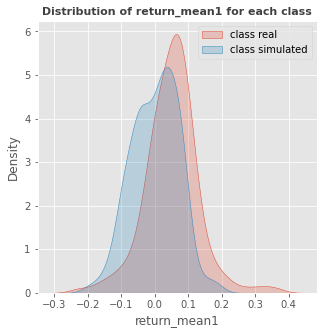

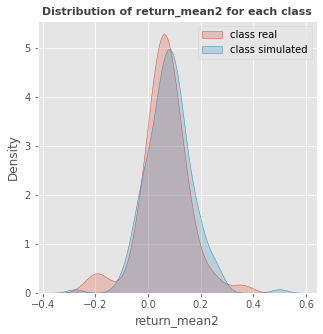

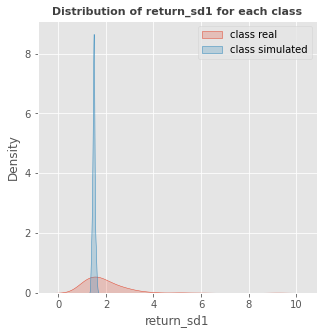

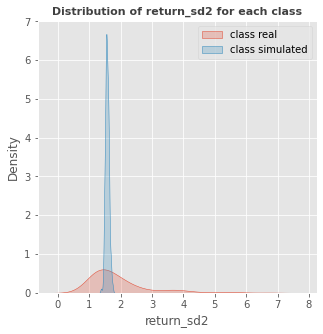

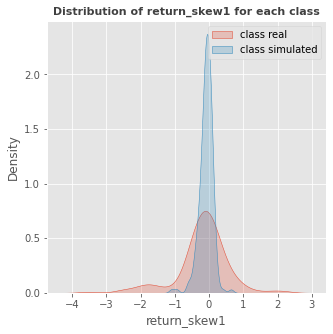

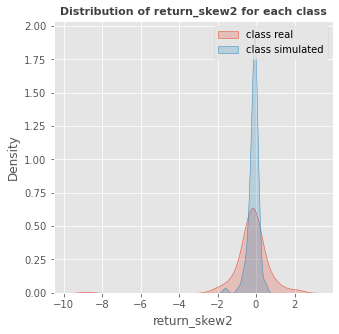

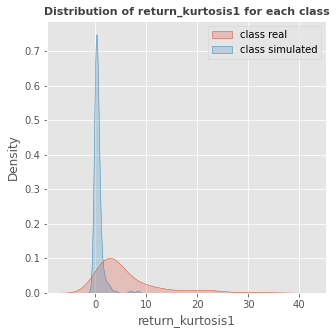

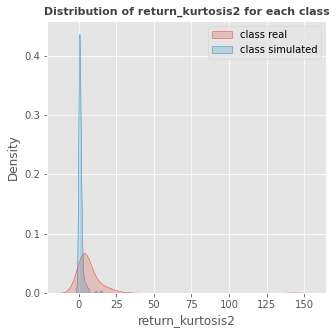

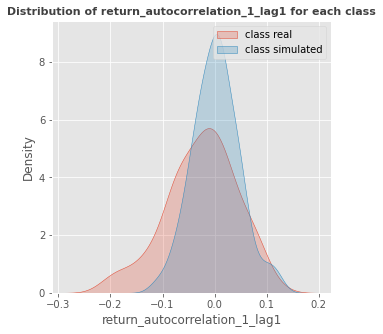

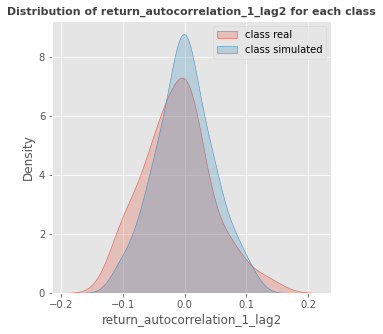

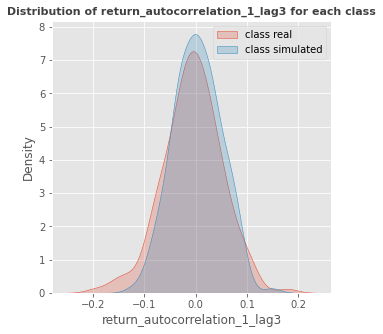

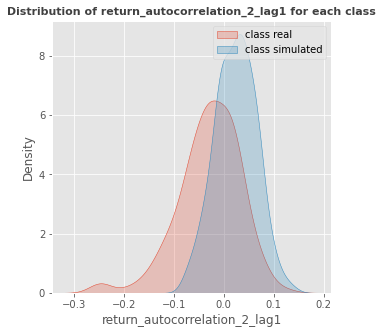

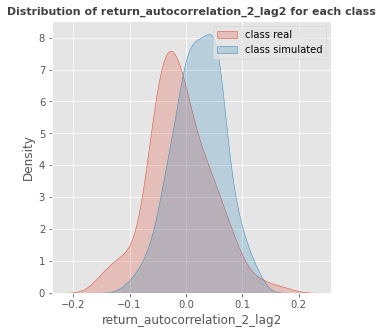

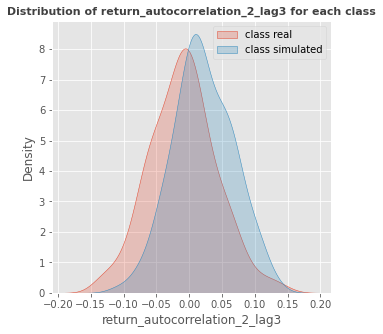

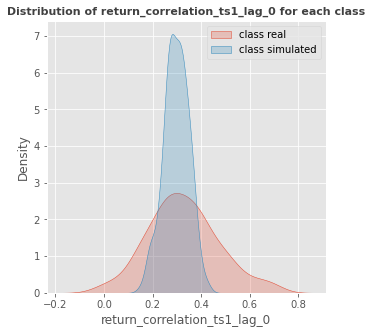

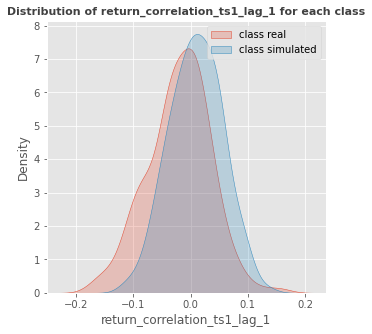

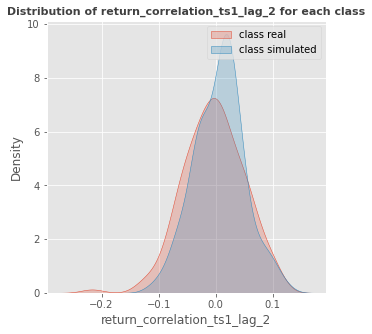

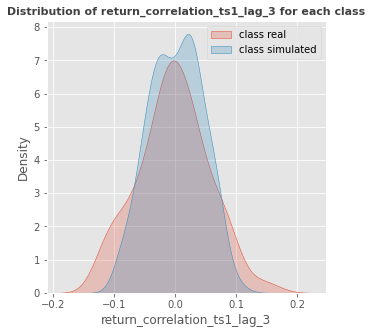

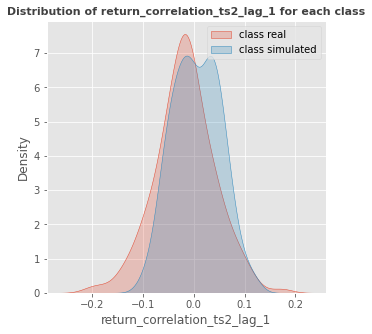

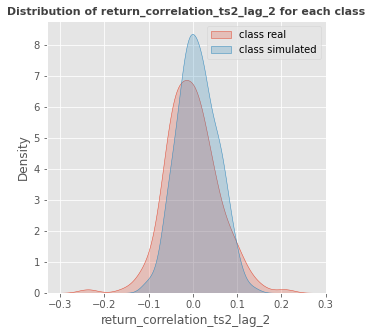

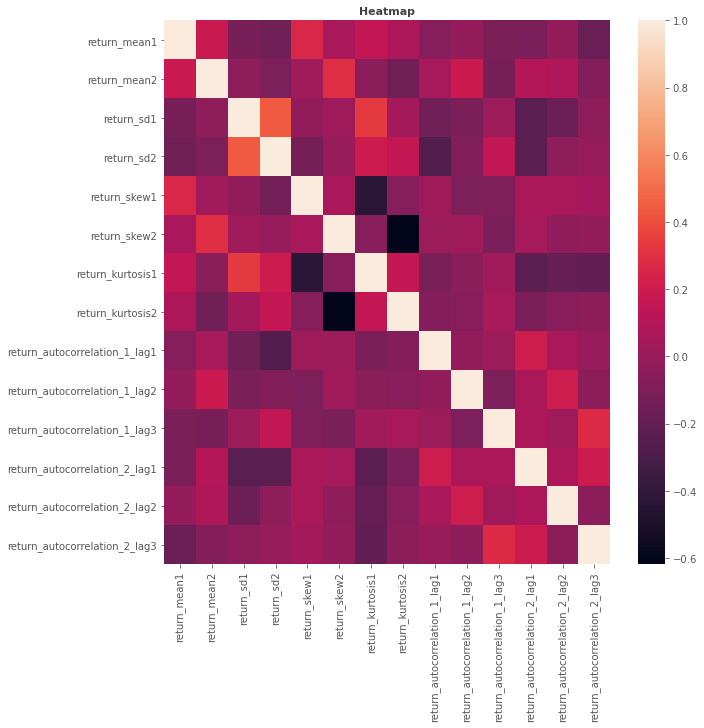

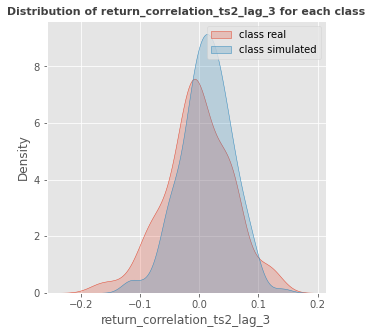

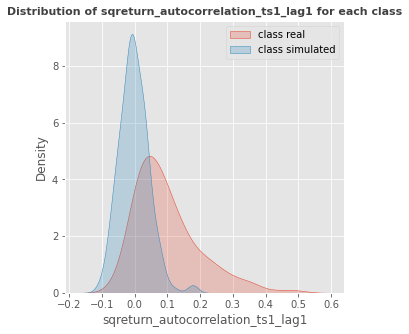

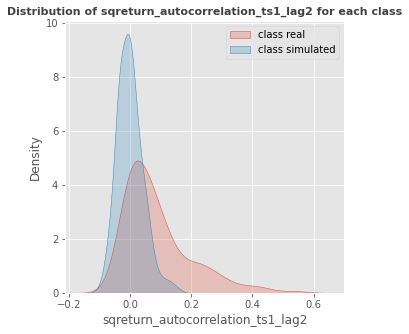

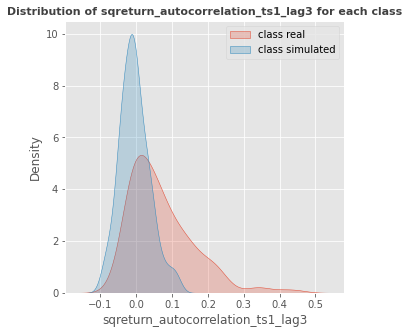

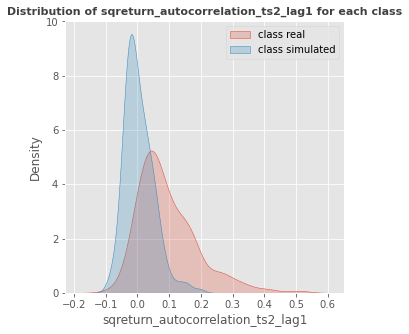

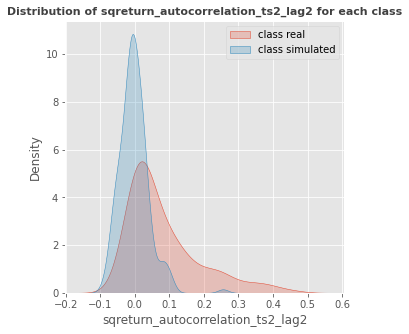

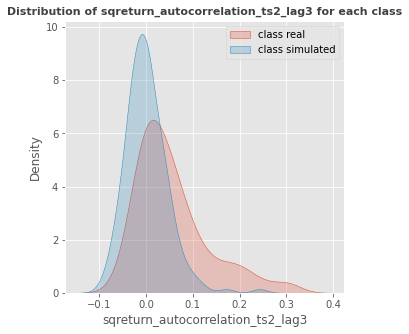

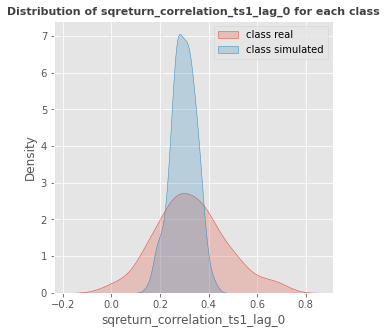

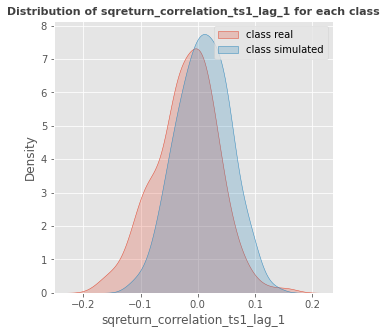

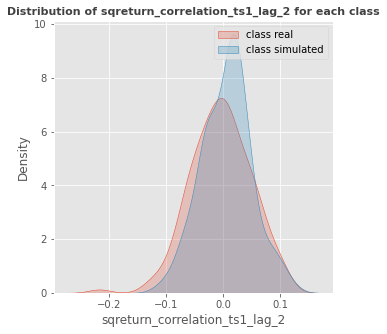

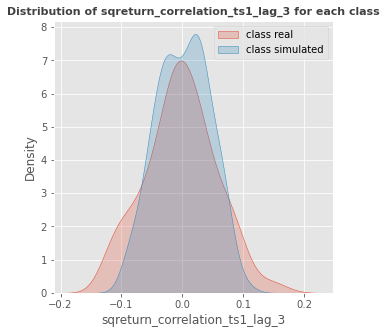

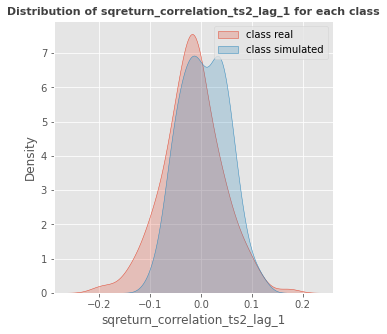

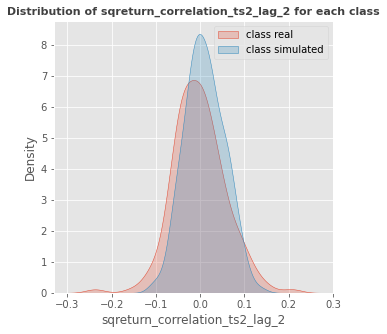

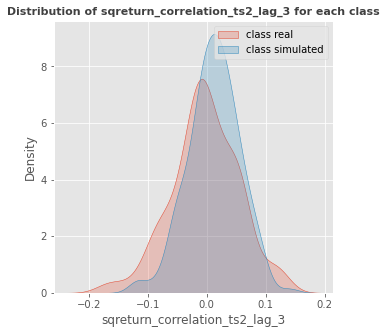

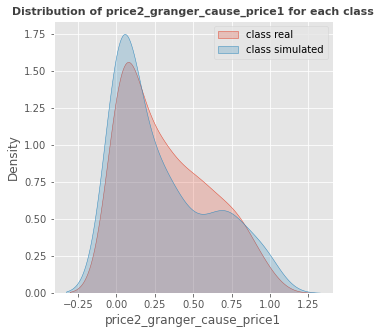

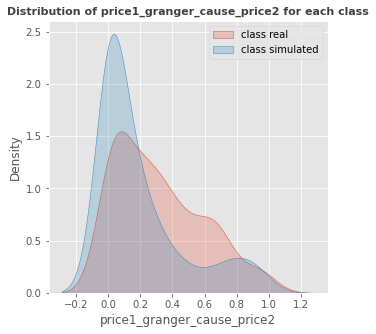

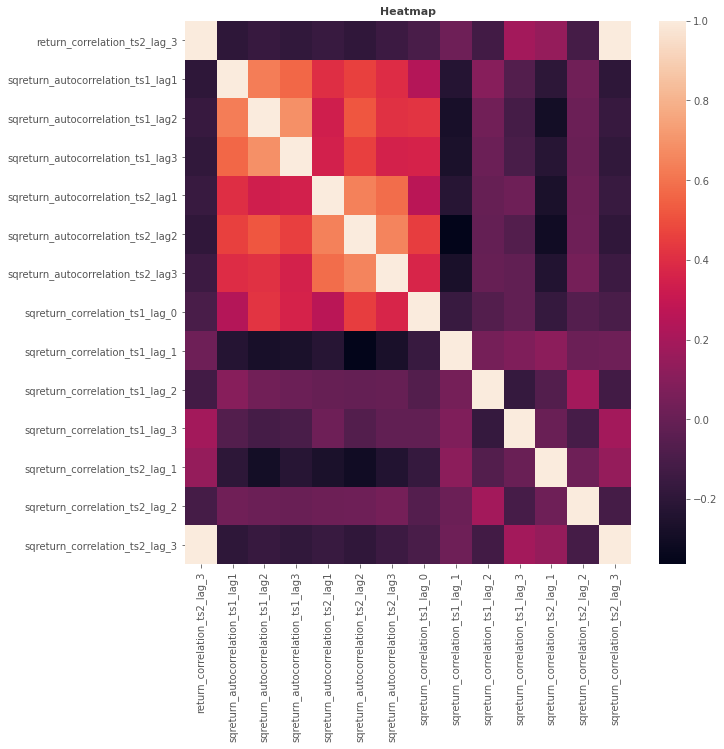

In [31]:
random_seed = int(random_seeds[iter])

n_sim_jumpou_log_prices = n_jumpou_simulation(
    random_seed=123, num_sim=248,

    mu11=params[0], mu12=params[1], 
    mu21=params[2], mu22=params[3], 
    sigma11=params[4], sigma12=params[5], 
    sigma21=params[6], sigma22=params[7],
    j11=params[8], j12=params[9], 
    j21=params[10], j22=params[11],

    alpha=2*params[12]*params[13]+0.5, 
    beta1=params[12], beta2=params[13], 
    delta0=params[14], 
    mu1=0, mu2=0, 
    lambda11=params[15], lambda12=0, 
    lambda21=0, lambda22=1/params[15],

    xinit_vec=xinit_vec, T0=T0, T=T, length=length)

n_sim_jumpou_pair_prices = log_price_to_price(n_log_price=n_sim_jumpou_log_prices)
n_sim_jumpou_pair_returns = price_to_return(n_price=n_sim_jumpou_pair_prices)

n_sim_jumpou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/cal_jumpou/n_sim_jumpou_pair_prices.csv")
n_sim_jumpou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/cal_jumpou/n_sim_jumpou_pair_returns.csv")


simulated_statistics = create_statistics(
    label="simulated", 
    rolling_window=20, 
    return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/cal_jumpou/n_sim_jumpou_pair_returns.csv", 
    price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/cal_jumpou/n_sim_jumpou_pair_prices.csv")


dataset = pd.concat([real_statistics, simulated_statistics])
X = dataset.iloc[:, 0:36]
y = dataset.iloc[:, 36]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)


plt.rc('figure', max_open_warning = 0)
EDA.extensive_eda(X_train.iloc[:, 0:20], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/cal_jumpou/EDA_oujump_2")
EDA.extensive_eda(X_train.iloc[:, 20:36], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/cal_jumpou/EDA_oujump_2")

In [24]:
random_seed = 9868
real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_returns_classify.csv", 
    price_csv_location=real_data_folder + "pair_prices_classify.csv")

n_sim_jumpou_log_prices = n_jumpou_simulation(
    random_seed=random_seed, num_sim=248,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        
        alpha=2*params[12]*params[13]+0.5, 
        beta1=params[12], beta2=params[13], 
        delta0=params[14], 
        mu1=0, mu2=0, 
        lambda11=params[15], lambda12=0, 
        lambda21=0, lambda22=1/params[15],
    xinit_vec=xinit_vec, T0=T0, T=T, length=length)

n_sim_jumpou_pair_prices = log_price_to_price(n_log_price=n_sim_jumpou_log_prices)
n_sim_jumpou_pair_returns = price_to_return(n_price=n_sim_jumpou_pair_prices)

n_sim_jumpou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_prices.csv")
n_sim_jumpou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_returns.csv")


simulated_statistics = create_statistics(
    label="simulated", 
    rolling_window=20, 
    return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_returns.csv", 
    price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_jumpou_pair_prices.csv")


dataset = pd.concat([real_statistics, simulated_statistics])
X = dataset.iloc[:, 0:36]
y = dataset.iloc[:, 36]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
automl = AutoML(eval_metric='accuracy')
automl.fit(X_train, y_train)
predictions = automl.predict(X_test)
accuracy_result = accuracy_score(y_test, predictions)

print(f"Accuracy of predictions:  {accuracy_result:.3f}")


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5909  , p=0.2048  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=3.2140  , p=0.2005  , df=2
likelihood ratio test: chi2=3.2037  , p=0.2015  , df=2
parameter F test:         F=1.5909  , p=0.2048  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.5049  , p=0.0016  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=13.1418 , p=0.0014  , df=2
likelihood ratio test: chi2=12.9713 , p=0.0015  , df=2
parameter F test:         F=6.5049  , p=0.0016  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6032  , p=0.4377  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.6068  , p=0.4360  , df=1
likelihood ratio test: chi2=0.6065  , p=0.4361  , df=1
parameter F test:         F=0.6032  , p=0.4377  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.8732 , p=0.0006  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7299  , p=0.4825  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.4746  , p=0.4784  , df=2
likelihood ratio test: chi2=1.4724  , p=0.4789  , df=2
parameter F test:         F=0.7299  , p=0.4825  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6513  , p=0.5218  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.3159  , p=0.5179  , df=2
likelihood ratio test: chi2=1.3141  , p=0.5184  , df=2
parameter F test:         F=0.6513  , p=0.5218  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0003  , p=0.9854  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0003  , p=0.9853  , df=1
likelihood ratio test: chi2=0.0003  , p=0.9853  , df=1
parameter F test:         F=0.0003  , p=0.9854  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0843  , p=0.2982  

ssr based F test:         F=1.8695  , p=0.1146  , df_denom=487, df_num=4
ssr based chi2 test:   chi2=7.6160  , p=0.1067  , df=4
likelihood ratio test: chi2=7.5582  , p=0.1092  , df=4
parameter F test:         F=1.8695  , p=0.1146  , df_denom=487, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5427  , p=0.4617  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.5459  , p=0.4600  , df=1
likelihood ratio test: chi2=0.5456  , p=0.4601  , df=1
parameter F test:         F=0.5427  , p=0.4617  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1434  , p=0.0768  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=3.1625  , p=0.0753  , df=1
likelihood ratio test: chi2=3.1525  , p=0.0758  , df=1
parameter F test:         F=3.1434  , p=0.0768  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0913  , p=0.0808  , df_denom=487, df_num=4
ssr based chi2 test: 

parameter F test:         F=0.3638  , p=0.6952  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0002  , p=0.9886  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0002  , p=0.9885  , df=1
likelihood ratio test: chi2=0.0002  , p=0.9885  , df=1
parameter F test:         F=0.0002  , p=0.9886  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2422  , p=0.6228  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.2437  , p=0.6216  , df=1
likelihood ratio test: chi2=0.2436  , p=0.6216  , df=1
parameter F test:         F=0.2422  , p=0.6228  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2376  , p=0.7886  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=0.4799  , p=0.7867  , df=2
likelihood ratio test: chi2=0.4797  , p=0.7867  , df=2
parameter F test:         F=0.2376  , p=0.7886  , df_denom=493, df_num=2

Granger Causality
nu


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6882  , p=0.5029  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.3904  , p=0.4990  , df=2
likelihood ratio test: chi2=1.3885  , p=0.4994  , df=2
parameter F test:         F=0.6882  , p=0.5029  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3040  , p=0.2724  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=2.6344  , p=0.2679  , df=2
likelihood ratio test: chi2=2.6274  , p=0.2688  , df=2
parameter F test:         F=1.3040  , p=0.2724  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.0699 , p=0.0016  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=10.1308 , p=0.0015  , df=1
likelihood ratio test: chi2=10.0293 , p=0.0015  , df=1
parameter F test:         F=10.0699 , p=0.0016  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1132  , p=0.7366  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3316  , p=0.0365  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=6.7308  , p=0.0345  , df=2
likelihood ratio test: chi2=6.6857  , p=0.0353  , df=2
parameter F test:         F=3.3316  , p=0.0365  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8246  , p=0.4390  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.6659  , p=0.4348  , df=2
likelihood ratio test: chi2=1.6631  , p=0.4354  , df=2
parameter F test:         F=0.8246  , p=0.4390  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3529  , p=0.5527  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.3551  , p=0.5513  , df=1
likelihood ratio test: chi2=0.3549  , p=0.5513  , df=1
parameter F test:         F=0.3529  , p=0.5527  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6498  , p=0.4206  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0606  , p=0.9412  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=0.1225  , p=0.9406  , df=2
likelihood ratio test: chi2=0.1225  , p=0.9406  , df=2
parameter F test:         F=0.0606  , p=0.9412  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4025  , p=0.6689  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=0.8131  , p=0.6659  , df=2
likelihood ratio test: chi2=0.8125  , p=0.6662  , df=2
parameter F test:         F=0.4025  , p=0.6689  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.3409  , p=0.0137  , df_denom=472, df_num=9
ssr based chi2 test:   chi2=21.9160 , p=0.0091  , df=9
likelihood ratio test: chi2=21.4410 , p=0.0108  , df=9
parameter F test:         F=2.3409  , p=0.0137  , df_denom=472, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.7654  , p=0.6486  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.1464  , p=0.0470  , df_denom=481, df_num=6
ssr based chi2 test:   chi2=13.2266 , p=0.0396  , df=6
likelihood ratio test: chi2=13.0526 , p=0.0422  , df=6
parameter F test:         F=2.1464  , p=0.0470  , df_denom=481, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.5075  , p=0.1737  , df_denom=481, df_num=6
ssr based chi2 test:   chi2=9.2897  , p=0.1579  , df=6
likelihood ratio test: chi2=9.2035  , p=0.1625  , df=6
parameter F test:         F=1.5075  , p=0.1737  , df_denom=481, df_num=6

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5485  , p=0.5782  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.1081  , p=0.5746  , df=2
likelihood ratio test: chi2=1.1068  , p=0.5750  , df=2
parameter F test:         F=0.5485  , p=0.5782  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7103  , p=0.0094  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9758  , p=0.3237  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.9817  , p=0.3218  , df=1
likelihood ratio test: chi2=0.9808  , p=0.3220  , df=1
parameter F test:         F=0.9758  , p=0.3237  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5980  , p=0.0584  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=3.6198  , p=0.0571  , df=1
likelihood ratio test: chi2=3.6067  , p=0.0575  , df=1
parameter F test:         F=3.5980  , p=0.0584  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1586  , p=0.1424  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=2.1716  , p=0.1406  , df=1
likelihood ratio test: chi2=2.1669  , p=0.1410  , df=1
parameter F test:         F=2.1586  , p=0.1424  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1707  , p=0.6797  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.6098  , p=0.1424  , df_denom=481, df_num=6
ssr based chi2 test:   chi2=9.9200  , p=0.1281  , df=6
likelihood ratio test: chi2=9.8217  , p=0.1324  , df=6
parameter F test:         F=1.6098  , p=0.1424  , df_denom=481, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.4662  , p=0.0023  , df_denom=481, df_num=6
ssr based chi2 test:   chi2=21.3595 , p=0.0016  , df=6
likelihood ratio test: chi2=20.9106 , p=0.0019  , df=6
parameter F test:         F=3.4662  , p=0.0023  , df_denom=481, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1378  , p=0.7107  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.1386  , p=0.7097  , df=1
likelihood ratio test: chi2=0.1386  , p=0.7097  , df=1
parameter F test:         F=0.1378  , p=0.7107  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6156  , p=0.4331  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1473  , p=0.0767  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=3.1663  , p=0.0752  , df=1
likelihood ratio test: chi2=3.1563  , p=0.0756  , df=1
parameter F test:         F=3.1473  , p=0.0767  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6280  , p=0.4285  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.6318  , p=0.4267  , df=1
likelihood ratio test: chi2=0.6314  , p=0.4268  , df=1
parameter F test:         F=0.6280  , p=0.4285  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.0664  , p=0.3862  , df_denom=472, df_num=9
ssr based chi2 test:   chi2=9.9844  , p=0.3517  , df=9
likelihood ratio test: chi2=9.8842  , p=0.3599  , df=9
parameter F test:         F=1.0664  , p=0.3862  , df_denom=472, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.7802  , p=0.6348  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0185  , p=0.8919  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0186  , p=0.8915  , df=1
likelihood ratio test: chi2=0.0186  , p=0.8915  , df=1
parameter F test:         F=0.0185  , p=0.8919  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2115  , p=0.6458  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.2128  , p=0.6446  , df=1
likelihood ratio test: chi2=0.2128  , p=0.6446  , df=1
parameter F test:         F=0.2115  , p=0.6458  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0659  , p=0.7975  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0663  , p=0.7968  , df=1
likelihood ratio test: chi2=0.0663  , p=0.7968  , df=1
parameter F test:         F=0.0659  , p=0.7975  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1062  , p=0.1473  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.8128  , p=0.0047  , df_denom=475, df_num=8
ssr based chi2 test:   chi2=23.3079 , p=0.0030  , df=8
likelihood ratio test: chi2=22.7726 , p=0.0037  , df=8
parameter F test:         F=2.8128  , p=0.0047  , df_denom=475, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.4603  , p=0.1693  , df_denom=475, df_num=8
ssr based chi2 test:   chi2=12.1008 , p=0.1468  , df=8
likelihood ratio test: chi2=11.9544 , p=0.1532  , df=8
parameter F test:         F=1.4603  , p=0.1693  , df_denom=475, df_num=8

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.7998  , p=0.1113  , df_denom=484, df_num=5
ssr based chi2 test:   chi2=9.2038  , p=0.1012  , df=5
likelihood ratio test: chi2=9.1192  , p=0.1044  , df=5
parameter F test:         F=1.7998  , p=0.1113  , df_denom=484, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.3562  , p=0.0054  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4626  , p=0.4967  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.4654  , p=0.4951  , df=1
likelihood ratio test: chi2=0.4652  , p=0.4952  , df=1
parameter F test:         F=0.4626  , p=0.4967  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4577  , p=0.4990  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.4605  , p=0.4974  , df=1
likelihood ratio test: chi2=0.4603  , p=0.4975  , df=1
parameter F test:         F=0.4577  , p=0.4990  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6836  , p=0.0121  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=11.2087 , p=0.0106  , df=3
likelihood ratio test: chi2=11.0841 , p=0.0113  , df=3
parameter F test:         F=3.6836  , p=0.0121  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6631  , p=0.5751  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1329  , p=0.1196  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=4.3090  , p=0.1160  , df=2
likelihood ratio test: chi2=4.2905  , p=0.1170  , df=2
parameter F test:         F=2.1329  , p=0.1196  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2259  , p=0.0406  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=6.5172  , p=0.0384  , df=2
likelihood ratio test: chi2=6.4749  , p=0.0393  , df=2
parameter F test:         F=3.2259  , p=0.0406  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7844  , p=0.0958  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=2.8012  , p=0.0942  , df=1
likelihood ratio test: chi2=2.7934  , p=0.0947  , df=1
parameter F test:         F=2.7844  , p=0.0958  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9779  , p=0.0148  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6025  , p=0.4380  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.6061  , p=0.4362  , df=1
likelihood ratio test: chi2=0.6058  , p=0.4364  , df=1
parameter F test:         F=0.6025  , p=0.4380  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3063  , p=0.1295  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=2.3203  , p=0.1277  , df=1
likelihood ratio test: chi2=2.3149  , p=0.1281  , df=1
parameter F test:         F=2.3063  , p=0.1295  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1834  , p=0.1401  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=2.1966  , p=0.1383  , df=1
likelihood ratio test: chi2=2.1917  , p=0.1388  , df=1
parameter F test:         F=2.1834  , p=0.1401  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9958  , p=0.3188  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4684  , p=0.0113  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=6.5075  , p=0.0107  , df=1
likelihood ratio test: chi2=6.4654  , p=0.0110  , df=1
parameter F test:         F=6.4684  , p=0.0113  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7592  , p=0.1853  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.7699  , p=0.1834  , df=1
likelihood ratio test: chi2=1.7667  , p=0.1838  , df=1
parameter F test:         F=1.7592  , p=0.1853  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.7376  , p=0.0029  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=14.4157 , p=0.0024  , df=3
likelihood ratio test: chi2=14.2106 , p=0.0026  , df=3
parameter F test:         F=4.7376  , p=0.0029  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.2473  , p=0.0014  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2823  , p=0.5954  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2840  , p=0.5941  , df=1
likelihood ratio test: chi2=0.2839  , p=0.5941  , df=1
parameter F test:         F=0.2823  , p=0.5954  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9934  , p=0.0842  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.0115  , p=0.0827  , df=1
likelihood ratio test: chi2=3.0025  , p=0.0831  , df=1
parameter F test:         F=2.9934  , p=0.0842  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9710  , p=0.1610  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9829  , p=0.1591  , df=1
likelihood ratio test: chi2=1.9790  , p=0.1595  , df=1
parameter F test:         F=1.9710  , p=0.1610  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6645  , p=0.0101  

ssr based F test:         F=0.5017  , p=0.4791  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5048  , p=0.4774  , df=1
likelihood ratio test: chi2=0.5045  , p=0.4775  , df=1
parameter F test:         F=0.5017  , p=0.4791  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1445  , p=0.3192  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.3121  , p=0.3147  , df=2
likelihood ratio test: chi2=2.3068  , p=0.3156  , df=2
parameter F test:         F=1.1445  , p=0.3192  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6886  , p=0.0690  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.4317  , p=0.0661  , df=2
likelihood ratio test: chi2=5.4024  , p=0.0671  , df=2
parameter F test:         F=2.6886  , p=0.0690  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.2342  , p=0.2769  , df_denom=476, df_num=8
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6473  , p=0.4215  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6512  , p=0.4197  , df=1
likelihood ratio test: chi2=0.6508  , p=0.4198  , df=1
parameter F test:         F=0.6473  , p=0.4215  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.8169 , p=0.0004  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.8943 , p=0.0003  , df=1
likelihood ratio test: chi2=12.7308 , p=0.0004  , df=1
parameter F test:         F=12.8169 , p=0.0004  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3264  , p=0.5680  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3284  , p=0.5666  , df=1
likelihood ratio test: chi2=0.3283  , p=0.5667  , df=1
parameter F test:         F=0.3264  , p=0.5680  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.4481 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2395  , p=0.0725  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.2591  , p=0.0710  , df=1
likelihood ratio test: chi2=3.2485  , p=0.0715  , df=1
parameter F test:         F=3.2395  , p=0.0725  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9809  , p=0.3225  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9868  , p=0.3205  , df=1
likelihood ratio test: chi2=0.9858  , p=0.3208  , df=1
parameter F test:         F=0.9809  , p=0.3225  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0040  , p=0.3168  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0100  , p=0.3149  , df=1
likelihood ratio test: chi2=1.0090  , p=0.3151  , df=1
parameter F test:         F=1.0040  , p=0.3168  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0012  , p=0.9727  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6161  , p=0.0035  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.6681  , p=0.0032  , df=1
likelihood ratio test: chi2=8.5938  , p=0.0034  , df=1
parameter F test:         F=8.6161  , p=0.0035  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1583  , p=0.6909  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1592  , p=0.6899  , df=1
likelihood ratio test: chi2=0.1592  , p=0.6899  , df=1
parameter F test:         F=0.1583  , p=0.6909  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3411  , p=0.2474  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3491  , p=0.2454  , df=1
likelihood ratio test: chi2=1.3473  , p=0.2457  , df=1
parameter F test:         F=1.3411  , p=0.2474  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0320  , p=0.8581  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.2058  , p=0.0044  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.2554  , p=0.0041  , df=1
likelihood ratio test: chi2=8.1880  , p=0.0042  , df=1
parameter F test:         F=8.2058  , p=0.0044  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0009  , p=0.9764  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0009  , p=0.9763  , df=1
likelihood ratio test: chi2=0.0009  , p=0.9763  , df=1
parameter F test:         F=0.0009  , p=0.9764  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9976  , p=0.0937  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=8.1377  , p=0.0867  , df=4
likelihood ratio test: chi2=8.0718  , p=0.0890  , df=4
parameter F test:         F=1.9976  , p=0.0937  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0449  , p=0.3835  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1366  , p=0.7118  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1374  , p=0.7109  , df=1
likelihood ratio test: chi2=0.1374  , p=0.7109  , df=1
parameter F test:         F=0.1366  , p=0.7118  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8739  , p=0.0907  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8912  , p=0.0891  , df=1
likelihood ratio test: chi2=2.8829  , p=0.0895  , df=1
parameter F test:         F=2.8739  , p=0.0907  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9501  , p=0.0474  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.9739  , p=0.0462  , df=1
likelihood ratio test: chi2=3.9582  , p=0.0466  , df=1
parameter F test:         F=3.9501  , p=0.0474  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1386  , p=0.0026  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4429  , p=0.2372  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.9150  , p=0.2328  , df=2
likelihood ratio test: chi2=2.9065  , p=0.2338  , df=2
parameter F test:         F=1.4429  , p=0.2372  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9964  , p=0.1369  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.0332  , p=0.1331  , df=2
likelihood ratio test: chi2=4.0170  , p=0.1342  , df=2
parameter F test:         F=1.9964  , p=0.1369  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2441  , p=0.6215  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2455  , p=0.6202  , df=1
likelihood ratio test: chi2=0.2455  , p=0.6203  , df=1
parameter F test:         F=0.2441  , p=0.6215  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7309  , p=0.0170  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2790  , p=0.2394  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=13.3615 , p=0.2042  , df=10
likelihood ratio test: chi2=13.1829 , p=0.2136  , df=10
parameter F test:         F=1.2790  , p=0.2394  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.4693  , p=0.9097  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=4.9024  , p=0.8976  , df=10
likelihood ratio test: chi2=4.8781  , p=0.8992  , df=10
parameter F test:         F=0.4693  , p=0.9097  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2278  , p=0.8770  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=0.6932  , p=0.8748  , df=3
likelihood ratio test: chi2=0.6928  , p=0.8749  , df=3
parameter F test:         F=0.2278  , p=0.8770  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4444  , 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4645  , p=0.2234  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.4562  , p=0.2162  , df=3
likelihood ratio test: chi2=4.4364  , p=0.2180  , df=3
parameter F test:         F=1.4645  , p=0.2234  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9316  , p=0.1235  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=5.8774  , p=0.1177  , df=3
likelihood ratio test: chi2=5.8430  , p=0.1195  , df=3
parameter F test:         F=1.9316  , p=0.1235  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.4136  , p=0.0023  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.4704  , p=0.0021  , df=1
likelihood ratio test: chi2=9.3819  , p=0.0022  , df=1
parameter F test:         F=9.4136  , p=0.0023  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0064  , p=0.9364  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5511  , p=0.4582  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5544  , p=0.4565  , df=1
likelihood ratio test: chi2=0.5541  , p=0.4567  , df=1
parameter F test:         F=0.5511  , p=0.4582  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7785  , p=0.0095  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.8195  , p=0.0090  , df=1
likelihood ratio test: chi2=6.7734  , p=0.0093  , df=1
parameter F test:         F=6.7785  , p=0.0095  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2984  , p=0.5851  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3002  , p=0.5838  , df=1
likelihood ratio test: chi2=0.3001  , p=0.5838  , df=1
parameter F test:         F=0.2984  , p=0.5851  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8219  , p=0.0286  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.6016  , p=0.0033  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=18.4166 , p=0.0025  , df=5
likelihood ratio test: chi2=18.0829 , p=0.0028  , df=5
parameter F test:         F=3.6016  , p=0.0033  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0926  , p=0.0651  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=10.7001 , p=0.0577  , df=5
likelihood ratio test: chi2=10.5863 , p=0.0602  , df=5
parameter F test:         F=2.0926  , p=0.0651  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5685  , p=0.4512  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5720  , p=0.4495  , df=1
likelihood ratio test: chi2=0.5717  , p=0.4496  , df=1
parameter F test:         F=0.5685  , p=0.4512  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4503  , p=0.5025  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.7004  , p=0.0008  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=17.3450 , p=0.0006  , df=3
likelihood ratio test: chi2=17.0497 , p=0.0007  , df=3
parameter F test:         F=5.7004  , p=0.0008  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5501  , p=0.6483  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.6739  , p=0.6427  , df=3
likelihood ratio test: chi2=1.6711  , p=0.6434  , df=3
parameter F test:         F=0.5501  , p=0.6483  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.5515  , p=0.7372  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=2.8200  , p=0.7277  , df=5
likelihood ratio test: chi2=2.8120  , p=0.7289  , df=5
parameter F test:         F=0.5515  , p=0.7372  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.7391  , p=0.1241  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.0247  , p=0.4083  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=6.3142  , p=0.3889  , df=6
likelihood ratio test: chi2=6.2742  , p=0.3932  , df=6
parameter F test:         F=1.0247  , p=0.4083  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.9257  , p=0.0008  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=24.1897 , p=0.0005  , df=6
likelihood ratio test: chi2=23.6172 , p=0.0006  , df=6
parameter F test:         F=3.9257  , p=0.0008  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1783  , p=0.6731  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1793  , p=0.6719  , df=1
likelihood ratio test: chi2=0.1793  , p=0.6720  , df=1
parameter F test:         F=0.1783  , p=0.6731  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8347  , p=0.0929  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6400  , p=0.0034  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.6921  , p=0.0032  , df=1
likelihood ratio test: chi2=8.6175  , p=0.0033  , df=1
parameter F test:         F=8.6400  , p=0.0034  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7261  , p=0.3946  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7305  , p=0.3927  , df=1
likelihood ratio test: chi2=0.7300  , p=0.3929  , df=1
parameter F test:         F=0.7261  , p=0.3946  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3248  , p=0.5690  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3267  , p=0.5676  , df=1
likelihood ratio test: chi2=0.3266  , p=0.5677  , df=1
parameter F test:         F=0.3248  , p=0.5690  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2074  , p=0.6490  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0651  , p=0.1513  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.0776  , p=0.1495  , df=1
likelihood ratio test: chi2=2.0733  , p=0.1499  , df=1
parameter F test:         F=2.0651  , p=0.1513  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7917  , p=0.1813  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8025  , p=0.1794  , df=1
likelihood ratio test: chi2=1.7992  , p=0.1798  , df=1
parameter F test:         F=1.7917  , p=0.1813  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0012  , p=0.9723  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0012  , p=0.9722  , df=1
likelihood ratio test: chi2=0.0012  , p=0.9722  , df=1
parameter F test:         F=0.0012  , p=0.9723  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5268  , p=0.0063  

AutoML directory: AutoML_61
The task is binary_classification with evaluation metric accuracy
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 0.27 seconds
2_DecisionTree accuracy 0.965517 trained in 12.38 seconds
3_Linear accuracy 0.942529 trained in 3.51 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.942529 trained in 4.22 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 1.8 seconds
6_Default_RandomForest accuracy 0.942529 trained in 7.09 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.37 seconds
AutoML fit time: 40.9 seconds
AutoML best model: 5_Default_NeuralNetwork
Accuracy of predictions:  0.980


An input array is constant; the correlation coefficent is not defined.


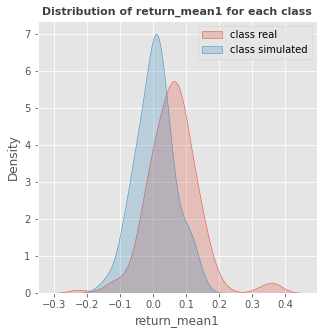

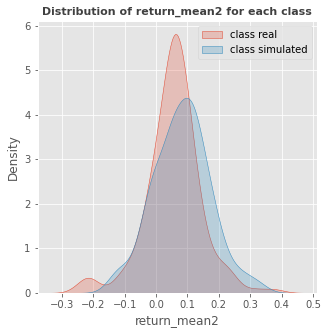

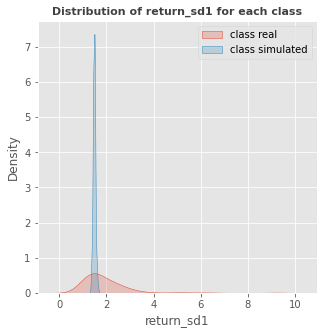

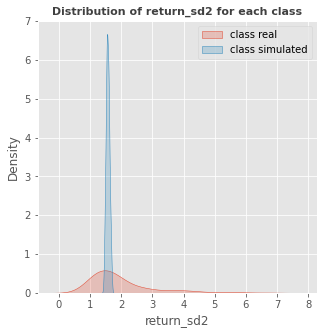

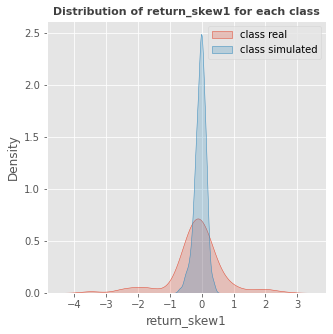

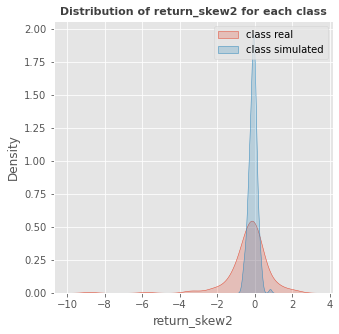

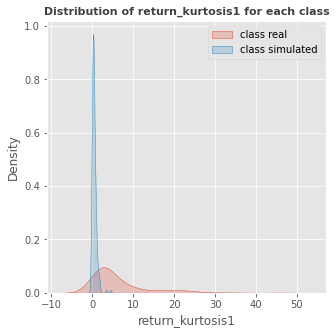

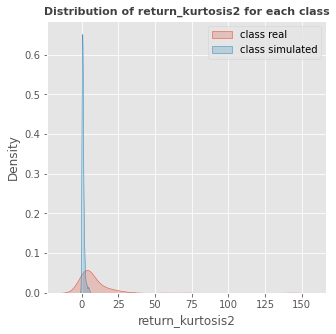

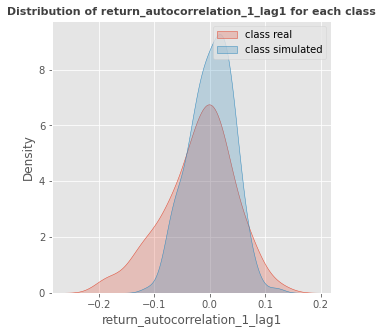

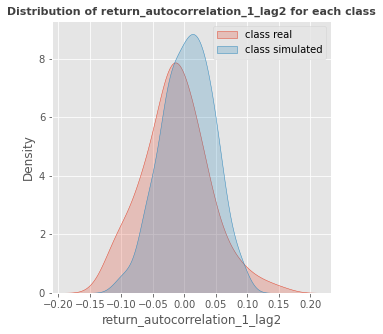

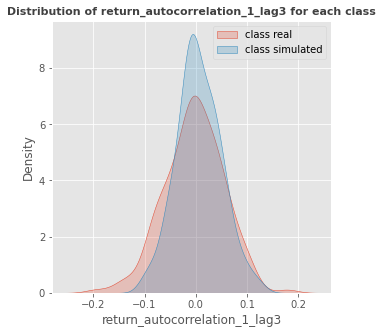

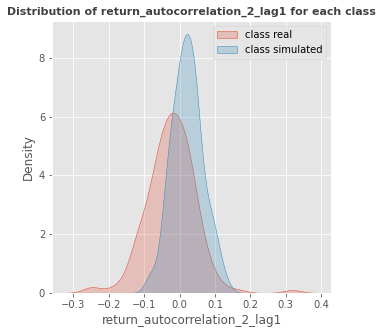

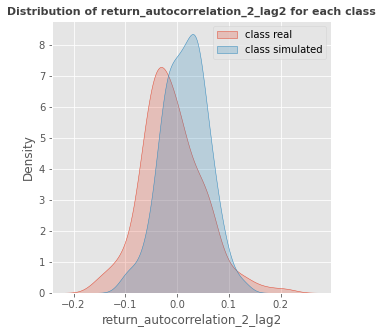

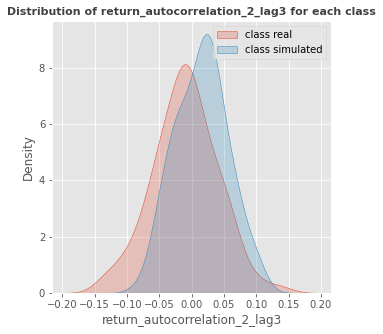

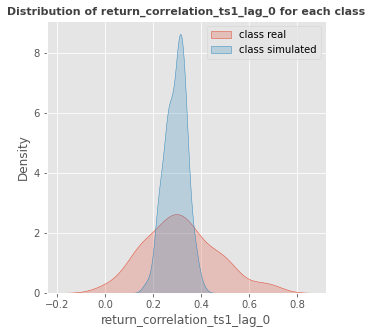

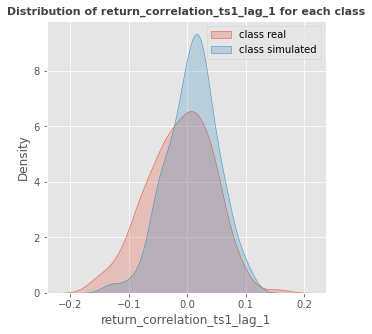

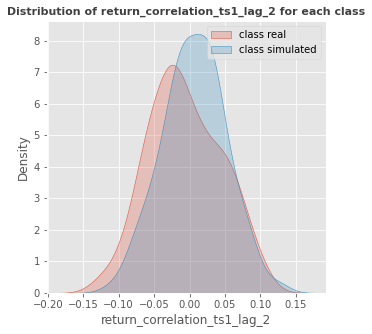

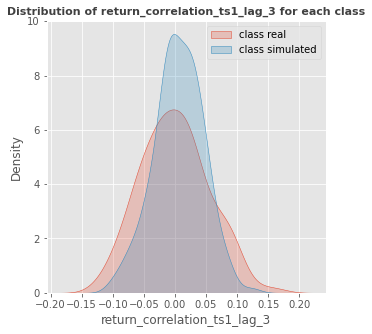

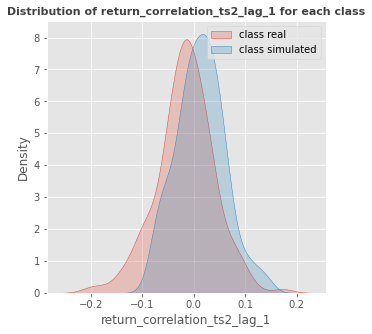

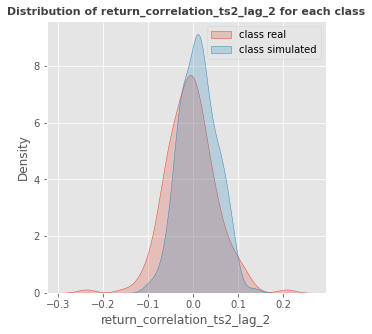

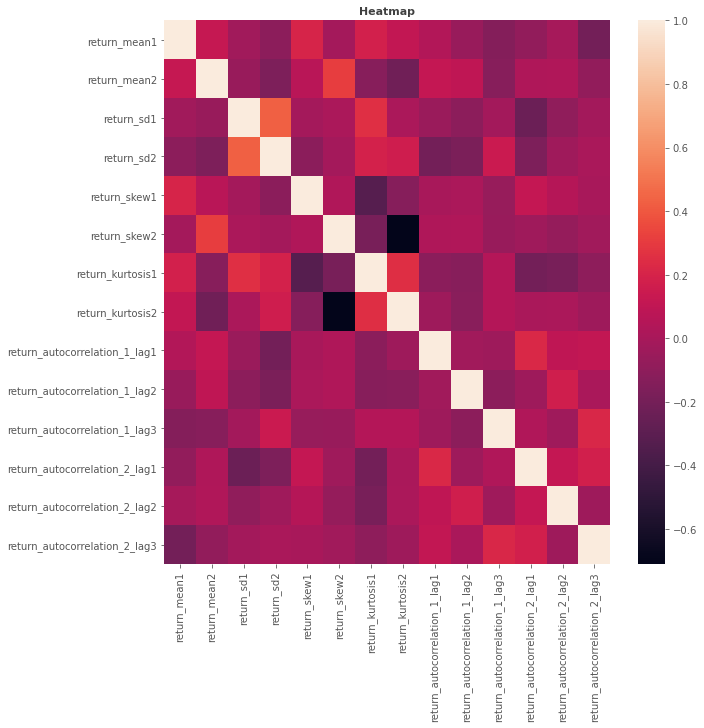

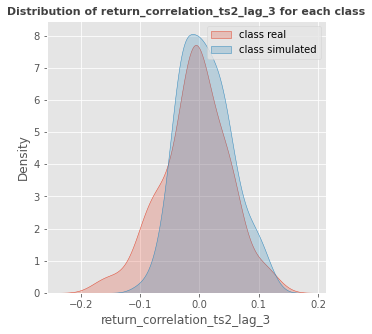

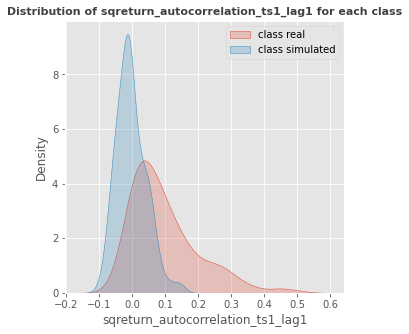

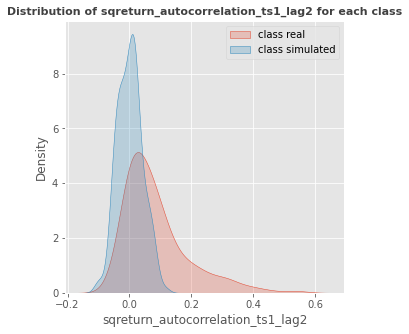

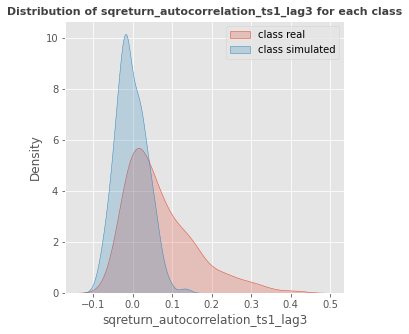

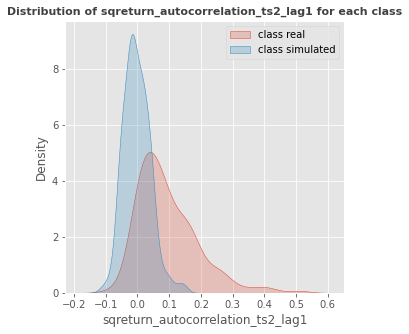

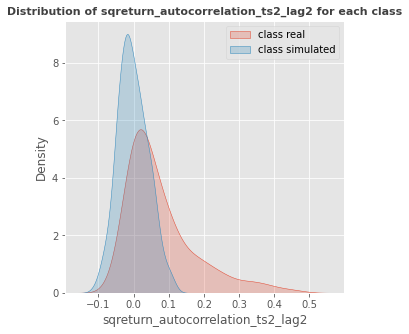

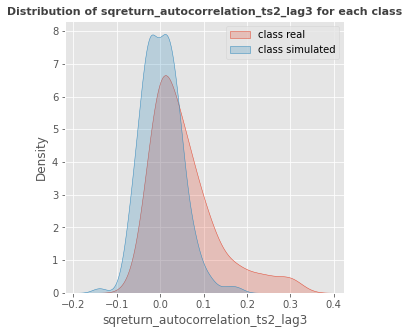

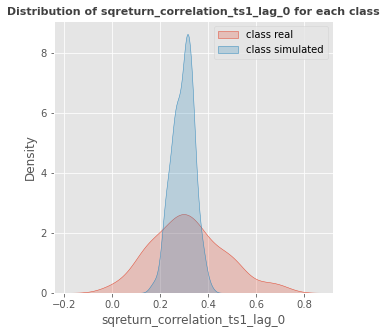

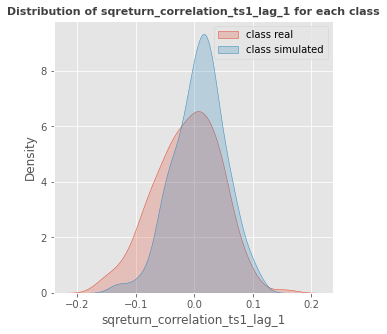

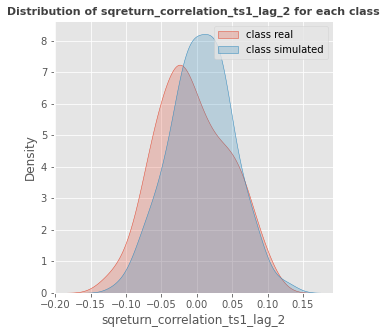

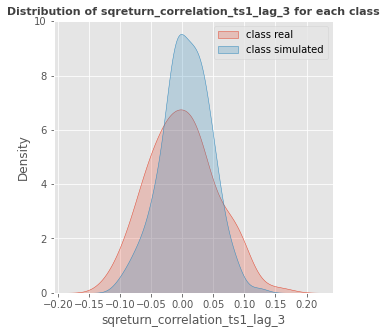

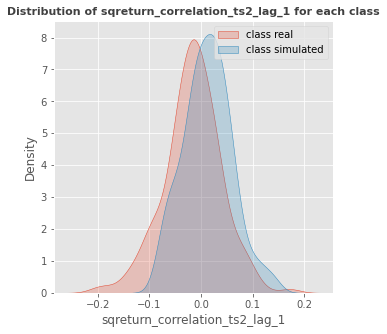

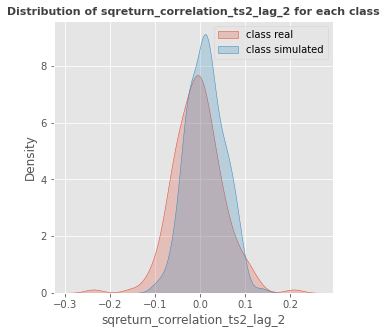

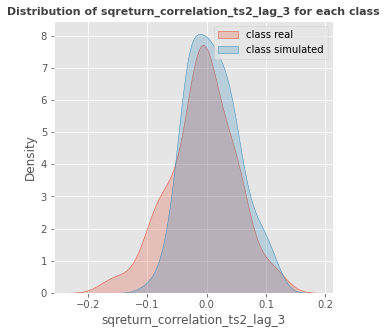

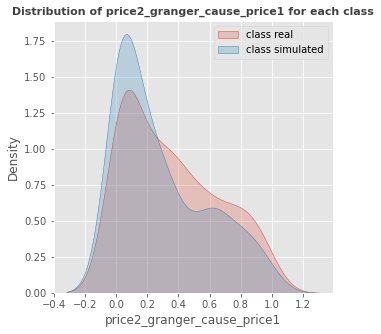

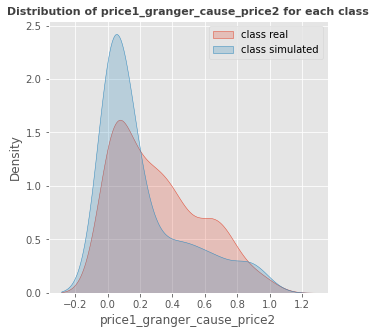

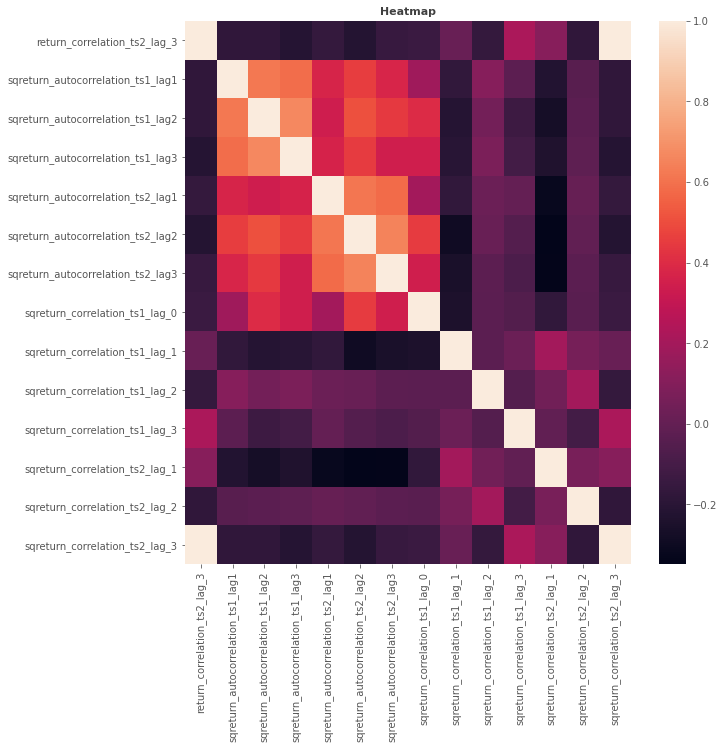

In [25]:
plt.rc('figure', max_open_warning = 0)
EDA.extensive_eda(X_train.iloc[:, 0:20], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_oujump_5")
EDA.extensive_eda(X_train.iloc[:, 20:36], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_oujump_5")

In [26]:
print(params)

 [1]  0.32623792  0.05466045  1.02623598  0.21295165 -4.25647294 -1.55299541
 [7] -1.55119802 -4.71058895 -0.10484022  0.14489413 -0.13356743  0.17839348
[13]  1.95482864  2.90535125  3.27055328  3.42192823

